In [12]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [13]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC3_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

# @param Definition des table et colonnes --> Dépendent de la DB
DB            = "Archive2018_2019_prod"
TABLE_ENTETE  = "Recette_entete_ticket"
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
CONSOMMATEUR  = "Consommateur"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
RECETTE_DETAIL = TABLE_DETAIL            + ".Total_net_ttc_ligne"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

Univers_Depth  = 4            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_ticket_max = 5000000   # MAX = 26.671.566 --- ~ 4 data / ticket

# @param Permet de faire varier l'analyse
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif
min_support    = 0         # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> 0 => auto 
min_confidence = 1/3       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

take_only_fid        = False
do_shop              = False
tabac_key            = 272
accessoire_tabac_key = 271

In [14]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# GROUPEMENT D'ARTICLE

In [15]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE   + '''.KEY], ''' + ('''
['''+ TABLE_ENTETE   +'''.'''+TABLE_MAGASIN+'''.KEY],''')*int(do_shop) + '''
['''     + RECETTE_DETAIL + ''']
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(max(11000000+nbr_ticket_max, int(take_only_fid)*30000000)) + '''
AND ['''      + TABLE_ENTETE  + '''.KEY] > ''' + str(max(11000000, int(take_only_fid)*30000000)) + '''
AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388 '''+ ('''
AND ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY] != -1 ''')*int(take_only_fid) + '''
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY], 
[Recette_detail_ticket.Total_net_ttc_ligne]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 16000000
AND [Recette_entete_ticket.KEY] > 11000000
AND [Article_meti_HIST.Univers.KEY] != 388 
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~244secondes
          Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0                                   36

In [16]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 1s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [17]:
univers_correspondance = {}
deleted = set()
for item in df_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{3: 2}


In [18]:
start = time()

transactions      = []
actual_key_ticket = -1
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    
    if actual_key_ticket != key_tic:
        if actual_key_ticket != -1:
            transactions.append(tuple(l))
        actual_key_ticket = key_tic
        l = []
        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(int(key_univ))
transactions.append(tuple(l))
print(transactions[:20])

# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 

[(360, 402), (403, 298, 403, 403), (392, 220, 220), (171, 219, 288), (435, 174, 151, 151, 151, 353, 431), (393, 457, 392, 470), (400, 360, 397, 360), (211, 458), (232, 357, 110, 393), (272,), (297, 272), (409, 313, 409, 452), (242, 117), (408, 402, 458, 406), (298, 27), (272,), (409, 121, 469, 163), (211,), (396, 456, 129), (391, 363)]
Time Taken to load transaction: ~15secondes


In [19]:
start = time()
rec_article = {}
N = len(transactions)

for t in transactions:
    for art in set(t):
        if not str(art) in rec_article.keys():
            rec_article[str(art)] = 0
        rec_article[str(art)]+=1

for k in rec_article.keys():
    rec_article[k]/= N
print(N)

print("Time Taken to load recurence: ~" + str(int(time() - start)) + "secondes") 

3795699
Time Taken to load recurence: ~10secondes


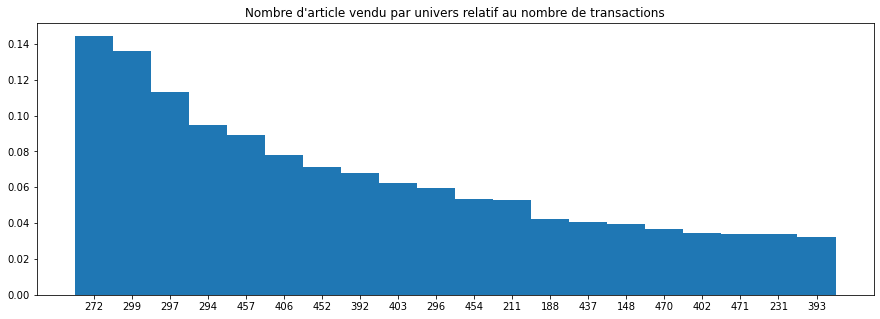

In [20]:
fig = plt.figure(figsize=(15, 5))

rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

nbr_univ = len(rec_article.keys())

nbr_to_plt = 20
plt.bar(list(rec_article.keys())[:min(nbr_to_plt, nbr_univ)]
            ,list(rec_article.values())[:min(nbr_to_plt, nbr_univ)],1)
        
plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")
    
if save_fig:
    plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
plt.show()

In [21]:
if do_analysis:
    data_rules = {}
    data_time  = {}
    for i_support in range(sup_iter+1):
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter

        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter

            print(min_confidence, end = '... ')

            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")


    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)

In [22]:
start = time()

min_supp = 1/nbr_univ if min_support == 0 else min_support
print(min_supp)
                     
_, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)

# eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 

0.002403846153846154
Time Taken to run Apriori Algorithm : ~37secondes


In [23]:
print(len(rules))
print(sum([r.support for r in rules])*0.05)
for rule in sorted(rules, key=lambda rule: rule.support):
    print(rule)

12
0.0035584618274525984
{437, 439} -> {299} (conf: 0.720, supp: 0.003, lift: 5.303, conv: 3.087)
{403, 452} -> {406} (conf: 0.337, supp: 0.003, lift: 4.331, conv: 1.391)
{438} -> {299} (conf: 0.365, supp: 0.003, lift: 2.689, conv: 1.361)
{301} -> {299} (conf: 0.454, supp: 0.003, lift: 3.346, conv: 1.584)
{27} -> {294} (conf: 0.416, supp: 0.003, lift: 4.402, conv: 1.550)
{408} -> {402} (conf: 0.346, supp: 0.004, lift: 9.955, conv: 1.475)
{271} -> {272} (conf: 0.508, supp: 0.005, lift: 3.520, conv: 1.740)
{448} -> {297} (conf: 0.953, supp: 0.006, lift: 8.441, conv: 19.016)
{74} -> {294} (conf: 0.359, supp: 0.006, lift: 3.801, conv: 1.413)
{475} -> {297} (conf: 0.334, supp: 0.006, lift: 2.960, conv: 1.333)
{439} -> {299} (conf: 0.472, supp: 0.014, lift: 3.479, conv: 1.638)
{437} -> {299} (conf: 0.381, supp: 0.016, lift: 2.805, conv: 1.396)


In [24]:
conn = engine.connect()

for rule in sorted(rules, key=lambda rule: rule.lift):
#     if (not 272 in rule.lhs) and (not 272 in rule.rhs) and (not 271 in rule.lhs) and (not 271 in rule.rhs): 
#         continue

    print("\n\nRule : ", rule)
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.lhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))
    print('->')
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.rhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))

conn.close()



Rule :  {438} -> {299} (conf: 0.365, supp: 0.003, lift: 2.689, conv: 1.361)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437} -> {299} (conf: 0.381, supp: 0.016, lift: 2.805, conv: 1.396)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {475} -> {297} (conf: 0.334, supp: 0.006, lift: 2.960, conv: 1.333)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule : 

In [25]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~310secondes


## Panier d'Articles par magasin

In [26]:
sql_command = '''  
SELECT ['''+TABLE_MAGASIN+'''.KEY]
      ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

  
SELECT [Magasin.KEY]
      ,[Magasin.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_Magasin]

    Magasin.KEY Magasin.Libelle_magasin
0            -1                       ?
1             1                    None
2             2                  GENVAL
3             3            OHAIN F 2020
4             4                 JURBISE
..          ...                     ...
84           84    Franchise Uccle 2020
85           85           EXPANSION 535
86           86           EXPANSION 536
87           87           EXPANSION 537
88           88  DLTLU Match Laudelange

[89 rows x 2 columns]


In [27]:
if do_shop:
    all_mag_key = set(df_art_ticket[TABLE_ENTETE+"."+TABLE_MAGASIN + ".KEY"])

    all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
    all_mag_tra = {mag_key:[] for mag_key in all_mag_key}

    start = time()

    actual_key_ticket = -1
    for item in df_art_ticket.values:
        key_univ = item[0]
        key_tic  = item[1]
        key_mag  = item[2]

        if actual_key_ticket != key_tic:
            if actual_key_ticket != -1:
                all_mag_tra[key_mag].append(tuple(l))
            actual_key_ticket = key_tic
            l = []

        if key_univ in deleted:
            key_univ = univers_correspondance[key_univ]
        l.append(key_univ)
    all_mag_tra[key_mag].append(tuple(l))

    # environ 10s
    print("Time Taken to run load transaction : ~" + str(int(time() - start)) + "secondes") 

In [28]:
if do_shop:
    conn = engine.connect()
    for mag_key in all_mag_key:
        start    = time()
        mag_lib  = all_mag_lib[mag_key]
        mag_tran = all_mag_tra[mag_key]


        mag_rec_article = {}

        for t in mag_tran:
            for art in t:
                if not str(art) in mag_rec_article.keys():
                    mag_rec_article[str(art)] = 0
                mag_rec_article[str(art)]+=1

        for k in mag_rec_article.keys():
            mag_rec_article[k]/= len(mag_tran)
        print(len(mag_tran))


        mag_rec_article = {k: v for k, v in sorted(mag_rec_article.items(), key=lambda item: item[1], reverse = True)}
        mag_nbr_univ = len(mag_rec_article.keys())

        if len(mag_tran) < mag_nbr_univ**2:
            print("To less data ...")
            continue

        fig = plt.figure(figsize=(15, 5))
        plt.bar(list(mag_rec_article.keys())[:min(20, mag_nbr_univ)]
                    ,list(mag_rec_article.values())[:min(20, mag_nbr_univ)],1)

        plt.title(mag_lib + ": Nombre d'article vendu par univers relatif au nombre de transactions")

        if save_fig:
            plt.savefig(save_folder+"/MAG-"+str(mag_key)+"-"+mag_lib+"-Proportion-Article.jpg")
        plt.show()

        min_supp = 1/mag_nbr_univ if min_support == 0 else min_support
        print(min_supp)

        print("Running Apriori")
        _, mag_rules = apriori(mag_tran, min_support=min_supp, min_confidence=min_confidence)

        print(len(mag_rules))
        for rule in sorted(mag_rules, key=lambda rule: rule.lift):
            print(rule)

        # environ 5s   
        print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 


        for rule in sorted(mag_rules, key=lambda rule: rule.lift):
            print("\n\nRule : ", rule)

            sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
            ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
            ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
            ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
            ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
            FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
            WHERE '''
            for v in rule.lhs:
                sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
            sql_command = sql_command[:-3]

            df_libele = pd.read_sql(sql_command, conn)

            print(df_libele.to_string(index=False))
            print('->')

            sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
            ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
            ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
            ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
            ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
            FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
            WHERE '''
            for v in rule.rhs:
                sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
            sql_command = sql_command[:-3]

            df_libele = pd.read_sql(sql_command, conn)

            print(df_libele.to_string(index=False))

    conn.close()    


In [29]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~310secondes


## Isolation du tabacs dans les transactions

In [30]:
# start = time()

# print(len(transactions))

# tabac_transactions = []
# i = 0
# for t in transactions:
#     if tabac_key in t:
#         tabac_transactions.append(t)
# print(len(tabac_transactions))

# print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 

In [31]:
start = time()

tabac_key = 272
# if tabac_key in deleted:
#     tabac_key = univers_correspondance[key_univ]
accessoire_tabac_key = 271
# if tabac_key in deleted:
#     accessoire_tabac_key = univers_correspondance[key_univ]

all_univ = set()
tabac_transactions  = []
actual_key_ticket = -1

CA_tabac = 0
CA = 0

for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    rec_lig  = item[2]
    if actual_key_ticket != key_tic:
        if actual_key_ticket!= -1 and tabac_key in l:
            tabac_transactions.append(tuple(l))
            CA += rec_ticket
        actual_key_ticket = key_tic
        l = []
        rec_ticket = 0
        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(int(key_univ))
    if key_univ != tabac_key and key_univ != accessoire_tabac_key:
        rec_ticket += rec_lig
    else:
        CA_tabac += rec_lig
    
    all_univ.add(int(key_univ))

if tabac_key in l:
    tabac_transactions.append(tuple(l))
    CA += rec_ticket   
    
print(tabac_transactions[:20])
print(len(tabac_transactions))
# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 

[(272,), (297, 272), (272,), (188, 272), (272, 471, 319, 272), (212, 236, 232, 272), (272, 272, 272, 272), (272, 272), (272,), (457, 272, 154), (297, 297, 297, 129, 452, 392, 272, 62, 457, 116), (272, 114), (157, 272, 475), (272,), (457, 272), (98, 416, 272, 28), (473, 462, 52, 192, 272, 111, 473), (275, 272), (472, 272), (247, 272)]
548028
Time Taken to load transaction: ~31secondes


In [32]:
start = time()

nbr_univ = len(all_univ)
min_supp = 1/nbr_univ if min_support == 0 else min_support
print(min_supp)
                     
_, rules = apriori(tabac_transactions, min_support=min_supp, min_confidence=min_confidence)

# eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
print(len(rules))

0.002403846153846154
Time Taken to run Apriori Algorithm : ~5secondes
402


In [33]:
conn = engine.connect()
def print_rules(rules, removed_key = -1):
    for rule in sorted(rules, key=lambda rule: rule.lift):
        if rule.lift <= 1 or removed_key in rule.lhs or removed_key in rule.rhs:
            continue

        print("\n\nRule : ", rule)

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

    conn.close()
print_rules(rules, tabac_key)



Rule :  {437} -> {299} (conf: 0.354, supp: 0.010, lift: 3.370, conv: 1.385)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301} -> {299} (conf: 0.441, supp: 0.002, lift: 4.200, conv: 1.601)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {475} -> {297} (conf: 0.344, supp: 0.005, lift: 4.338, conv: 1.404)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE 

In [34]:
nbr_article_sans_tabac = [0 for _ in range(len(tabac_transactions))]
for i in range(len(tabac_transactions)):
    for item in tabac_transactions[i]:
        if item != tabac_key:
            nbr_article_sans_tabac[i] += 1
            
nbr_article_sans_tabac_et_derive = [0 for _ in range(len(tabac_transactions))]
for i in range(len(tabac_transactions)):
    for item in tabac_transactions[i]:
        if item != tabac_key and item != accessoire_tabac_key:
            nbr_article_sans_tabac_et_derive[i] += 1

In [35]:
print("Proportion d'achat de tabacs :", end = ' ')
print(round(len(tabac_transactions)*100/len(transactions),2), '%')
print("Nombre moyen d'achat en plus du tabacs:", end = ' ')
print(round(sum(nbr_article_sans_tabac)/len(tabac_transactions), 2))
print("Proportion d'achat de tabacs seul:", end = ' ')
print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_tabac])*100/len(tabac_transactions), 2), '%')
print("Nombre moyen d'achat en plus du tabacs & dérivés:", end = ' ')
print(round(sum(nbr_article_sans_tabac_et_derive)/len(tabac_transactions), 2))
print("Proportion d'achat de tabacs & dérivé seul:", end = ' ')
print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_tabac_et_derive])*100/len(tabac_transactions), 2), '%')

Proportion d'achat de tabacs : 14.44 %
Nombre moyen d'achat en plus du tabacs: 2.99
Proportion d'achat de tabacs seul: 26.44 %
Nombre moyen d'achat en plus du tabacs & dérivés: 2.95
Proportion d'achat de tabacs & dérivé seul: 27.43 %


In [36]:
print(round(CA,2))
print(round(CA/len(tabac_transactions),2))
print(round(CA/sum(nbr_article_sans_tabac),2))
print(round(CA_tabac,2))
print(round(CA_tabac/(len(tabac_transactions)),2))

5459598.59
9.96
3.33
5043418.05
9.2


Time Taken to load recurence: ~8secondes


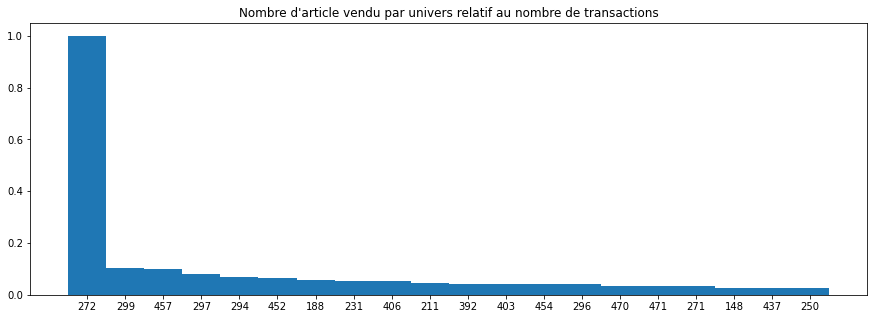

In [37]:
strat = time()
rec_article = {}
N = len(tabac_transactions)

for t in tabac_transactions:
    for art in set(t):
        if not str(art) in rec_article.keys():
            rec_article[str(art)] = 0
        rec_article[str(art)]+=1

for k in rec_article.keys():
    rec_article[k]/= N

print("Time Taken to load recurence: ~" + str(int(time() - start)) + "secondes") 

fig = plt.figure(figsize=(15, 5))

rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

nbr_univ = len(rec_article.keys())

plt.bar(list(rec_article.keys())[:min(20, nbr_univ)]
            ,list(rec_article.values())[:min(20, nbr_univ)],1)
        
plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")
    
# if save_fig:
#     plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
plt.show()

In [38]:
start = time()

univ_transactions = {i:[] for i in all_univ}
univ_CA           = {i:0  for i in all_univ}
univ_CA_sans_univ = {i:0  for i in all_univ}

actual_key_ticket = -1        
art_trans  = []
CA_trans   = {}
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    rec_lig  = item[2]

    if actual_key_ticket != key_tic:  
        for k in CA_trans.keys():
            univ_transactions[k].append(tuple(art_trans))
            univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
            
        actual_key_ticket = key_tic
        art_trans  = []
        CA_trans   = {}

        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
        
    art_trans.append(int(key_univ))
    if not key_univ in CA_trans.keys():
        CA_trans[key_univ] = 0
    CA_trans[key_univ] += rec_lig
    univ_CA[key_univ] += rec_lig

    
for k in art_trans:
    univ_transactions[k].append(tuple(art_trans))
    univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
    univ_CA[k] += CA_trans[k]

# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes")    

Time Taken to load transaction: ~65secondes


==============1===================


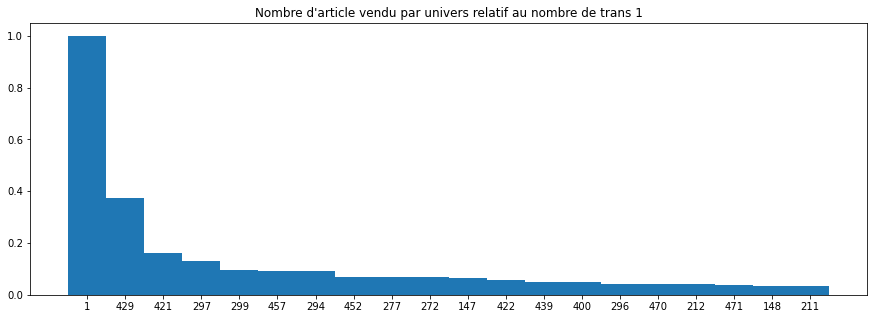

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 7.56)
("Nombre moyen d'univ", 1.49)
('CA univ', 15219.4)
('CA moyen univ', 44.24)
('Nombre moyen article en plus', 4.72)
('CA en plus', 19930.19)
('CA moyen en plus', 57.94)
==============2===================


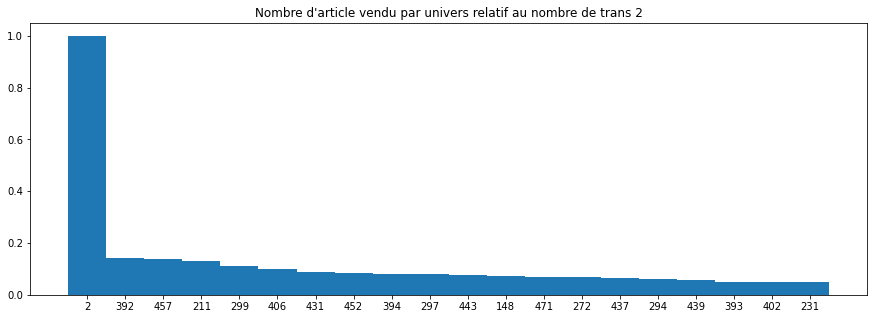

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 6.73)
("Nombre moyen d'univ", 1.18)
('CA univ', 2086.22)
('CA moyen univ', 4.26)
('Nombre moyen article en plus', 3.87)
('CA en plus', 5820.49)
('CA moyen en plus', 11.88)
==============4===================


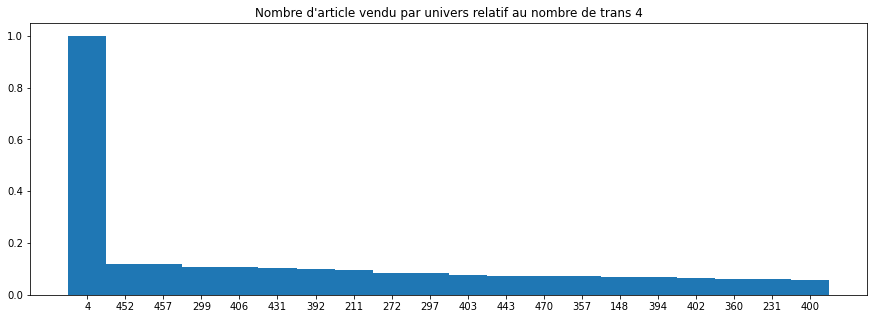

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 8.1)
("Nombre moyen d'univ", 1.13)
('CA univ', 6063.38)
('CA moyen univ', 4.42)
('Nombre moyen article en plus', 5.44)
('CA en plus', 21312.72)
('CA moyen en plus', 15.55)
==============5===================


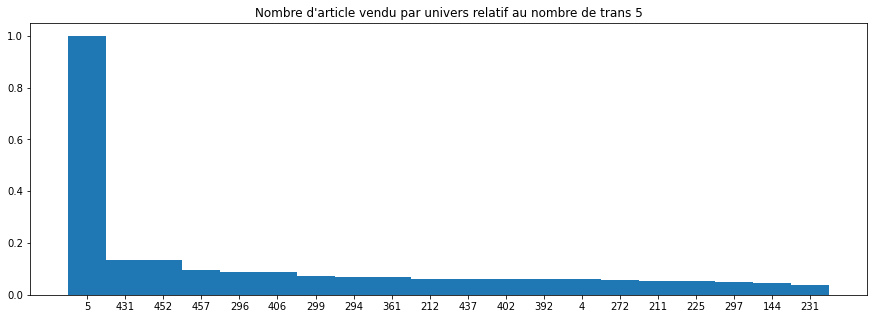

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 11.85)
("Nombre moyen d'univ", 1.74)
('CA univ', 3340.29)
('CA moyen univ', 6.0)
('Nombre moyen article en plus', 3.3)
('CA en plus', 6052.82)
('CA moyen en plus', 10.87)
==============7===================
NOT ENOUGH DATA 
==============9===================


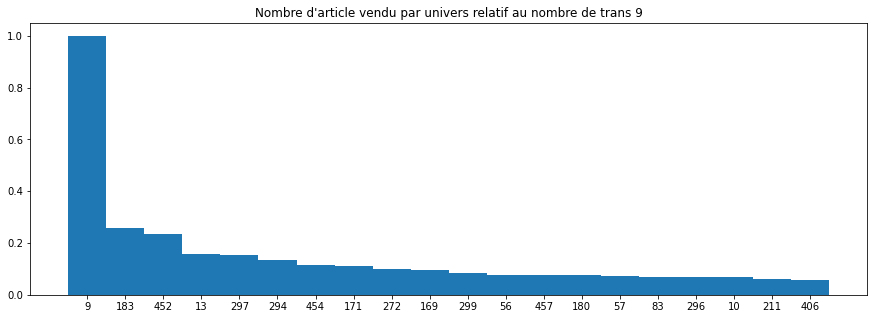

("Proportion d'achat (%)", 0.41)
('Proportion achat seul (%)', 5.34)
("Nombre moyen d'univ", 1.16)
('CA univ', 35999.54)
('CA moyen univ', 2.32)
('Nombre moyen article en plus', 8.15)
('CA en plus', 443768.09)
('CA moyen en plus', 28.59)
==============10===================


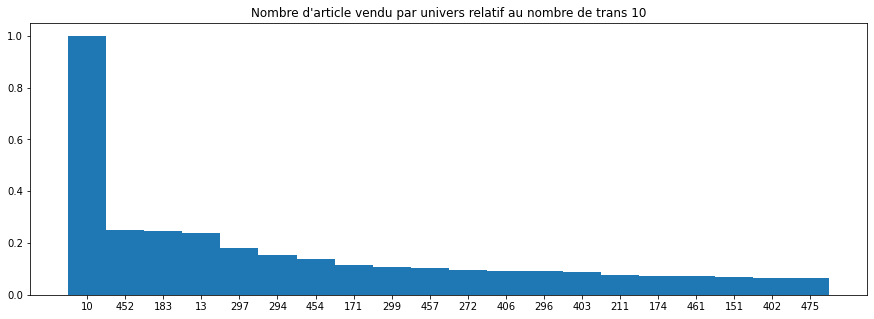

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 1.46)
("Nombre moyen d'univ", 1.18)
('CA univ', 41855.02)
('CA moyen univ', 2.46)
('Nombre moyen article en plus', 8.95)
('CA en plus', 536611.47)
('CA moyen en plus', 31.59)
==============12===================


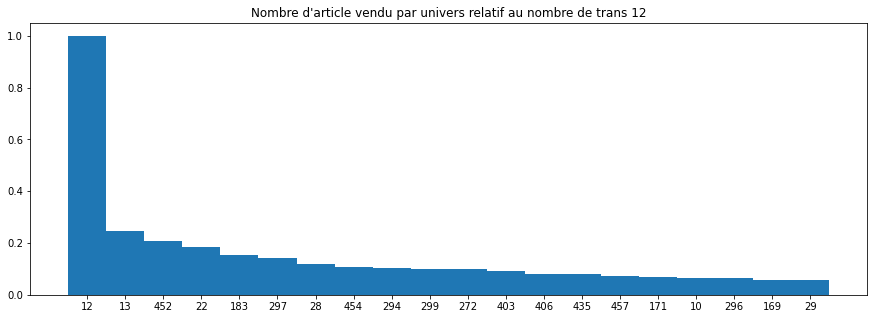

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.57)
("Nombre moyen d'univ", 1.18)
('CA univ', 3711.8)
('CA moyen univ', 4.14)
('Nombre moyen article en plus', 7.63)
('CA en plus', 26218.0)
('CA moyen en plus', 29.23)
==============13===================


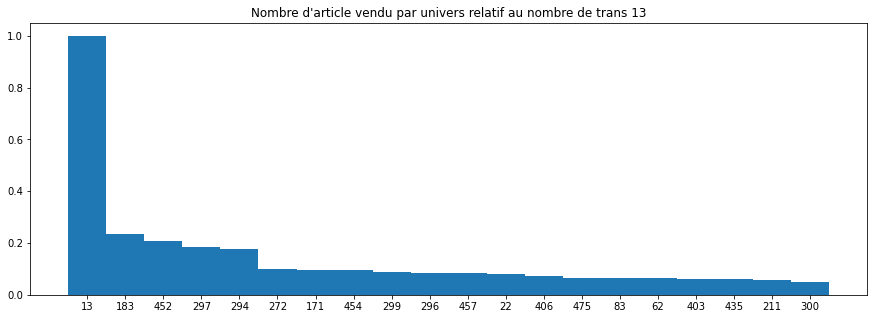

("Proportion d'achat (%)", 2.12)
('Proportion achat seul (%)', 4.58)
("Nombre moyen d'univ", 1.17)
('CA univ', 259225.98)
('CA moyen univ', 3.22)
('Nombre moyen article en plus', 7.17)
('CA en plus', 2068087.37)
('CA moyen en plus', 25.73)
==============14===================
NOT ENOUGH DATA 
==============16===================


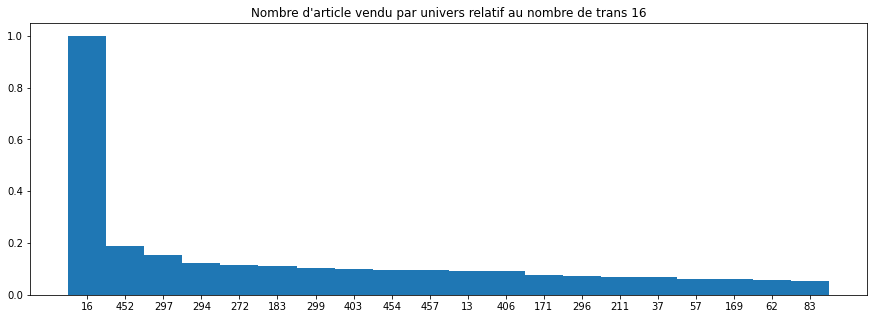

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 5.97)
("Nombre moyen d'univ", 1.18)
('CA univ', 10225.39)
('CA moyen univ', 2.76)
('Nombre moyen article en plus', 7.23)
('CA en plus', 97401.8)
('CA moyen en plus', 26.32)
==============17===================


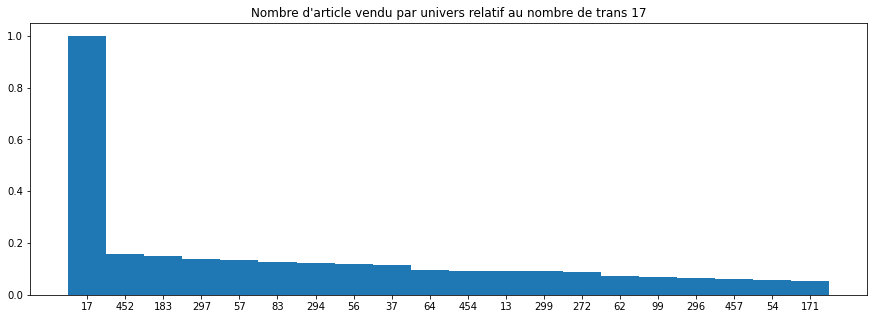

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 11.59)
("Nombre moyen d'univ", 1.27)
('CA univ', 14217.36)
('CA moyen univ', 3.12)
('Nombre moyen article en plus', 6.25)
('CA en plus', 125931.11)
('CA moyen en plus', 27.64)
==============18===================


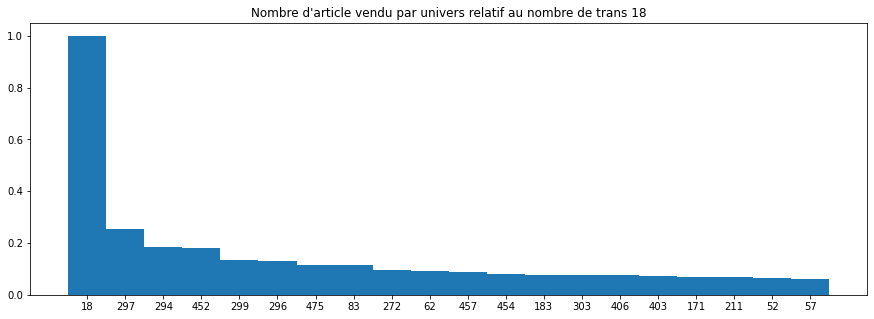

("Proportion d'achat (%)", 1.12)
('Proportion achat seul (%)', 6.14)
("Nombre moyen d'univ", 1.11)
('CA univ', 153982.42)
('CA moyen univ', 3.61)
('Nombre moyen article en plus', 7.42)
('CA en plus', 1075123.38)
('CA moyen en plus', 25.22)
==============19===================


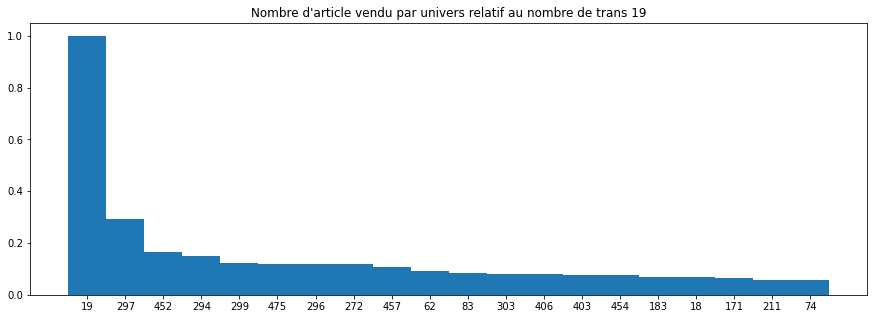

("Proportion d'achat (%)", 0.31)
('Proportion achat seul (%)', 6.89)
("Nombre moyen d'univ", 1.07)
('CA univ', 29176.92)
('CA moyen univ', 2.47)
('Nombre moyen article en plus', 6.92)
('CA en plus', 278490.87)
('CA moyen en plus', 23.61)
==============20===================


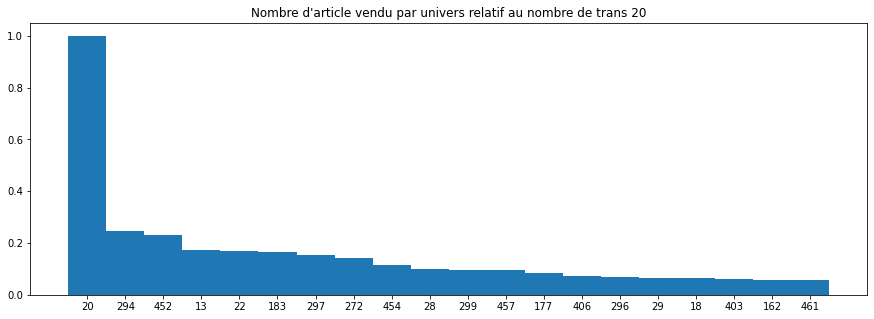

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 6.22)
("Nombre moyen d'univ", 1.11)
('CA univ', 3912.58)
('CA moyen univ', 3.33)
('Nombre moyen article en plus', 8.16)
('CA en plus', 37756.32)
('CA moyen en plus', 32.16)
==============21===================


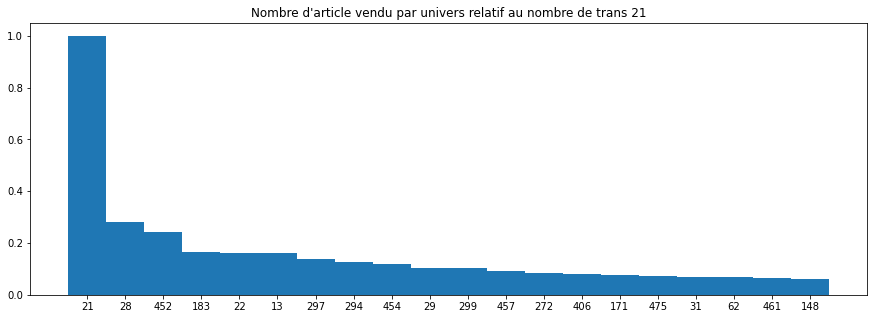

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 3.55)
("Nombre moyen d'univ", 1.36)
('CA univ', 6402.68)
('CA moyen univ', 8.73)
('Nombre moyen article en plus', 8.65)
('CA en plus', 24139.3)
('CA moyen en plus', 32.93)
==============22===================


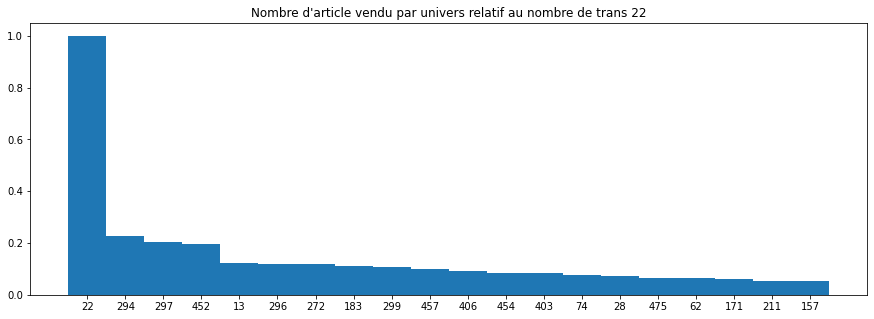

("Proportion d'achat (%)", 1.37)
('Proportion achat seul (%)', 3.84)
("Nombre moyen d'univ", 1.22)
('CA univ', 385591.89)
('CA moyen univ', 7.42)
('Nombre moyen article en plus', 7.22)
('CA en plus', 1323591.51)
('CA moyen en plus', 25.46)
==============23===================


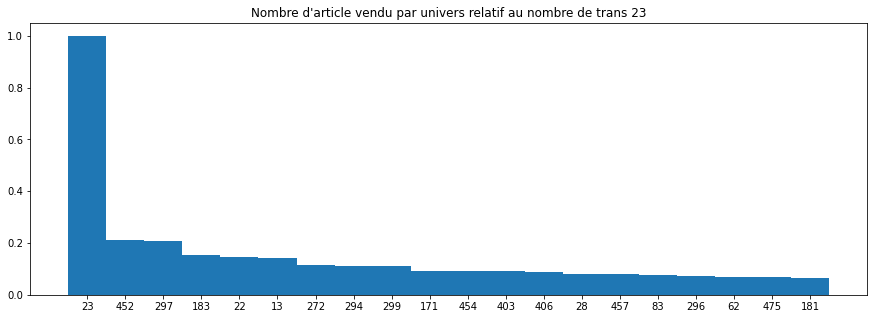

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.45)
("Nombre moyen d'univ", 1.11)
('CA univ', 16769.3)
('CA moyen univ', 9.63)
('Nombre moyen article en plus', 8.63)
('CA en plus', 55751.25)
('CA moyen en plus', 32.02)
==============24===================


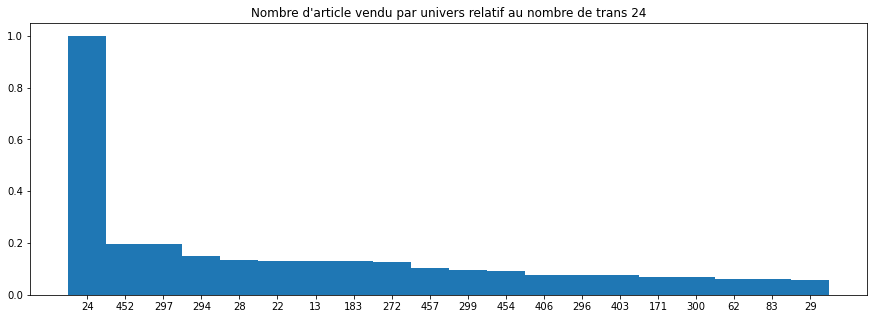

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 3.92)
("Nombre moyen d'univ", 1.14)
('CA univ', 26565.32)
('CA moyen univ', 5.37)
('Nombre moyen article en plus', 7.6)
('CA en plus', 134832.27)
('CA moyen en plus', 27.27)
==============25===================


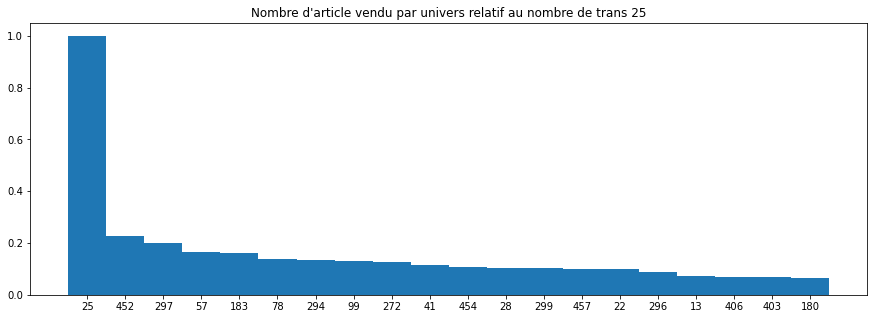

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 4.41)
("Nombre moyen d'univ", 1.22)
('CA univ', 64550.59)
('CA moyen univ', 6.62)
('Nombre moyen article en plus', 7.66)
('CA en plus', 260595.77)
('CA moyen en plus', 26.71)
==============27===================


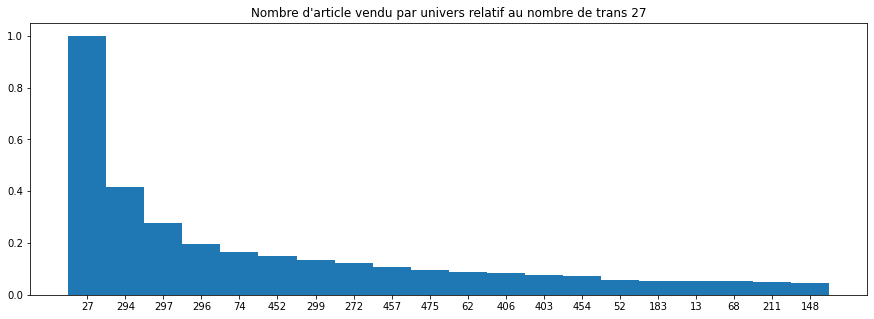

("Proportion d'achat (%)", 0.77)
('Proportion achat seul (%)', 2.1)
("Nombre moyen d'univ", 1.07)
('CA univ', 92854.38)
('CA moyen univ', 3.16)
('Nombre moyen article en plus', 6.6)
('CA en plus', 629992.19)
('CA moyen en plus', 21.46)
==============28===================


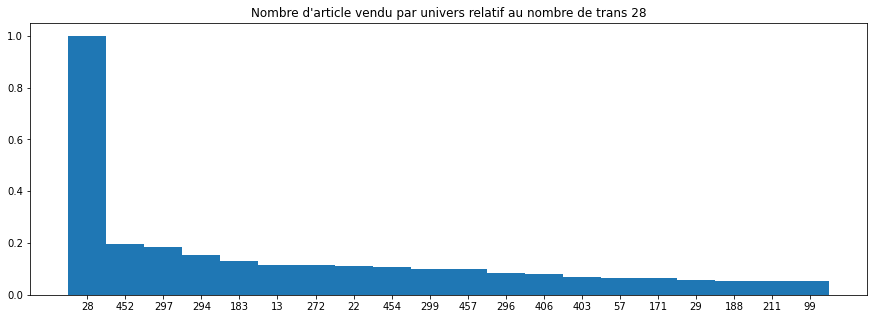

("Proportion d'achat (%)", 0.9)
('Proportion achat seul (%)', 4.78)
("Nombre moyen d'univ", 1.32)
('CA univ', 207071.0)
('CA moyen univ', 6.07)
('Nombre moyen article en plus', 7.06)
('CA en plus', 863133.17)
('CA moyen en plus', 25.29)
==============29===================


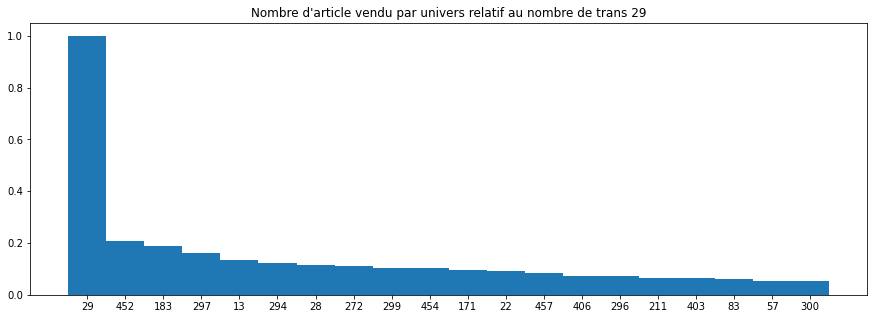

("Proportion d'achat (%)", 0.44)
('Proportion achat seul (%)', 4.79)
("Nombre moyen d'univ", 1.46)
('CA univ', 107460.25)
('CA moyen univ', 6.43)
('Nombre moyen article en plus', 7.45)
('CA en plus', 443716.35)
('CA moyen en plus', 26.56)
==============30===================
NOT ENOUGH DATA 
==============31===================


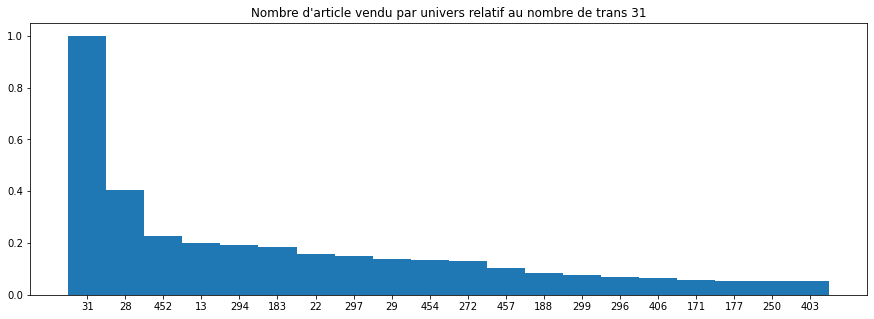

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 2.44)
("Nombre moyen d'univ", 1.24)
('CA univ', 27857.31)
('CA moyen univ', 8.7)
('Nombre moyen article en plus', 8.04)
('CA en plus', 100926.43)
('CA moyen en plus', 31.52)
==============34===================


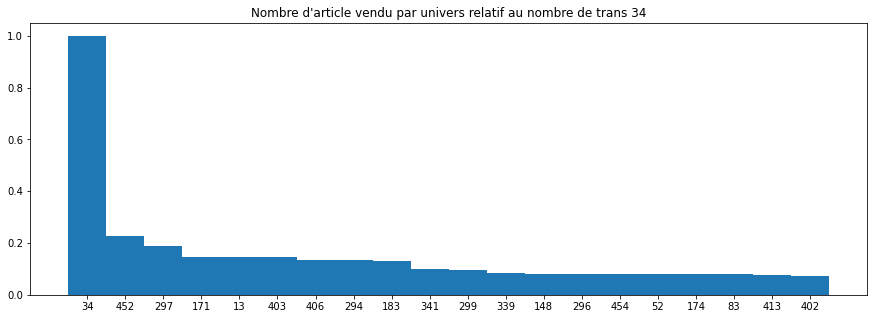

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.21)
("Nombre moyen d'univ", 1.12)
('CA univ', 4139.21)
('CA moyen univ', 7.62)
('Nombre moyen article en plus', 9.02)
('CA en plus', 20921.64)
('CA moyen en plus', 38.53)
==============35===================


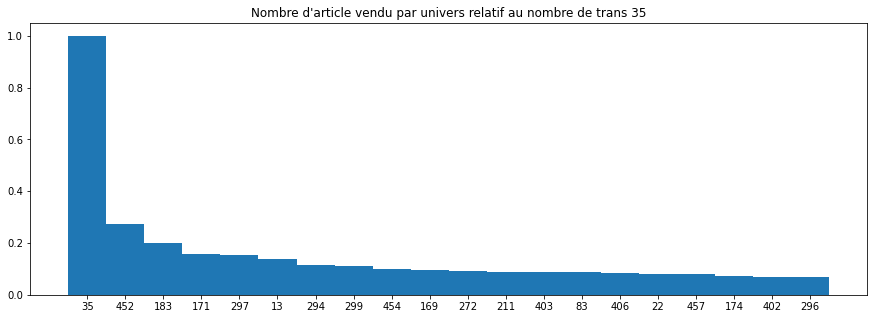

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 3.76)
("Nombre moyen d'univ", 1.31)
('CA univ', 35091.68)
('CA moyen univ', 12.46)
('Nombre moyen article en plus', 9.03)
('CA en plus', 94240.48)
('CA moyen en plus', 33.47)
==============36===================
NOT ENOUGH DATA 
==============37===================


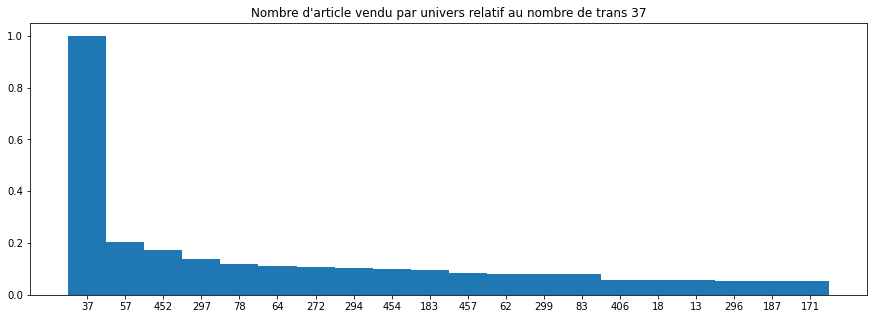

("Proportion d'achat (%)", 0.82)
('Proportion achat seul (%)', 8.56)
("Nombre moyen d'univ", 1.28)
('CA univ', 94727.87)
('CA moyen univ', 3.04)
('Nombre moyen article en plus', 6.31)
('CA en plus', 692173.17)
('CA moyen en plus', 22.23)
==============38===================


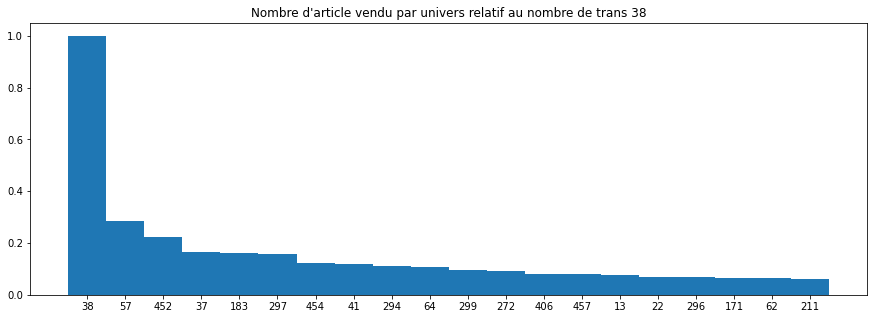

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 3.66)
("Nombre moyen d'univ", 1.43)
('CA univ', 7327.69)
('CA moyen univ', 3.08)
('Nombre moyen article en plus', 7.61)
('CA en plus', 64939.97)
('CA moyen en plus', 27.32)
==============39===================


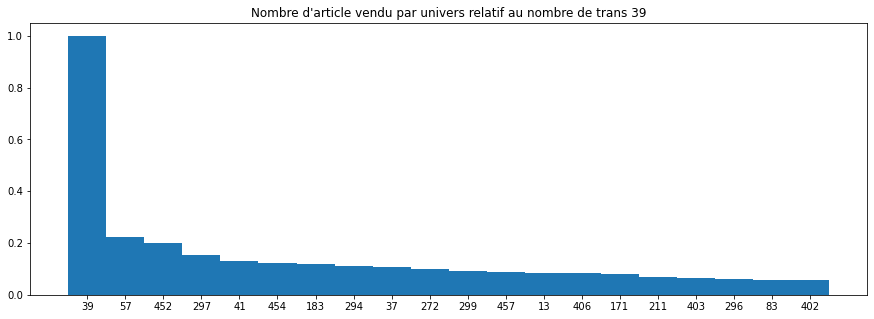

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 4.49)
("Nombre moyen d'univ", 1.41)
('CA univ', 53629.5)
('CA moyen univ', 5.16)
('Nombre moyen article en plus', 7.3)
('CA en plus', 271042.48)
('CA moyen en plus', 26.07)
==============41===================


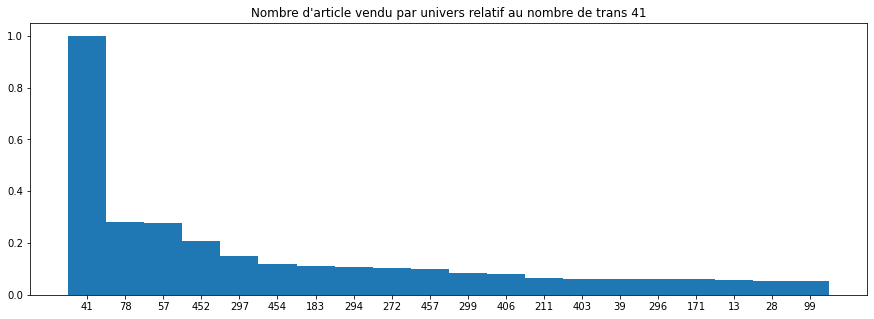

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 4.71)
("Nombre moyen d'univ", 1.22)
('CA univ', 101801.96)
('CA moyen univ', 4.57)
('Nombre moyen article en plus', 7.14)
('CA en plus', 550277.08)
('CA moyen en plus', 24.68)
==============42===================


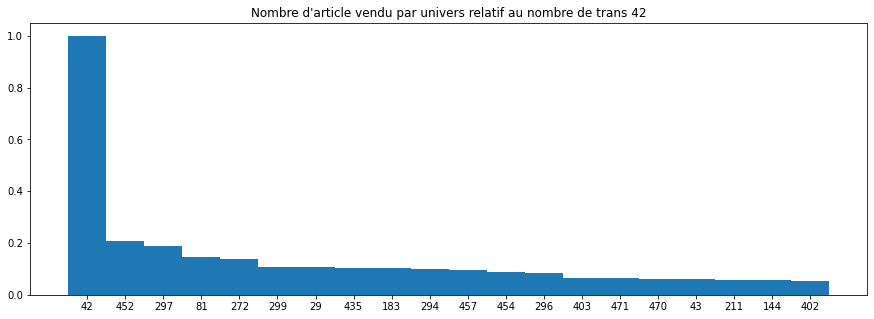

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 8.13)
("Nombre moyen d'univ", 1.11)
('CA univ', 1573.12)
('CA moyen univ', 4.26)
('Nombre moyen article en plus', 6.46)
('CA en plus', 8821.25)
('CA moyen en plus', 23.91)
==============43===================


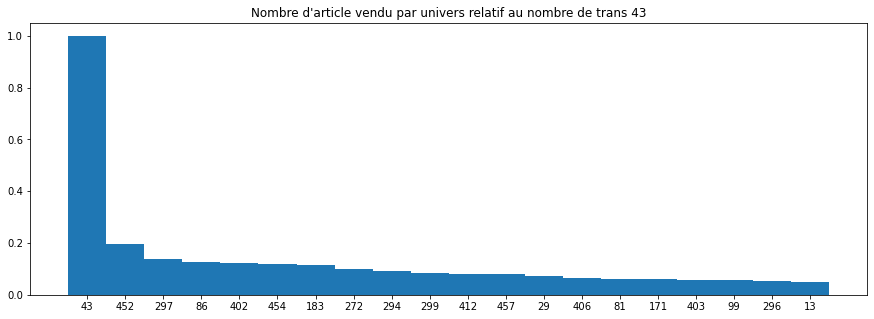

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 8.35)
("Nombre moyen d'univ", 1.22)
('CA univ', 18773.07)
('CA moyen univ', 3.72)
('Nombre moyen article en plus', 6.77)
('CA en plus', 129175.73)
('CA moyen en plus', 25.63)
==============44===================


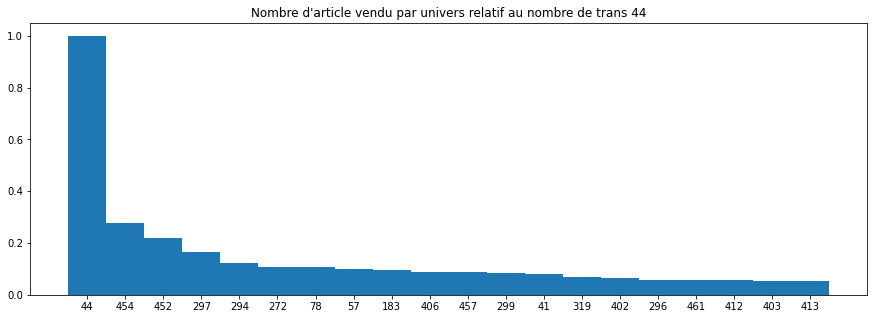

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 3.12)
("Nombre moyen d'univ", 1.12)
('CA univ', 9298.86)
('CA moyen univ', 5.69)
('Nombre moyen article en plus', 7.54)
('CA en plus', 44699.3)
('CA moyen en plus', 27.37)
==============45===================


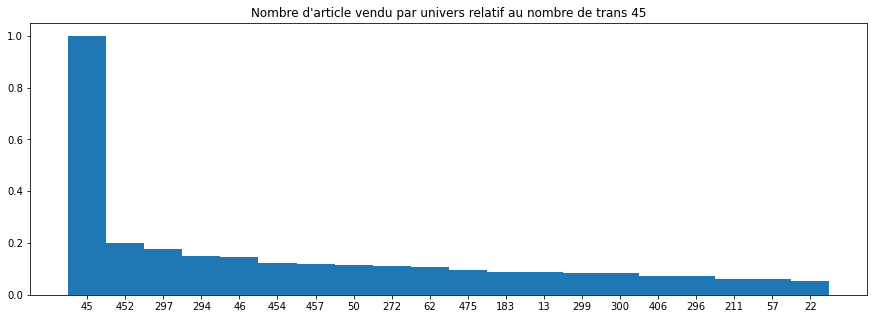

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 7.26)
("Nombre moyen d'univ", 1.03)
('CA univ', 16503.68)
('CA moyen univ', 3.07)
('Nombre moyen article en plus', 7.1)
('CA en plus', 135333.41)
('CA moyen en plus', 25.14)
==============46===================


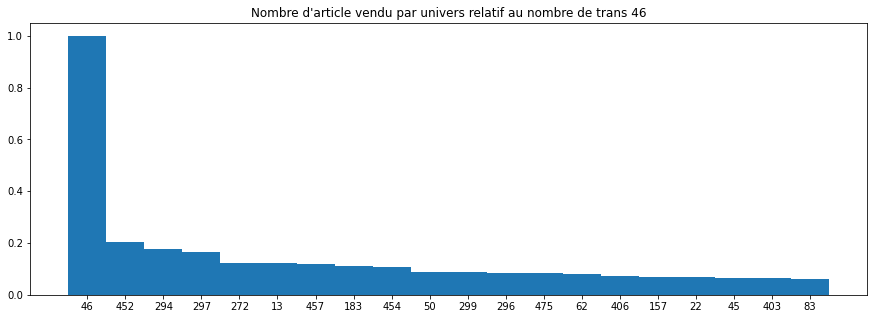

("Proportion d'achat (%)", 0.32)
('Proportion achat seul (%)', 6.38)
("Nombre moyen d'univ", 1.04)
('CA univ', 43005.19)
('CA moyen univ', 3.55)
('Nombre moyen article en plus', 7.24)
('CA en plus', 308530.22)
('CA moyen en plus', 25.5)
==============47===================


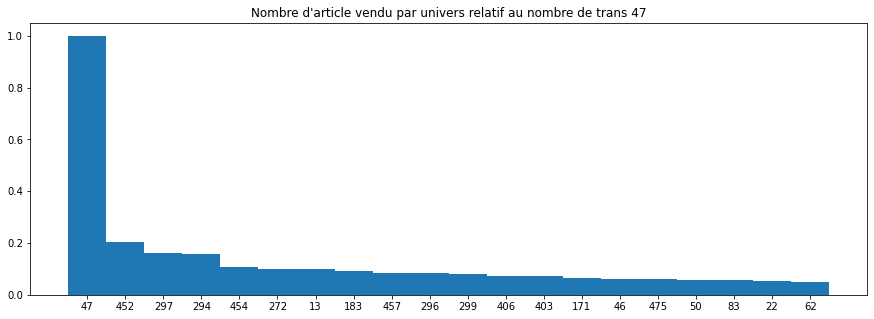

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 7.3)
("Nombre moyen d'univ", 1.09)
('CA univ', 14293.86)
('CA moyen univ', 3.28)
('Nombre moyen article en plus', 7.5)
('CA en plus', 121525.54)
('CA moyen en plus', 27.9)
==============48===================


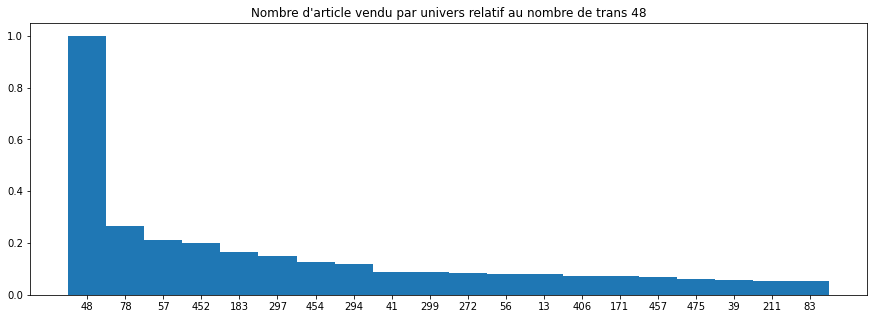

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 5.78)
("Nombre moyen d'univ", 1.07)
('CA univ', 8281.79)
('CA moyen univ', 4.06)
('Nombre moyen article en plus', 6.79)
('CA en plus', 46382.25)
('CA moyen en plus', 22.74)
==============49===================


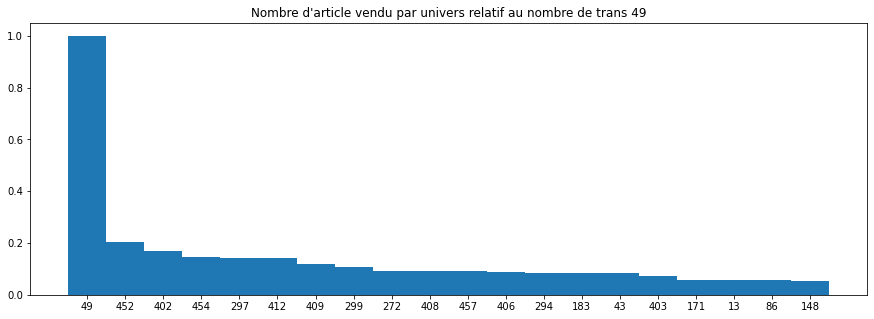

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 8.27)
("Nombre moyen d'univ", 1.11)
('CA univ', 12038.52)
('CA moyen univ', 4.22)
('Nombre moyen article en plus', 7.3)
('CA en plus', 85925.6)
('CA moyen en plus', 30.13)
==============50===================


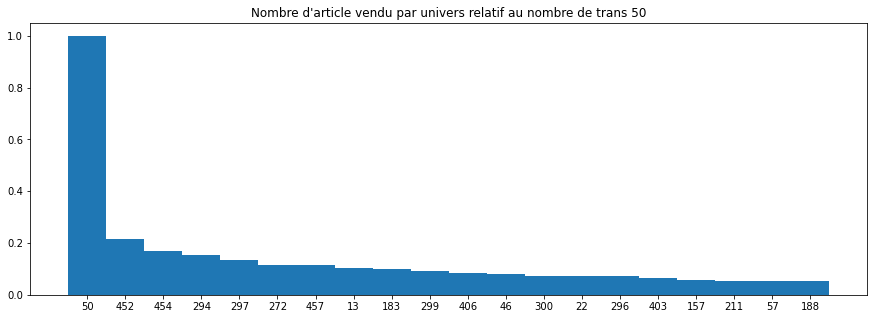

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 5.45)
("Nombre moyen d'univ", 1.15)
('CA univ', 48508.98)
('CA moyen univ', 3.67)
('Nombre moyen article en plus', 7.23)
('CA en plus', 346773.07)
('CA moyen en plus', 26.23)
==============51===================


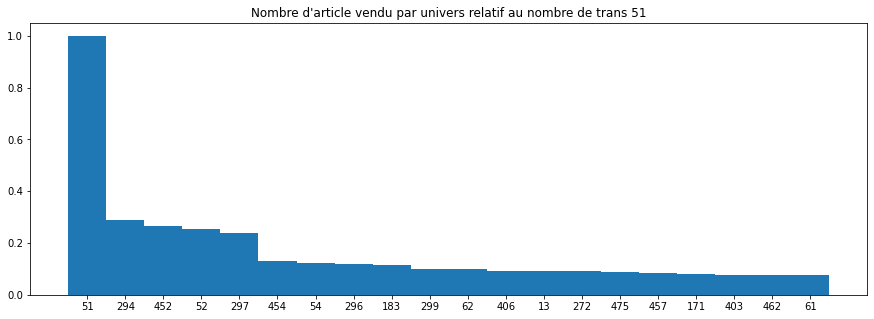

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 0.94)
("Nombre moyen d'univ", 1.06)
('CA univ', 19573.8)
('CA moyen univ', 4.7)
('Nombre moyen article en plus', 8.91)
('CA en plus', 133207.12)
('CA moyen en plus', 32.01)
==============52===================


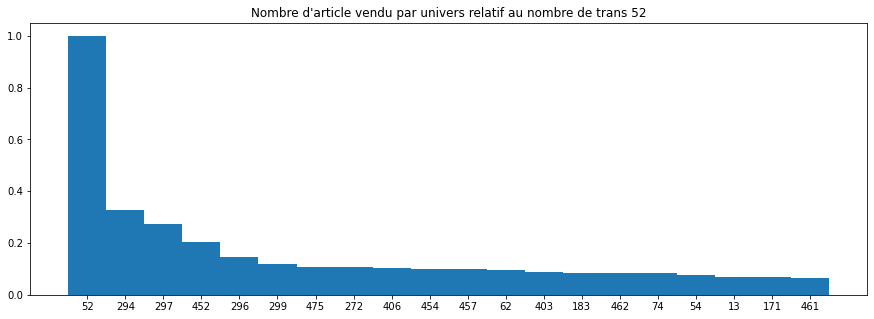

("Proportion d'achat (%)", 1.16)
('Proportion achat seul (%)', 1.4)
("Nombre moyen d'univ", 1.15)
('CA univ', 212069.12)
('CA moyen univ', 4.81)
('Nombre moyen article en plus', 7.97)
('CA en plus', 1242192.92)
('CA moyen en plus', 28.18)
==============53===================


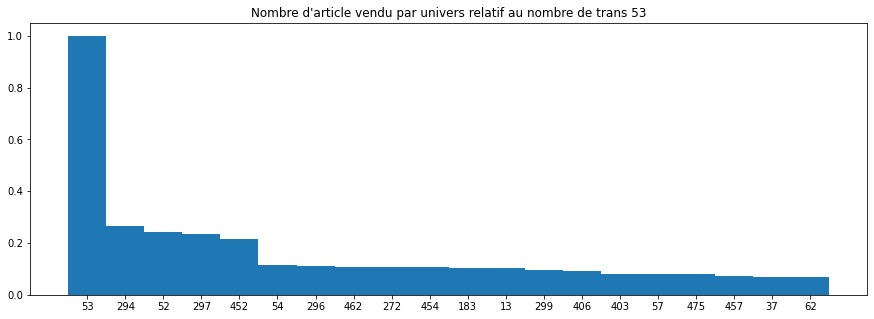

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 1.85)
("Nombre moyen d'univ", 1.04)
('CA univ', 21916.51)
('CA moyen univ', 4.23)
('Nombre moyen article en plus', 8.46)
('CA en plus', 162415.11)
('CA moyen en plus', 31.36)
==============54===================


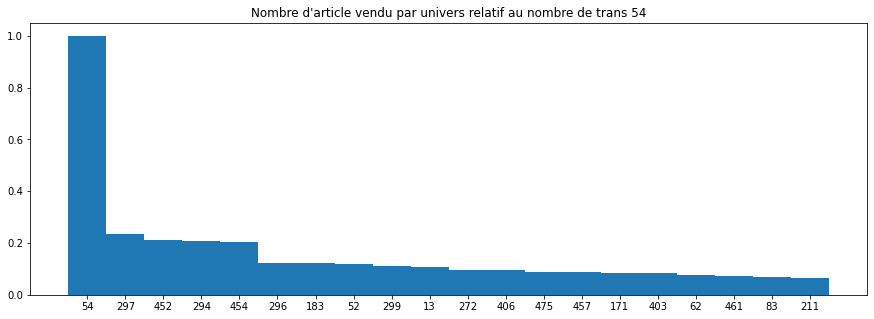

("Proportion d'achat (%)", 0.75)
('Proportion achat seul (%)', 1.44)
("Nombre moyen d'univ", 1.12)
('CA univ', 115047.96)
('CA moyen univ', 4.03)
('Nombre moyen article en plus', 8.35)
('CA en plus', 842208.01)
('CA moyen en plus', 29.5)
==============55===================


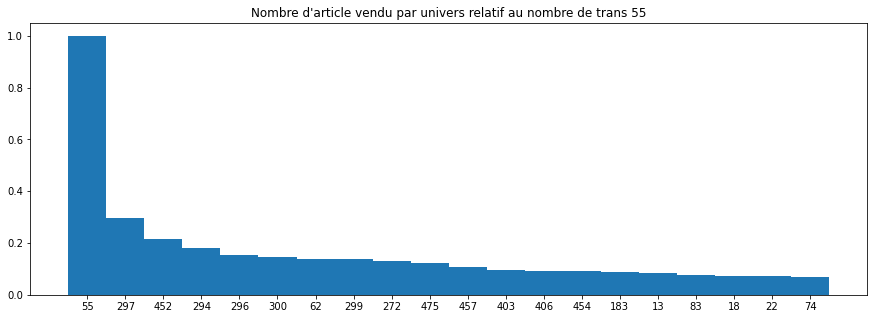

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 2.38)
("Nombre moyen d'univ", 1.1)
('CA univ', 39626.02)
('CA moyen univ', 3.95)
('Nombre moyen article en plus', 8.47)
('CA en plus', 293895.92)
('CA moyen en plus', 29.31)
==============56===================


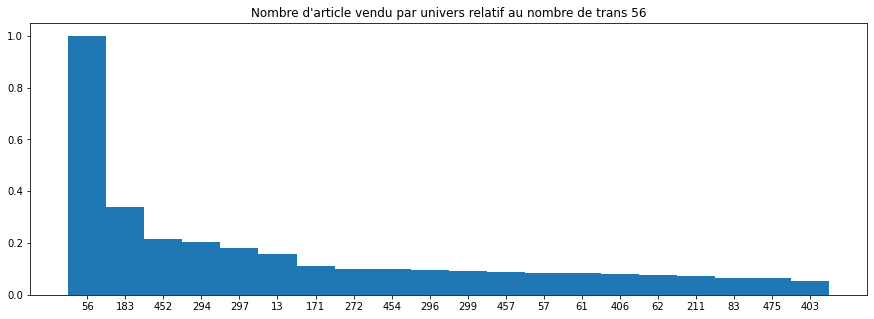

("Proportion d'achat (%)", 0.6)
('Proportion achat seul (%)', 3.24)
("Nombre moyen d'univ", 1.34)
('CA univ', 79108.12)
('CA moyen univ', 3.47)
('Nombre moyen article en plus', 7.83)
('CA en plus', 606054.09)
('CA moyen en plus', 26.6)
==============57===================


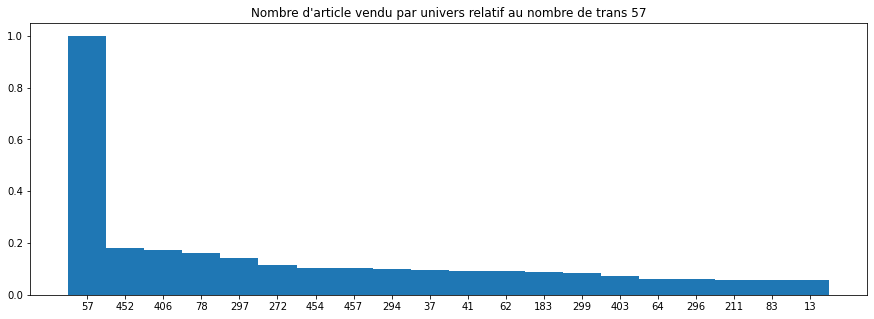

("Proportion d'achat (%)", 1.77)
('Proportion achat seul (%)', 6.61)
("Nombre moyen d'univ", 1.18)
('CA univ', 308715.1)
('CA moyen univ', 4.6)
('Nombre moyen article en plus', 6.56)
('CA en plus', 1589225.64)
('CA moyen en plus', 23.67)
==============58===================


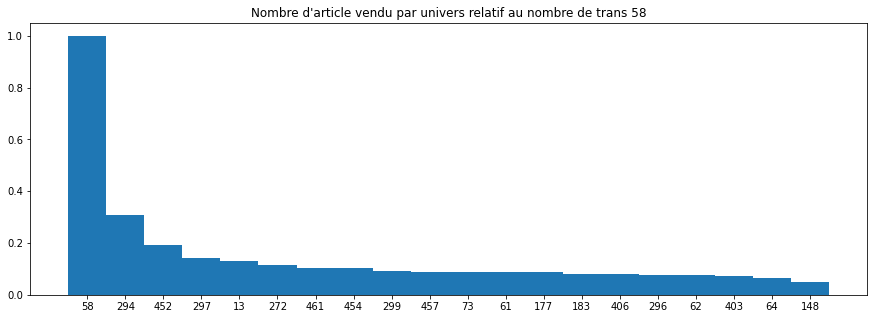

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 7.83)
("Nombre moyen d'univ", 1.39)
('CA univ', 35771.95)
('CA moyen univ', 9.69)
('Nombre moyen article en plus', 6.91)
('CA en plus', 92887.24)
('CA moyen en plus', 25.17)
==============59===================


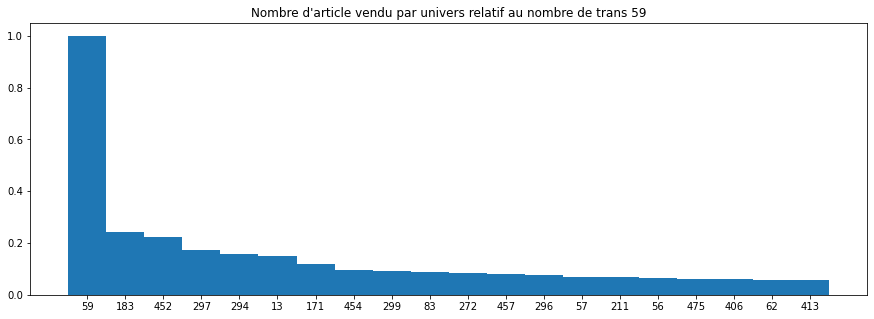

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 4.46)
("Nombre moyen d'univ", 1.15)
('CA univ', 57470.19)
('CA moyen univ', 4.34)
('Nombre moyen article en plus', 7.77)
('CA en plus', 350877.88)
('CA moyen en plus', 26.47)
==============60===================


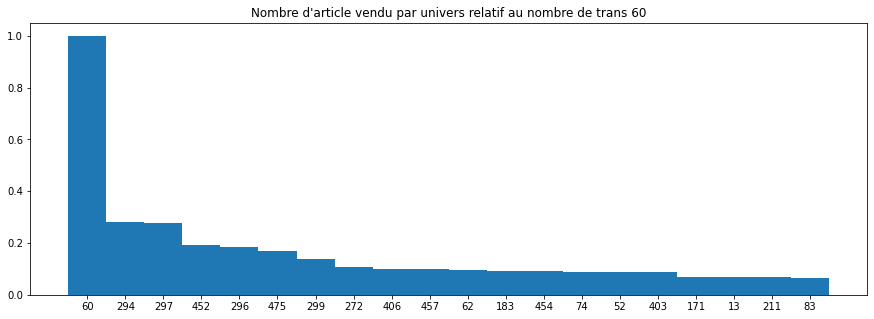

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 1.36)
("Nombre moyen d'univ", 1.1)
('CA univ', 56791.9)
('CA moyen univ', 3.47)
('Nombre moyen article en plus', 7.88)
('CA en plus', 437552.24)
('CA moyen en plus', 26.73)
==============61===================


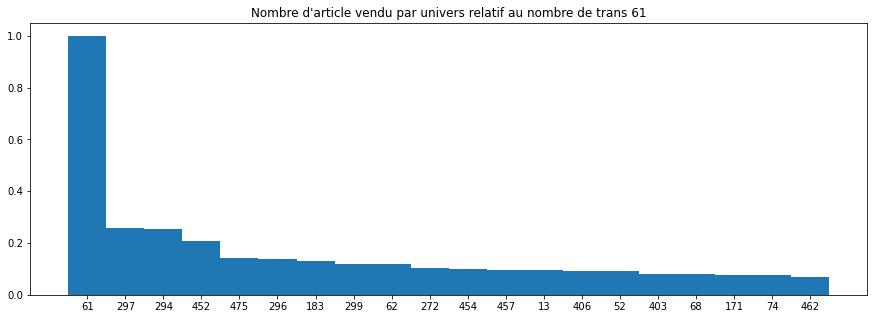

("Proportion d'achat (%)", 0.76)
('Proportion achat seul (%)', 1.6)
("Nombre moyen d'univ", 1.11)
('CA univ', 124066.31)
('CA moyen univ', 4.31)
('Nombre moyen article en plus', 8.24)
('CA en plus', 826247.46)
('CA moyen en plus', 28.7)
==============62===================


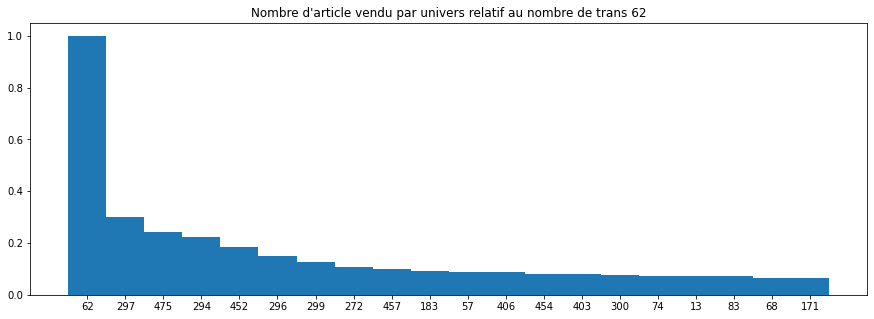

("Proportion d'achat (%)", 1.83)
('Proportion achat seul (%)', 2.57)
("Nombre moyen d'univ", 1.13)
('CA univ', 273210.34)
('CA moyen univ', 3.92)
('Nombre moyen article en plus', 7.44)
('CA en plus', 1755538.89)
('CA moyen en plus', 25.21)
==============63===================


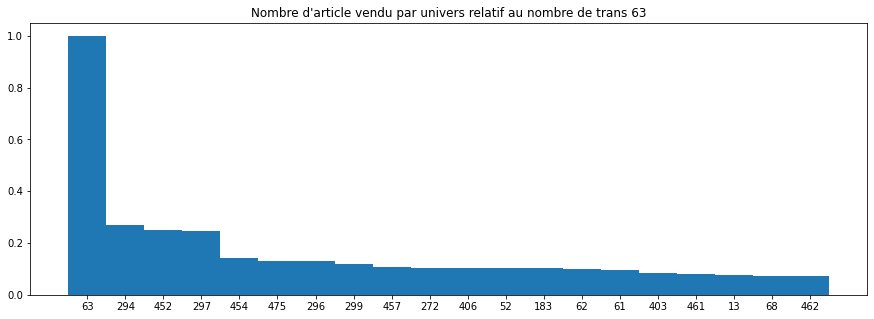

("Proportion d'achat (%)", 0.24)
('Proportion achat seul (%)', 1.13)
("Nombre moyen d'univ", 1.1)
('CA univ', 56952.29)
('CA moyen univ', 6.35)
('Nombre moyen article en plus', 8.81)
('CA en plus', 298439.2)
('CA moyen en plus', 33.25)
==============64===================


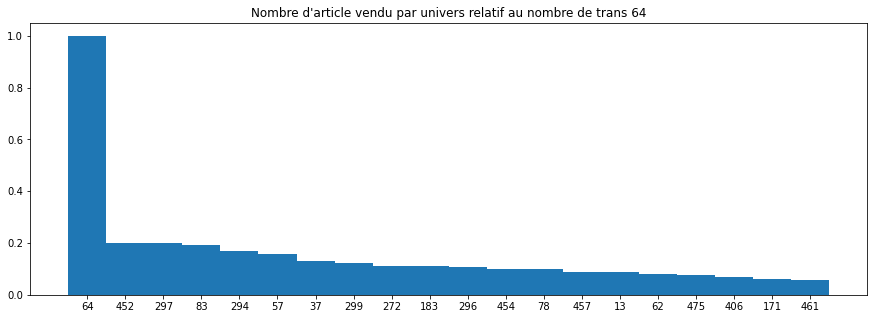

("Proportion d'achat (%)", 0.7)
('Proportion achat seul (%)', 3.91)
("Nombre moyen d'univ", 1.19)
('CA univ', 113216.08)
('CA moyen univ', 4.25)
('Nombre moyen article en plus', 7.38)
('CA en plus', 697825.94)
('CA moyen en plus', 26.2)
==============65===================


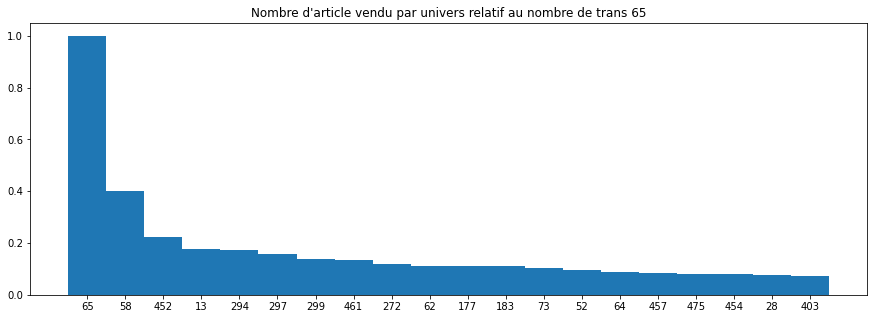

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.31)
("Nombre moyen d'univ", 1.13)
('CA univ', 1986.18)
('CA moyen univ', 6.51)
('Nombre moyen article en plus', 8.53)
('CA en plus', 10766.0)
('CA moyen en plus', 35.3)
==============66===================


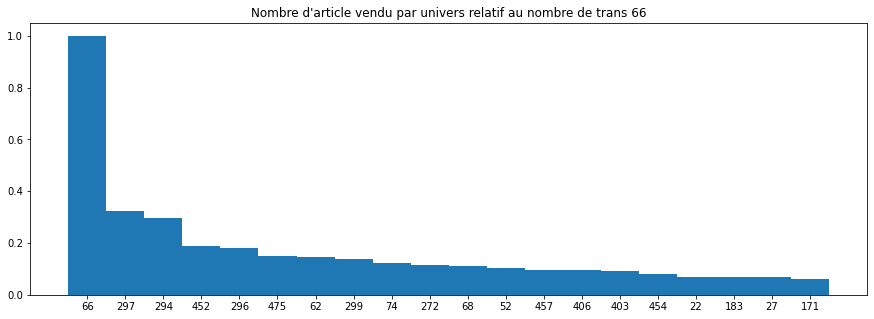

("Proportion d'achat (%)", 0.3)
('Proportion achat seul (%)', 1.17)
("Nombre moyen d'univ", 1.04)
('CA univ', 30348.95)
('CA moyen univ', 2.68)
('Nombre moyen article en plus', 7.82)
('CA en plus', 299289.95)
('CA moyen en plus', 26.39)
==============67===================


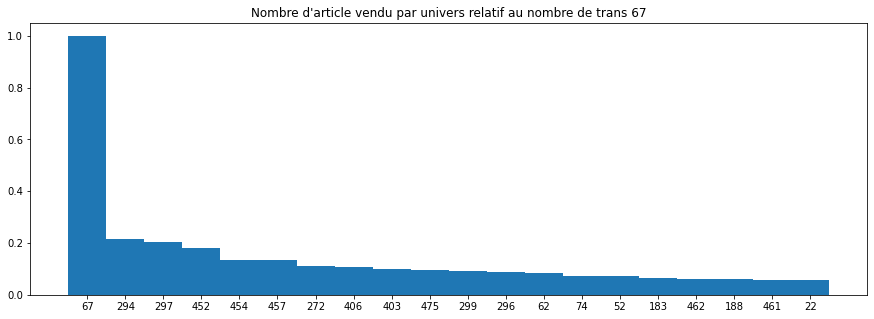

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 2.28)
("Nombre moyen d'univ", 1.05)
('CA univ', 25012.53)
('CA moyen univ', 4.02)
('Nombre moyen article en plus', 7.07)
('CA en plus', 159865.28)
('CA moyen en plus', 25.68)
==============68===================


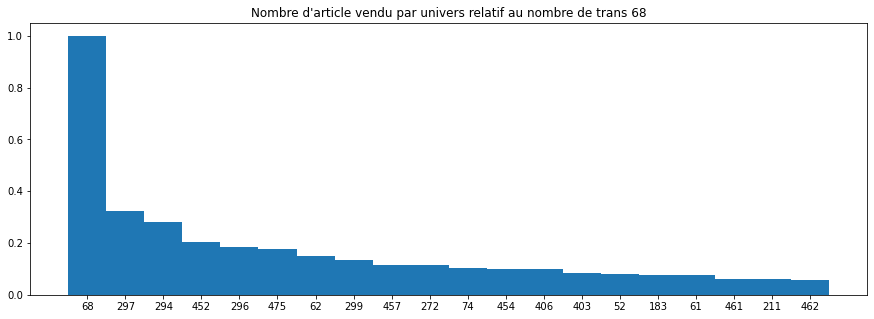

("Proportion d'achat (%)", 0.81)
('Proportion achat seul (%)', 1.14)
("Nombre moyen d'univ", 1.06)
('CA univ', 102986.36)
('CA moyen univ', 3.33)
('Nombre moyen article en plus', 7.86)
('CA en plus', 814802.22)
('CA moyen en plus', 26.35)
==============69===================


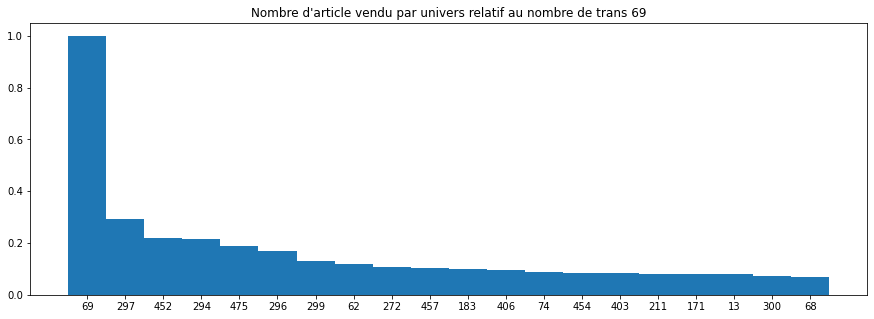

("Proportion d'achat (%)", 0.65)
('Proportion achat seul (%)', 1.71)
("Nombre moyen d'univ", 1.12)
('CA univ', 89725.7)
('CA moyen univ', 3.62)
('Nombre moyen article en plus', 7.79)
('CA en plus', 635723.69)
('CA moyen en plus', 25.66)
==============70===================


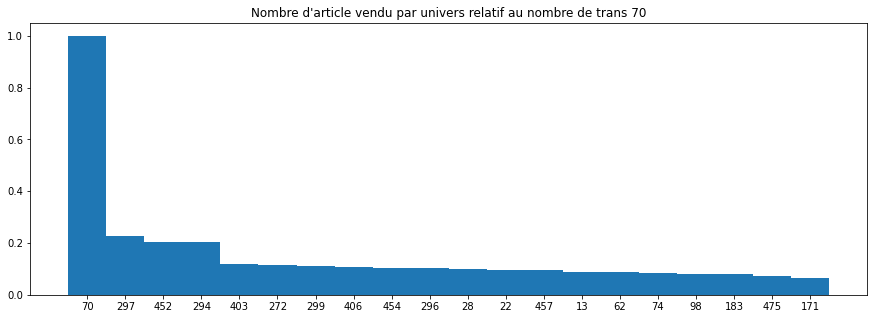

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 2.91)
("Nombre moyen d'univ", 1.16)
('CA univ', 21281.78)
('CA moyen univ', 5.2)
('Nombre moyen article en plus', 8.16)
('CA en plus', 124576.36)
('CA moyen en plus', 30.41)
==============72===================


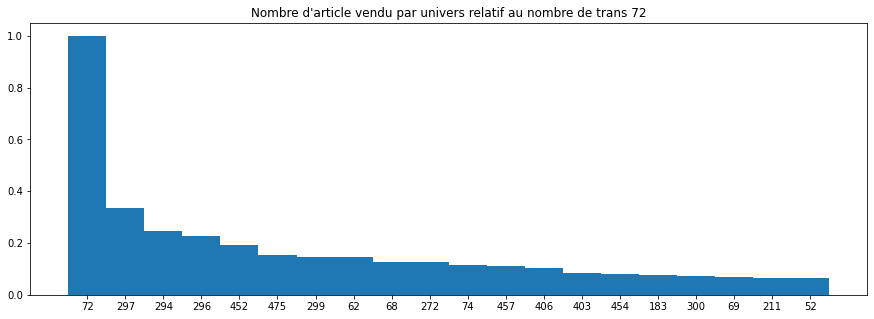

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 1.43)
("Nombre moyen d'univ", 1.07)
('CA univ', 28029.97)
('CA moyen univ', 2.14)
('Nombre moyen article en plus', 7.74)
('CA en plus', 334740.56)
('CA moyen en plus', 25.51)
==============73===================


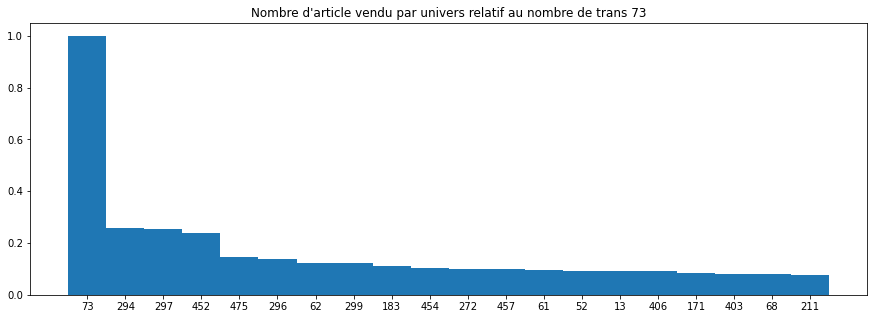

("Proportion d'achat (%)", 0.41)
('Proportion achat seul (%)', 1.08)
("Nombre moyen d'univ", 1.12)
('CA univ', 70819.65)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 8.59)
('CA en plus', 470384.8)
('CA moyen en plus', 30.18)
==============74===================


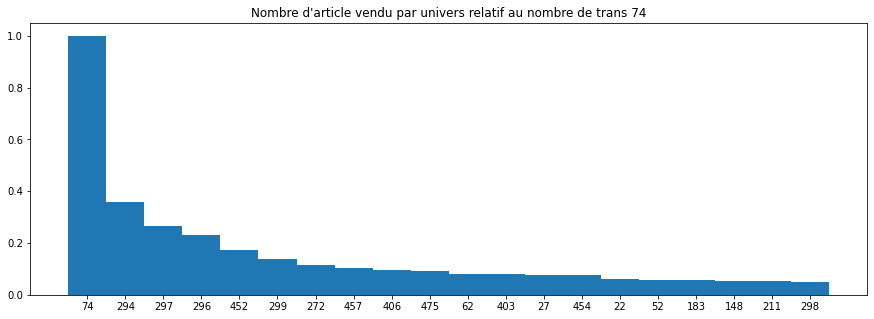

("Proportion d'achat (%)", 1.7)
('Proportion achat seul (%)', 1.93)
("Nombre moyen d'univ", 1.29)
('CA univ', 276820.81)
('CA moyen univ', 4.3)
('Nombre moyen article en plus', 6.66)
('CA en plus', 1394313.79)
('CA moyen en plus', 21.64)
==============75===================


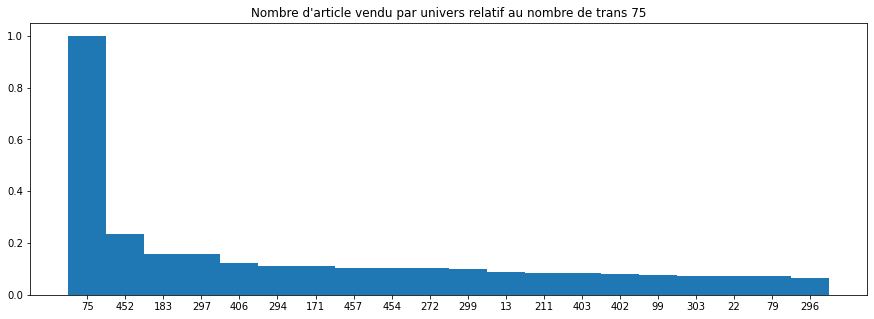

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.86)
("Nombre moyen d'univ", 1.17)
('CA univ', 1469.35)
('CA moyen univ', 3.5)
('Nombre moyen article en plus', 8.95)
('CA en plus', 13026.33)
('CA moyen en plus', 31.02)
==============76===================


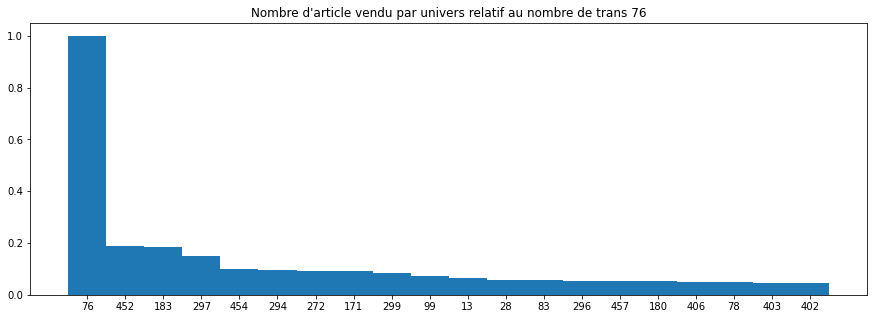

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 12.87)
("Nombre moyen d'univ", 1.07)
('CA univ', 7051.56)
('CA moyen univ', 5.04)
('Nombre moyen article en plus', 6.91)
('CA en plus', 34596.81)
('CA moyen en plus', 24.73)
==============77===================


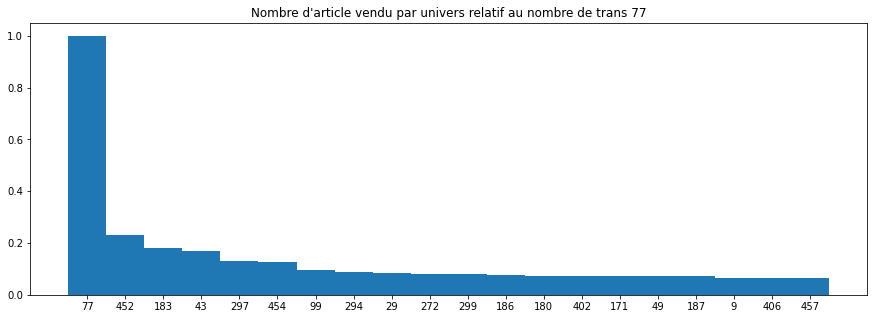

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.96)
("Nombre moyen d'univ", 1.18)
('CA univ', 3197.92)
('CA moyen univ', 3.97)
('Nombre moyen article en plus', 7.21)
('CA en plus', 20380.81)
('CA moyen en plus', 25.32)
==============78===================


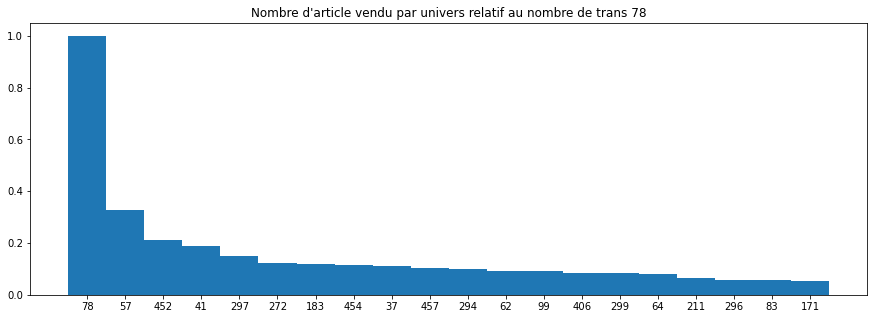

("Proportion d'achat (%)", 0.87)
('Proportion achat seul (%)', 5.45)
("Nombre moyen d'univ", 1.22)
('CA univ', 100630.83)
('CA moyen univ', 3.04)
('Nombre moyen article en plus', 7.06)
('CA en plus', 822969.16)
('CA moyen en plus', 24.85)
==============79===================


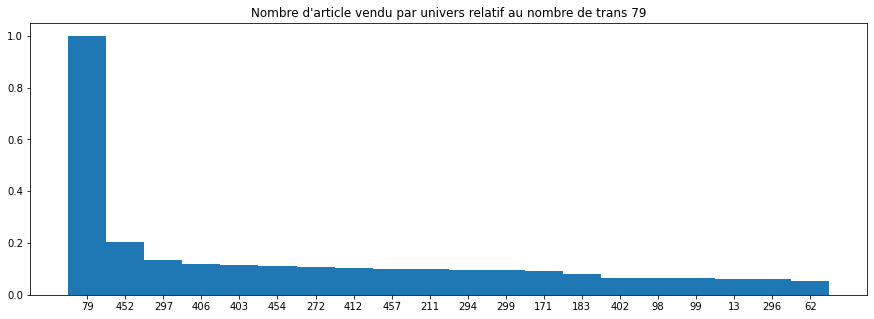

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 3.85)
("Nombre moyen d'univ", 1.26)
('CA univ', 13532.52)
('CA moyen univ', 3.89)
('Nombre moyen article en plus', 7.32)
('CA en plus', 94090.52)
('CA moyen en plus', 27.02)
==============80===================


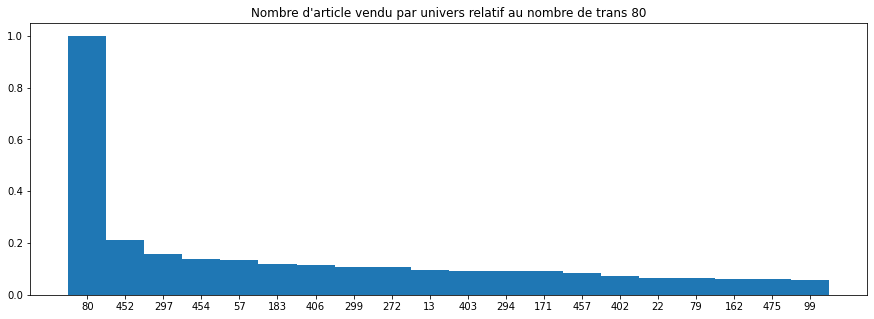

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 3.19)
("Nombre moyen d'univ", 1.19)
('CA univ', 4680.01)
('CA moyen univ', 5.14)
('Nombre moyen article en plus', 8.65)
('CA en plus', 29352.38)
('CA moyen en plus', 32.26)
==============81===================


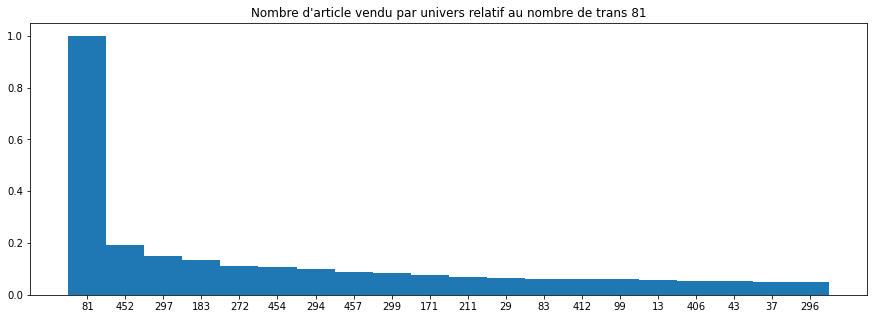

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 9.11)
("Nombre moyen d'univ", 1.09)
('CA univ', 22764.63)
('CA moyen univ', 3.9)
('Nombre moyen article en plus', 6.92)
('CA en plus', 146013.79)
('CA moyen en plus', 25.0)
==============82===================
NOT ENOUGH DATA 
==============83===================


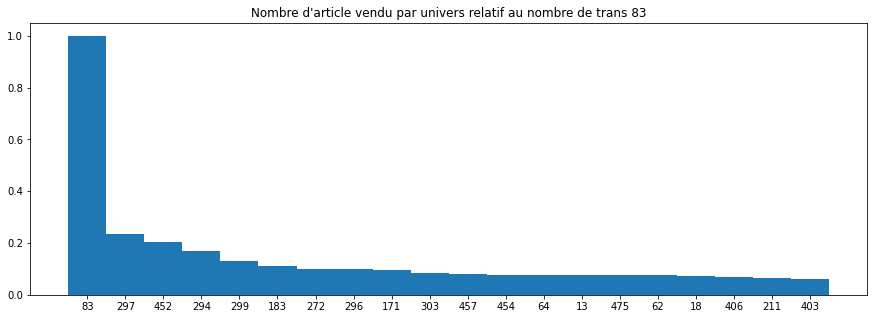

("Proportion d'achat (%)", 1.75)
('Proportion achat seul (%)', 7.21)
("Nombre moyen d'univ", 1.15)
('CA univ', 233372.68)
('CA moyen univ', 3.5)
('Nombre moyen article en plus', 6.99)
('CA en plus', 1571148.01)
('CA moyen en plus', 23.59)
==============84===================


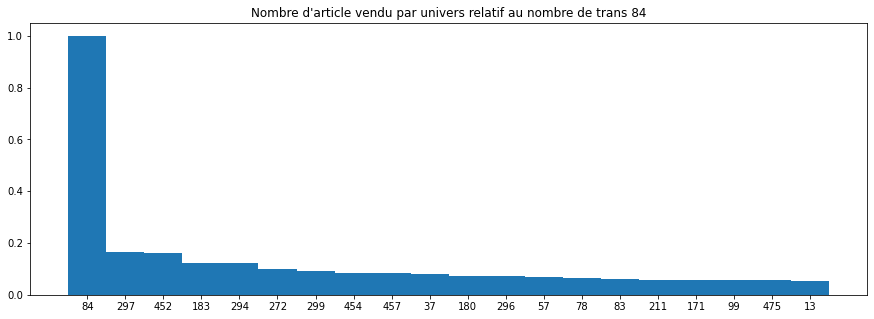

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 9.6)
("Nombre moyen d'univ", 1.16)
('CA univ', 8911.74)
('CA moyen univ', 3.55)
('Nombre moyen article en plus', 6.69)
('CA en plus', 56486.92)
('CA moyen en plus', 22.5)
==============85===================


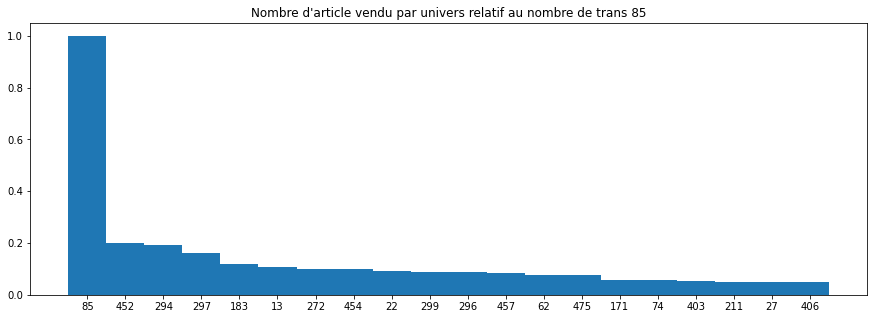

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 6.47)
("Nombre moyen d'univ", 1.17)
('CA univ', 13672.01)
('CA moyen univ', 3.8)
('Nombre moyen article en plus', 7.18)
('CA en plus', 91653.05)
('CA moyen en plus', 25.45)
==============86===================


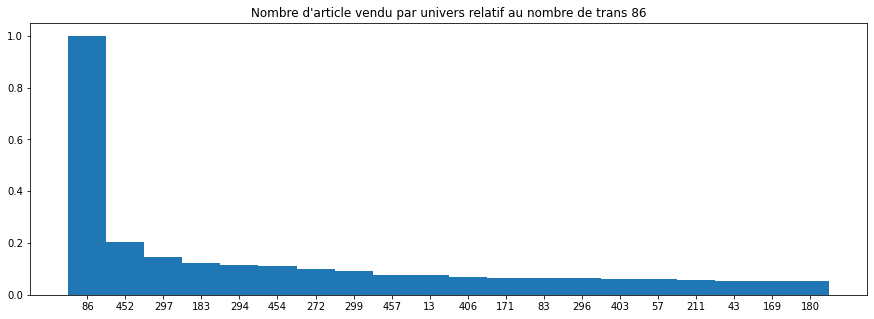

("Proportion d'achat (%)", 0.31)
('Proportion achat seul (%)', 8.53)
("Nombre moyen d'univ", 1.27)
('CA univ', 71116.51)
('CA moyen univ', 6.07)
('Nombre moyen article en plus', 7.37)
('CA en plus', 316944.43)
('CA moyen en plus', 27.06)
==============88===================


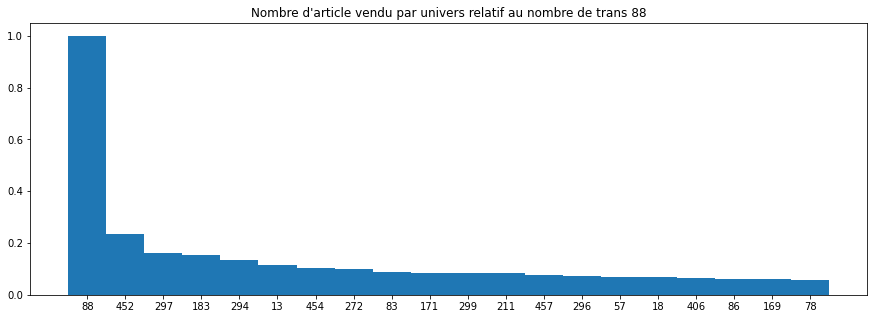

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 7.95)
("Nombre moyen d'univ", 1.05)
('CA univ', 40874.15)
('CA moyen univ', 8.31)
('Nombre moyen article en plus', 8.01)
('CA en plus', 144843.72)
('CA moyen en plus', 29.46)
==============89===================


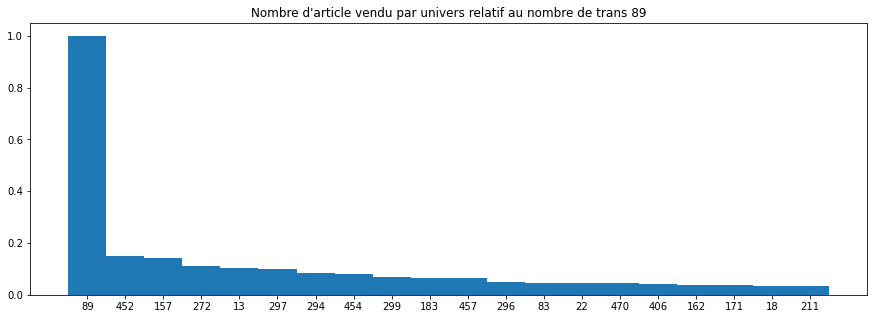

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 21.23)
("Nombre moyen d'univ", 1.26)
('CA univ', 12502.56)
('CA moyen univ', 9.83)
('Nombre moyen article en plus', 4.8)
('CA en plus', 22810.72)
('CA moyen en plus', 17.93)
==============90===================


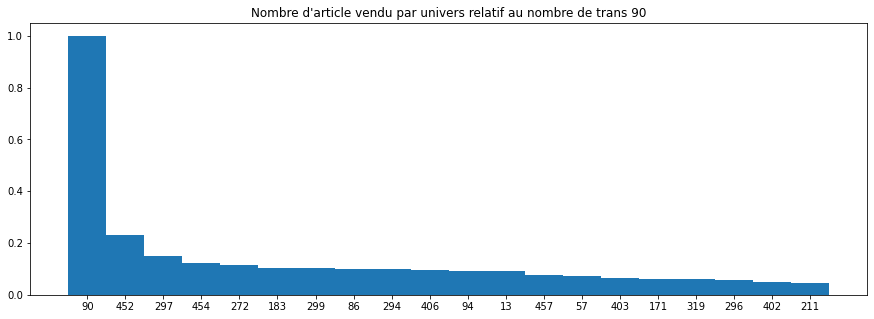

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 6.45)
("Nombre moyen d'univ", 1.28)
('CA univ', 22170.18)
('CA moyen univ', 11.82)
('Nombre moyen article en plus', 7.63)
('CA en plus', 58654.59)
('CA moyen en plus', 31.27)
==============91===================


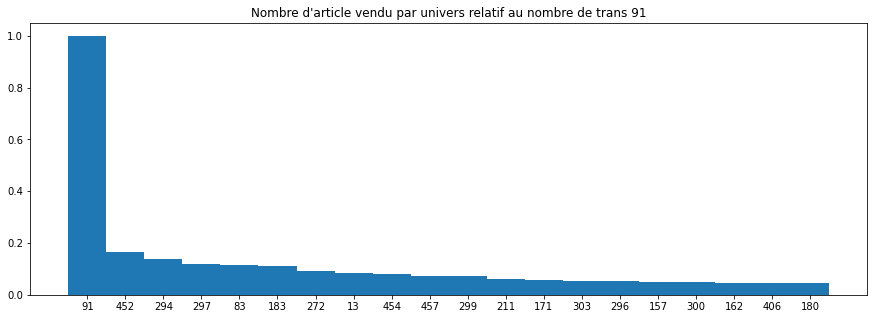

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 13.63)
("Nombre moyen d'univ", 1.08)
('CA univ', 11670.01)
('CA moyen univ', 5.36)
('Nombre moyen article en plus', 5.84)
('CA en plus', 44989.15)
('CA moyen en plus', 20.65)
==============92===================


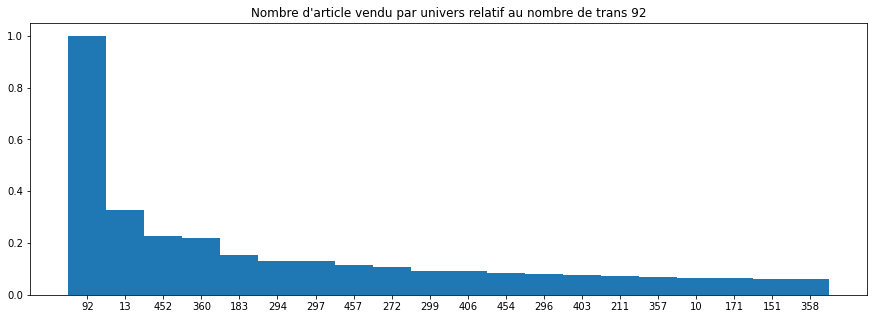

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 2.25)
("Nombre moyen d'univ", 1.17)
('CA univ', 11576.2)
('CA moyen univ', 2.07)
('Nombre moyen article en plus', 7.72)
('CA en plus', 156245.41)
('CA moyen en plus', 27.96)
==============93===================


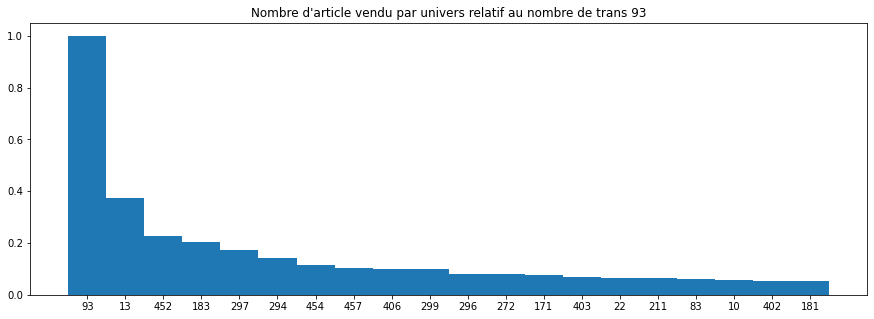

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 2.91)
("Nombre moyen d'univ", 1.08)
('CA univ', 12402.54)
('CA moyen univ', 5.81)
('Nombre moyen article en plus', 8.85)
('CA en plus', 69104.98)
('CA moyen en plus', 32.4)
==============94===================


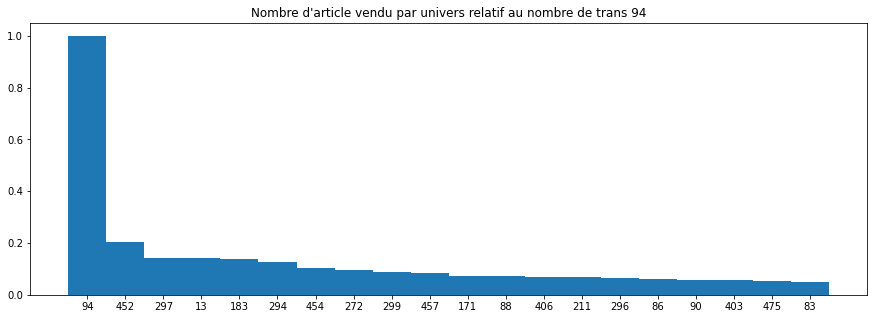

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 8.27)
("Nombre moyen d'univ", 1.1)
('CA univ', 12892.68)
('CA moyen univ', 4.3)
('Nombre moyen article en plus', 7.56)
('CA en plus', 83721.54)
('CA moyen en plus', 27.94)
==============95===================


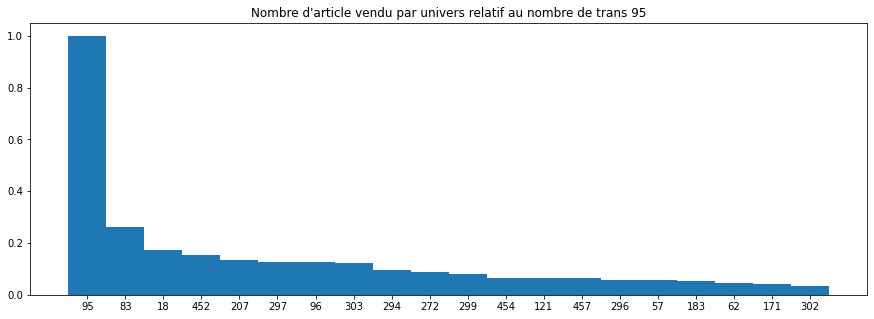

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 13.67)
("Nombre moyen d'univ", 1.09)
('CA univ', 8977.55)
('CA moyen univ', 2.04)
('Nombre moyen article en plus', 5.49)
('CA en plus', 78610.9)
('CA moyen en plus', 17.91)
==============96===================


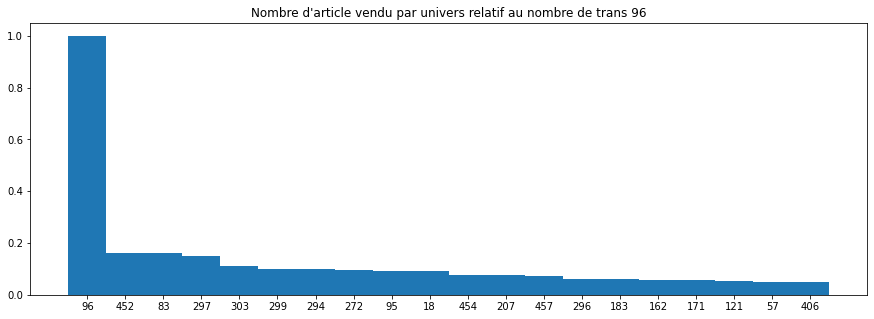

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 11.15)
("Nombre moyen d'univ", 1.16)
('CA univ', 16610.39)
('CA moyen univ', 2.78)
('Nombre moyen article en plus', 6.23)
('CA en plus', 126590.69)
('CA moyen en plus', 21.19)
==============98===================


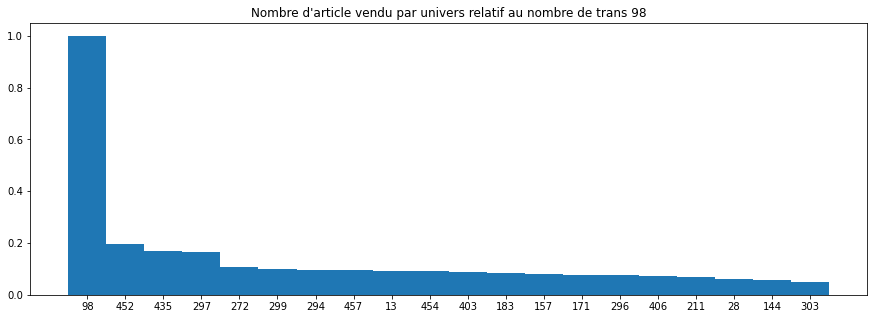

("Proportion d'achat (%)", 0.5)
('Proportion achat seul (%)', 5.88)
("Nombre moyen d'univ", 1.27)
('CA univ', 62862.49)
('CA moyen univ', 3.28)
('Nombre moyen article en plus', 7.0)
('CA en plus', 482165.27)
('CA moyen en plus', 25.15)
==============99===================


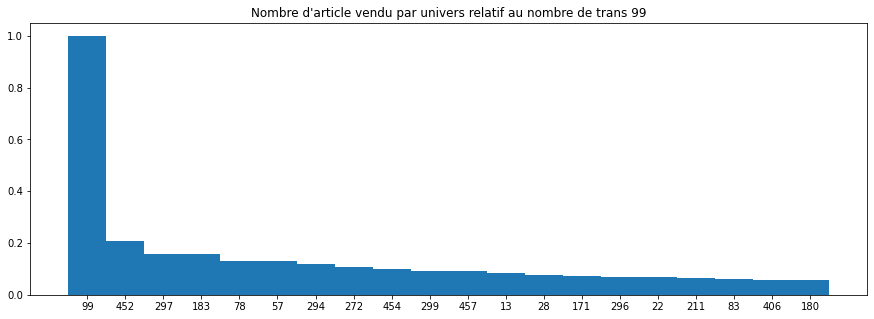

("Proportion d'achat (%)", 0.61)
('Proportion achat seul (%)', 6.61)
("Nombre moyen d'univ", 1.38)
('CA univ', 72154.07)
('CA moyen univ', 3.09)
('Nombre moyen article en plus', 7.13)
('CA en plus', 589972.23)
('CA moyen en plus', 25.28)
==============100===================


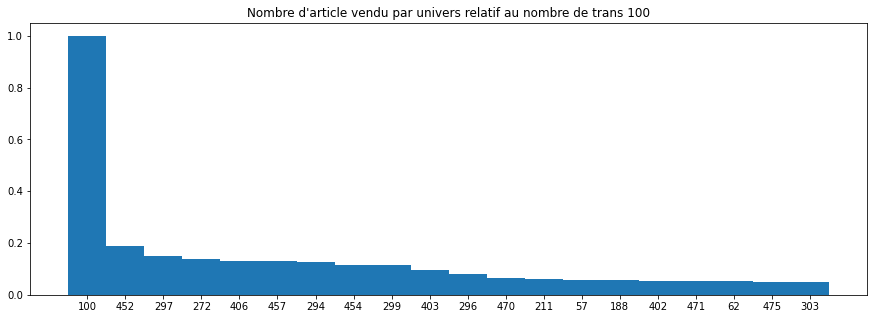

("Proportion d'achat (%)", 0.24)
('Proportion achat seul (%)', 6.41)
("Nombre moyen d'univ", 1.36)
('CA univ', 39215.07)
('CA moyen univ', 4.33)
('Nombre moyen article en plus', 6.37)
('CA en plus', 202703.57)
('CA moyen en plus', 22.37)
==============101===================


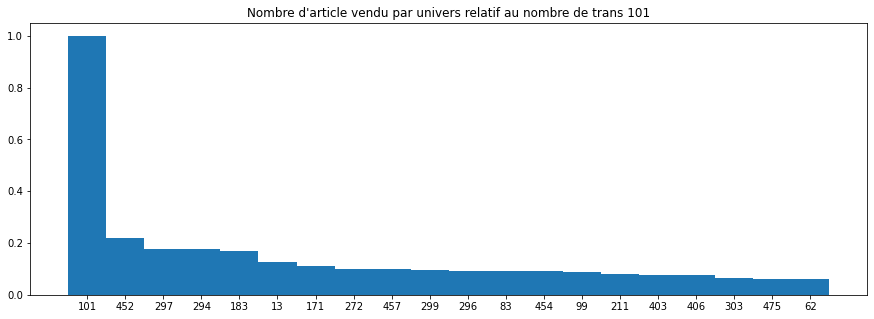

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 3.57)
("Nombre moyen d'univ", 1.35)
('CA univ', 45343.67)
('CA moyen univ', 4.36)
('Nombre moyen article en plus', 7.9)
('CA en plus', 295347.5)
('CA moyen en plus', 28.42)
==============102===================


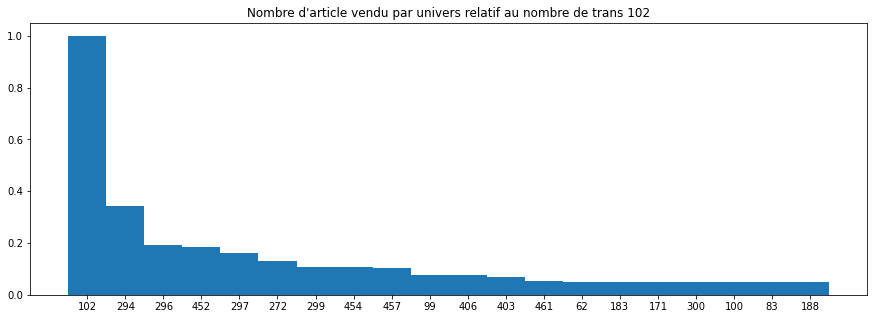

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 4.64)
("Nombre moyen d'univ", 1.22)
('CA univ', 15110.63)
('CA moyen univ', 4.68)
('Nombre moyen article en plus', 6.63)
('CA en plus', 71299.3)
('CA moyen en plus', 22.06)
==============105===================


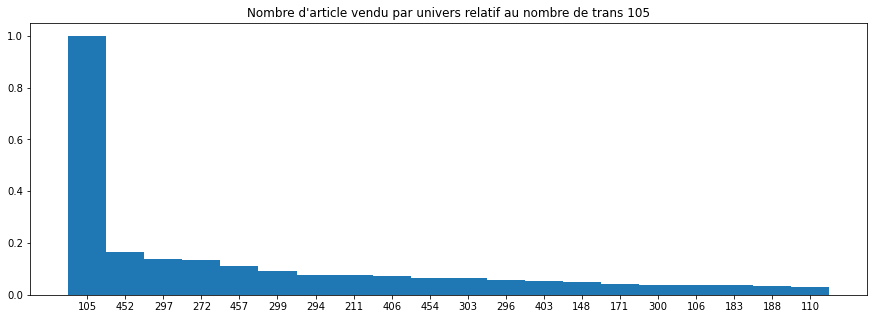

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 16.87)
("Nombre moyen d'univ", 1.23)
('CA univ', 6494.55)
('CA moyen univ', 3.43)
('Nombre moyen article en plus', 4.5)
('CA en plus', 28526.48)
('CA moyen en plus', 15.09)
==============106===================


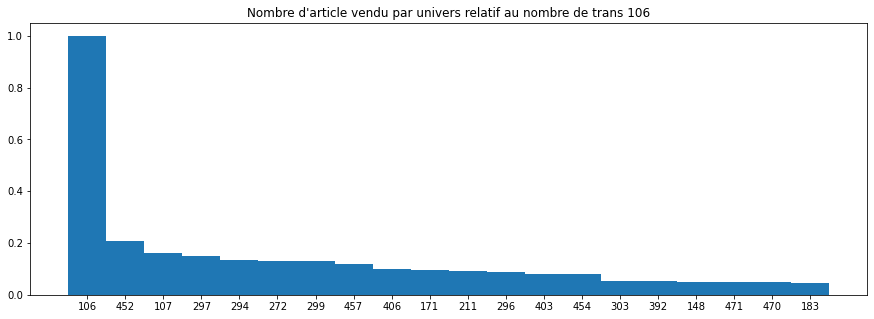

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 8.21)
("Nombre moyen d'univ", 1.35)
('CA univ', 8765.43)
('CA moyen univ', 4.02)
('Nombre moyen article en plus', 6.08)
('CA en plus', 44150.38)
('CA moyen en plus', 20.25)
==============107===================


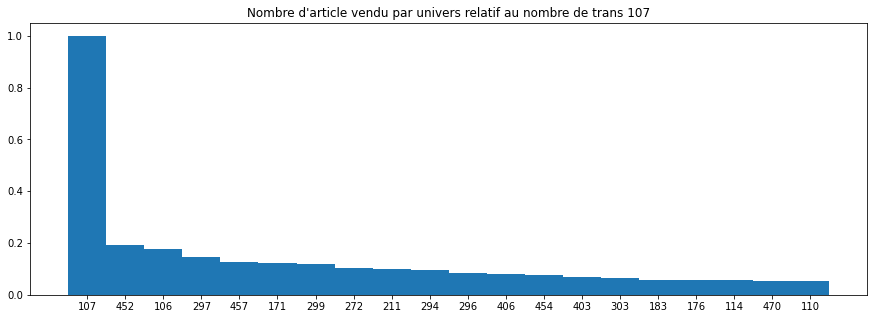

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 6.53)
("Nombre moyen d'univ", 1.15)
('CA univ', 6151.31)
('CA moyen univ', 3.16)
('Nombre moyen article en plus', 6.7)
('CA en plus', 41151.16)
('CA moyen en plus', 21.15)
==============108===================


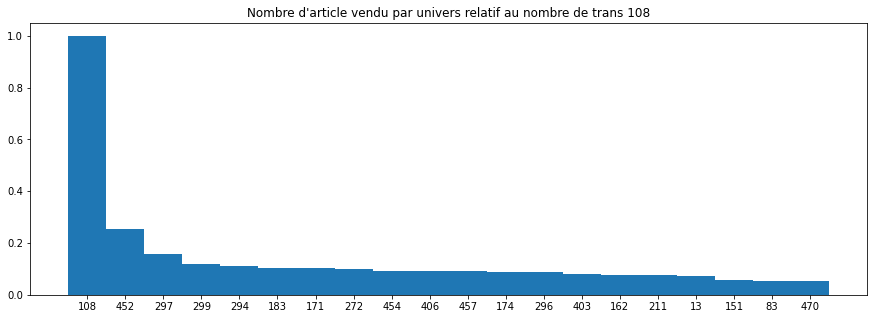

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 5.01)
("Nombre moyen d'univ", 1.18)
('CA univ', 47197.36)
('CA moyen univ', 4.53)
('Nombre moyen article en plus', 7.26)
('CA en plus', 255477.71)
('CA moyen en plus', 24.5)
==============109===================


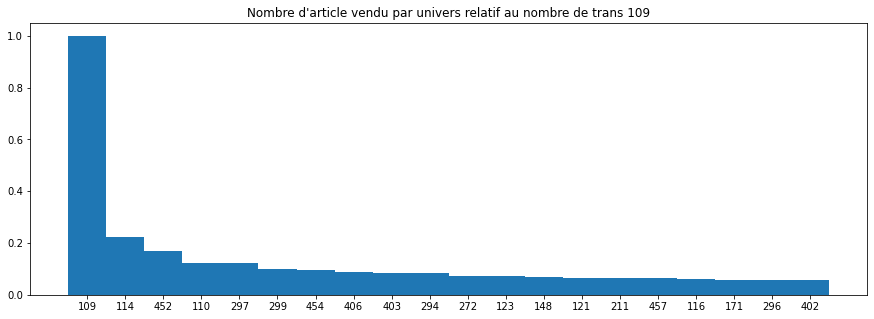

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.6)
("Nombre moyen d'univ", 1.08)
('CA univ', 22751.04)
('CA moyen univ', 5.78)
('Nombre moyen article en plus', 6.7)
('CA en plus', 103013.05)
('CA moyen en plus', 26.19)
==============110===================


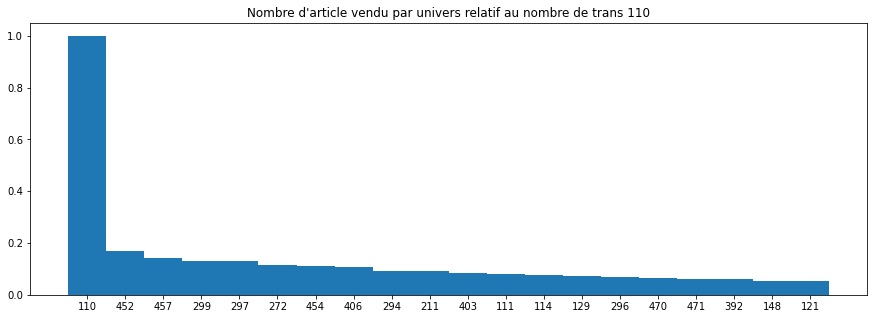

("Proportion d'achat (%)", 1.48)
('Proportion achat seul (%)', 3.72)
("Nombre moyen d'univ", 1.15)
('CA univ', 183045.41)
('CA moyen univ', 3.26)
('Nombre moyen article en plus', 6.21)
('CA en plus', 1193245.82)
('CA moyen en plus', 21.24)
==============111===================


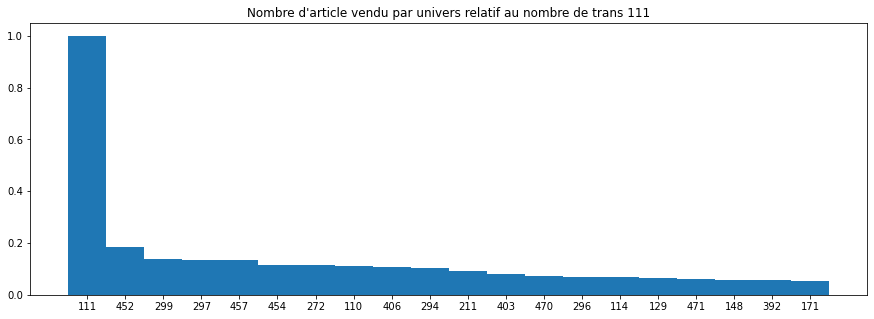

("Proportion d'achat (%)", 1.09)
('Proportion achat seul (%)', 3.89)
("Nombre moyen d'univ", 1.15)
('CA univ', 127830.4)
('CA moyen univ', 3.1)
('Nombre moyen article en plus', 6.52)
('CA en plus', 897948.89)
('CA moyen en plus', 21.79)
==============112===================


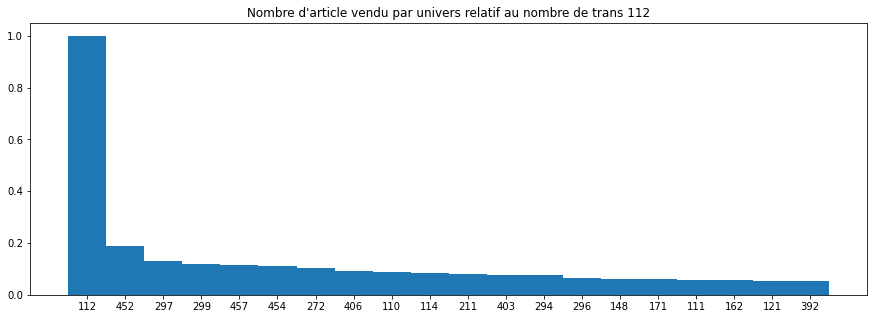

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.49)
("Nombre moyen d'univ", 1.14)
('CA univ', 21802.3)
('CA moyen univ', 5.5)
('Nombre moyen article en plus', 6.81)
('CA en plus', 95826.82)
('CA moyen en plus', 24.16)
==============113===================


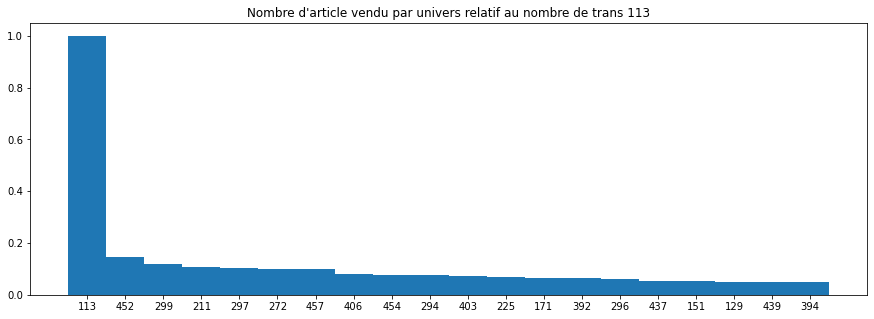

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 4.45)
("Nombre moyen d'univ", 1.33)
('CA univ', 81390.76)
('CA moyen univ', 3.16)
('Nombre moyen article en plus', 5.61)
('CA en plus', 476761.3)
('CA moyen en plus', 18.52)
==============114===================


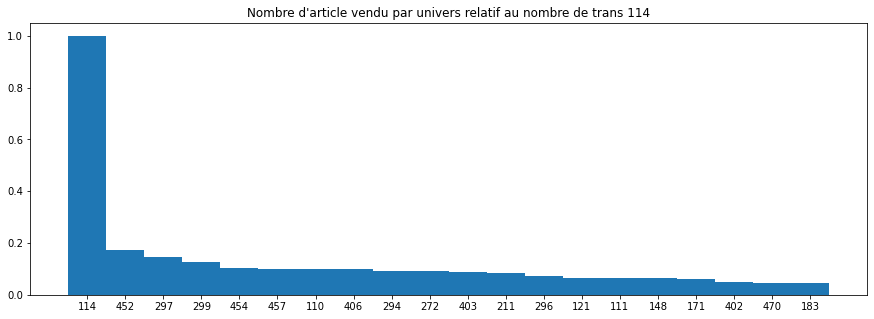

("Proportion d'achat (%)", 1.16)
('Proportion achat seul (%)', 4.42)
("Nombre moyen d'univ", 1.21)
('CA univ', 182164.61)
('CA moyen univ', 4.13)
('Nombre moyen article en plus', 6.67)
('CA en plus', 1038720.56)
('CA moyen en plus', 23.58)
==============115===================


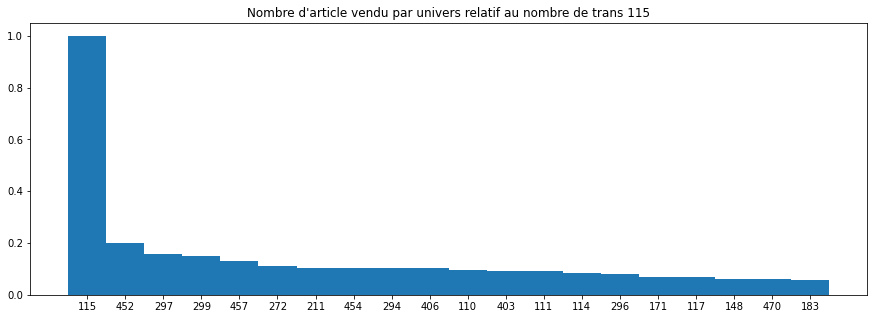

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 3.44)
("Nombre moyen d'univ", 1.15)
('CA univ', 69384.69)
('CA moyen univ', 3.49)
('Nombre moyen article en plus', 7.04)
('CA en plus', 476096.23)
('CA moyen en plus', 23.95)
==============116===================


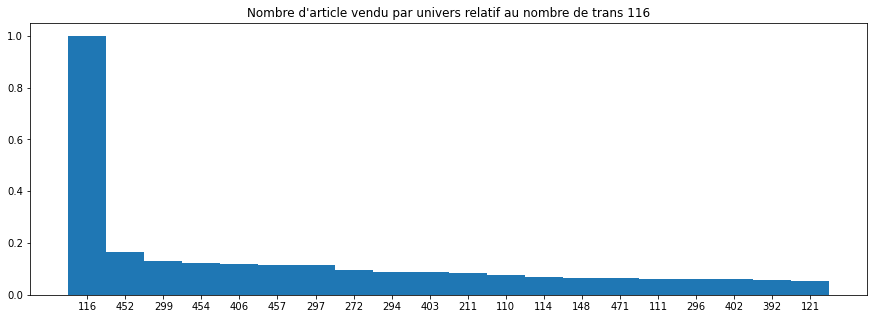

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 4.15)
("Nombre moyen d'univ", 1.13)
('CA univ', 87969.02)
('CA moyen univ', 4.47)
('Nombre moyen article en plus', 6.35)
('CA en plus', 434909.07)
('CA moyen en plus', 22.12)
==============117===================


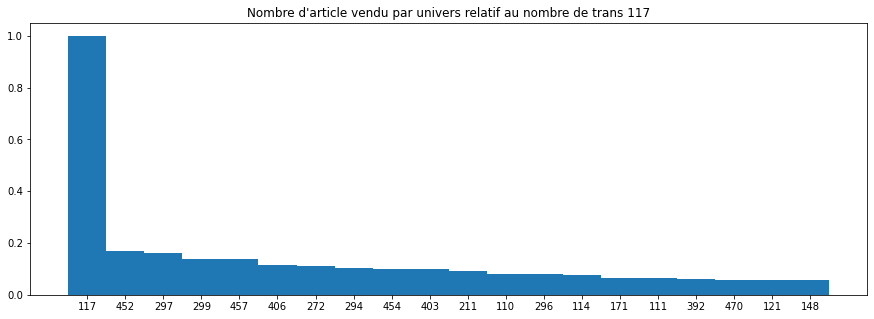

("Proportion d'achat (%)", 0.7)
('Proportion achat seul (%)', 3.67)
("Nombre moyen d'univ", 1.11)
('CA univ', 96704.65)
('CA moyen univ', 3.64)
('Nombre moyen article en plus', 6.74)
('CA en plus', 624512.96)
('CA moyen en plus', 23.5)
==============118===================


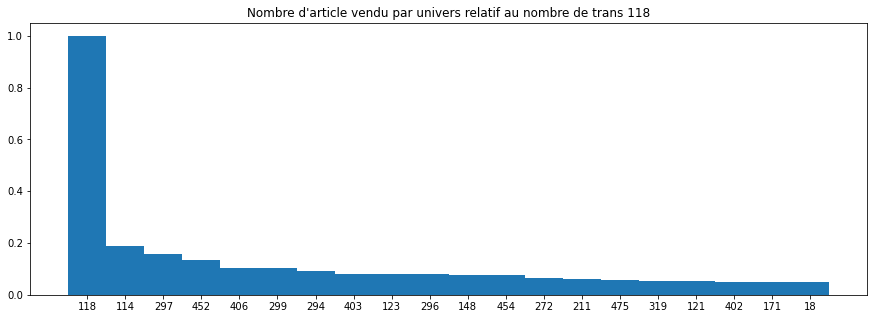

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 6.57)
("Nombre moyen d'univ", 1.07)
('CA univ', 6620.98)
('CA moyen univ', 6.59)
('Nombre moyen article en plus', 6.68)
('CA en plus', 27723.83)
('CA moyen en plus', 27.59)
==============119===================


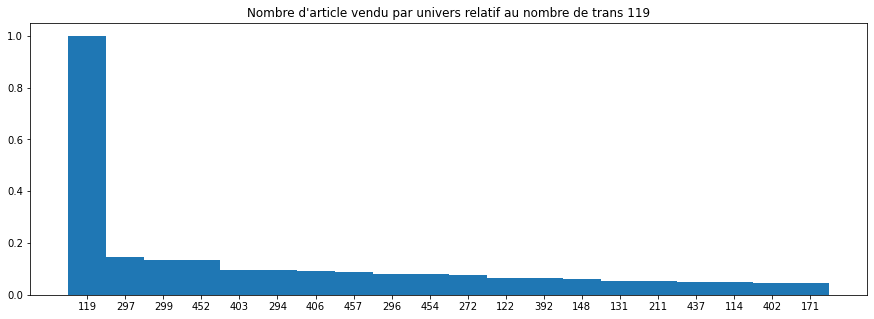

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 6.06)
("Nombre moyen d'univ", 1.33)
('CA univ', 16783.6)
('CA moyen univ', 6.09)
('Nombre moyen article en plus', 5.94)
('CA en plus', 59101.09)
('CA moyen en plus', 21.44)
==============120===================


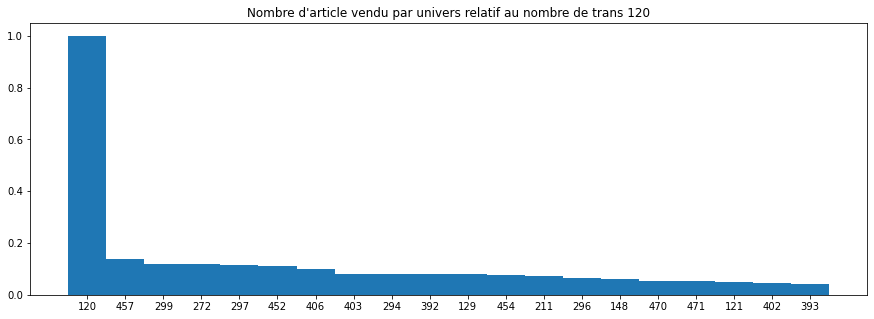

("Proportion d'achat (%)", 1.2)
('Proportion achat seul (%)', 4.62)
("Nombre moyen d'univ", 1.24)
('CA univ', 119818.13)
('CA moyen univ', 2.62)
('Nombre moyen article en plus', 5.2)
('CA en plus', 811120.94)
('CA moyen en plus', 17.74)
==============121===================


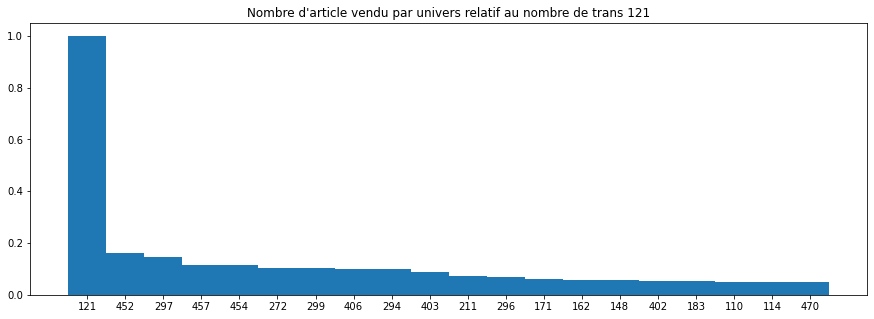

("Proportion d'achat (%)", 1.51)
('Proportion achat seul (%)', 4.74)
("Nombre moyen d'univ", 1.23)
('CA univ', 303943.98)
('CA moyen univ', 5.31)
('Nombre moyen article en plus', 6.37)
('CA en plus', 1313752.47)
('CA moyen en plus', 22.97)
==============122===================


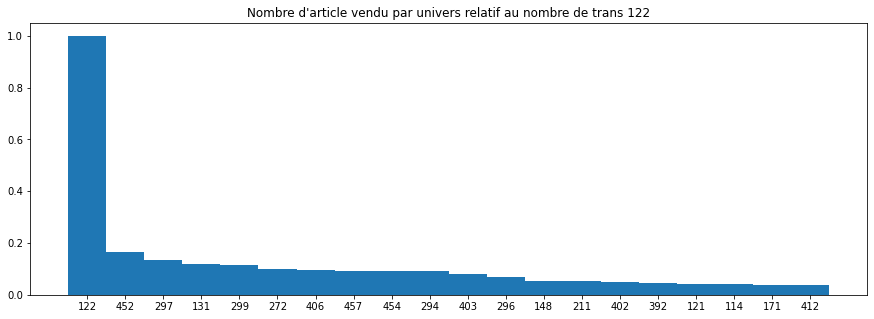

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 8.03)
("Nombre moyen d'univ", 1.44)
('CA univ', 115189.9)
('CA moyen univ', 6.69)
('Nombre moyen article en plus', 5.8)
('CA en plus', 370198.51)
('CA moyen en plus', 21.49)
==============123===================


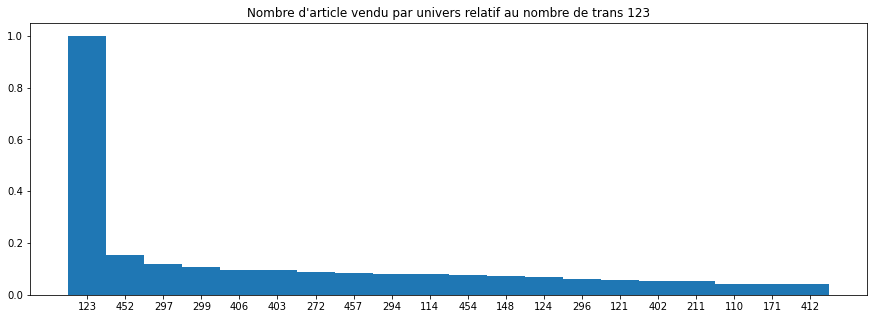

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 8.77)
("Nombre moyen d'univ", 1.2)
('CA univ', 186594.74)
('CA moyen univ', 10.2)
('Nombre moyen article en plus', 5.82)
('CA en plus', 430560.63)
('CA moyen en plus', 23.54)
==============124===================


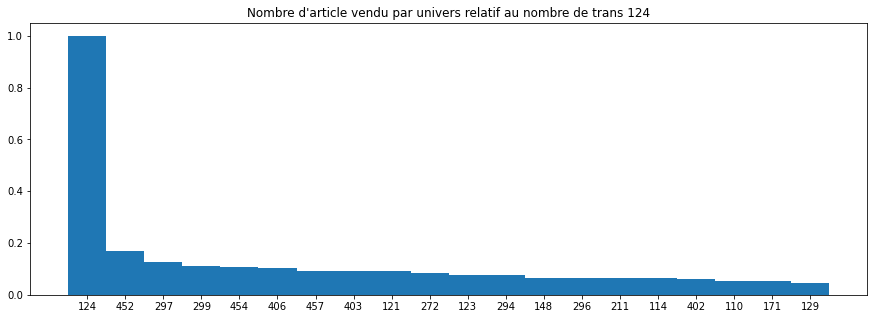

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 4.11)
("Nombre moyen d'univ", 1.19)
('CA univ', 84284.88)
('CA moyen univ', 5.11)
('Nombre moyen article en plus', 6.46)
('CA en plus', 399051.55)
('CA moyen en plus', 24.18)
==============126===================


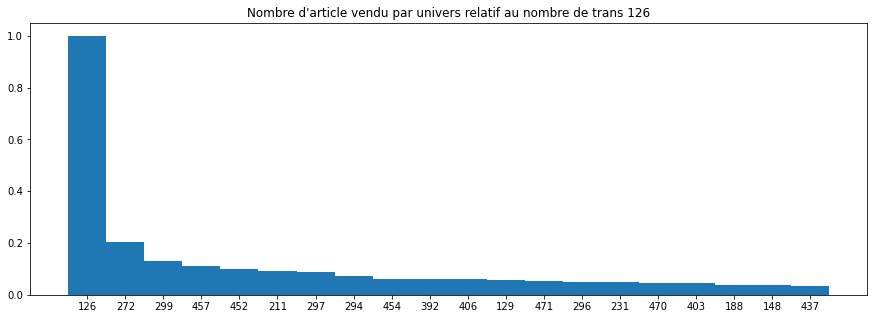

("Proportion d'achat (%)", 1.11)
('Proportion achat seul (%)', 8.97)
("Nombre moyen d'univ", 1.17)
('CA univ', 89154.94)
('CA moyen univ', 2.12)
('Nombre moyen article en plus', 4.3)
('CA en plus', 609799.13)
('CA moyen en plus', 14.52)
==============127===================


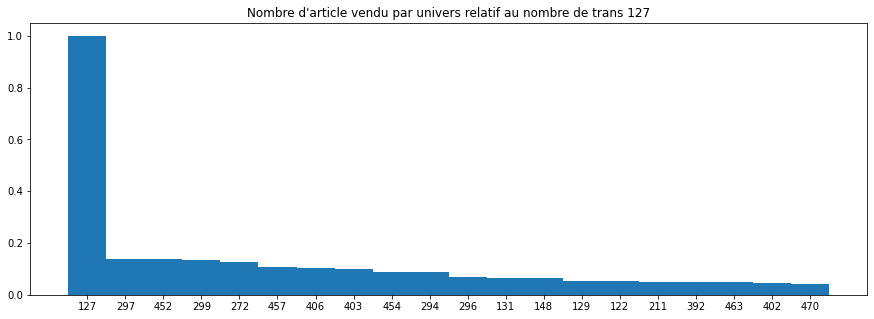

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 4.88)
("Nombre moyen d'univ", 1.36)
('CA univ', 20669.73)
('CA moyen univ', 3.82)
('Nombre moyen article en plus', 5.76)
('CA en plus', 116310.92)
('CA moyen en plus', 21.48)
==============128===================


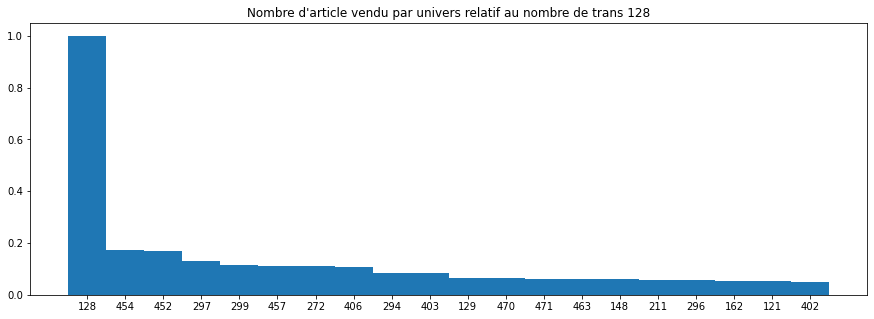

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 4.05)
("Nombre moyen d'univ", 1.14)
('CA univ', 19521.45)
('CA moyen univ', 3.89)
('Nombre moyen article en plus', 6.2)
('CA en plus', 111182.55)
('CA moyen en plus', 22.16)
==============129===================


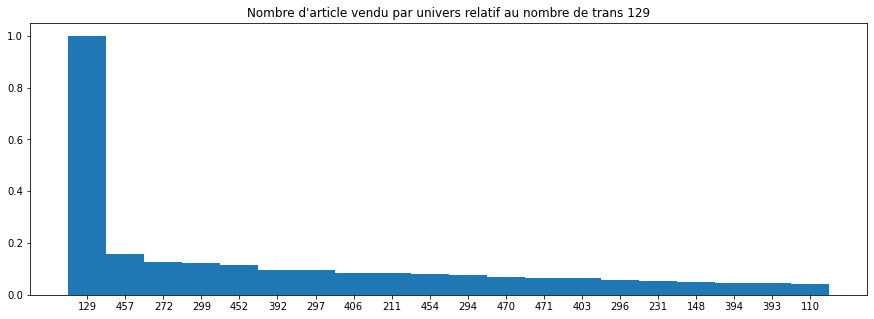

("Proportion d'achat (%)", 2.5)
('Proportion achat seul (%)', 5.16)
("Nombre moyen d'univ", 1.33)
('CA univ', 195395.09)
('CA moyen univ', 2.06)
('Nombre moyen article en plus', 4.75)
('CA en plus', 1451230.8)
('CA moyen en plus', 15.28)
==============130===================


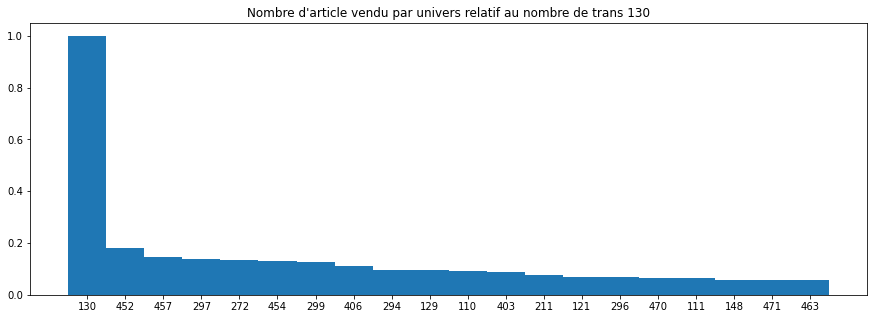

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 3.9)
("Nombre moyen d'univ", 1.09)
('CA univ', 83595.8)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 6.56)
('CA en plus', 418999.11)
('CA moyen en plus', 22.77)
==============131===================


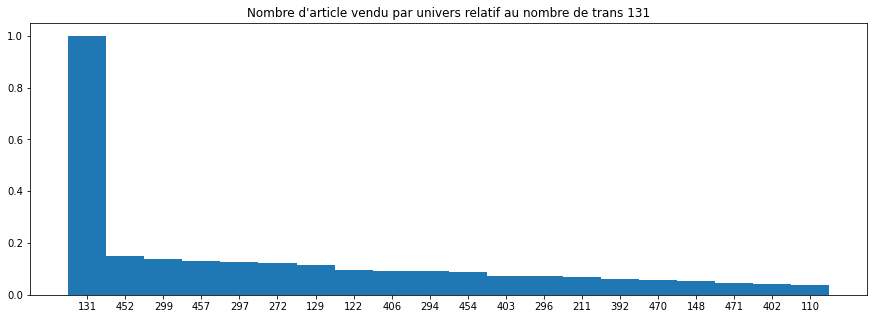

("Proportion d'achat (%)", 0.57)
('Proportion achat seul (%)', 4.79)
("Nombre moyen d'univ", 1.4)
('CA univ', 76624.74)
('CA moyen univ', 3.53)
('Nombre moyen article en plus', 5.74)
('CA en plus', 418102.17)
('CA moyen en plus', 19.27)
==============132===================


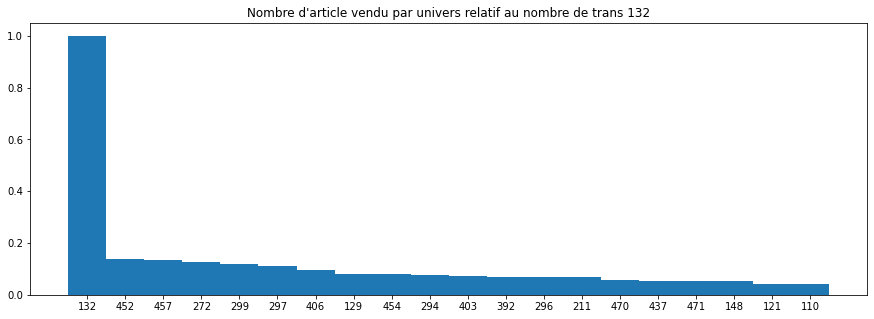

("Proportion d'achat (%)", 0.51)
('Proportion achat seul (%)', 3.94)
("Nombre moyen d'univ", 1.22)
('CA univ', 54446.44)
('CA moyen univ', 2.8)
('Nombre moyen article en plus', 5.35)
('CA en plus', 357902.07)
('CA moyen en plus', 18.37)
==============133===================


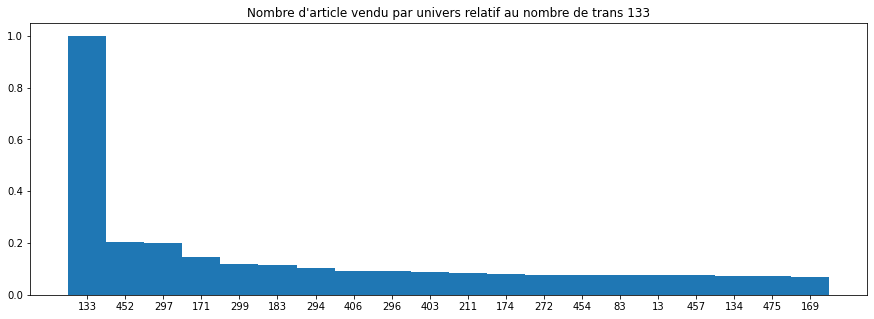

("Proportion d'achat (%)", 0.62)
('Proportion achat seul (%)', 4.5)
("Nombre moyen d'univ", 1.19)
('CA univ', 64218.95)
('CA moyen univ', 2.71)
('Nombre moyen article en plus', 7.46)
('CA en plus', 604671.63)
('CA moyen en plus', 25.53)
==============134===================


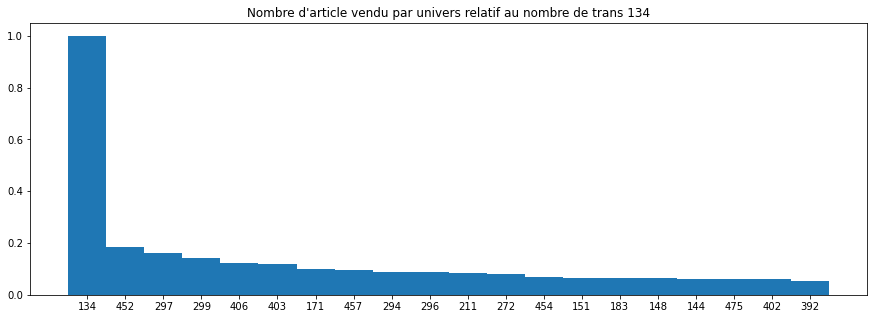

("Proportion d'achat (%)", 0.95)
('Proportion achat seul (%)', 2.58)
("Nombre moyen d'univ", 1.54)
('CA univ', 95612.51)
('CA moyen univ', 2.66)
('Nombre moyen article en plus', 6.82)
('CA en plus', 841325.25)
('CA moyen en plus', 23.39)
==============135===================


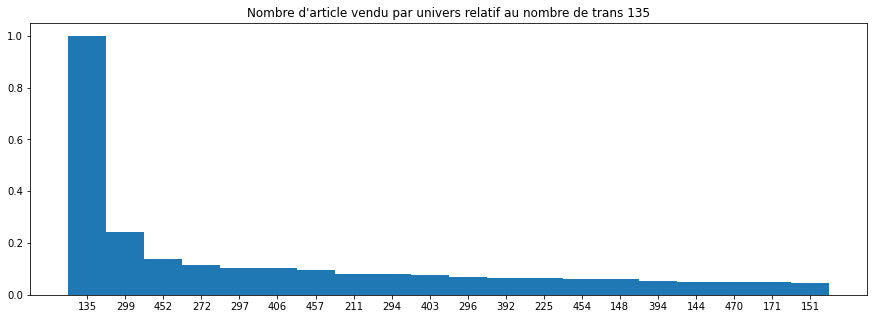

("Proportion d'achat (%)", 0.33)
('Proportion achat seul (%)', 4.8)
("Nombre moyen d'univ", 1.21)
('CA univ', 38094.1)
('CA moyen univ', 3.05)
('Nombre moyen article en plus', 5.66)
('CA en plus', 236225.42)
('CA moyen en plus', 18.94)
==============136===================


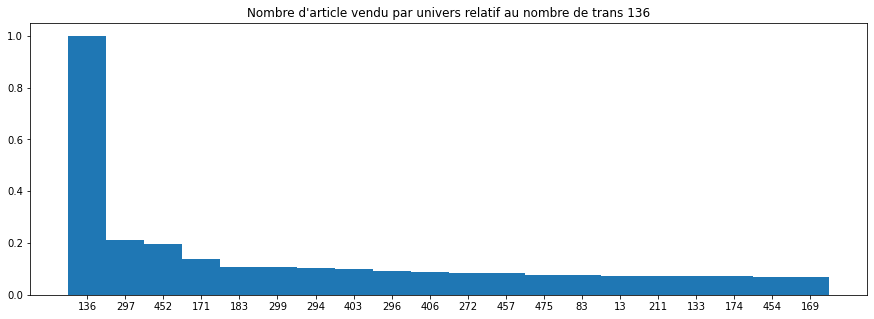

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 5.54)
("Nombre moyen d'univ", 1.18)
('CA univ', 25394.09)
('CA moyen univ', 2.49)
('Nombre moyen article en plus', 7.35)
('CA en plus', 255905.22)
('CA moyen en plus', 25.05)
==============137===================


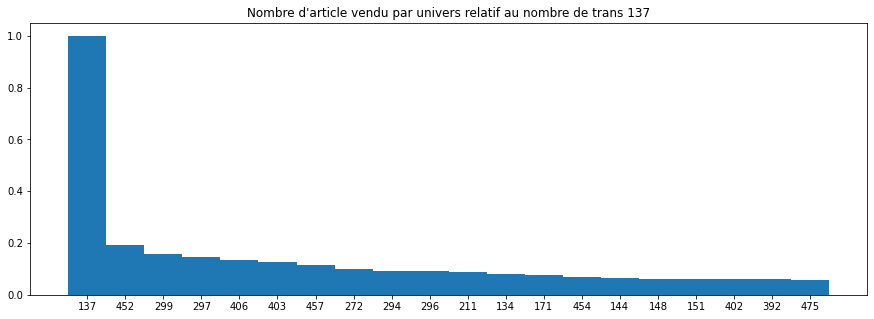

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 2.65)
("Nombre moyen d'univ", 1.52)
('CA univ', 51668.83)
('CA moyen univ', 2.31)
('Nombre moyen article en plus', 6.76)
('CA en plus', 514779.28)
('CA moyen en plus', 23.02)
==============138===================
NOT ENOUGH DATA 
==============139===================


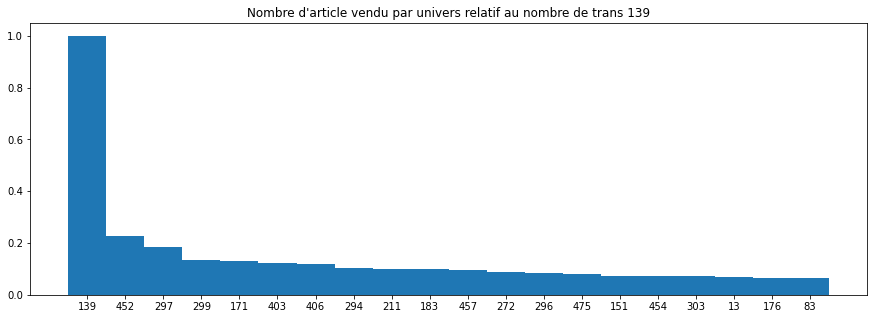

("Proportion d'achat (%)", 0.46)
('Proportion achat seul (%)', 3.09)
("Nombre moyen d'univ", 1.17)
('CA univ', 51177.19)
('CA moyen univ', 2.96)
('Nombre moyen article en plus', 7.86)
('CA en plus', 484114.71)
('CA moyen en plus', 28.03)
==============140===================


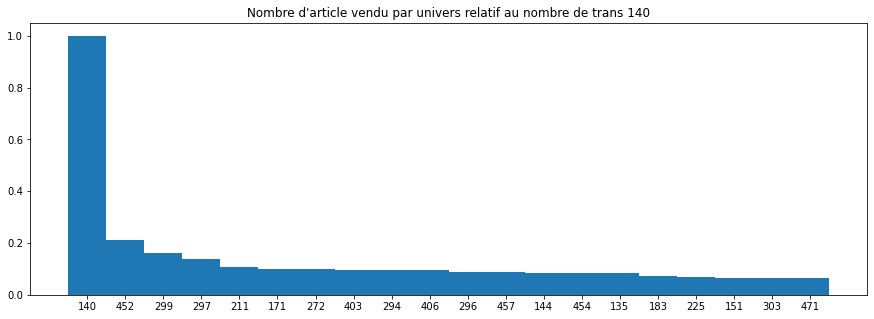

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 3.13)
("Nombre moyen d'univ", 1.18)
('CA univ', 16131.05)
('CA moyen univ', 4.28)
('Nombre moyen article en plus', 8.16)
('CA en plus', 101766.36)
('CA moyen en plus', 27.02)
==============141===================


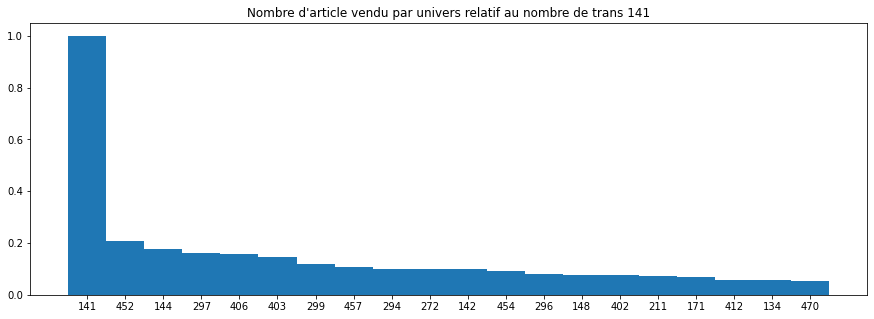

("Proportion d'achat (%)", 0.38)
('Proportion achat seul (%)', 2.51)
("Nombre moyen d'univ", 1.25)
('CA univ', 43027.61)
('CA moyen univ', 2.96)
('Nombre moyen article en plus', 7.38)
('CA en plus', 381434.73)
('CA moyen en plus', 26.24)
==============142===================


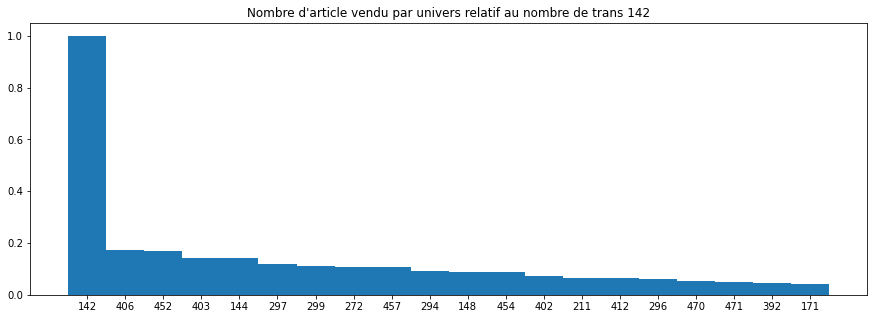

("Proportion d'achat (%)", 0.9)
('Proportion achat seul (%)', 4.16)
("Nombre moyen d'univ", 1.23)
('CA univ', 128059.58)
('CA moyen univ', 3.73)
('Nombre moyen article en plus', 6.07)
('CA en plus', 764930.52)
('CA moyen en plus', 22.31)
==============143===================


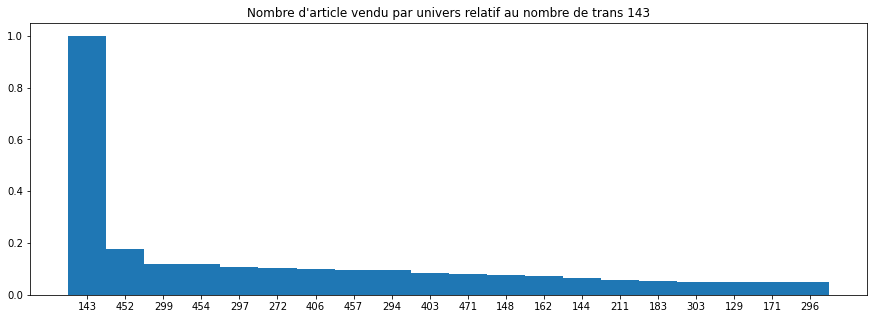

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 8.63)
("Nombre moyen d'univ", 1.1)
('CA univ', 8672.96)
('CA moyen univ', 4.23)
('Nombre moyen article en plus', 6.03)
('CA en plus', 42840.75)
('CA moyen en plus', 20.88)
==============144===================


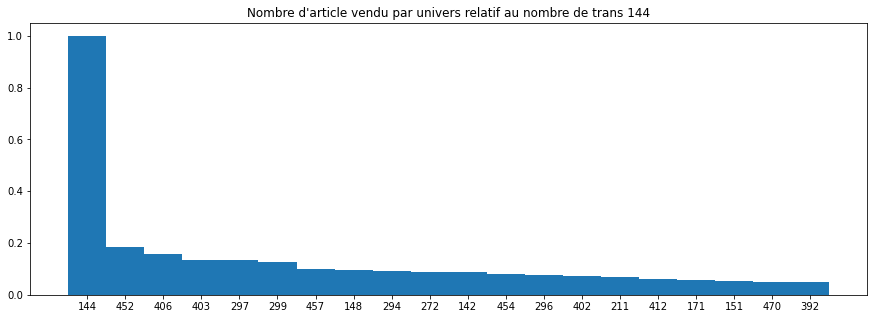

("Proportion d'achat (%)", 1.49)
('Proportion achat seul (%)', 3.5)
("Nombre moyen d'univ", 1.25)
('CA univ', 207777.57)
('CA moyen univ', 3.68)
('Nombre moyen article en plus', 6.43)
('CA en plus', 1301548.57)
('CA moyen en plus', 23.03)
==============145===================


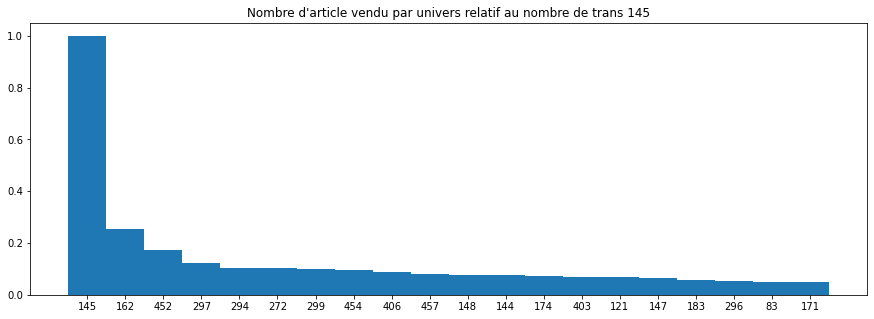

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 7.28)
("Nombre moyen d'univ", 1.06)
('CA univ', 19477.8)
('CA moyen univ', 4.6)
('Nombre moyen article en plus', 6.52)
('CA en plus', 107223.65)
('CA moyen en plus', 25.34)
==============146===================


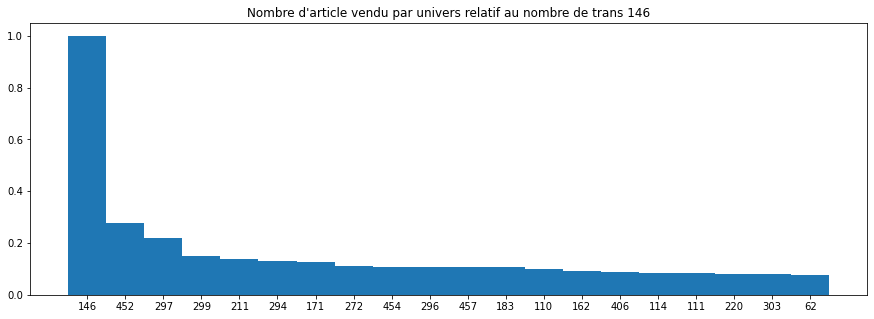

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 2.63)
("Nombre moyen d'univ", 1.11)
('CA univ', 4736.31)
('CA moyen univ', 3.66)
('Nombre moyen article en plus', 9.19)
('CA en plus', 39877.34)
('CA moyen en plus', 30.82)
==============147===================


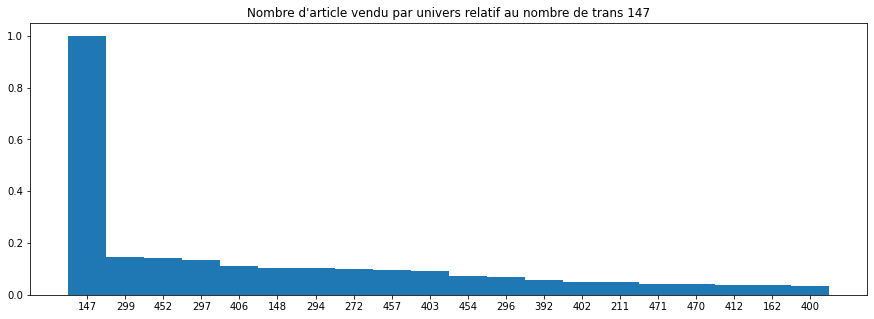

("Proportion d'achat (%)", 1.37)
('Proportion achat seul (%)', 10.0)
("Nombre moyen d'univ", 1.15)
('CA univ', 411854.2)
('CA moyen univ', 7.93)
('Nombre moyen article en plus', 5.06)
('CA en plus', 957696.49)
('CA moyen en plus', 18.45)
==============148===================


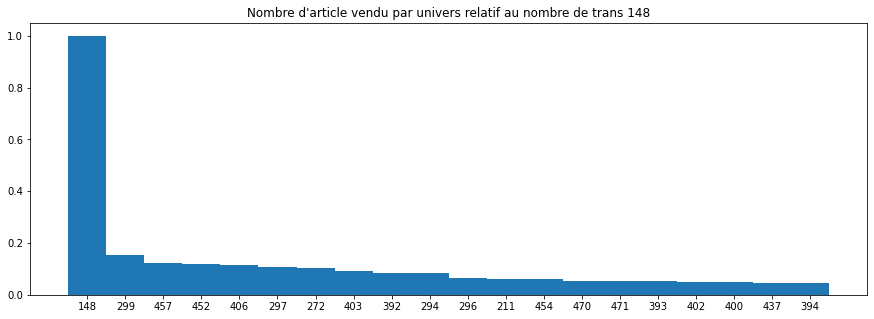

("Proportion d'achat (%)", 3.93)
('Proportion achat seul (%)', 5.98)
("Nombre moyen d'univ", 1.39)
('CA univ', 460151.99)
('CA moyen univ', 3.09)
('Nombre moyen article en plus', 4.77)
('CA en plus', 2463435.88)
('CA moyen en plus', 16.52)
==============149===================


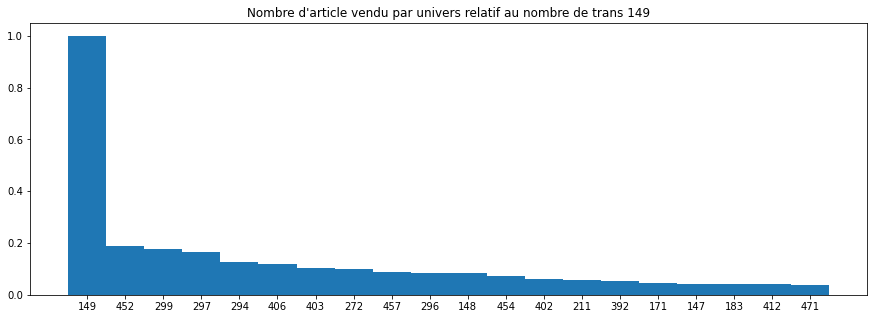

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 6.2)
("Nombre moyen d'univ", 1.12)
('CA univ', 115526.46)
('CA moyen univ', 5.12)
('Nombre moyen article en plus', 6.14)
('CA en plus', 482319.08)
('CA moyen en plus', 21.39)
==============150===================


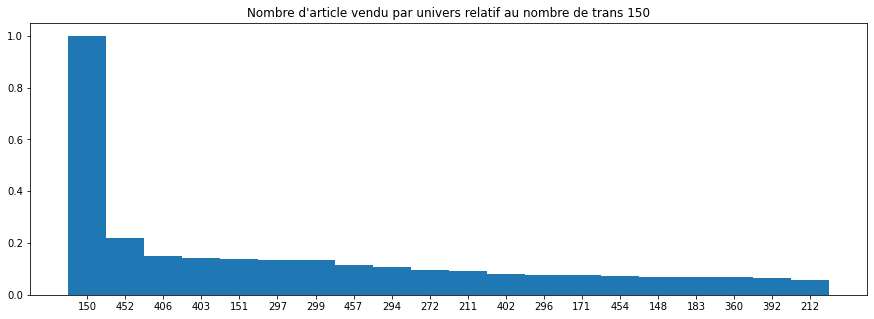

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 3.45)
("Nombre moyen d'univ", 1.05)
('CA univ', 31429.46)
('CA moyen univ', 6.35)
('Nombre moyen article en plus', 7.16)
('CA en plus', 134848.76)
('CA moyen en plus', 27.24)
==============151===================


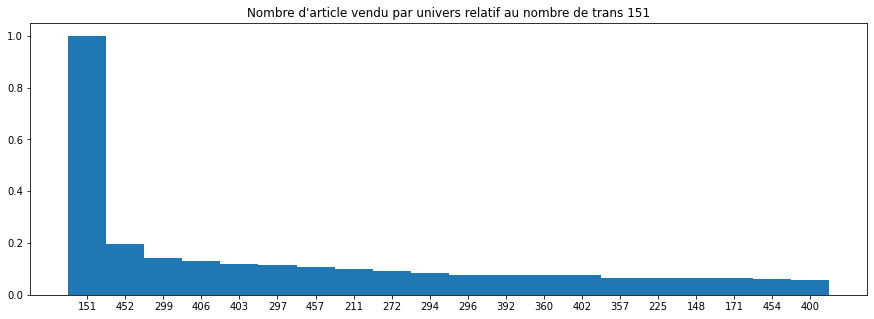

("Proportion d'achat (%)", 1.87)
('Proportion achat seul (%)', 2.47)
("Nombre moyen d'univ", 1.24)
('CA univ', 343172.44)
('CA moyen univ', 4.83)
('Nombre moyen article en plus', 6.3)
('CA en plus', 1572225.2)
('CA moyen en plus', 22.14)
==============152===================


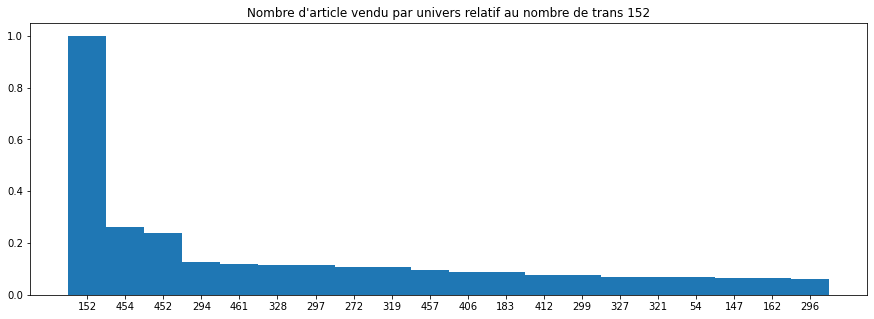

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.6)
("Nombre moyen d'univ", 1.13)
('CA univ', 6330.72)
('CA moyen univ', 13.73)
('Nombre moyen article en plus', 7.78)
('CA en plus', 15558.49)
('CA moyen en plus', 33.75)
==============153===================


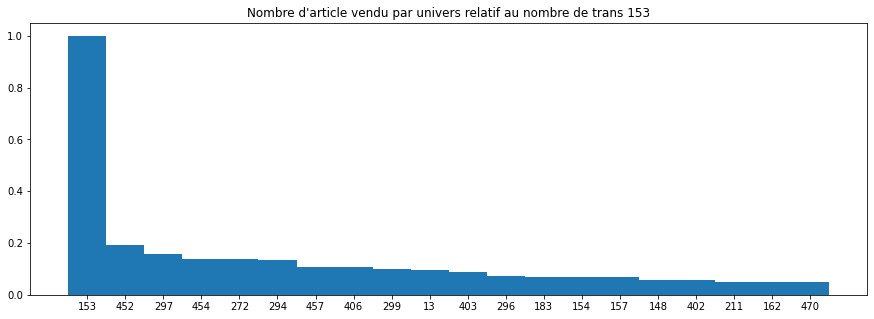

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.38)
("Nombre moyen d'univ", 1.36)
('CA univ', 27008.61)
('CA moyen univ', 7.17)
('Nombre moyen article en plus', 6.49)
('CA en plus', 90505.32)
('CA moyen en plus', 24.01)
==============154===================


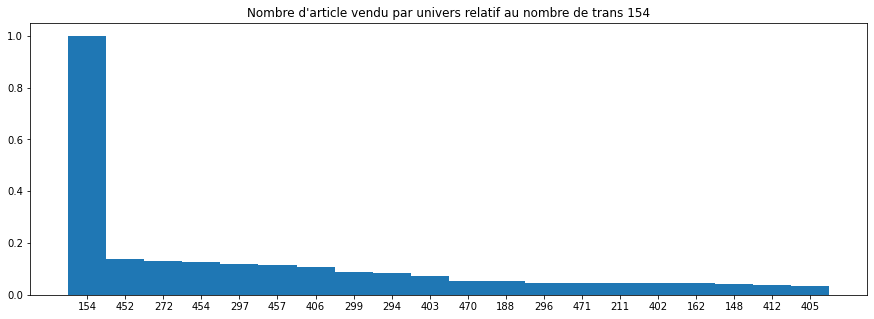

("Proportion d'achat (%)", 1.09)
('Proportion achat seul (%)', 12.45)
("Nombre moyen d'univ", 1.54)
('CA univ', 288826.8)
('CA moyen univ', 7.0)
('Nombre moyen article en plus', 4.61)
('CA en plus', 699309.04)
('CA moyen en plus', 16.94)
==============155===================


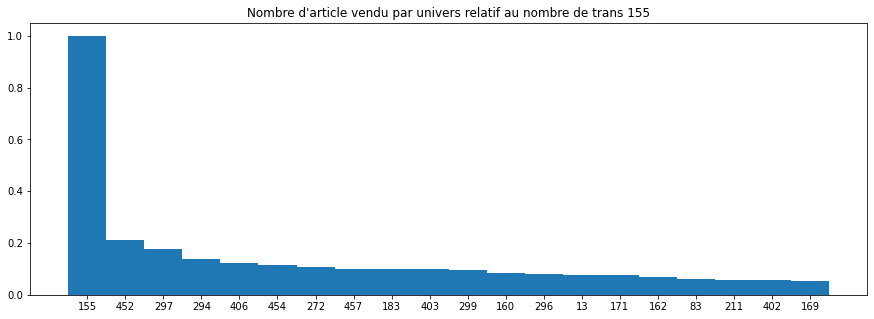

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.25)
("Nombre moyen d'univ", 1.2)
('CA univ', 34687.24)
('CA moyen univ', 9.16)
('Nombre moyen article en plus', 7.4)
('CA en plus', 102749.14)
('CA moyen en plus', 27.15)
==============156===================


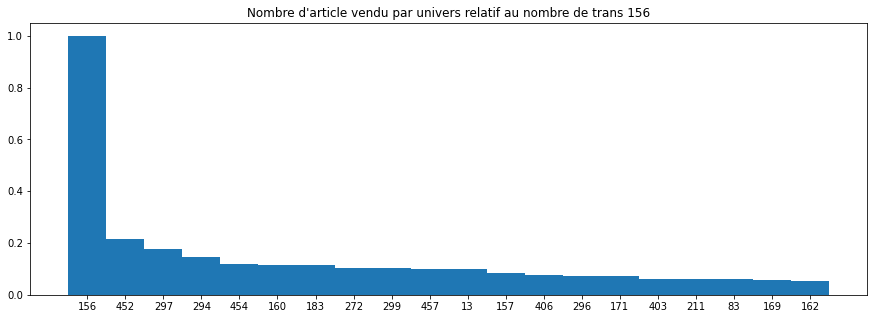

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 5.16)
("Nombre moyen d'univ", 1.21)
('CA univ', 40813.17)
('CA moyen univ', 7.6)
('Nombre moyen article en plus', 7.3)
('CA en plus', 137999.78)
('CA moyen en plus', 25.71)
==============157===================


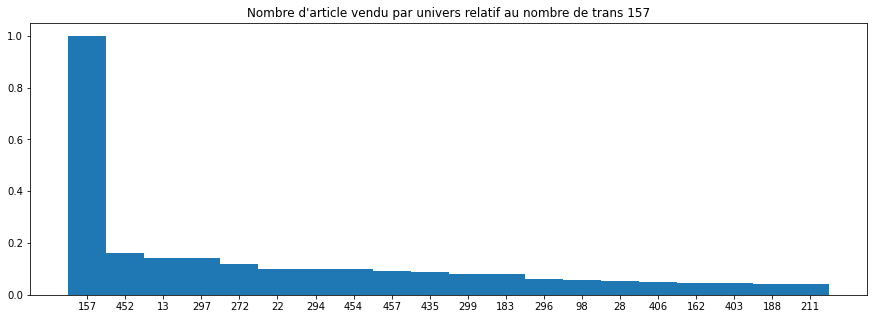

("Proportion d'achat (%)", 0.7)
('Proportion achat seul (%)', 12.07)
("Nombre moyen d'univ", 1.15)
('CA univ', 106751.33)
('CA moyen univ', 4.0)
('Nombre moyen article en plus', 5.39)
('CA en plus', 532678.47)
('CA moyen en plus', 19.98)
==============158===================


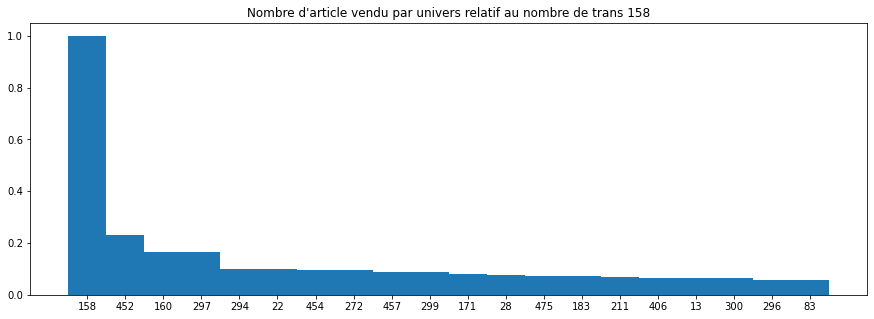

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 4.53)
("Nombre moyen d'univ", 1.14)
('CA univ', 2053.92)
('CA moyen univ', 4.04)
('Nombre moyen article en plus', 7.35)
('CA en plus', 13268.79)
('CA moyen en plus', 26.12)
==============159===================


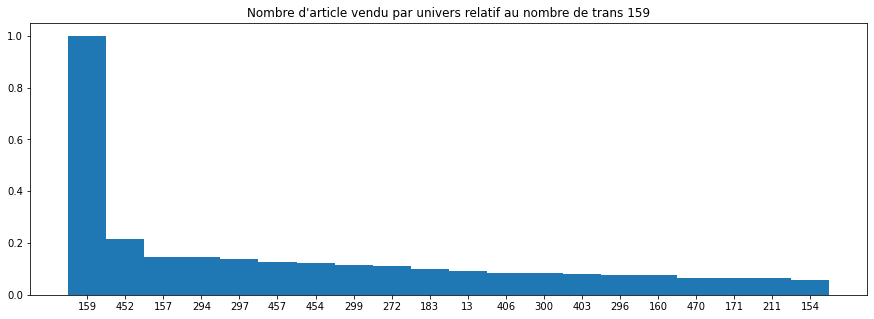

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.83)
("Nombre moyen d'univ", 1.25)
('CA univ', 10243.41)
('CA moyen univ', 4.97)
('Nombre moyen article en plus', 7.09)
('CA en plus', 51059.09)
('CA moyen en plus', 24.79)
==============160===================


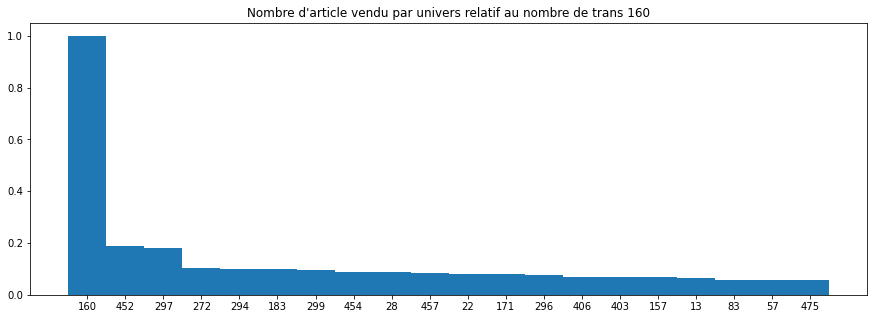

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 6.19)
("Nombre moyen d'univ", 1.23)
('CA univ', 52844.53)
('CA moyen univ', 3.93)
('Nombre moyen article en plus', 6.9)
('CA en plus', 331964.77)
('CA moyen en plus', 24.69)
==============162===================


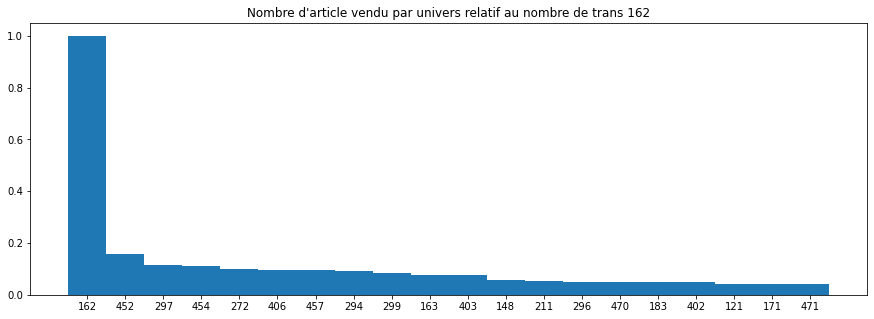

("Proportion d'achat (%)", 2.06)
('Proportion achat seul (%)', 12.38)
("Nombre moyen d'univ", 1.34)
('CA univ', 711492.44)
('CA moyen univ', 9.09)
('Nombre moyen article en plus', 5.25)
('CA en plus', 1488010.41)
('CA moyen en plus', 19.01)
==============163===================


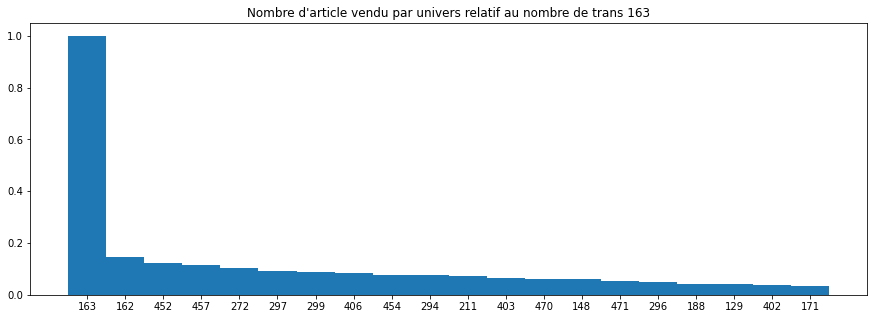

("Proportion d'achat (%)", 1.1)
('Proportion achat seul (%)', 13.03)
("Nombre moyen d'univ", 1.59)
('CA univ', 157729.39)
('CA moyen univ', 3.76)
('Nombre moyen article en plus', 4.57)
('CA en plus', 679611.88)
('CA moyen en plus', 16.22)
==============164===================


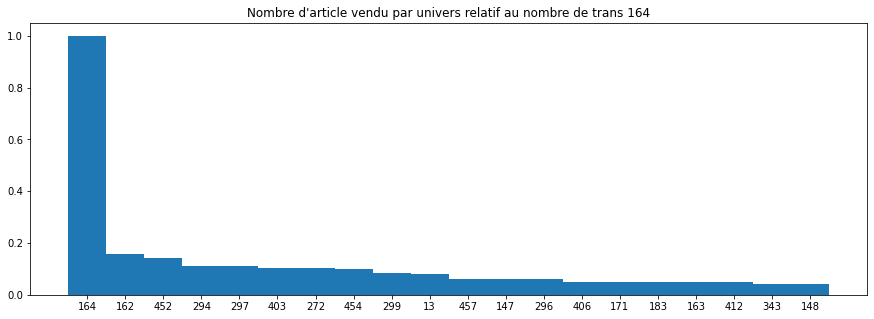

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 11.66)
("Nombre moyen d'univ", 1.38)
('CA univ', 4123.55)
('CA moyen univ', 25.3)
('Nombre moyen article en plus', 5.25)
('CA en plus', 3757.32)
('CA moyen en plus', 23.05)
==============165===================
NOT ENOUGH DATA 
==============168===================


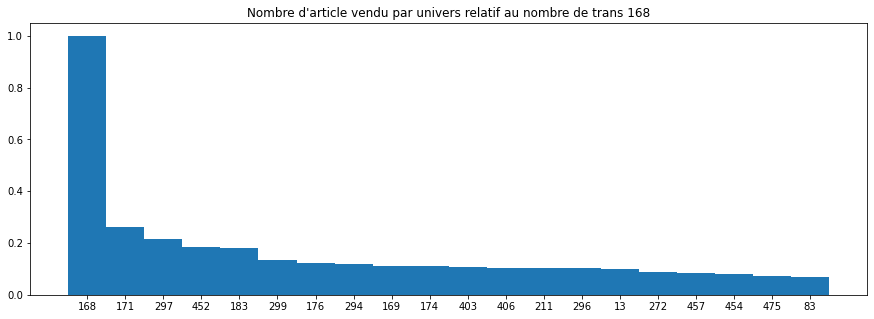

("Proportion d'achat (%)", 0.2)
('Proportion achat seul (%)', 1.85)
("Nombre moyen d'univ", 1.13)
('CA univ', 29454.93)
('CA moyen univ', 3.8)
('Nombre moyen article en plus', 8.79)
('CA en plus', 238776.79)
('CA moyen en plus', 30.83)
==============169===================


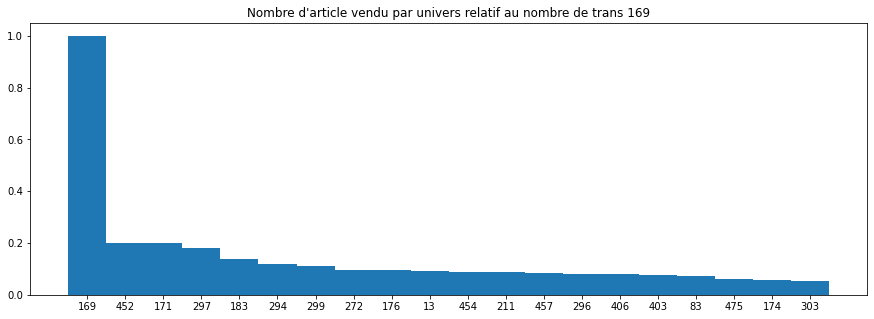

("Proportion d'achat (%)", 1.14)
('Proportion achat seul (%)', 5.59)
("Nombre moyen d'univ", 1.29)
('CA univ', 112001.94)
('CA moyen univ', 2.58)
('Nombre moyen article en plus', 7.41)
('CA en plus', 1131876.98)
('CA moyen en plus', 26.06)
==============170===================


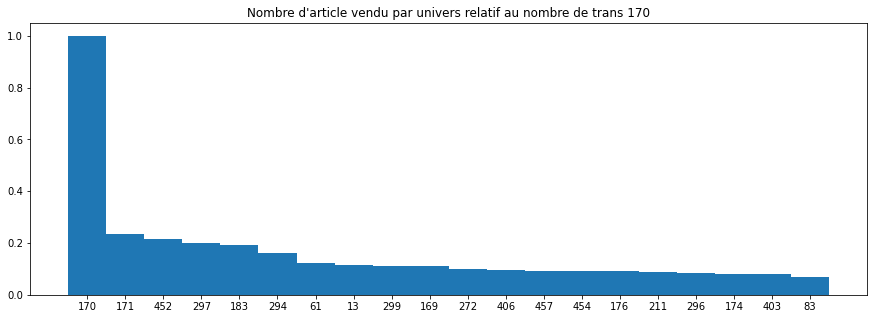

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 2.68)
("Nombre moyen d'univ", 1.18)
('CA univ', 18065.85)
('CA moyen univ', 3.93)
('Nombre moyen article en plus', 8.59)
('CA en plus', 139690.6)
('CA moyen en plus', 30.4)
==============171===================


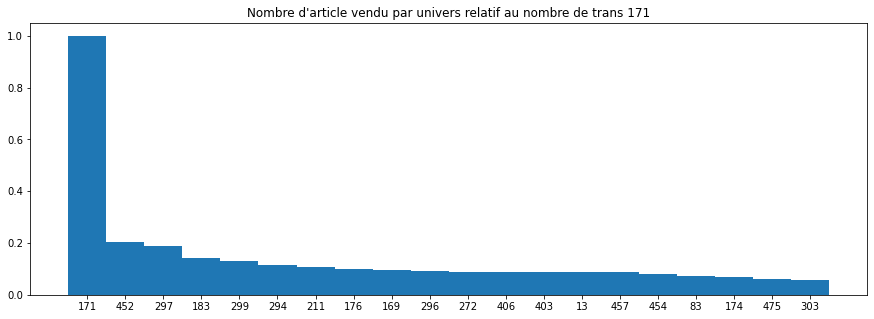

("Proportion d'achat (%)", 2.33)
('Proportion achat seul (%)', 3.59)
("Nombre moyen d'univ", 1.23)
('CA univ', 226764.44)
('CA moyen univ', 2.57)
('Nombre moyen article en plus', 7.24)
('CA en plus', 2186950.89)
('CA moyen en plus', 24.77)
==============172===================


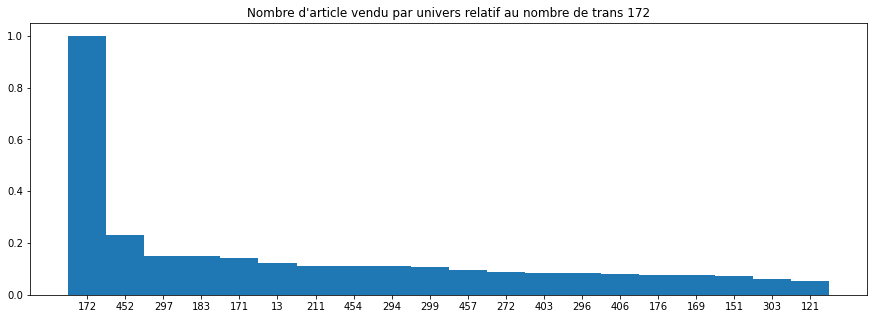

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.39)
("Nombre moyen d'univ", 1.08)
('CA univ', 12352.12)
('CA moyen univ', 6.75)
('Nombre moyen article en plus', 8.42)
('CA en plus', 53633.26)
('CA moyen en plus', 29.31)
==============173===================


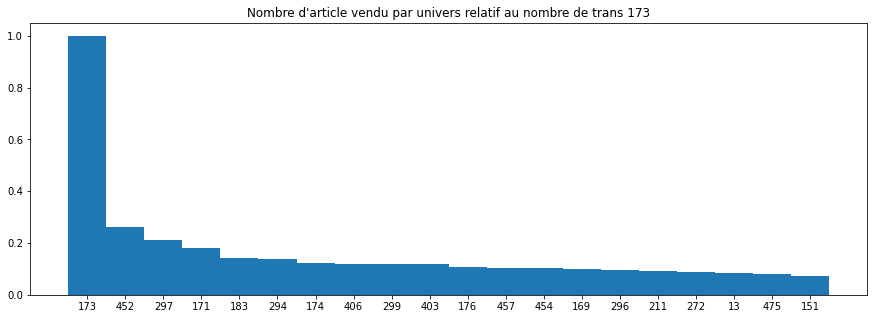

("Proportion d'achat (%)", 0.34)
('Proportion achat seul (%)', 2.13)
("Nombre moyen d'univ", 1.06)
('CA univ', 52868.11)
('CA moyen univ', 4.11)
('Nombre moyen article en plus', 8.95)
('CA en plus', 401786.35)
('CA moyen en plus', 31.26)
==============174===================


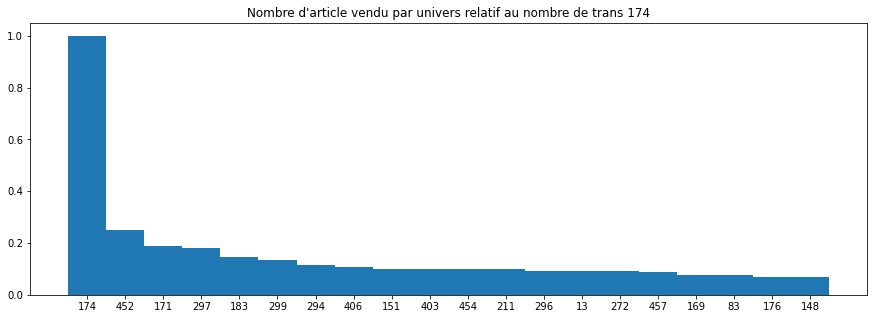

("Proportion d'achat (%)", 0.83)
('Proportion achat seul (%)', 2.05)
("Nombre moyen d'univ", 1.37)
('CA univ', 169786.43)
('CA moyen univ', 5.38)
('Nombre moyen article en plus', 8.61)
('CA en plus', 964725.84)
('CA moyen en plus', 30.58)
==============175===================


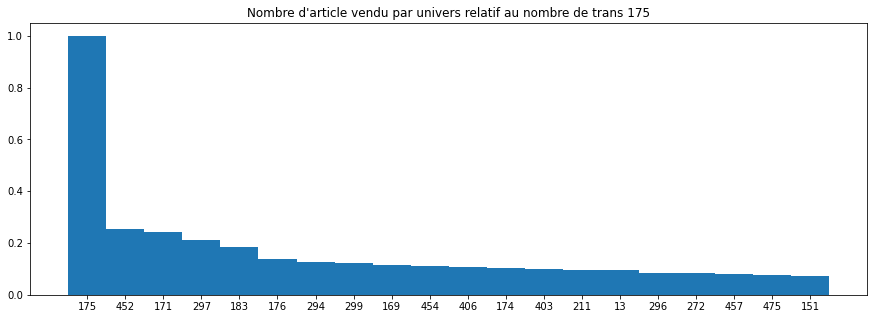

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 1.52)
("Nombre moyen d'univ", 1.07)
('CA univ', 13222.3)
('CA moyen univ', 4.48)
('Nombre moyen article en plus', 9.33)
('CA en plus', 95865.86)
('CA moyen en plus', 32.45)
==============176===================


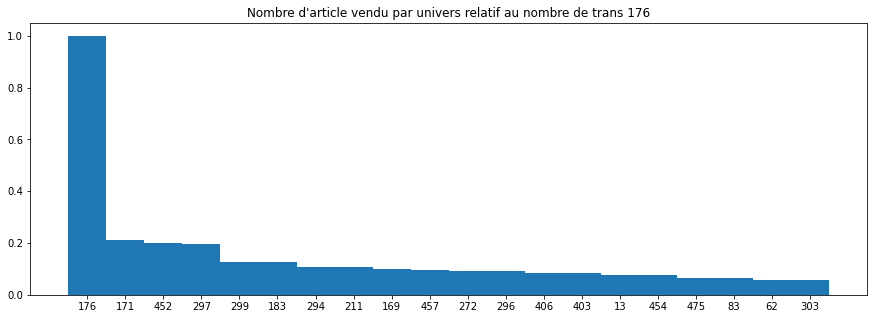

("Proportion d'achat (%)", 1.08)
('Proportion achat seul (%)', 3.49)
("Nombre moyen d'univ", 1.15)
('CA univ', 123824.16)
('CA moyen univ', 3.03)
('Nombre moyen article en plus', 7.42)
('CA en plus', 1016143.71)
('CA moyen en plus', 24.84)
==============177===================


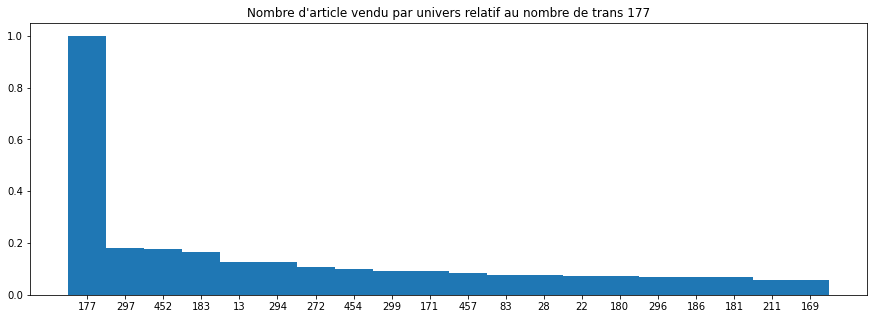

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 8.92)
("Nombre moyen d'univ", 1.07)
('CA univ', 70147.5)
('CA moyen univ', 3.81)
('Nombre moyen article en plus', 6.89)
('CA en plus', 429202.44)
('CA moyen en plus', 23.3)
==============178===================


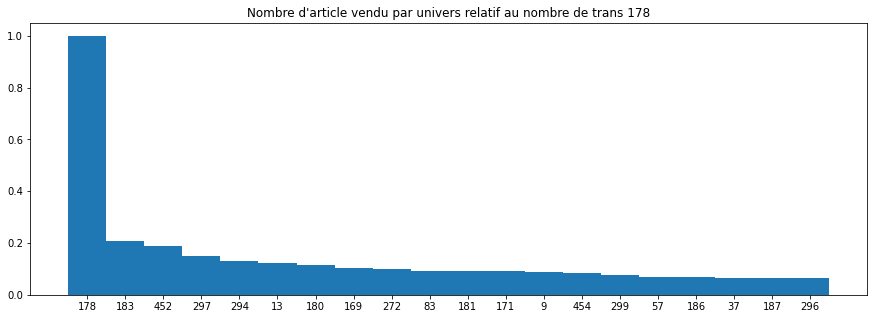

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 6.41)
("Nombre moyen d'univ", 1.04)
('CA univ', 9289.73)
('CA moyen univ', 1.89)
('Nombre moyen article en plus', 7.22)
('CA en plus', 122641.65)
('CA moyen en plus', 24.94)
==============179===================


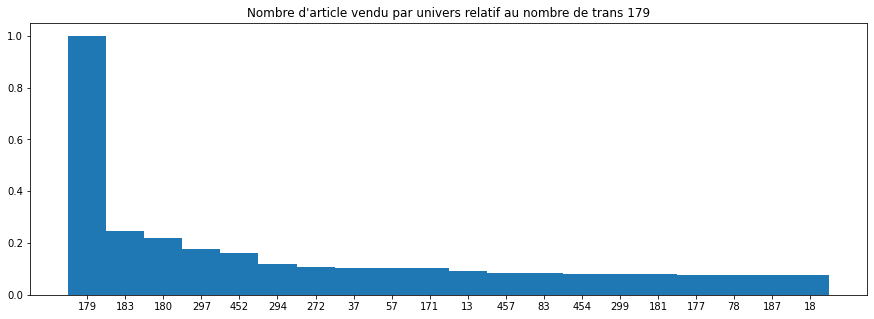

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 4.61)
("Nombre moyen d'univ", 1.02)
('CA univ', 1481.63)
('CA moyen univ', 2.01)
('Nombre moyen article en plus', 7.9)
('CA en plus', 19960.01)
('CA moyen en plus', 27.05)
==============180===================


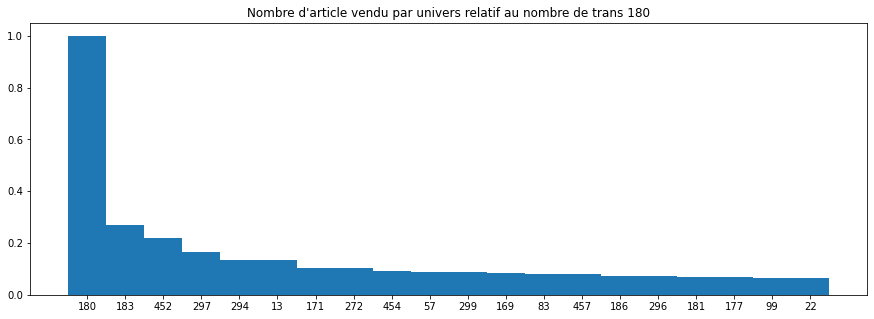

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 6.34)
("Nombre moyen d'univ", 1.12)
('CA univ', 45673.31)
('CA moyen univ', 2.33)
('Nombre moyen article en plus', 7.79)
('CA en plus', 522738.12)
('CA moyen en plus', 26.67)
==============181===================


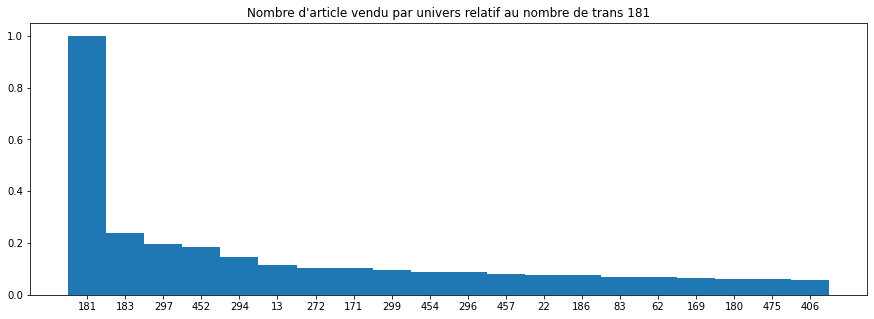

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 5.86)
("Nombre moyen d'univ", 1.13)
('CA univ', 54260.22)
('CA moyen univ', 2.43)
('Nombre moyen article en plus', 7.38)
('CA en plus', 604622.84)
('CA moyen en plus', 27.11)
==============182===================


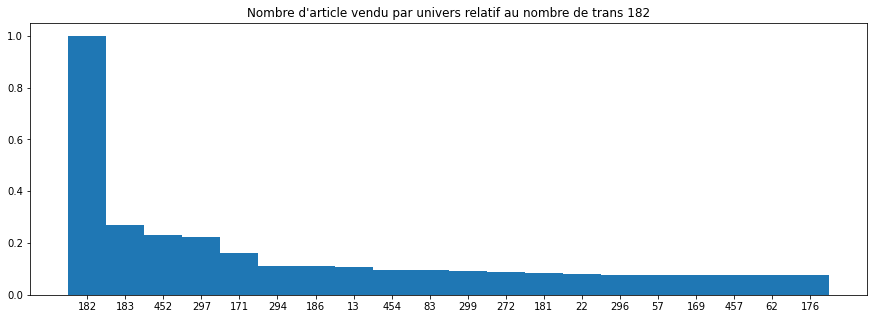

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 3.59)
("Nombre moyen d'univ", 1.11)
('CA univ', 15708.61)
('CA moyen univ', 2.4)
('Nombre moyen article en plus', 8.4)
('CA en plus', 187080.45)
('CA moyen en plus', 28.59)
==============183===================


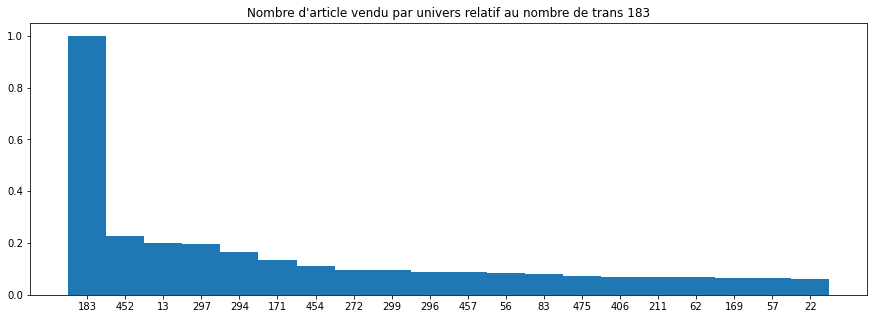

("Proportion d'achat (%)", 2.47)
('Proportion achat seul (%)', 3.04)
("Nombre moyen d'univ", 1.36)
('CA univ', 276801.23)
('CA moyen univ', 2.95)
('Nombre moyen article en plus', 7.82)
('CA en plus', 2577923.18)
('CA moyen en plus', 27.49)
==============184===================


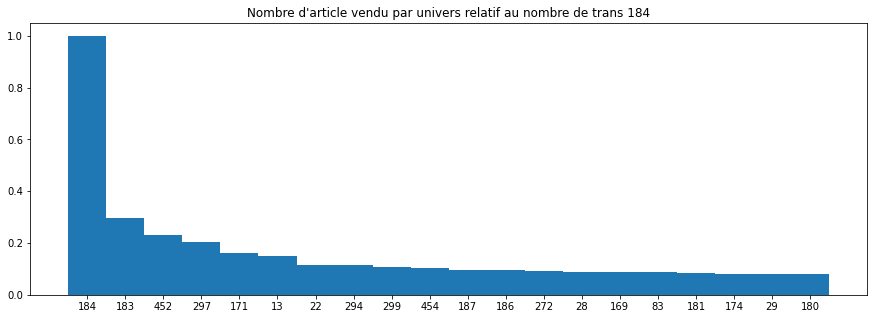

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 2.19)
("Nombre moyen d'univ", 1.18)
('CA univ', 22518.47)
('CA moyen univ', 3.86)
('Nombre moyen article en plus', 9.51)
('CA en plus', 198696.5)
('CA moyen en plus', 34.05)
==============186===================


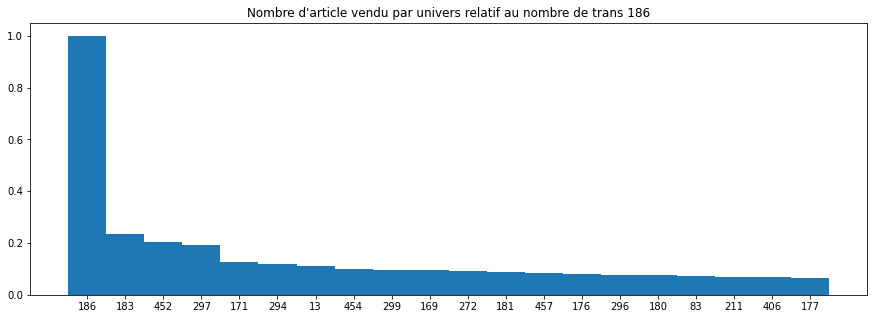

("Proportion d'achat (%)", 0.51)
('Proportion achat seul (%)', 5.39)
("Nombre moyen d'univ", 1.1)
('CA univ', 38916.03)
('CA moyen univ', 2.02)
('Nombre moyen article en plus', 7.67)
('CA en plus', 501982.62)
('CA moyen en plus', 26.06)
==============187===================


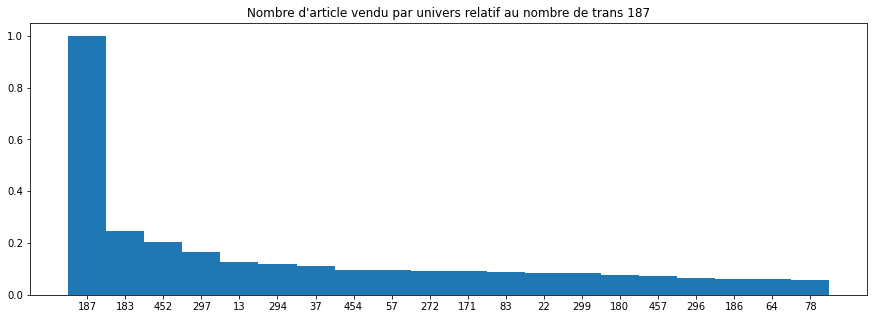

("Proportion d'achat (%)", 0.4)
('Proportion achat seul (%)', 5.07)
("Nombre moyen d'univ", 1.16)
('CA univ', 35226.87)
('CA moyen univ', 2.34)
('Nombre moyen article en plus', 7.31)
('CA en plus', 381075.29)
('CA moyen en plus', 25.34)
==============188===================


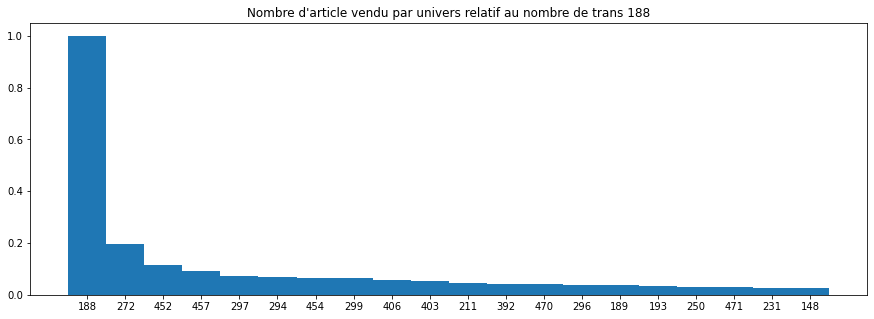

("Proportion d'achat (%)", 4.25)
('Proportion achat seul (%)', 21.08)
("Nombre moyen d'univ", 1.44)
('CA univ', 882769.6)
('CA moyen univ', 5.48)
('Nombre moyen article en plus', 3.36)
('CA en plus', 2010060.12)
('CA moyen en plus', 12.47)
==============189===================


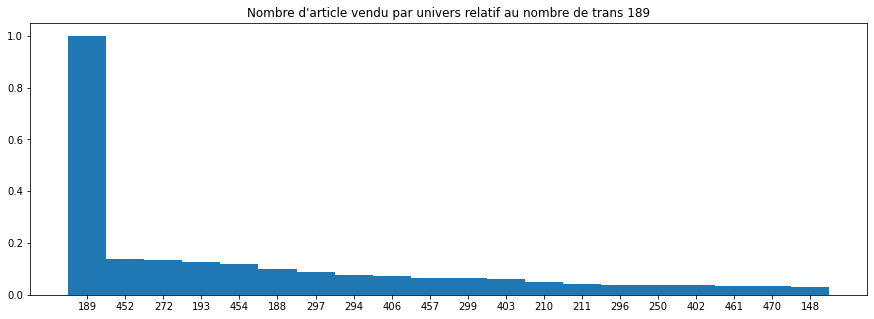

("Proportion d'achat (%)", 1.62)
('Proportion achat seul (%)', 13.48)
("Nombre moyen d'univ", 1.87)
('CA univ', 292970.09)
('CA moyen univ', 4.77)
('Nombre moyen article en plus', 4.25)
('CA en plus', 957253.63)
('CA moyen en plus', 15.59)
==============190===================


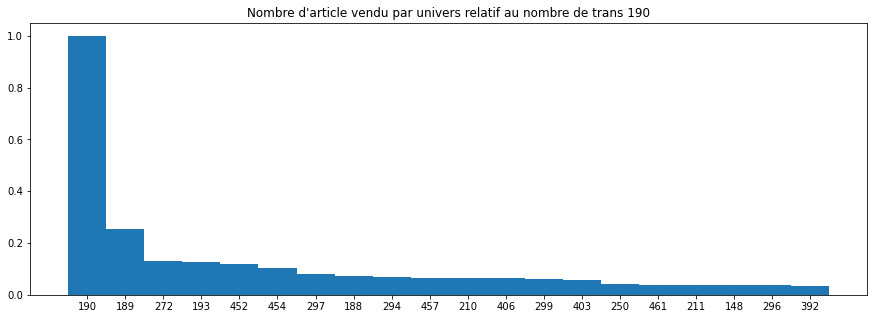

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 13.88)
("Nombre moyen d'univ", 1.4)
('CA univ', 21332.27)
('CA moyen univ', 3.65)
('Nombre moyen article en plus', 4.48)
('CA en plus', 90848.14)
('CA moyen en plus', 15.54)
==============191===================


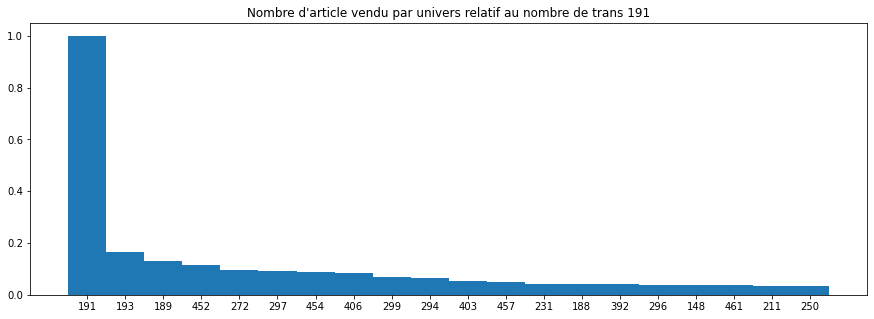

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 19.52)
("Nombre moyen d'univ", 1.31)
('CA univ', 6289.05)
('CA moyen univ', 4.22)
('Nombre moyen article en plus', 3.94)
('CA en plus', 19163.12)
('CA moyen en plus', 12.85)
==============192===================


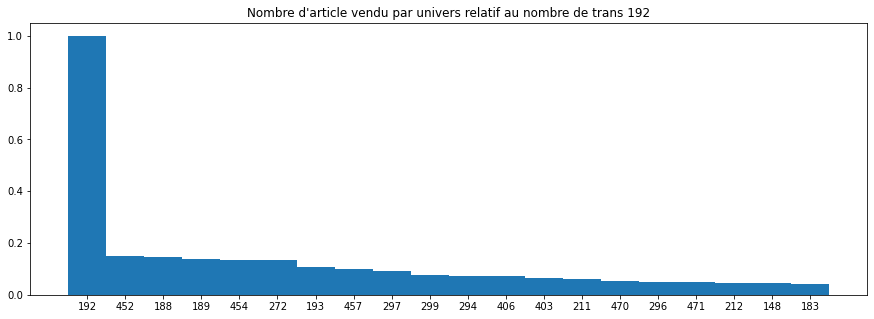

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 8.17)
("Nombre moyen d'univ", 1.36)
('CA univ', 31789.04)
('CA moyen univ', 4.37)
('Nombre moyen article en plus', 5.43)
('CA en plus', 138271.35)
('CA moyen en plus', 18.99)
==============193===================


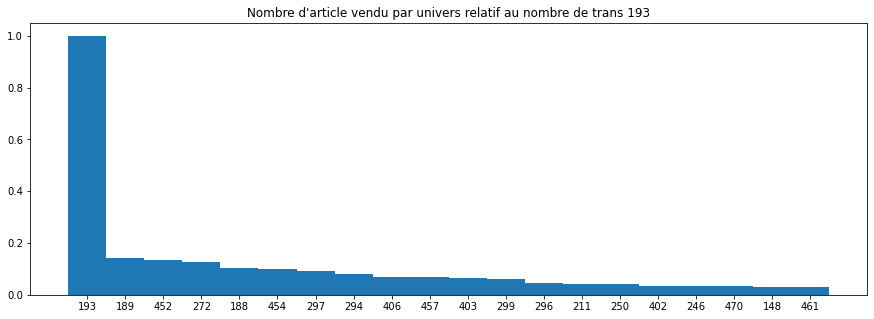

("Proportion d'achat (%)", 1.42)
('Proportion achat seul (%)', 14.07)
("Nombre moyen d'univ", 1.46)
('CA univ', 281319.65)
('CA moyen univ', 5.24)
('Nombre moyen article en plus', 4.28)
('CA en plus', 841678.8)
('CA moyen en plus', 15.67)
==============194===================


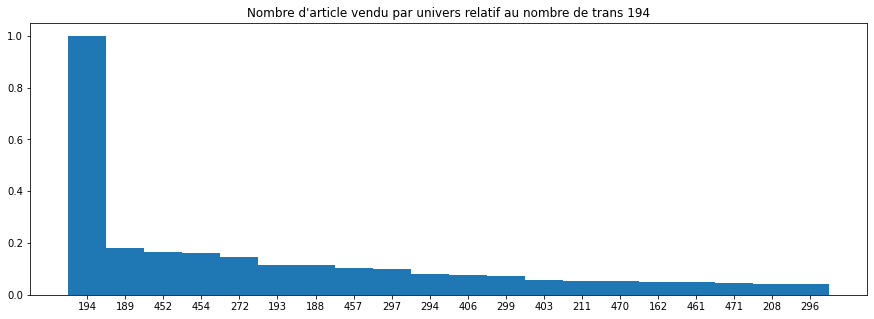

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 6.26)
("Nombre moyen d'univ", 1.37)
('CA univ', 14809.91)
('CA moyen univ', 3.44)
('Nombre moyen article en plus', 5.59)
('CA en plus', 85258.06)
('CA moyen en plus', 19.78)
==============195===================


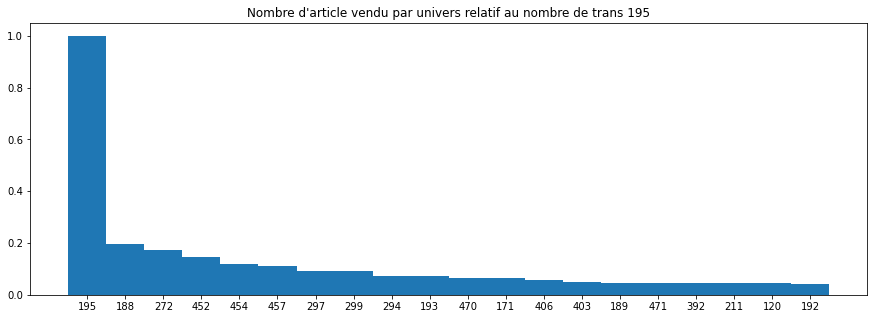

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 9.47)
("Nombre moyen d'univ", 1.25)
('CA univ', 3131.11)
('CA moyen univ', 2.93)
('Nombre moyen article en plus', 4.92)
('CA en plus', 17441.77)
('CA moyen en plus', 16.35)
==============196===================


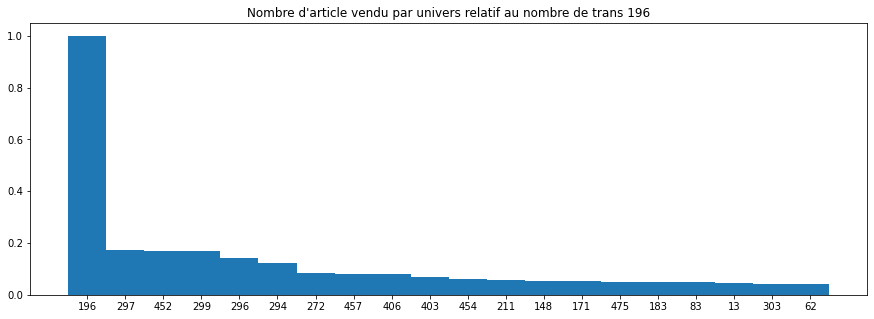

("Proportion d'achat (%)", 0.64)
('Proportion achat seul (%)', 7.62)
("Nombre moyen d'univ", 1.12)
('CA univ', 75046.06)
('CA moyen univ', 3.07)
('Nombre moyen article en plus', 5.72)
('CA en plus', 451966.64)
('CA moyen en plus', 18.51)
==============197===================


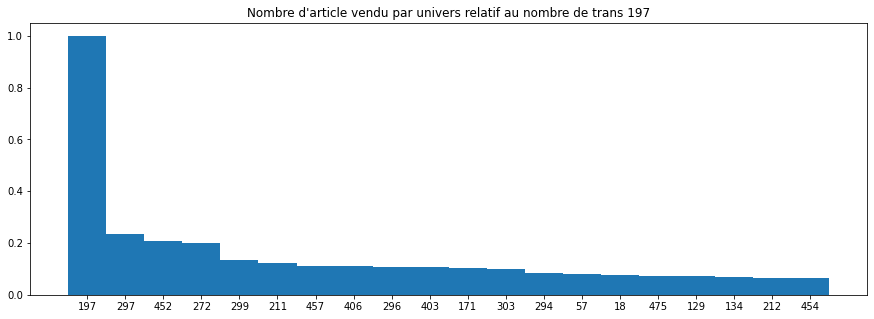

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 7.0)
("Nombre moyen d'univ", 1.08)
('CA univ', 2014.98)
('CA moyen univ', 3.62)
('Nombre moyen article en plus', 7.91)
('CA en plus', 14073.94)
('CA moyen en plus', 25.27)
==============198===================


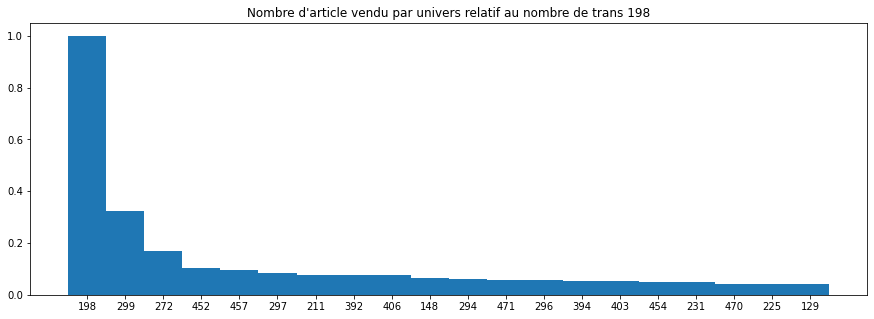

("Proportion d'achat (%)", 1.44)
('Proportion achat seul (%)', 7.03)
("Nombre moyen d'univ", 1.27)
('CA univ', 167544.81)
('CA moyen univ', 3.07)
('Nombre moyen article en plus', 4.61)
('CA en plus', 807911.63)
('CA moyen en plus', 14.79)
==============199===================


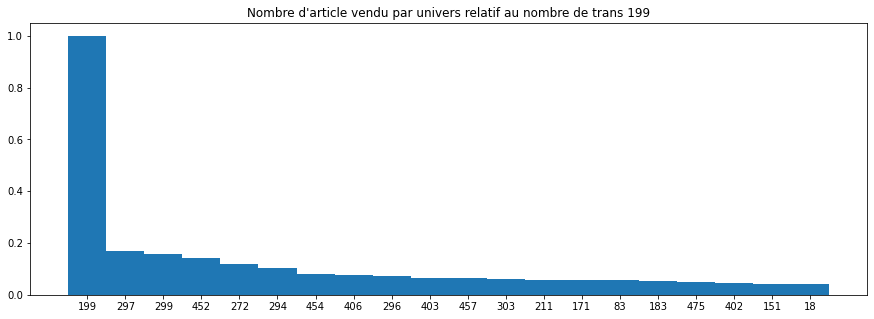

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 14.26)
("Nombre moyen d'univ", 1.18)
('CA univ', 16520.56)
('CA moyen univ', 8.39)
('Nombre moyen article en plus', 5.76)
('CA en plus', 41764.81)
('CA moyen en plus', 21.2)
==============200===================


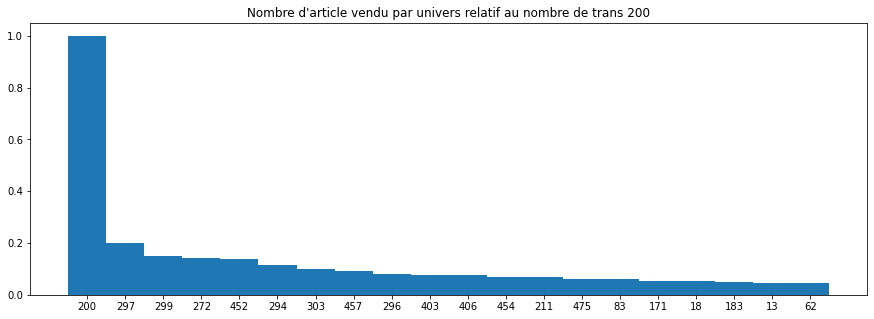

("Proportion d'achat (%)", 0.28)
('Proportion achat seul (%)', 10.04)
("Nombre moyen d'univ", 1.12)
('CA univ', 62036.95)
('CA moyen univ', 5.87)
('Nombre moyen article en plus', 6.33)
('CA en plus', 238434.39)
('CA moyen en plus', 22.55)
==============201===================


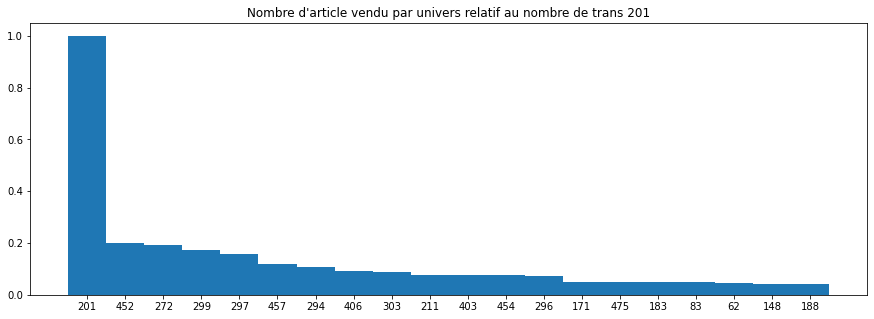

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 8.98)
("Nombre moyen d'univ", 1.26)
('CA univ', 124677.53)
('CA moyen univ', 5.6)
('Nombre moyen article en plus', 6.13)
('CA en plus', 476542.94)
('CA moyen en plus', 21.4)
==============203===================


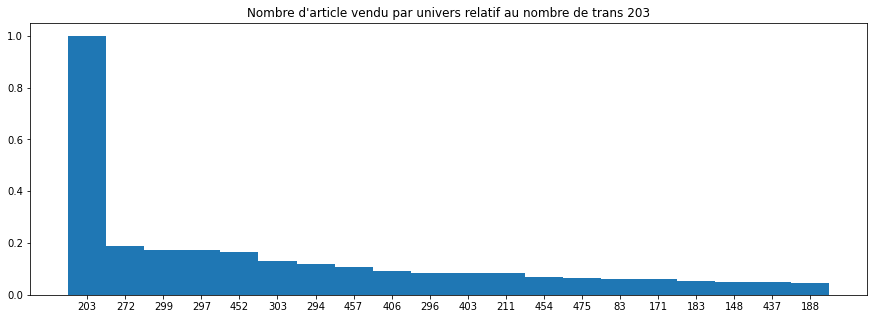

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 7.95)
("Nombre moyen d'univ", 1.06)
('CA univ', 12695.67)
('CA moyen univ', 3.46)
('Nombre moyen article en plus', 6.61)
('CA en plus', 82410.63)
('CA moyen en plus', 22.45)
==============204===================


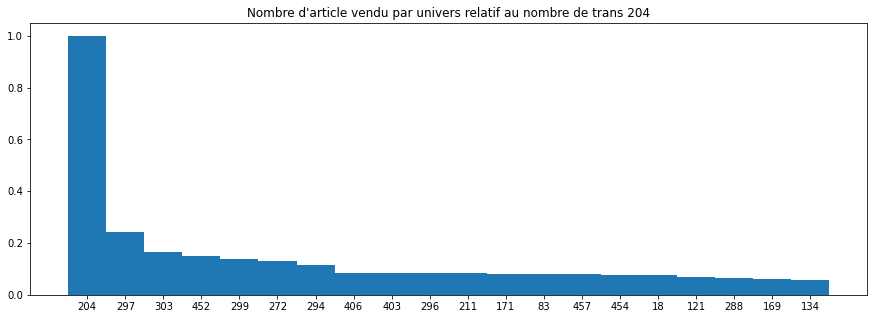

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 6.05)
("Nombre moyen d'univ", 1.05)
('CA univ', 4122.61)
('CA moyen univ', 5.31)
('Nombre moyen article en plus', 8.06)
('CA en plus', 21349.6)
('CA moyen en plus', 27.48)
==============205===================


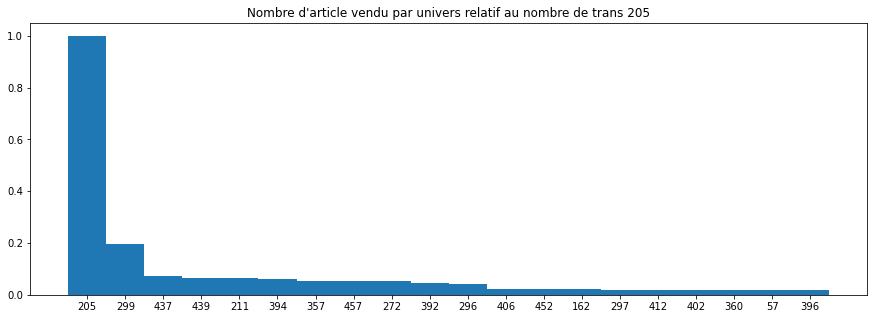

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 37.28)
("Nombre moyen d'univ", 1.11)
('CA univ', 630.58)
('CA moyen univ', 3.73)
('Nombre moyen article en plus', 1.83)
('CA en plus', 736.82)
('CA moyen en plus', 4.36)
==============206===================


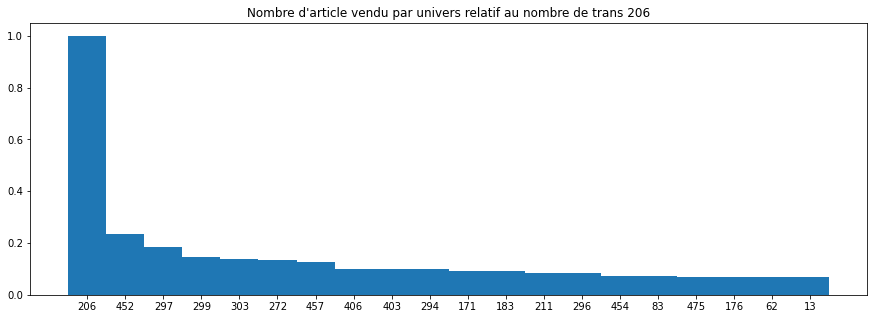

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 4.65)
("Nombre moyen d'univ", 1.12)
('CA univ', 7173.03)
('CA moyen univ', 4.17)
('Nombre moyen article en plus', 8.37)
('CA en plus', 51463.22)
('CA moyen en plus', 29.94)
==============207===================


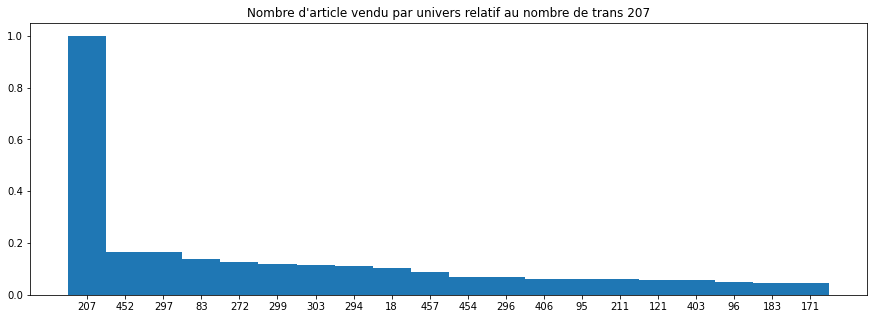

("Proportion d'achat (%)", 0.25)
('Proportion achat seul (%)', 10.43)
("Nombre moyen d'univ", 1.14)
('CA univ', 25523.58)
('CA moyen univ', 2.65)
('Nombre moyen article en plus', 6.02)
('CA en plus', 197503.61)
('CA moyen en plus', 20.52)
==============208===================


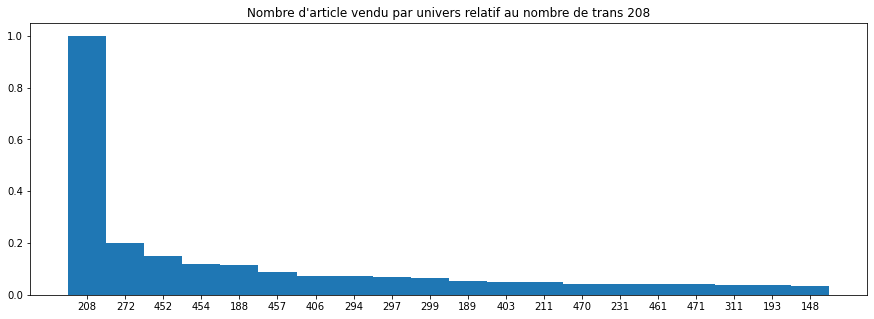

("Proportion d'achat (%)", 0.53)
('Proportion achat seul (%)', 14.06)
("Nombre moyen d'univ", 1.44)
('CA univ', 120343.59)
('CA moyen univ', 5.95)
('Nombre moyen article en plus', 4.22)
('CA en plus', 317179.86)
('CA moyen en plus', 15.67)
==============209===================


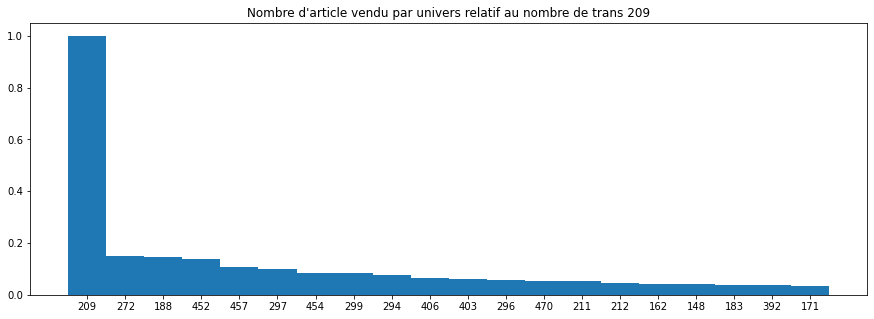

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 10.18)
("Nombre moyen d'univ", 1.39)
('CA univ', 22430.48)
('CA moyen univ', 4.59)
('Nombre moyen article en plus', 4.83)
('CA en plus', 84350.99)
('CA moyen en plus', 17.28)
==============210===================


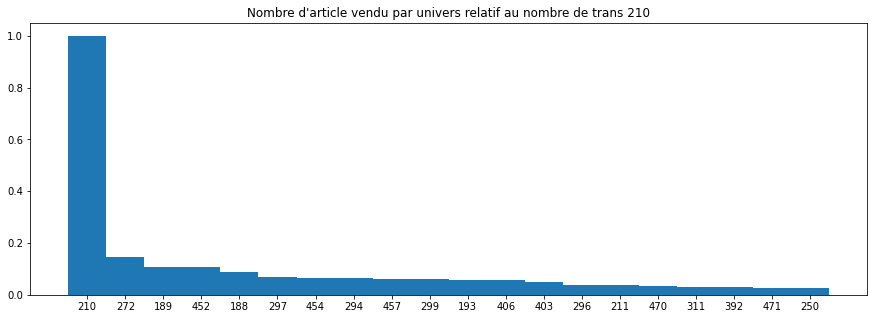

("Proportion d'achat (%)", 0.72)
('Proportion achat seul (%)', 22.55)
("Nombre moyen d'univ", 1.41)
('CA univ', 120021.27)
('CA moyen univ', 4.38)
('Nombre moyen article en plus', 3.43)
('CA en plus', 334453.21)
('CA moyen en plus', 12.22)
==============211===================


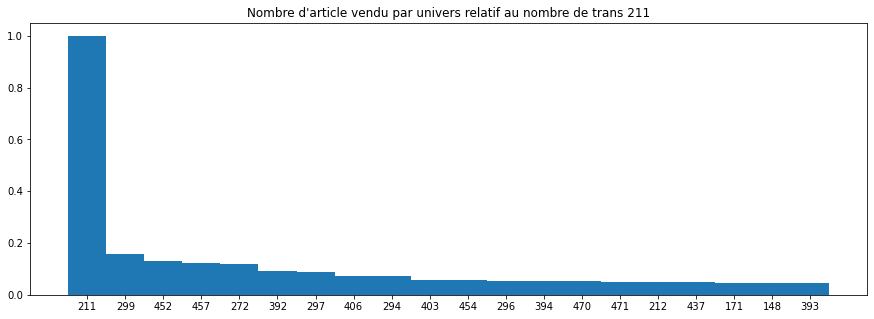

("Proportion d'achat (%)", 5.28)
('Proportion achat seul (%)', 8.7)
("Nombre moyen d'univ", 1.19)
('CA univ', 404284.23)
('CA moyen univ', 2.02)
('Nombre moyen article en plus', 4.67)
('CA en plus', 3079810.68)
('CA moyen en plus', 15.38)
==============212===================


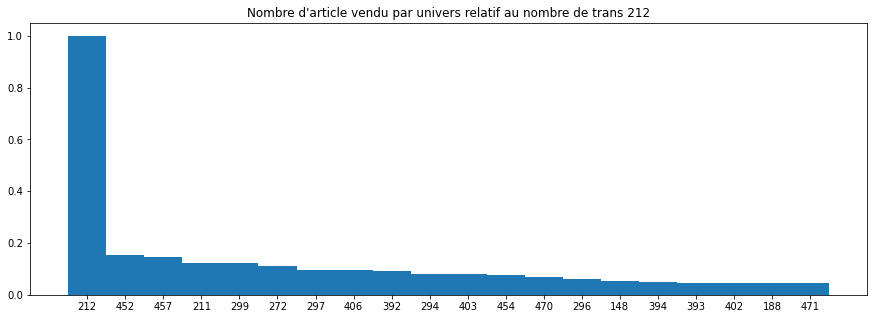

("Proportion d'achat (%)", 2.12)
('Proportion achat seul (%)', 5.47)
("Nombre moyen d'univ", 1.17)
('CA univ', 162250.42)
('CA moyen univ', 2.01)
('Nombre moyen article en plus', 5.41)
('CA en plus', 1532711.44)
('CA moyen en plus', 19.02)
==============214===================


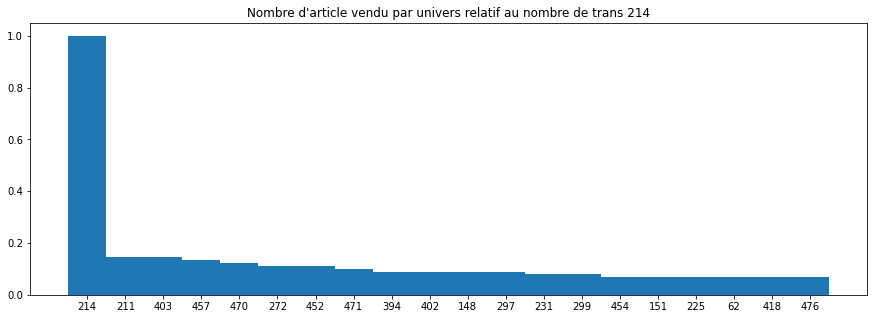

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 1.12)
("Nombre moyen d'univ", 1.04)
('CA univ', 157.4)
('CA moyen univ', 1.77)
('Nombre moyen article en plus', 5.27)
('CA en plus', 1702.84)
('CA moyen en plus', 19.13)
==============215===================


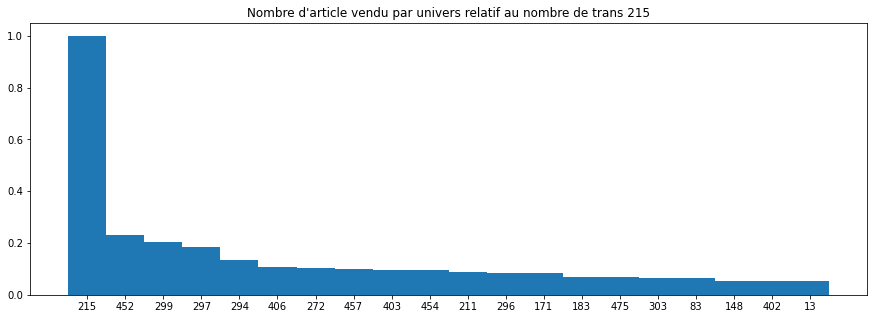

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 4.02)
("Nombre moyen d'univ", 1.17)
('CA univ', 88167.4)
('CA moyen univ', 5.4)
('Nombre moyen article en plus', 7.64)
('CA en plus', 438306.21)
('CA moyen en plus', 26.83)
==============216===================


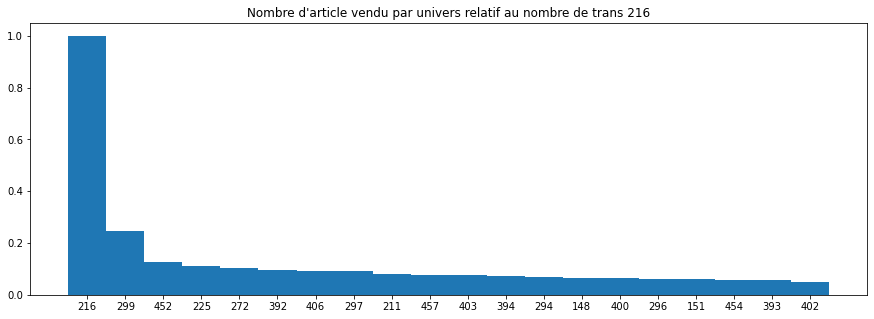

("Proportion d'achat (%)", 0.61)
('Proportion achat seul (%)', 3.34)
("Nombre moyen d'univ", 1.12)
('CA univ', 62685.07)
('CA moyen univ', 2.69)
('Nombre moyen article en plus', 5.29)
('CA en plus', 408228.64)
('CA moyen en plus', 17.54)
==============218===================


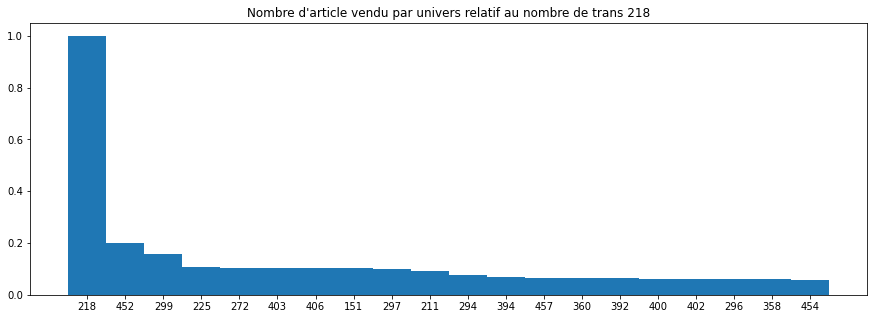

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 3.26)
("Nombre moyen d'univ", 1.25)
('CA univ', 13440.64)
('CA moyen univ', 3.15)
('Nombre moyen article en plus', 6.03)
('CA en plus', 86778.68)
('CA moyen en plus', 20.36)
==============219===================


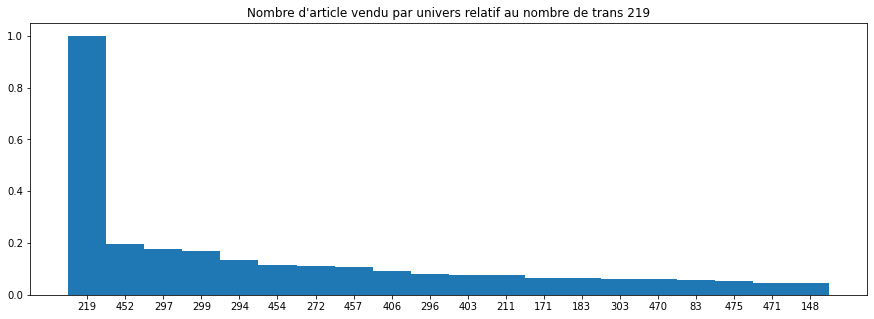

("Proportion d'achat (%)", 0.76)
('Proportion achat seul (%)', 5.42)
("Nombre moyen d'univ", 1.21)
('CA univ', 103770.17)
('CA moyen univ', 3.61)
('Nombre moyen article en plus', 6.85)
('CA en plus', 690435.99)
('CA moyen en plus', 24.01)
==============220===================


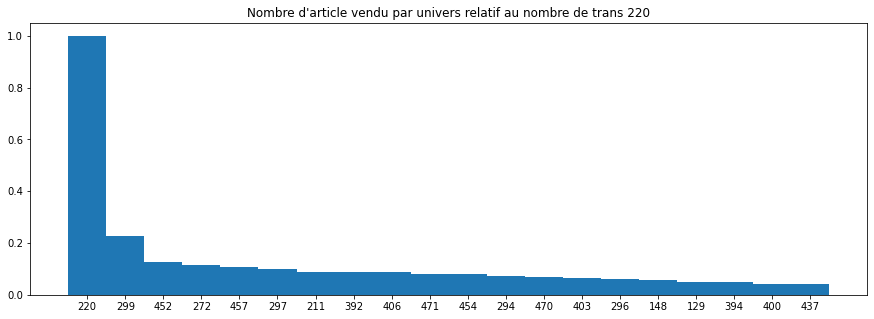

("Proportion d'achat (%)", 0.97)
('Proportion achat seul (%)', 6.48)
("Nombre moyen d'univ", 1.2)
('CA univ', 68591.88)
('CA moyen univ', 1.87)
('Nombre moyen article en plus', 5.25)
('CA en plus', 609459.76)
('CA moyen en plus', 16.64)
==============221===================
NOT ENOUGH DATA 
==============222===================


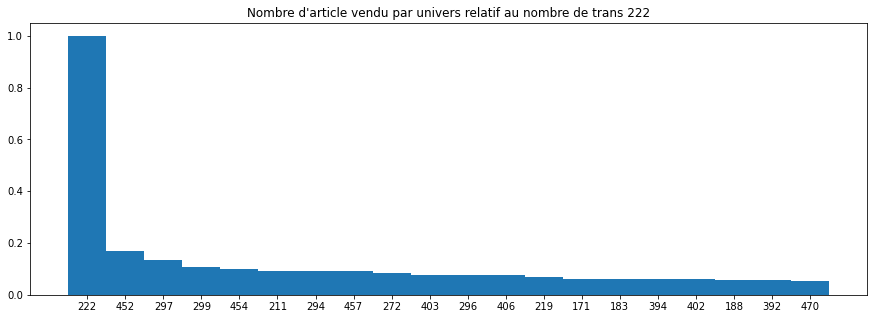

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 4.46)
("Nombre moyen d'univ", 1.19)
('CA univ', 12746.58)
('CA moyen univ', 2.75)
('Nombre moyen article en plus', 6.44)
('CA en plus', 105545.15)
('CA moyen en plus', 22.76)
==============223===================


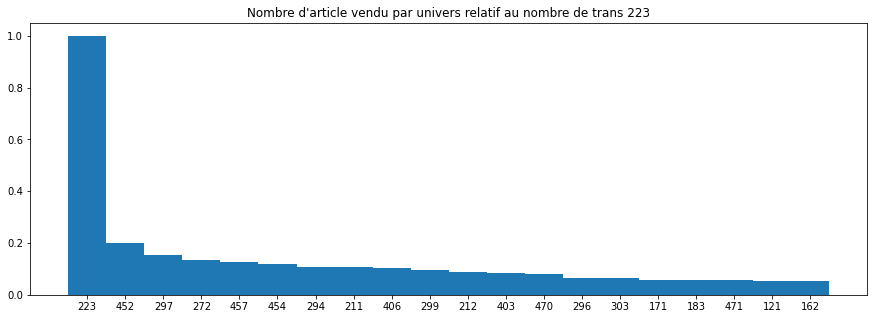

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 6.59)
("Nombre moyen d'univ", 1.07)
('CA univ', 22433.35)
('CA moyen univ', 6.27)
('Nombre moyen article en plus', 6.84)
('CA en plus', 89913.95)
('CA moyen en plus', 25.12)
==============224===================


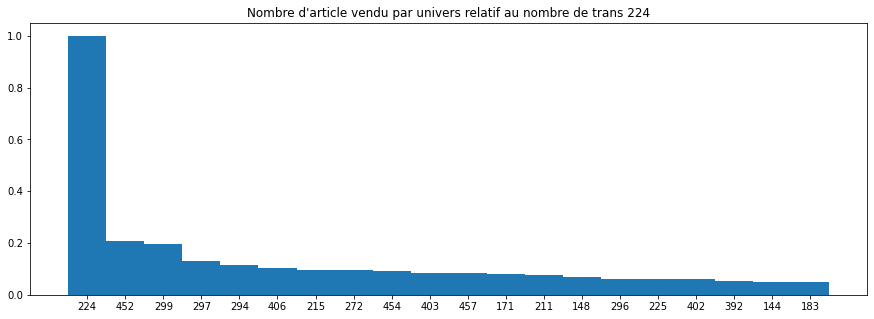

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.86)
("Nombre moyen d'univ", 1.1)
('CA univ', 16501.04)
('CA moyen univ', 4.48)
('Nombre moyen article en plus', 6.6)
('CA en plus', 82812.31)
('CA moyen en plus', 22.5)
==============225===================


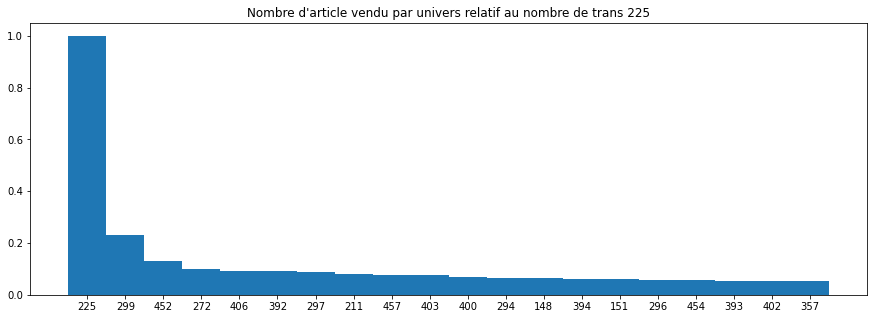

("Proportion d'achat (%)", 2.02)
('Proportion achat seul (%)', 4.16)
("Nombre moyen d'univ", 1.2)
('CA univ', 262493.23)
('CA moyen univ', 3.42)
('Nombre moyen article en plus', 4.99)
('CA en plus', 1273085.81)
('CA moyen en plus', 16.58)
==============231===================


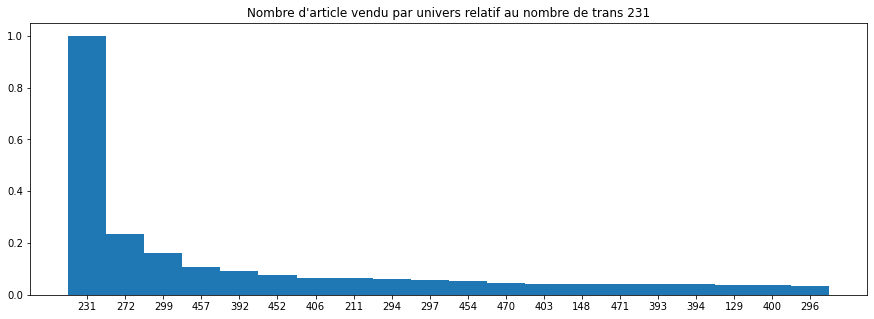

("Proportion d'achat (%)", 3.37)
('Proportion achat seul (%)', 14.05)
("Nombre moyen d'univ", 1.27)
('CA univ', 332991.23)
('CA moyen univ', 2.6)
('Nombre moyen article en plus', 3.46)
('CA en plus', 1520101.52)
('CA moyen en plus', 11.89)
==============232===================


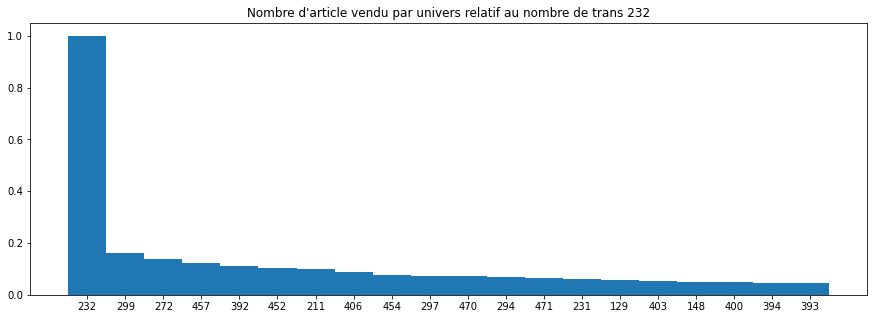

("Proportion d'achat (%)", 0.91)
('Proportion achat seul (%)', 8.41)
("Nombre moyen d'univ", 1.17)
('CA univ', 76128.17)
('CA moyen univ', 2.21)
('Nombre moyen article en plus', 4.4)
('CA en plus', 482769.72)
('CA moyen en plus', 13.99)
==============233===================


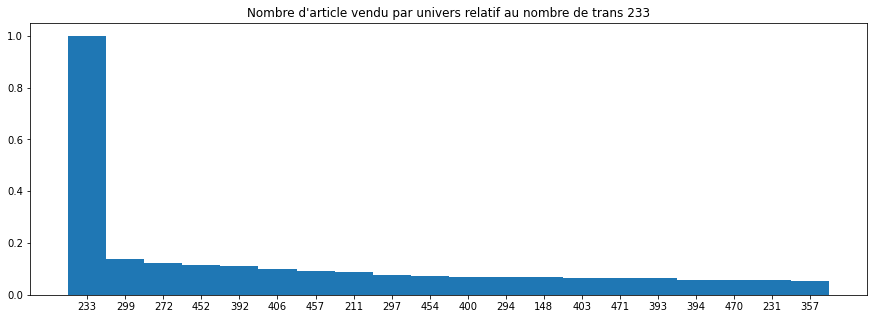

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 5.32)
("Nombre moyen d'univ", 1.18)
('CA univ', 41750.78)
('CA moyen univ', 2.44)
('Nombre moyen article en plus', 4.72)
('CA en plus', 276798.93)
('CA moyen en plus', 16.16)
==============235===================


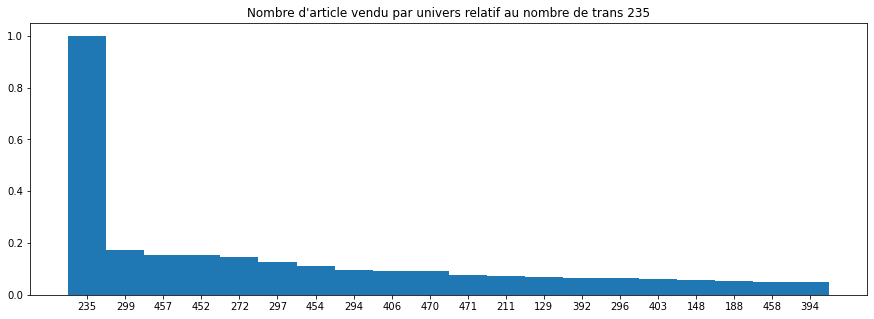

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 5.23)
("Nombre moyen d'univ", 1.41)
('CA univ', 13955.89)
('CA moyen univ', 1.41)
('Nombre moyen article en plus', 5.64)
('CA en plus', 176965.37)
('CA moyen en plus', 17.86)
==============236===================


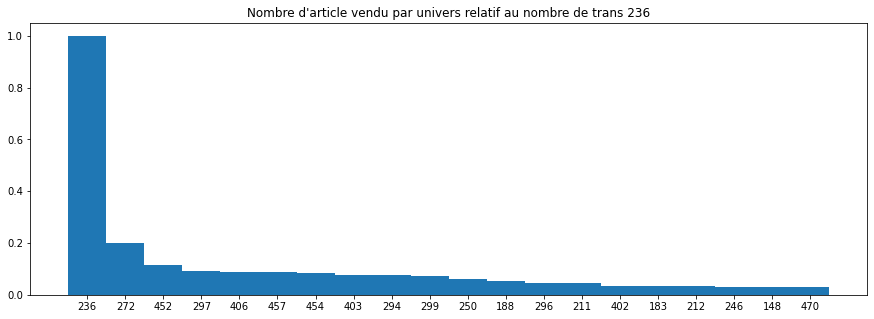

("Proportion d'achat (%)", 0.4)
('Proportion achat seul (%)', 12.97)
("Nombre moyen d'univ", 1.46)
('CA univ', 113162.52)
('CA moyen univ', 7.42)
('Nombre moyen article en plus', 4.2)
('CA en plus', 255195.52)
('CA moyen en plus', 16.73)
==============237===================


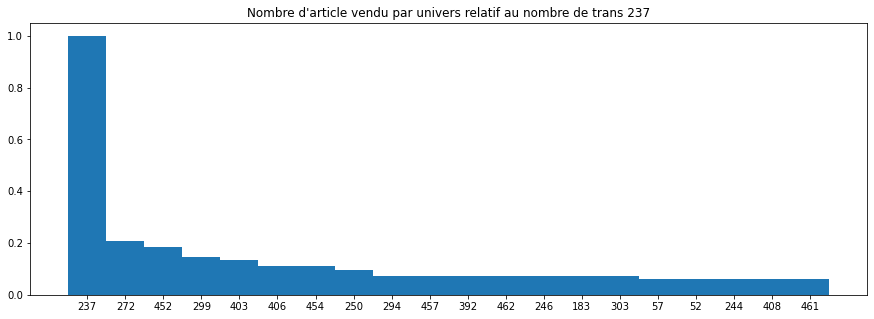

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 7.32)
("Nombre moyen d'univ", 1.21)
('CA univ', 1015.79)
('CA moyen univ', 12.39)
('Nombre moyen article en plus', 6.6)
('CA en plus', 2548.15)
('CA moyen en plus', 31.08)
==============238===================


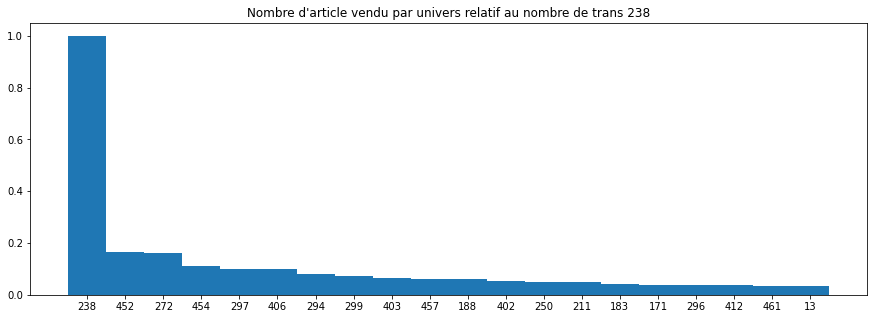

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 12.79)
("Nombre moyen d'univ", 1.22)
('CA univ', 32999.6)
('CA moyen univ', 9.89)
('Nombre moyen article en plus', 4.9)
('CA en plus', 66648.9)
('CA moyen en plus', 19.97)
==============239===================


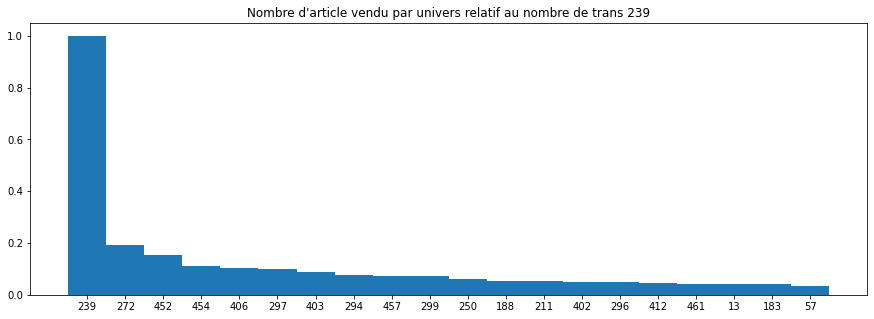

("Proportion d'achat (%)", 0.33)
('Proportion achat seul (%)', 12.43)
("Nombre moyen d'univ", 1.31)
('CA univ', 127464.32)
('CA moyen univ', 10.22)
('Nombre moyen article en plus', 4.92)
('CA en plus', 253928.43)
('CA moyen en plus', 20.35)
==============240===================


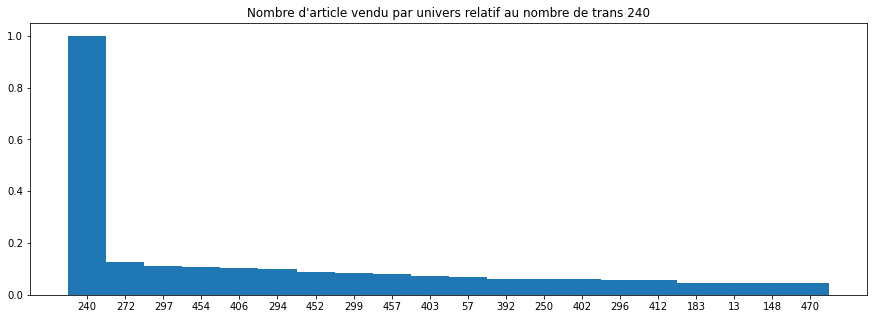

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 10.68)
("Nombre moyen d'univ", 1.31)
('CA univ', 6139.5)
('CA moyen univ', 18.22)
('Nombre moyen article en plus', 5.39)
('CA en plus', 7533.4)
('CA moyen en plus', 22.35)
==============241===================


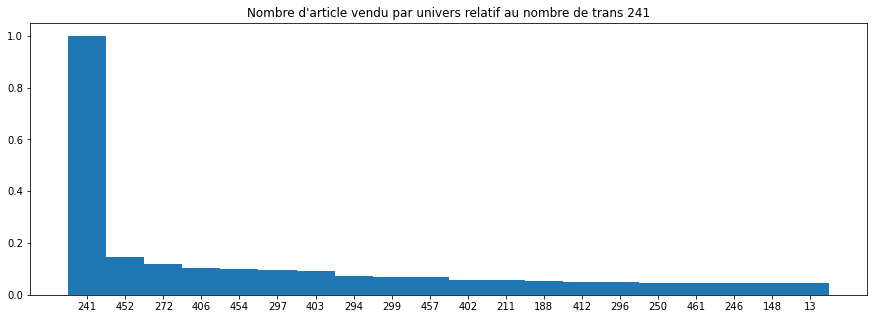

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 10.59)
("Nombre moyen d'univ", 1.28)
('CA univ', 32764.8)
('CA moyen univ', 9.18)
('Nombre moyen article en plus', 5.3)
('CA en plus', 74561.89)
('CA moyen en plus', 20.89)
==============242===================


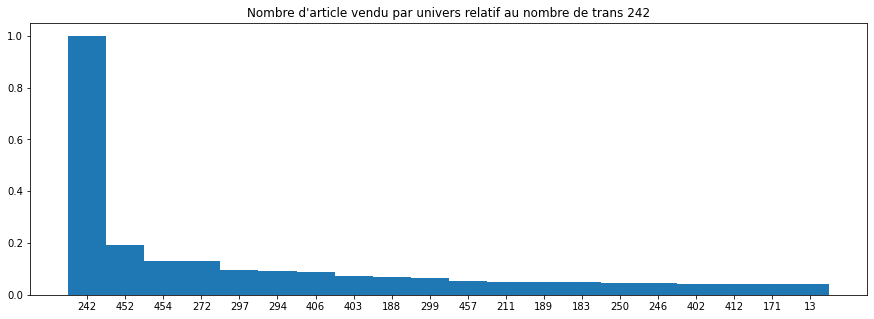

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 10.46)
("Nombre moyen d'univ", 1.17)
('CA univ', 28367.33)
('CA moyen univ', 11.37)
('Nombre moyen article en plus', 5.28)
('CA en plus', 55013.9)
('CA moyen en plus', 22.04)
==============243===================


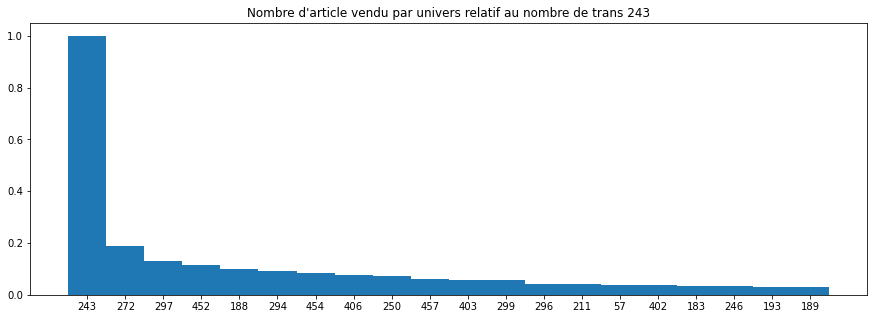

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 14.62)
("Nombre moyen d'univ", 1.2)
('CA univ', 10512.38)
('CA moyen univ', 6.27)
('Nombre moyen article en plus', 3.82)
('CA en plus', 23816.7)
('CA moyen en plus', 14.21)
==============244===================


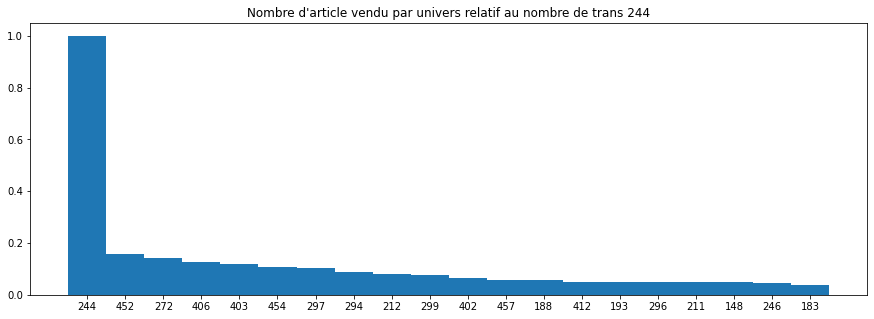

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 9.2)
("Nombre moyen d'univ", 1.26)
('CA univ', 34797.22)
('CA moyen univ', 12.46)
('Nombre moyen article en plus', 5.52)
('CA en plus', 60920.86)
('CA moyen en plus', 21.81)
==============245===================


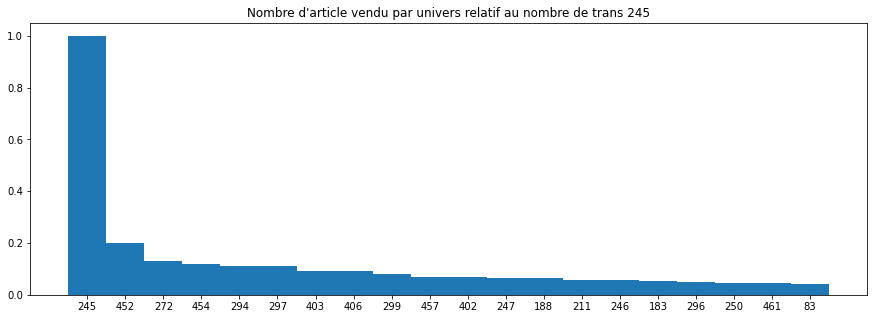

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 9.36)
("Nombre moyen d'univ", 1.35)
('CA univ', 24275.34)
('CA moyen univ', 14.38)
('Nombre moyen article en plus', 5.95)
('CA en plus', 43947.65)
('CA moyen en plus', 26.04)
==============246===================


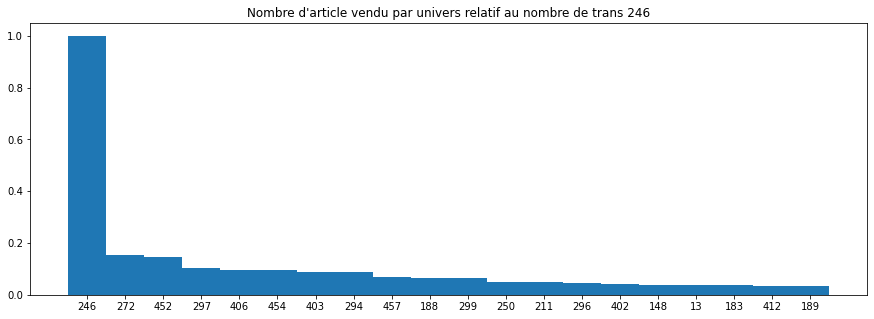

("Proportion d'achat (%)", 1.37)
('Proportion achat seul (%)', 13.03)
("Nombre moyen d'univ", 1.33)
('CA univ', 578871.46)
('CA moyen univ', 11.1)
('Nombre moyen article en plus', 4.64)
('CA en plus', 967402.14)
('CA moyen en plus', 18.55)
==============247===================


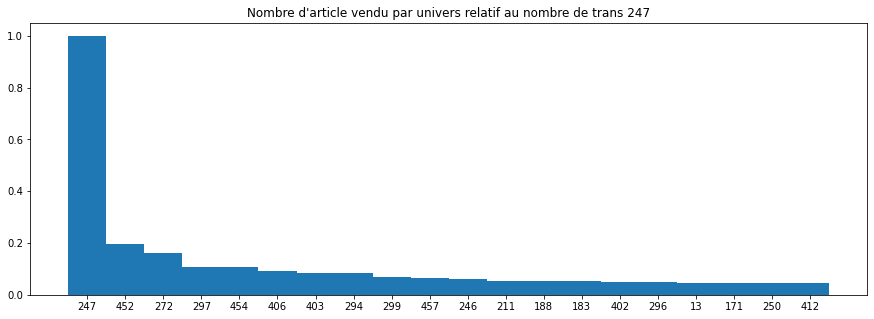

("Proportion d'achat (%)", 0.23)
('Proportion achat seul (%)', 9.27)
("Nombre moyen d'univ", 1.31)
('CA univ', 121636.95)
('CA moyen univ', 14.19)
('Nombre moyen article en plus', 5.77)
('CA en plus', 210337.51)
('CA moyen en plus', 24.53)
==============248===================


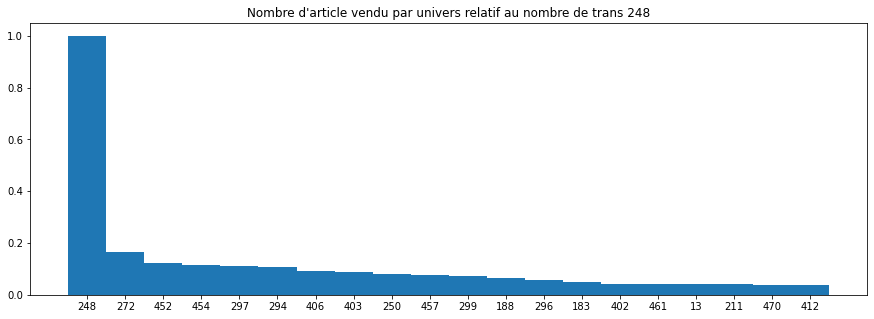

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 11.79)
("Nombre moyen d'univ", 1.31)
('CA univ', 47802.39)
('CA moyen univ', 8.29)
('Nombre moyen article en plus', 5.11)
('CA en plus', 113697.44)
('CA moyen en plus', 19.72)
==============249===================


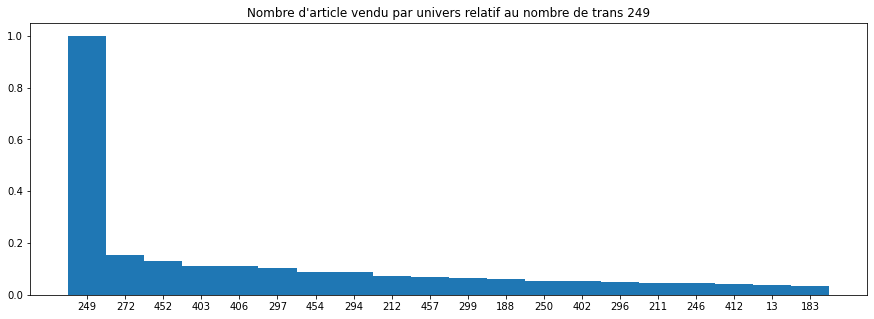

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 11.92)
("Nombre moyen d'univ", 1.28)
('CA univ', 214625.83)
('CA moyen univ', 8.37)
('Nombre moyen article en plus', 4.76)
('CA en plus', 473389.7)
('CA moyen en plus', 18.46)
==============250===================


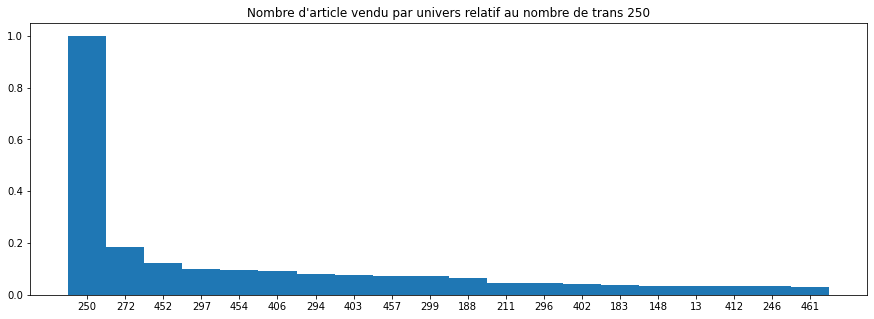

("Proportion d'achat (%)", 2.02)
('Proportion achat seul (%)', 13.56)
("Nombre moyen d'univ", 1.32)
('CA univ', 636739.87)
('CA moyen univ', 8.3)
('Nombre moyen article en plus', 4.37)
('CA en plus', 1304446.42)
('CA moyen en plus', 17.0)
==============251===================


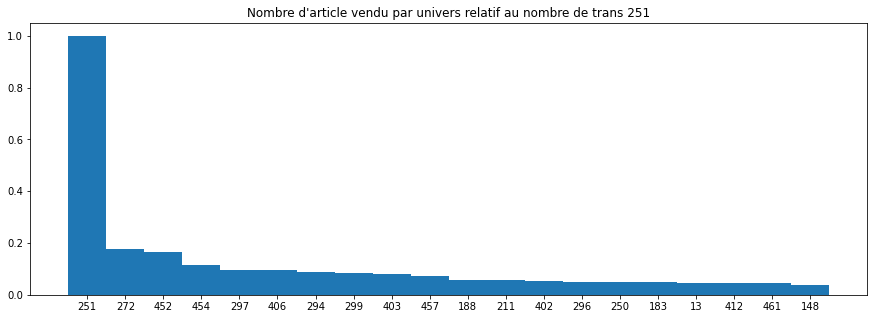

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 11.69)
("Nombre moyen d'univ", 1.42)
('CA univ', 293656.72)
('CA moyen univ', 15.93)
('Nombre moyen article en plus', 5.46)
('CA en plus', 404706.19)
('CA moyen en plus', 21.96)
==============252===================


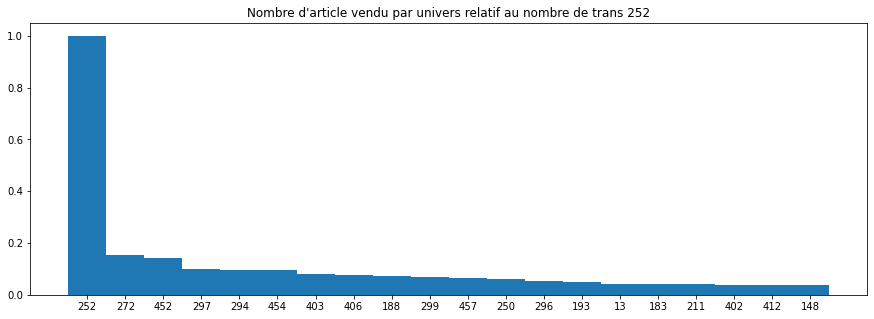

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 12.26)
("Nombre moyen d'univ", 1.24)
('CA univ', 47326.61)
('CA moyen univ', 9.91)
('Nombre moyen article en plus', 4.7)
('CA en plus', 87918.66)
('CA moyen en plus', 18.4)
==============253===================


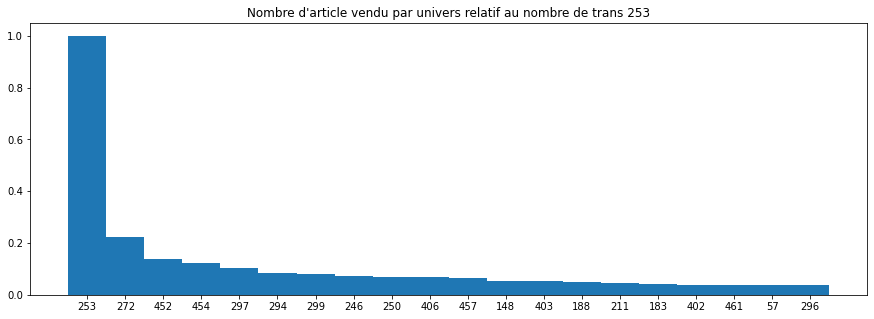

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 12.78)
("Nombre moyen d'univ", 1.15)
('CA univ', 6324.11)
('CA moyen univ', 7.85)
('Nombre moyen article en plus', 4.6)
('CA en plus', 14566.71)
('CA moyen en plus', 18.07)
==============254===================


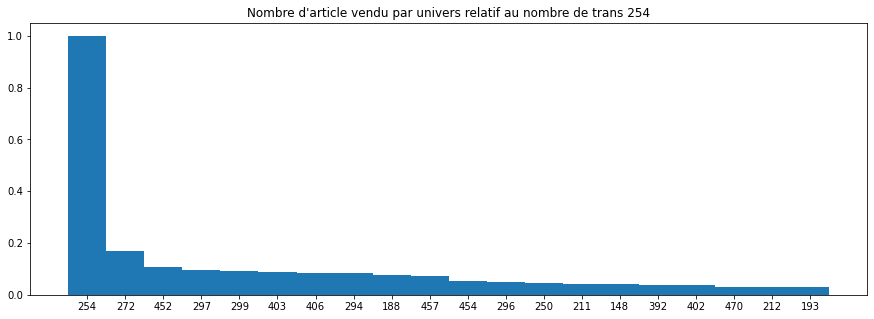

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 15.32)
("Nombre moyen d'univ", 1.17)
('CA univ', 48012.84)
('CA moyen univ', 4.84)
('Nombre moyen article en plus', 3.96)
('CA en plus', 144432.63)
('CA moyen en plus', 14.55)
==============255===================


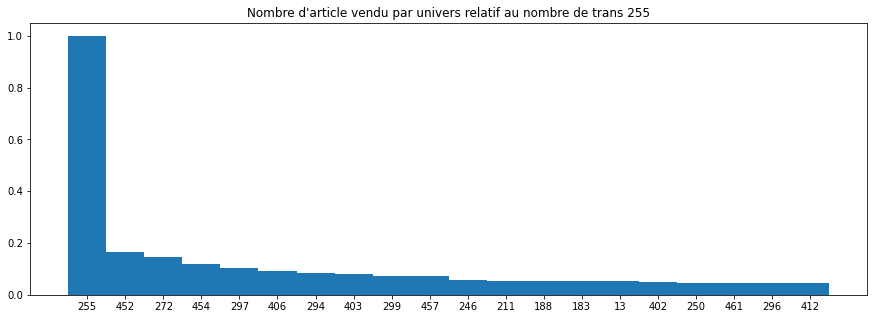

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 10.0)
("Nombre moyen d'univ", 1.24)
('CA univ', 136029.91)
('CA moyen univ', 13.26)
('Nombre moyen article en plus', 5.52)
('CA en plus', 238008.3)
('CA moyen en plus', 23.2)
==============256===================


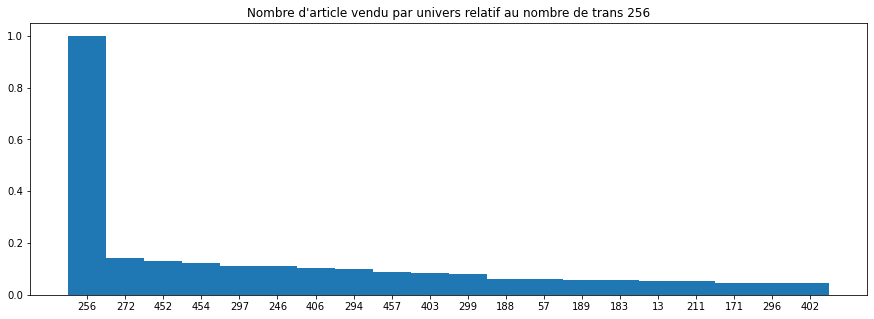

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 8.78)
("Nombre moyen d'univ", 1.1)
('CA univ', 9534.87)
('CA moyen univ', 10.21)
('Nombre moyen article en plus', 5.05)
('CA en plus', 19482.77)
('CA moyen en plus', 20.86)
==============258===================


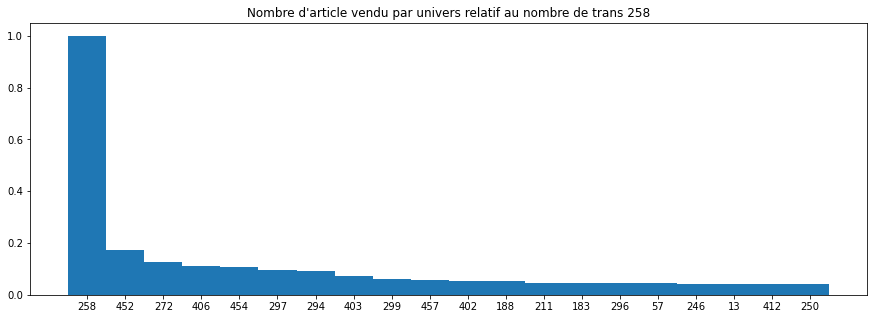

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 12.76)
("Nombre moyen d'univ", 1.27)
('CA univ', 118463.77)
('CA moyen univ', 11.81)
('Nombre moyen article en plus', 5.03)
('CA en plus', 210406.88)
('CA moyen en plus', 20.97)
==============259===================


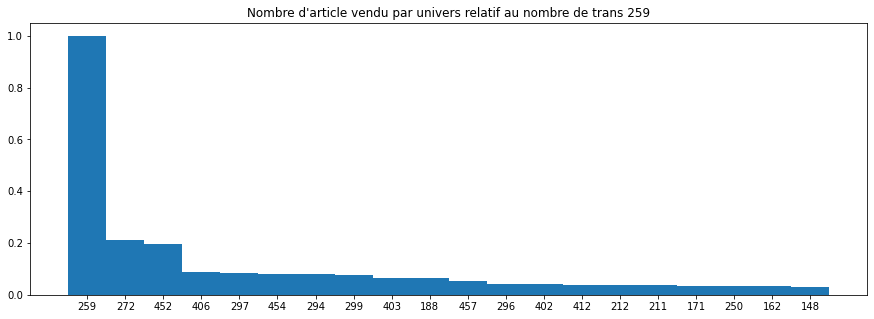

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 14.15)
("Nombre moyen d'univ", 1.61)
('CA univ', 25293.38)
('CA moyen univ', 7.52)
('Nombre moyen article en plus', 4.56)
('CA en plus', 58699.7)
('CA moyen en plus', 17.44)
==============262===================


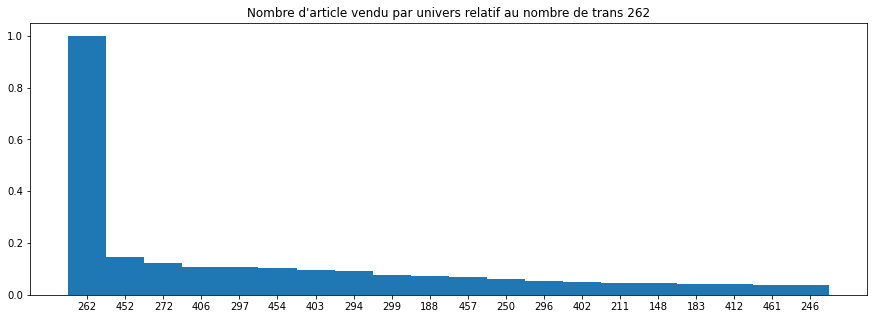

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 10.73)
("Nombre moyen d'univ", 1.21)
('CA univ', 64881.95)
('CA moyen univ', 7.91)
('Nombre moyen article en plus', 4.98)
('CA en plus', 160539.69)
('CA moyen en plus', 19.57)
==============263===================


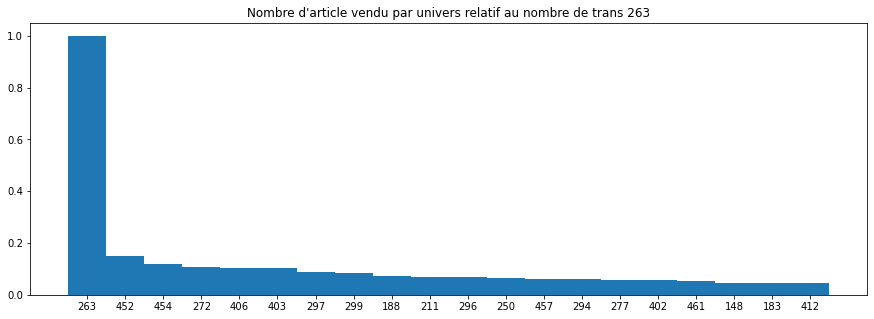

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 10.65)
("Nombre moyen d'univ", 1.35)
('CA univ', 34774.57)
('CA moyen univ', 12.64)
('Nombre moyen article en plus', 5.47)
('CA en plus', 59113.59)
('CA moyen en plus', 21.49)
==============264===================


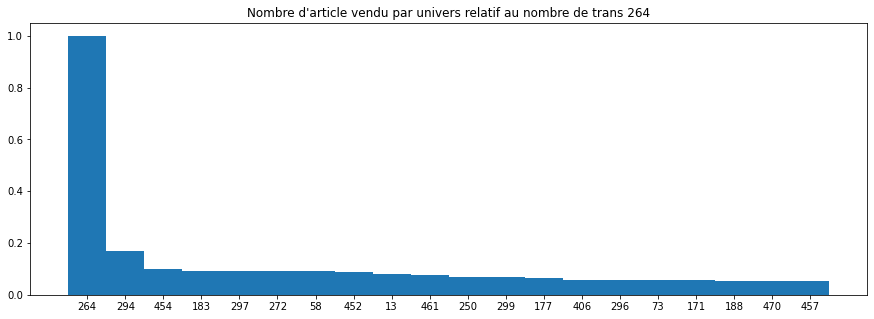

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 9.25)
("Nombre moyen d'univ", 1.55)
('CA univ', 2435.98)
('CA moyen univ', 14.08)
('Nombre moyen article en plus', 4.85)
('CA en plus', 3288.34)
('CA moyen en plus', 19.01)
==============265===================


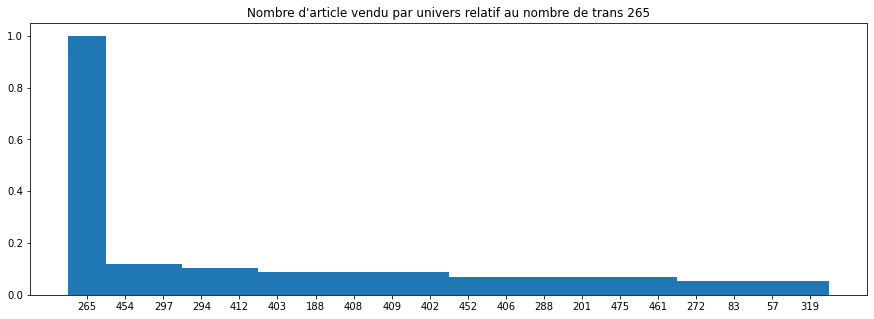

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 17.24)
("Nombre moyen d'univ", 1.29)
('CA univ', 1952.42)
('CA moyen univ', 33.66)
('Nombre moyen article en plus', 6.45)
('CA en plus', 1745.76)
('CA moyen en plus', 30.1)
==============266===================


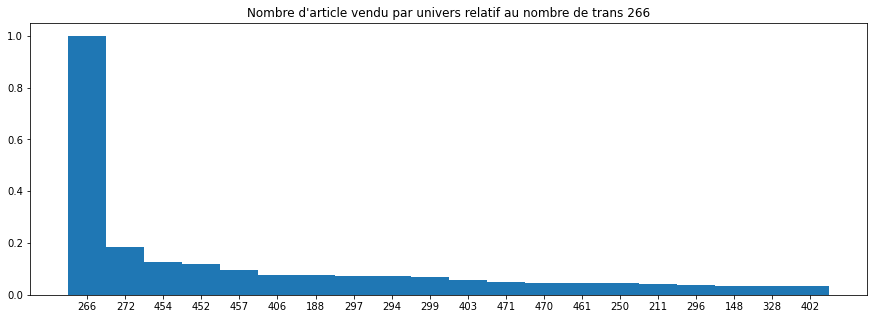

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 18.1)
("Nombre moyen d'univ", 1.52)
('CA univ', 23648.0)
('CA moyen univ', 5.12)
('Nombre moyen article en plus', 4.02)
('CA en plus', 70326.27)
('CA moyen en plus', 15.23)
==============267===================


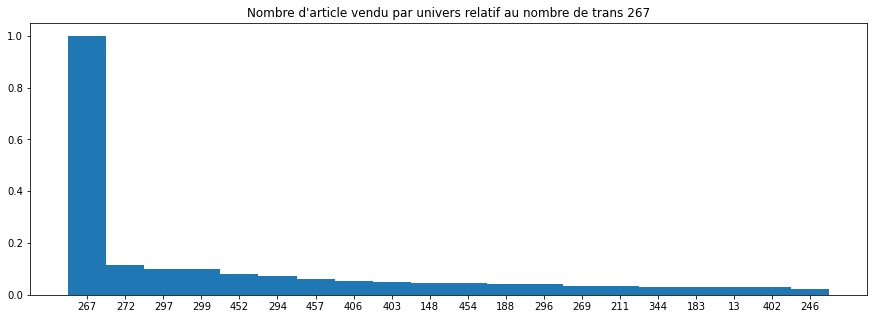

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 24.6)
("Nombre moyen d'univ", 1.12)
('CA univ', -27.46)
('CA moyen univ', -0.02)
('Nombre moyen article en plus', 3.52)
('CA en plus', 23806.69)
('CA moyen en plus', 14.11)
==============268===================
NOT ENOUGH DATA 
==============269===================


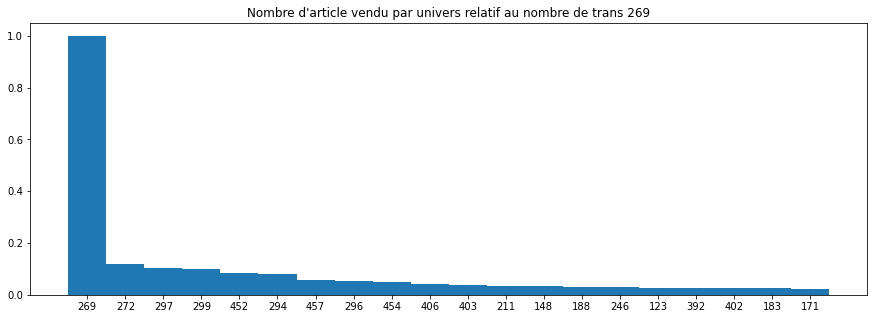

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 27.6)
("Nombre moyen d'univ", 1.12)
('CA univ', 350125.42)
('CA moyen univ', 19.28)
('Nombre moyen article en plus', 3.62)
('CA en plus', 266610.33)
('CA moyen en plus', 14.68)
==============270===================


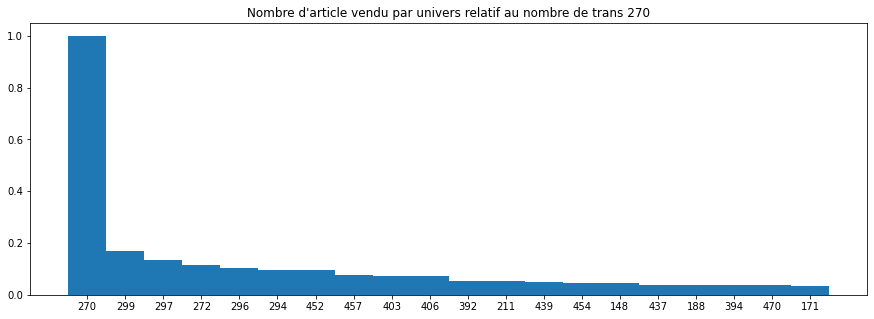

("Proportion d'achat (%)", 0.65)
('Proportion achat seul (%)', 14.92)
("Nombre moyen d'univ", 1.19)
('CA univ', 108850.72)
('CA moyen univ', 4.4)
('Nombre moyen article en plus', 4.68)
('CA en plus', 406130.9)
('CA moyen en plus', 16.4)
==============271===================


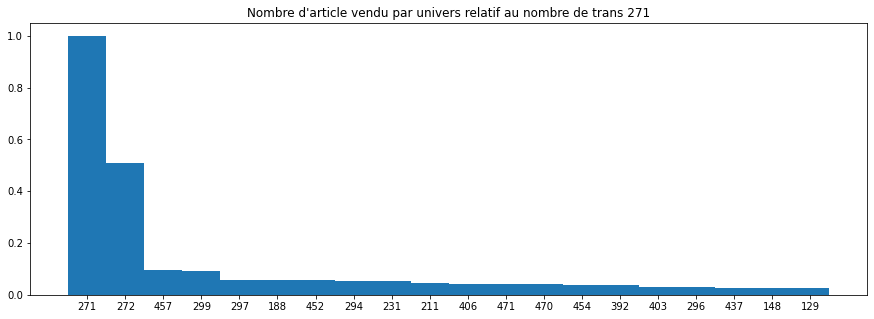

("Proportion d'achat (%)", 0.93)
('Proportion achat seul (%)', 18.0)
("Nombre moyen d'univ", 1.09)
('CA univ', 41165.57)
('CA moyen univ', 1.17)
('Nombre moyen article en plus', 3.11)
('CA en plus', 442328.81)
('CA moyen en plus', 12.54)
==============272===================


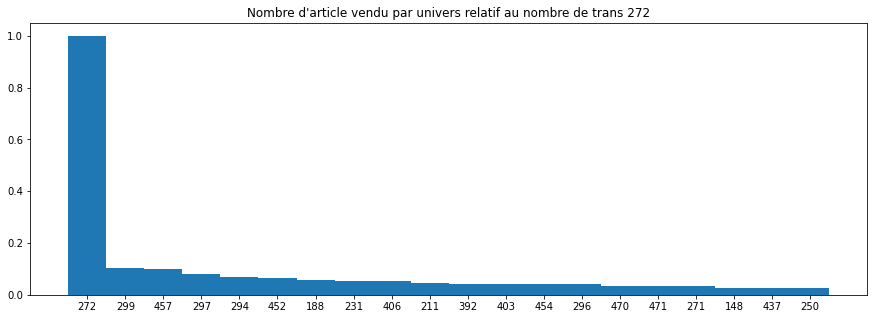

("Proportion d'achat (%)", 14.44)
('Proportion achat seul (%)', 26.44)
("Nombre moyen d'univ", 1.18)
('CA univ', 5002260.48)
('CA moyen univ', 9.13)
('Nombre moyen article en plus', 2.99)
('CA en plus', 5480833.6)
('CA moyen en plus', 10.0)
==============273===================


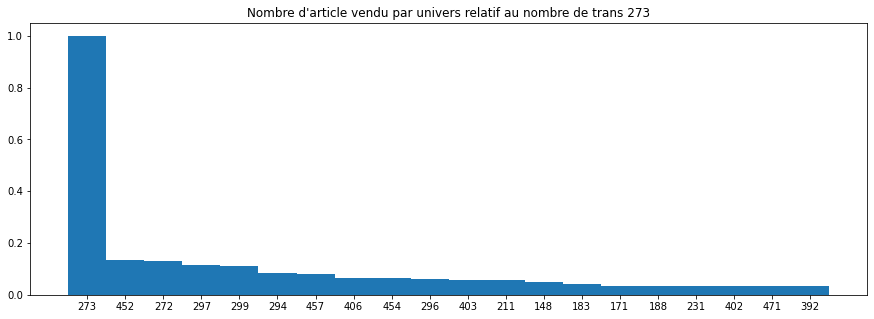

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 14.42)
("Nombre moyen d'univ", 1.2)
('CA univ', 46304.72)
('CA moyen univ', 6.4)
('Nombre moyen article en plus', 5.24)
('CA en plus', 124446.29)
('CA moyen en plus', 17.21)
==============275===================


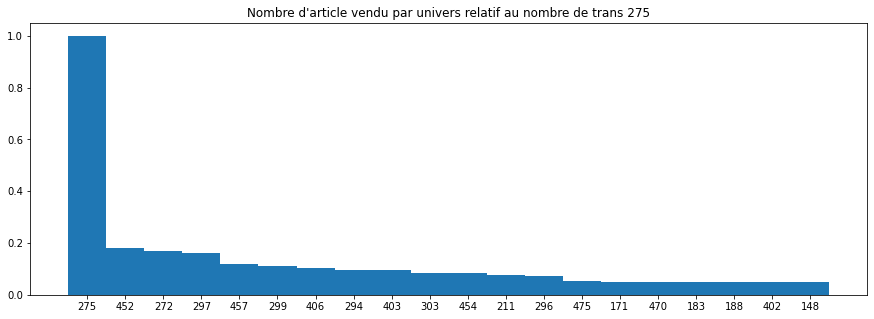

("Proportion d'achat (%)", 0.46)
('Proportion achat seul (%)', 8.9)
("Nombre moyen d'univ", 1.7)
('CA univ', 86478.13)
('CA moyen univ', 4.98)
('Nombre moyen article en plus', 6.38)
('CA en plus', 399685.2)
('CA moyen en plus', 23.01)
==============276===================


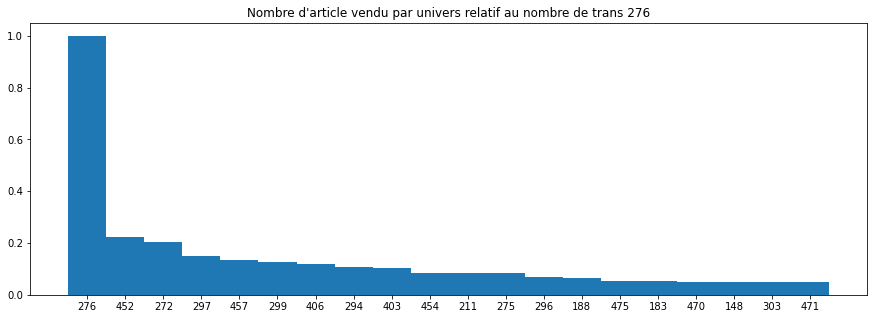

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 7.65)
("Nombre moyen d'univ", 1.55)
('CA univ', 57344.11)
('CA moyen univ', 5.81)
('Nombre moyen article en plus', 6.91)
('CA en plus', 240575.04)
('CA moyen en plus', 24.36)
==============277===================


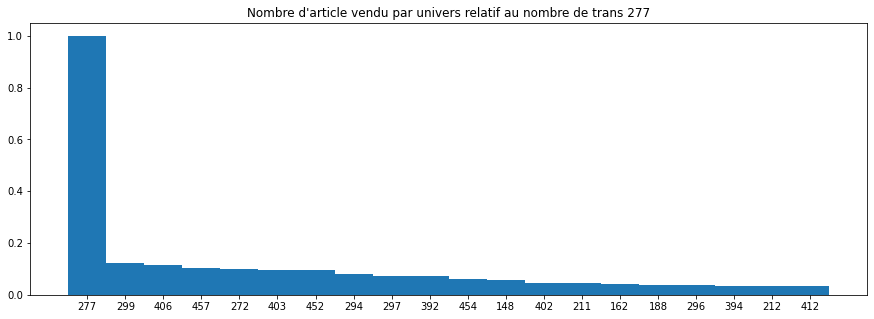

("Proportion d'achat (%)", 1.03)
('Proportion achat seul (%)', 20.07)
("Nombre moyen d'univ", 1.47)
('CA univ', 113430.87)
('CA moyen univ', 2.91)
('Nombre moyen article en plus', 4.3)
('CA en plus', 654789.85)
('CA moyen en plus', 16.81)
==============279===================
NOT ENOUGH DATA 
==============286===================


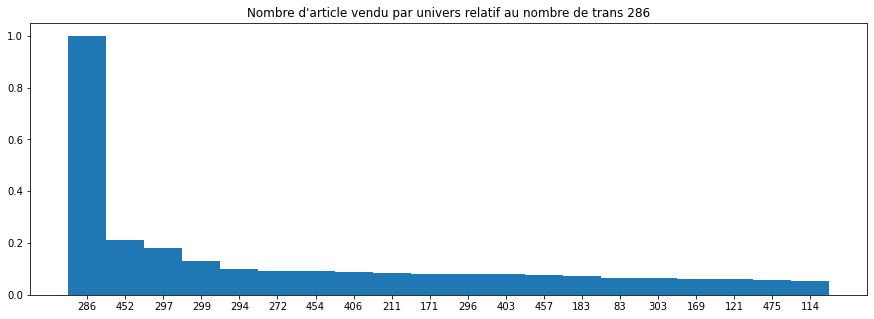

("Proportion d'achat (%)", 0.21)
('Proportion achat seul (%)', 5.96)
("Nombre moyen d'univ", 1.17)
('CA univ', 41266.08)
('CA moyen univ', 5.08)
('Nombre moyen article en plus', 7.16)
('CA en plus', 203246.92)
('CA moyen en plus', 25.04)
==============287===================


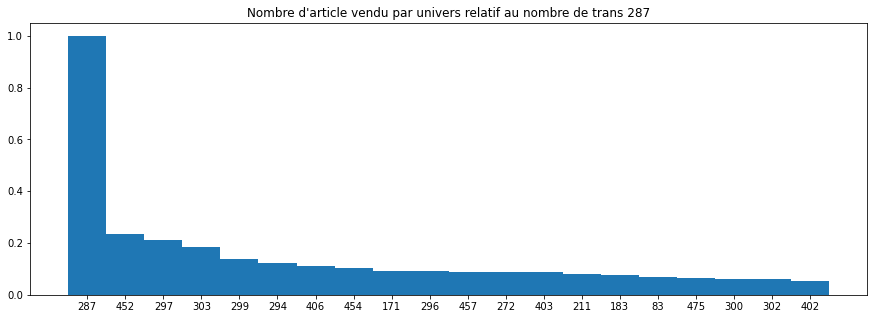

("Proportion d'achat (%)", 0.72)
('Proportion achat seul (%)', 4.01)
("Nombre moyen d'univ", 1.13)
('CA univ', 138069.53)
('CA moyen univ', 5.05)
('Nombre moyen article en plus', 7.51)
('CA en plus', 705188.31)
('CA moyen en plus', 25.8)
==============288===================


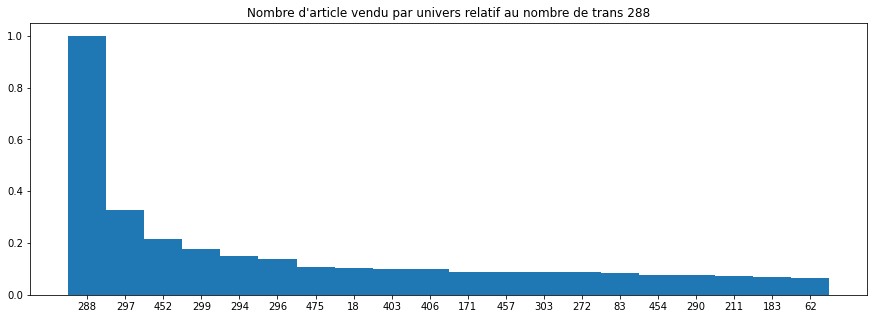

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 2.85)
("Nombre moyen d'univ", 1.15)
('CA univ', 74522.46)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 8.29)
('CA en plus', 462675.54)
('CA moyen en plus', 28.18)
==============289===================


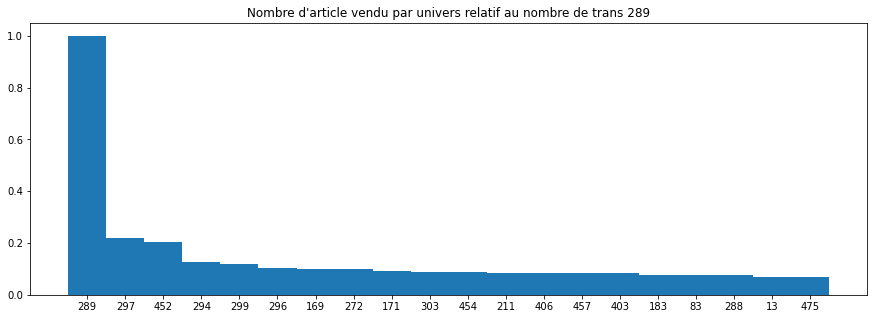

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 6.33)
("Nombre moyen d'univ", 1.07)
('CA univ', 18853.04)
('CA moyen univ', 4.99)
('Nombre moyen article en plus', 7.73)
('CA en plus', 100668.43)
('CA moyen en plus', 26.67)
==============290===================


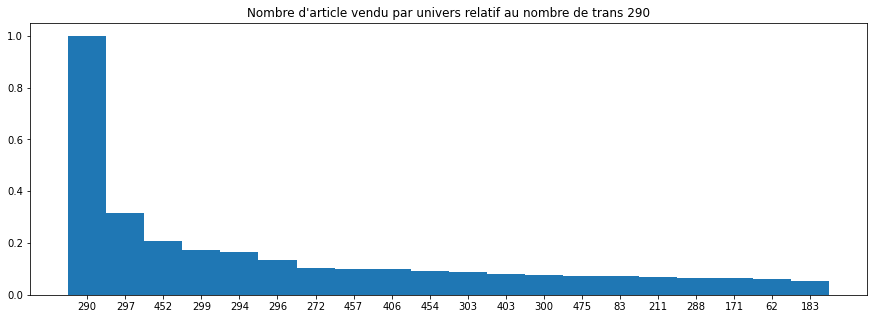

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 4.8)
("Nombre moyen d'univ", 1.06)
('CA univ', 83696.32)
('CA moyen univ', 4.51)
('Nombre moyen article en plus', 7.25)
('CA en plus', 447257.2)
('CA moyen en plus', 24.11)
==============291===================


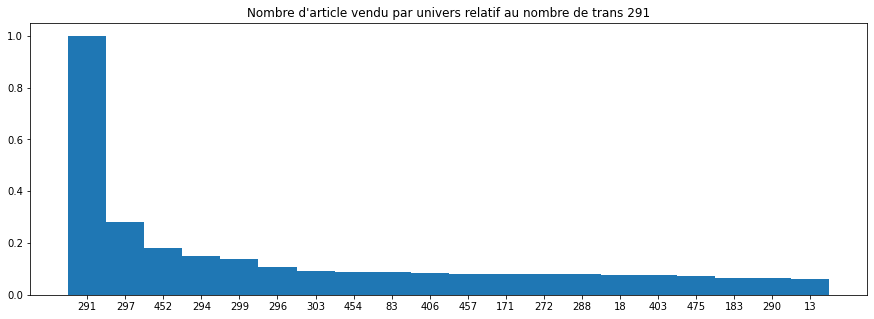

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 4.63)
("Nombre moyen d'univ", 1.06)
('CA univ', 10485.73)
('CA moyen univ', 4.26)
('Nombre moyen article en plus', 7.72)
('CA en plus', 63701.12)
('CA moyen en plus', 25.89)
==============292===================


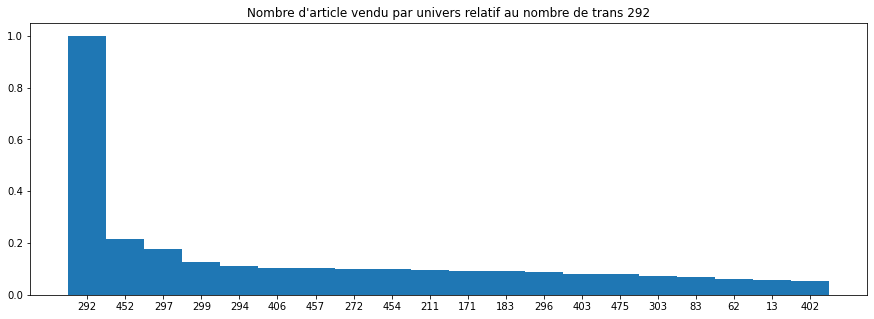

("Proportion d'achat (%)", 0.32)
('Proportion achat seul (%)', 3.54)
("Nombre moyen d'univ", 1.11)
('CA univ', 38137.34)
('CA moyen univ', 3.14)
('Nombre moyen article en plus', 7.44)
('CA en plus', 309062.63)
('CA moyen en plus', 25.45)
==============293===================


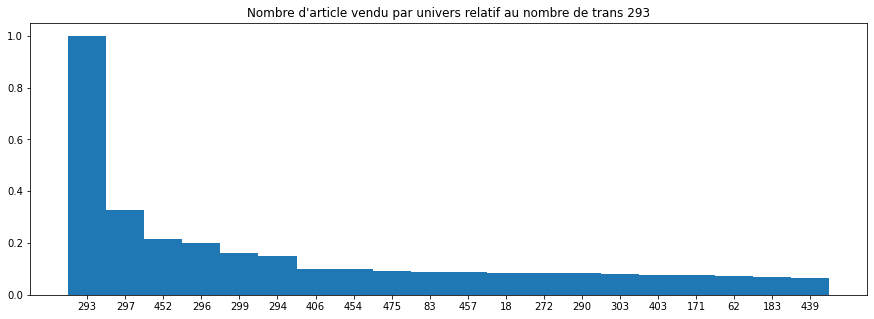

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 2.53)
("Nombre moyen d'univ", 1.18)
('CA univ', 21613.88)
('CA moyen univ', 4.23)
('Nombre moyen article en plus', 8.41)
('CA en plus', 145255.93)
('CA moyen en plus', 28.45)
==============294===================


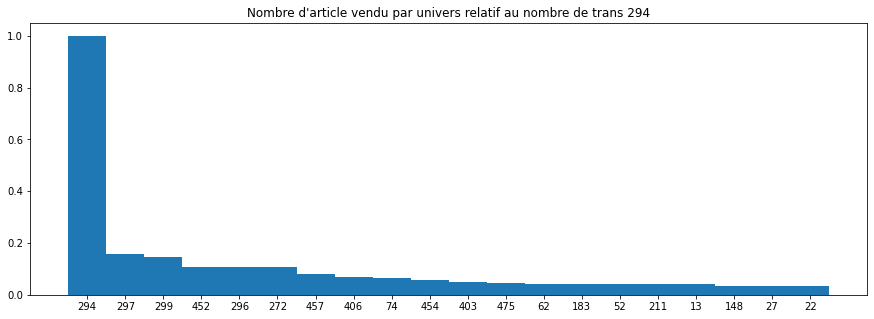

("Proportion d'achat (%)", 9.45)
('Proportion achat seul (%)', 15.28)
("Nombre moyen d'univ", 1.31)
('CA univ', 738429.89)
('CA moyen univ', 2.06)
('Nombre moyen article en plus', 4.33)
('CA en plus', 5303145.45)
('CA moyen en plus', 14.79)
==============295===================


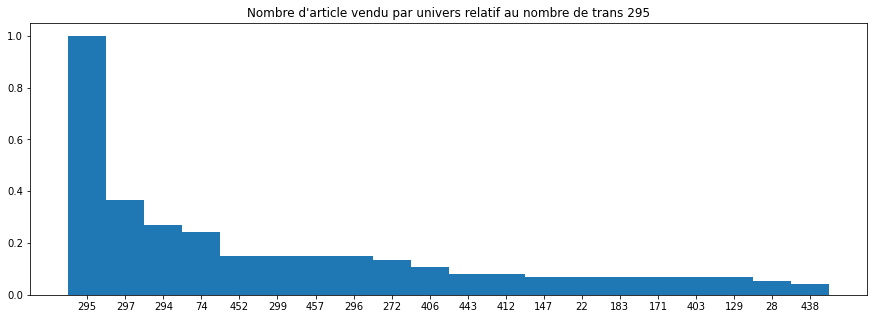

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 6.76)
("Nombre moyen d'univ", 1.15)
('CA univ', 120.3)
('CA moyen univ', 1.63)
('Nombre moyen article en plus', 5.82)
('CA en plus', 1494.48)
('CA moyen en plus', 20.2)
==============296===================


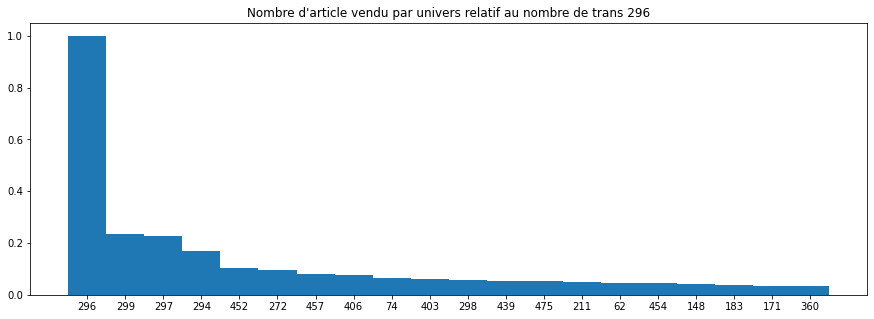

("Proportion d'achat (%)", 5.98)
('Proportion achat seul (%)', 7.68)
("Nombre moyen d'univ", 1.9)
('CA univ', 526858.78)
('CA moyen univ', 2.32)
('Nombre moyen article en plus', 4.81)
('CA en plus', 3471515.93)
('CA moyen en plus', 15.3)
==============297===================


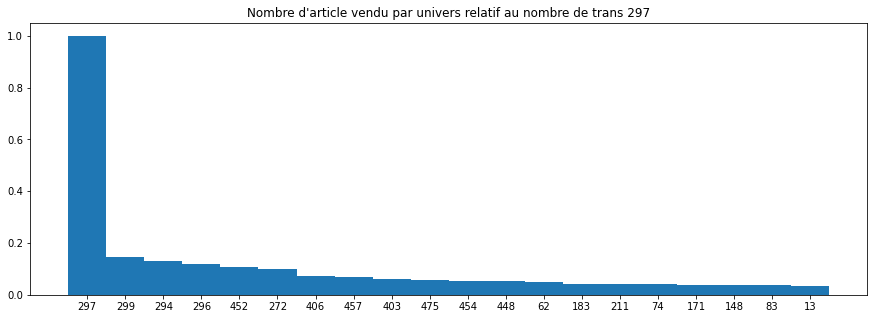

("Proportion d'achat (%)", 11.29)
('Proportion achat seul (%)', 15.26)
("Nombre moyen d'univ", 1.2)
('CA univ', 1170459.48)
('CA moyen univ', 2.73)
('Nombre moyen article en plus', 4.52)
('CA en plus', 6514444.56)
('CA moyen en plus', 15.2)
==============298===================


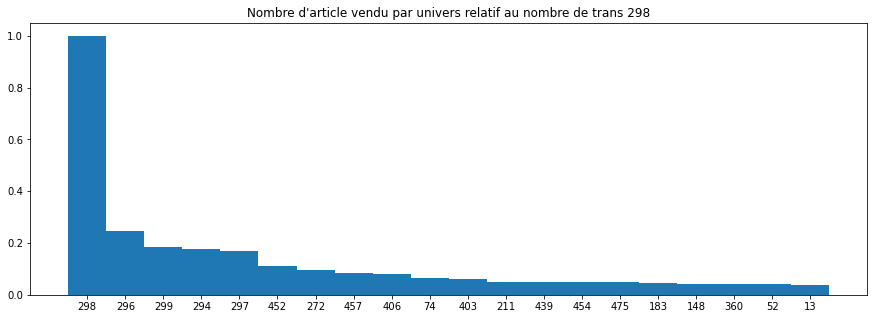

("Proportion d'achat (%)", 1.36)
('Proportion achat seul (%)', 6.63)
("Nombre moyen d'univ", 1.31)
('CA univ', 92171.58)
('CA moyen univ', 1.79)
('Nombre moyen article en plus', 5.17)
('CA en plus', 822474.97)
('CA moyen en plus', 15.99)
==============299===================


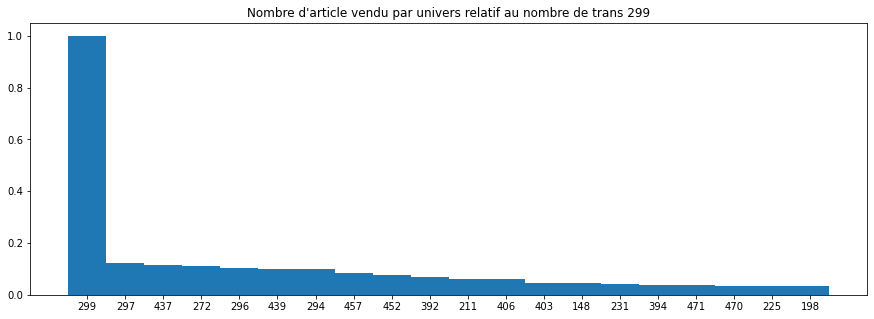

("Proportion d'achat (%)", 13.58)
('Proportion achat seul (%)', 12.16)
("Nombre moyen d'univ", 2.03)
('CA univ', 1432257.68)
('CA moyen univ', 2.78)
('Nombre moyen article en plus', 3.59)
('CA en plus', 6119781.43)
('CA moyen en plus', 11.87)
==============300===================


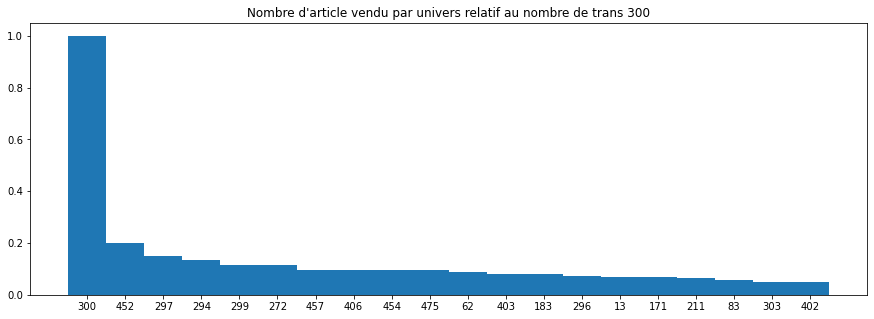

("Proportion d'achat (%)", 1.6)
('Proportion achat seul (%)', 7.02)
("Nombre moyen d'univ", 1.14)
('CA univ', 216724.88)
('CA moyen univ', 3.57)
('Nombre moyen article en plus', 6.55)
('CA en plus', 1400935.18)
('CA moyen en plus', 23.11)
==============301===================


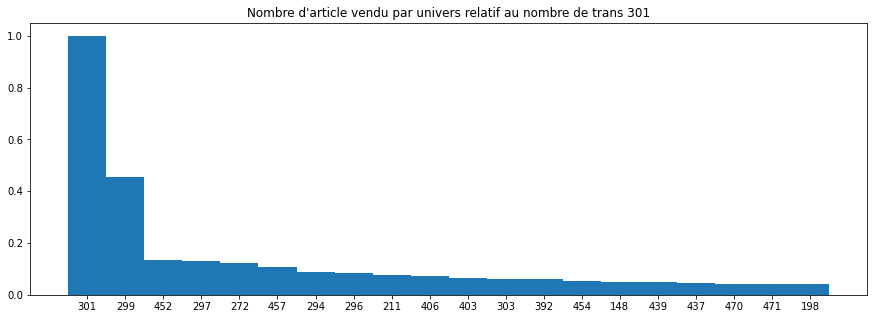

("Proportion d'achat (%)", 0.67)
('Proportion achat seul (%)', 4.38)
("Nombre moyen d'univ", 1.11)
('CA univ', 57359.64)
('CA moyen univ', 2.24)
('Nombre moyen article en plus', 5.68)
('CA en plus', 428058.28)
('CA moyen en plus', 16.72)
==============302===================


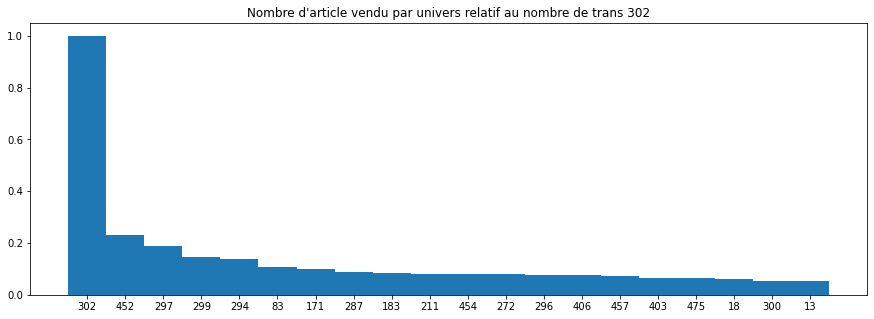

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 7.55)
("Nombre moyen d'univ", 1.25)
('CA univ', 48991.41)
('CA moyen univ', 2.66)
('Nombre moyen article en plus', 6.85)
('CA en plus', 425166.03)
('CA moyen en plus', 23.07)
==============303===================


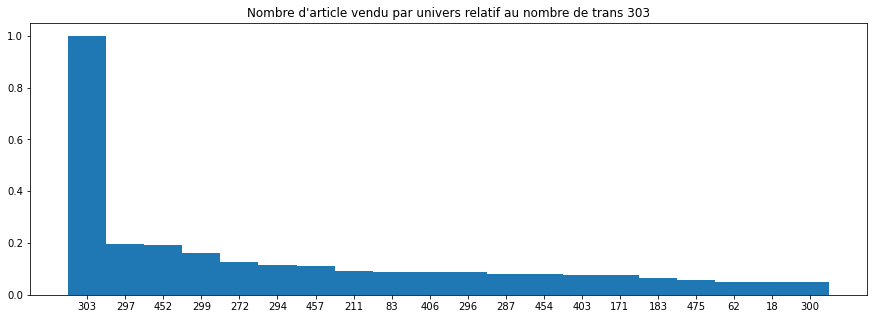

("Proportion d'achat (%)", 1.68)
('Proportion achat seul (%)', 6.86)
("Nombre moyen d'univ", 1.23)
('CA univ', 157946.57)
('CA moyen univ', 2.48)
('Nombre moyen article en plus', 6.67)
('CA en plus', 1441367.21)
('CA moyen en plus', 22.64)
==============305===================


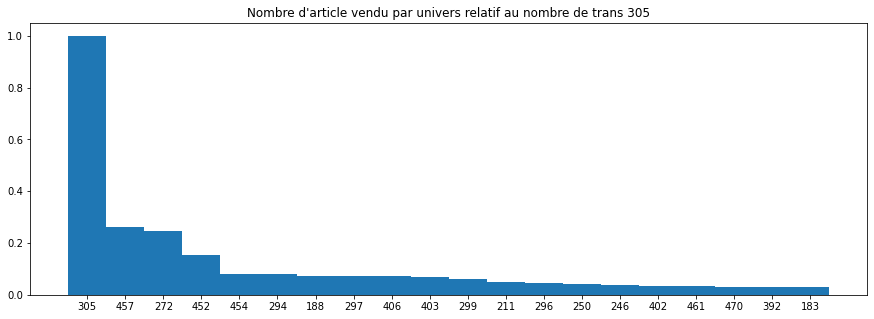

("Proportion d'achat (%)", 0.37)
('Proportion achat seul (%)', 13.64)
("Nombre moyen d'univ", 1.07)
('CA univ', 269468.68)
('CA moyen univ', 19.01)
('Nombre moyen article en plus', 4.59)
('CA en plus', 268610.66)
('CA moyen en plus', 18.95)
==============306===================


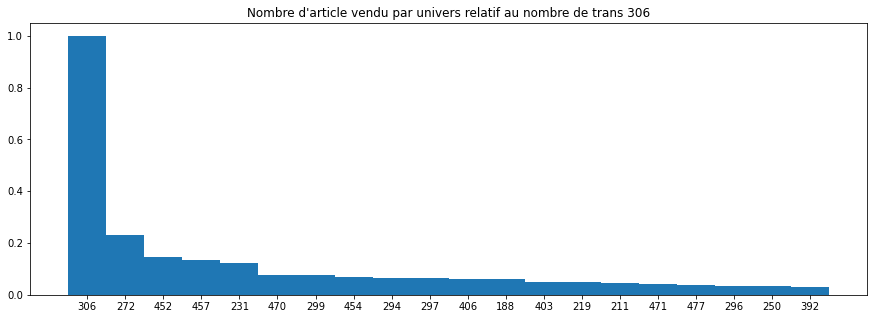

("Proportion d'achat (%)", 0.25)
('Proportion achat seul (%)', 14.64)
("Nombre moyen d'univ", 1.09)
('CA univ', 154589.47)
('CA moyen univ', 16.05)
('Nombre moyen article en plus', 4.19)
('CA en plus', 159852.06)
('CA moyen en plus', 16.6)
==============307===================


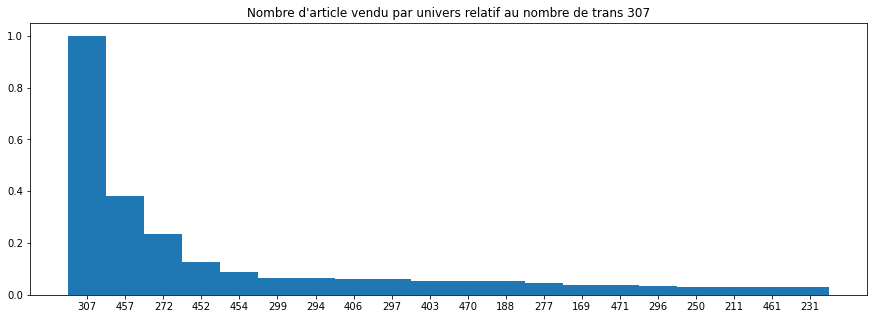

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 12.63)
("Nombre moyen d'univ", 1.07)
('CA univ', 113045.51)
('CA moyen univ', 19.04)
('Nombre moyen article en plus', 4.29)
('CA en plus', 99638.73)
('CA moyen en plus', 16.78)
==============308===================


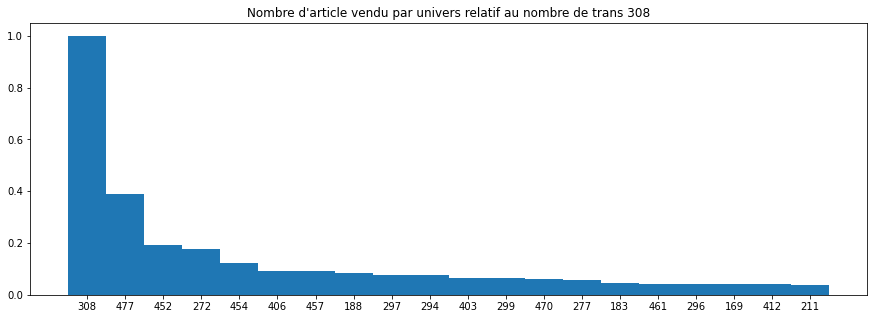

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 9.19)
("Nombre moyen d'univ", 1.06)
('CA univ', 98464.63)
('CA moyen univ', 28.62)
('Nombre moyen article en plus', 5.68)
('CA en plus', 88795.75)
('CA moyen en plus', 25.81)
==============309===================


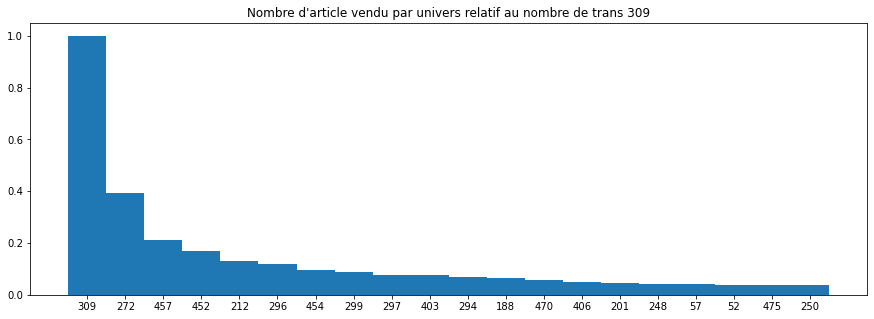

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 20.0)
("Nombre moyen d'univ", 1.09)
('CA univ', 7745.43)
('CA moyen univ', 19.36)
('Nombre moyen article en plus', 4.59)
('CA en plus', 7089.94)
('CA moyen en plus', 17.72)
==============310===================


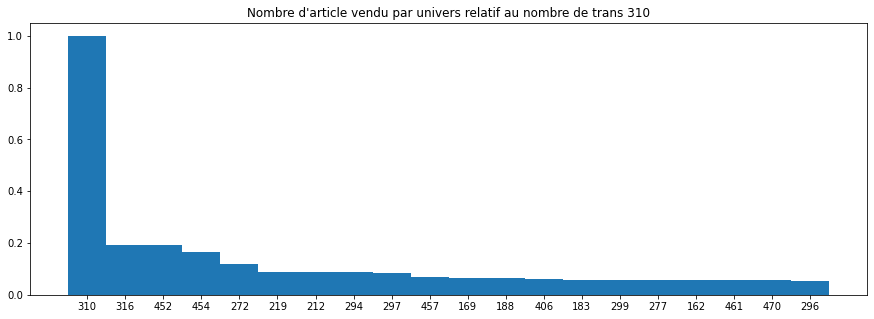

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 11.25)
("Nombre moyen d'univ", 1.07)
('CA univ', 26554.22)
('CA moyen univ', 16.05)
('Nombre moyen article en plus', 6.18)
('CA en plus', 44195.24)
('CA moyen en plus', 26.72)
==============311===================


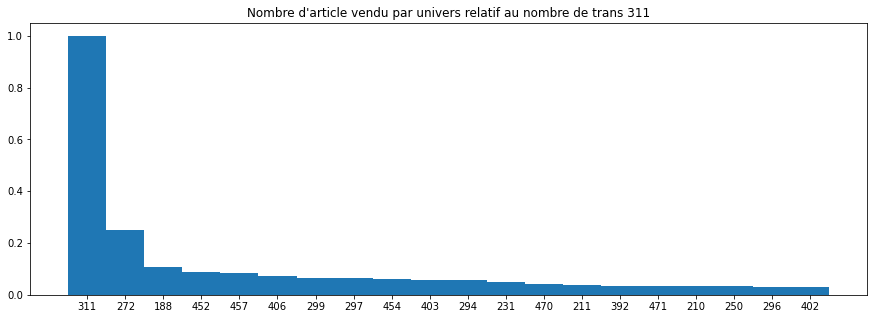

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 17.2)
("Nombre moyen d'univ", 1.43)
('CA univ', 137658.84)
('CA moyen univ', 5.34)
('Nombre moyen article en plus', 3.42)
('CA en plus', 347912.53)
('CA moyen en plus', 13.49)
==============312===================


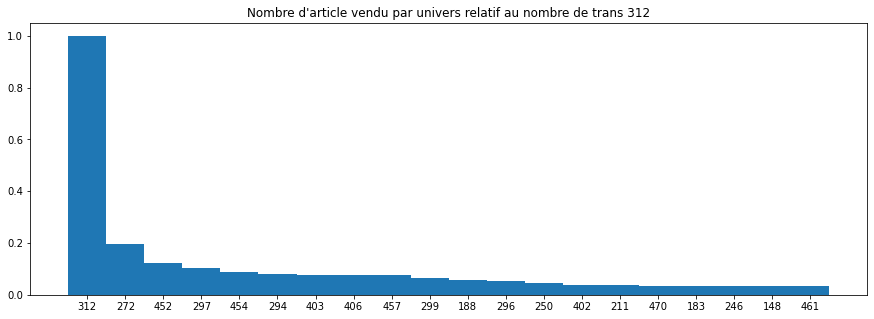

("Proportion d'achat (%)", 0.29)
('Proportion achat seul (%)', 14.08)
("Nombre moyen d'univ", 1.11)
('CA univ', 155580.09)
('CA moyen univ', 13.93)
('Nombre moyen article en plus', 4.69)
('CA en plus', 220111.25)
('CA moyen en plus', 19.71)
==============313===================


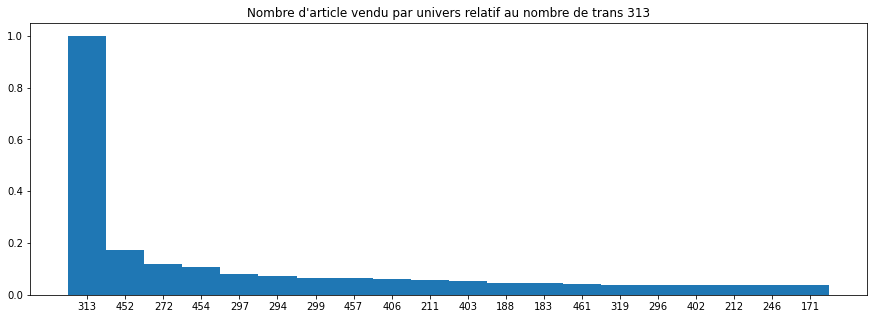

("Proportion d'achat (%)", 0.2)
('Proportion achat seul (%)', 20.7)
("Nombre moyen d'univ", 1.16)
('CA univ', 299884.78)
('CA moyen univ', 39.07)
('Nombre moyen article en plus', 4.9)
('CA en plus', 167089.62)
('CA moyen en plus', 21.77)
==============314===================


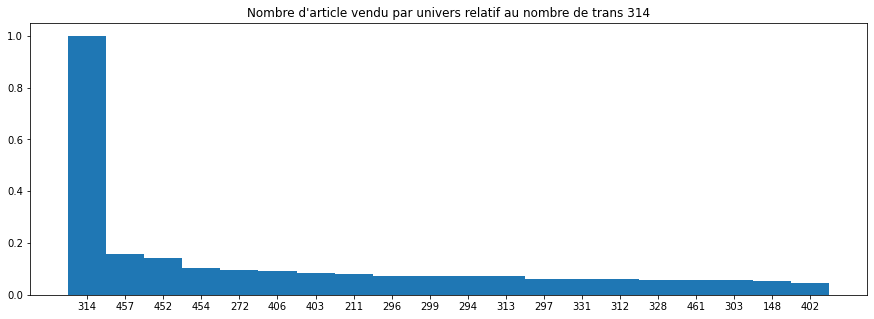

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 16.37)
("Nombre moyen d'univ", 1.14)
('CA univ', 12952.17)
('CA moyen univ', 37.87)
('Nombre moyen article en plus', 5.3)
('CA en plus', 7992.78)
('CA moyen en plus', 23.37)
==============315===================


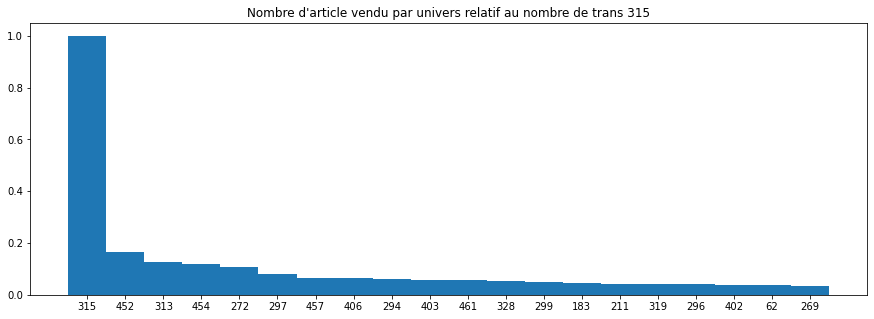

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 20.21)
("Nombre moyen d'univ", 1.15)
('CA univ', 45613.13)
('CA moyen univ', 48.78)
('Nombre moyen article en plus', 5.19)
('CA en plus', 27239.74)
('CA moyen en plus', 29.13)
==============316===================


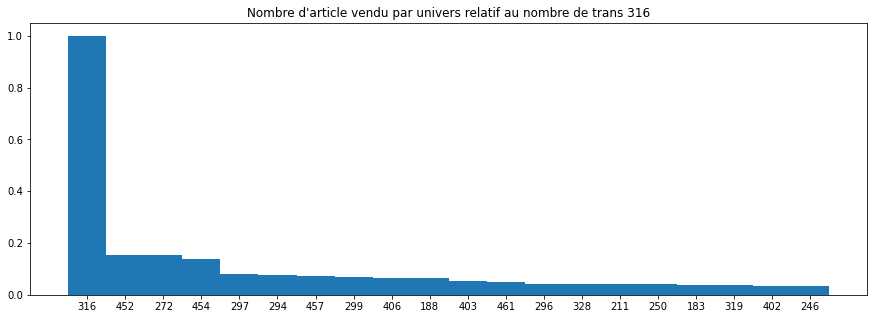

("Proportion d'achat (%)", 0.61)
('Proportion achat seul (%)', 15.77)
("Nombre moyen d'univ", 1.2)
('CA univ', 295001.78)
('CA moyen univ', 12.81)
('Nombre moyen article en plus', 4.48)
('CA en plus', 410537.63)
('CA moyen en plus', 17.83)
==============317===================


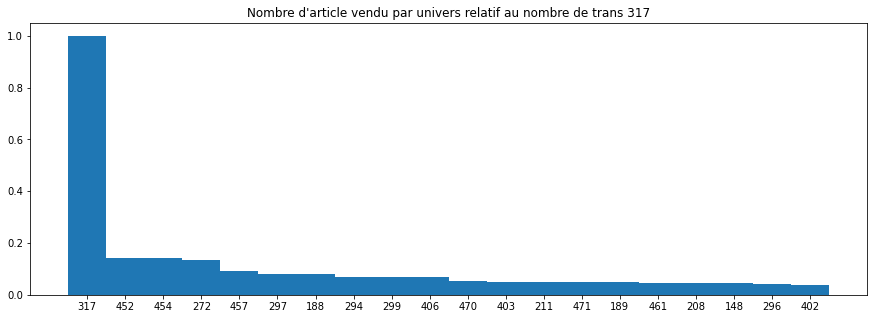

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 11.88)
("Nombre moyen d'univ", 1.38)
('CA univ', 28773.15)
('CA moyen univ', 4.05)
('Nombre moyen article en plus', 4.83)
('CA en plus', 130209.5)
('CA moyen en plus', 18.32)
==============318===================


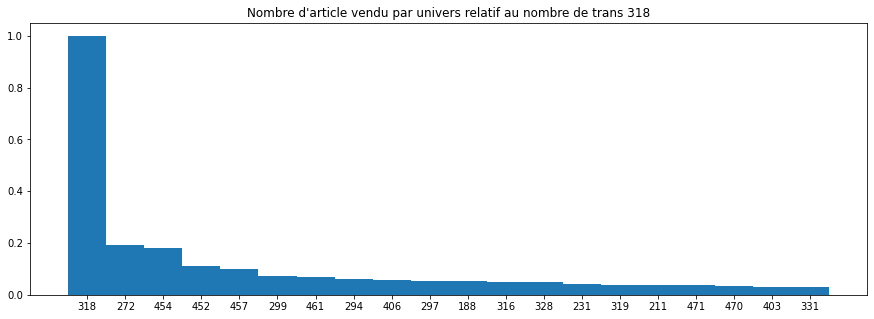

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 17.35)
("Nombre moyen d'univ", 1.12)
('CA univ', 23121.57)
('CA moyen univ', 13.37)
('Nombre moyen article en plus', 4.15)
('CA en plus', 30217.05)
('CA moyen en plus', 17.48)
==============319===================


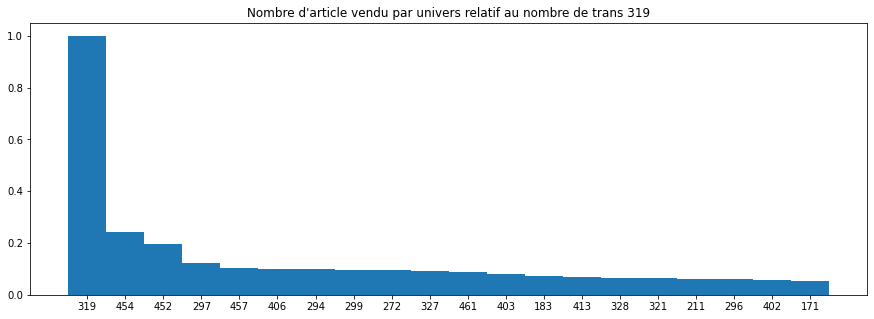

("Proportion d'achat (%)", 1.06)
('Proportion achat seul (%)', 2.66)
("Nombre moyen d'univ", 1.25)
('CA univ', 142894.29)
('CA moyen univ', 3.55)
('Nombre moyen article en plus', 7.05)
('CA en plus', 1067212.88)
('CA moyen en plus', 26.53)
==============320===================


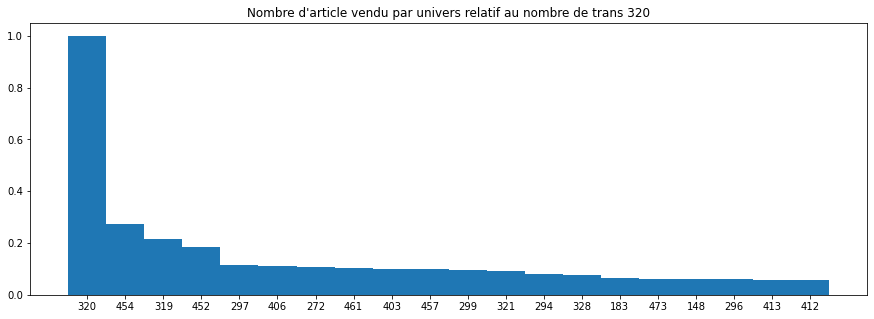

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 1.83)
("Nombre moyen d'univ", 1.14)
('CA univ', 9098.27)
('CA moyen univ', 3.03)
('Nombre moyen article en plus', 7.5)
('CA en plus', 86513.67)
('CA moyen en plus', 28.78)
==============321===================


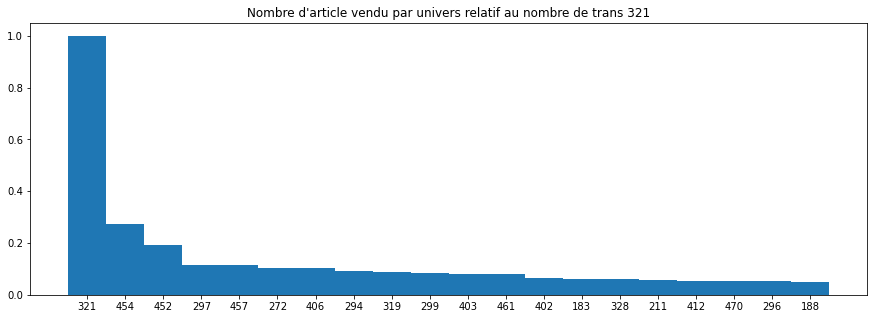

("Proportion d'achat (%)", 0.78)
('Proportion achat seul (%)', 2.8)
("Nombre moyen d'univ", 1.15)
('CA univ', 114494.17)
('CA moyen univ', 3.86)
('Nombre moyen article en plus', 6.77)
('CA en plus', 753890.86)
('CA moyen en plus', 25.39)
==============322===================


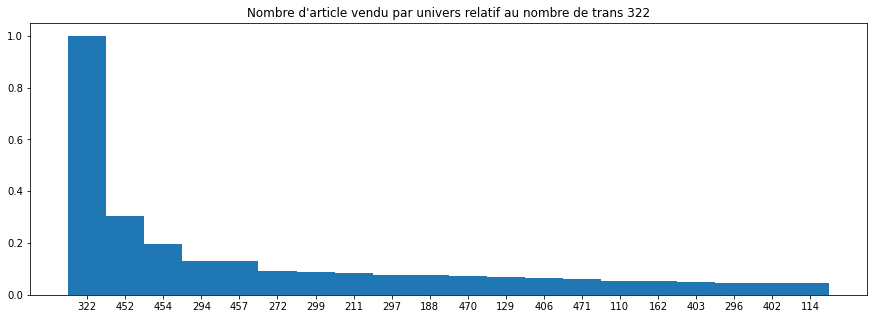

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 4.93)
("Nombre moyen d'univ", 1.2)
('CA univ', 3322.83)
('CA moyen univ', 1.93)
('Nombre moyen article en plus', 5.94)
('CA en plus', 31071.77)
('CA moyen en plus', 18.02)
==============323===================


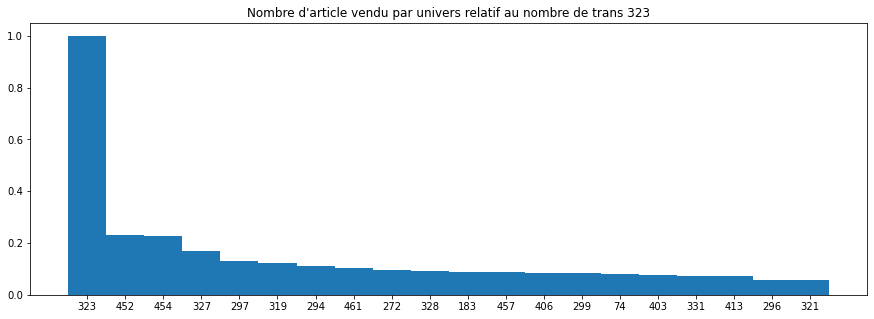

("Proportion d'achat (%)", 0.18)
('Proportion achat seul (%)', 3.68)
("Nombre moyen d'univ", 1.17)
('CA univ', 14830.16)
('CA moyen univ', 2.17)
('Nombre moyen article en plus', 7.57)
('CA en plus', 194847.49)
('CA moyen en plus', 28.57)
==============324===================


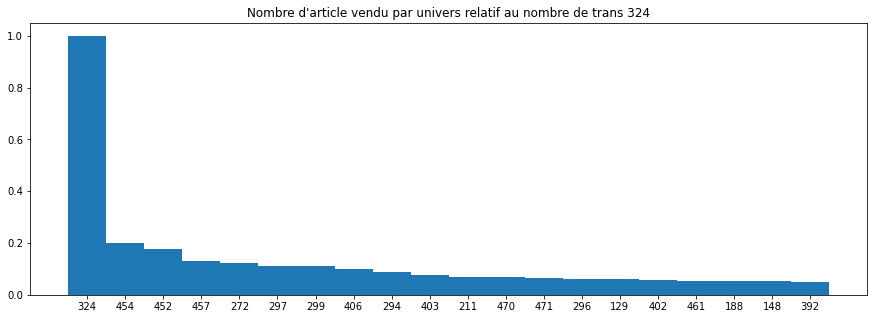

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 3.94)
("Nombre moyen d'univ", 1.3)
('CA univ', 44909.1)
('CA moyen univ', 2.78)
('Nombre moyen article en plus', 6.17)
('CA en plus', 349991.69)
('CA moyen en plus', 21.66)
==============326===================


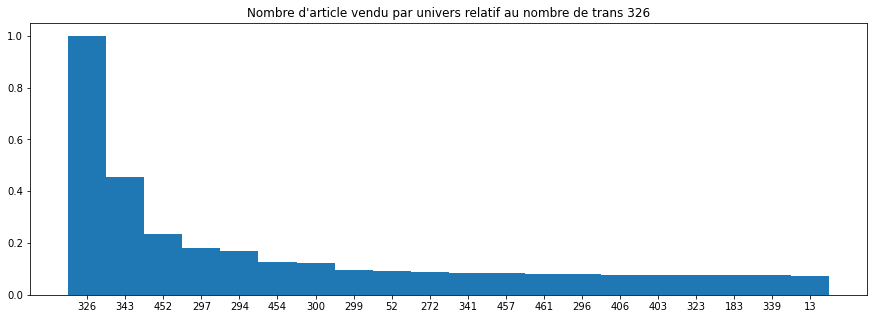

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.76)
("Nombre moyen d'univ", 1.14)
('CA univ', 3013.21)
('CA moyen univ', 4.03)
('Nombre moyen article en plus', 8.38)
('CA en plus', 26960.03)
('CA moyen en plus', 36.09)
==============327===================


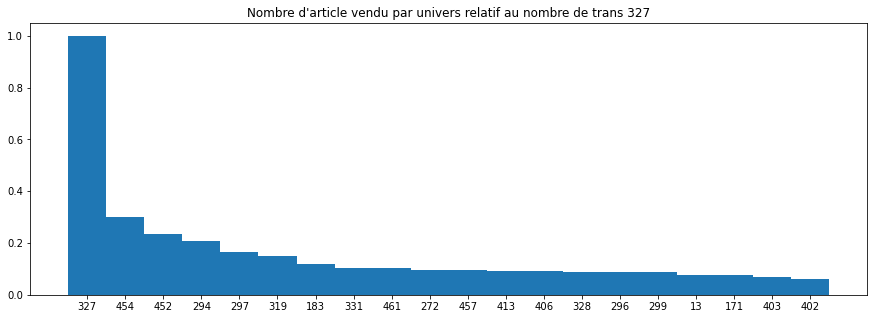

("Proportion d'achat (%)", 0.64)
('Proportion achat seul (%)', 1.36)
("Nombre moyen d'univ", 1.18)
('CA univ', 97201.07)
('CA moyen univ', 4.03)
('Nombre moyen article en plus', 7.89)
('CA en plus', 686951.21)
('CA moyen en plus', 28.5)
==============328===================


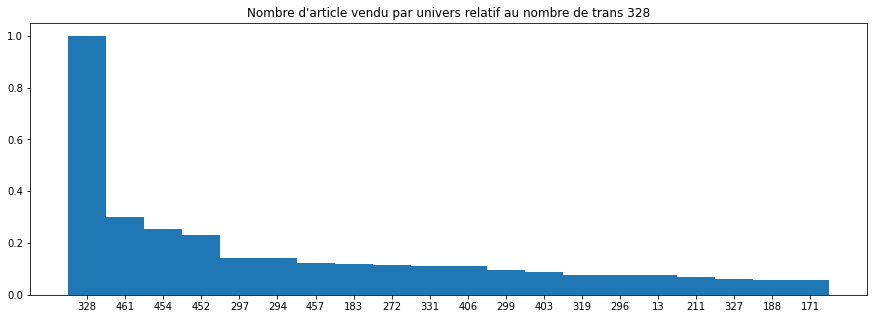

("Proportion d'achat (%)", 0.91)
('Proportion achat seul (%)', 1.0)
("Nombre moyen d'univ", 1.1)
('CA univ', 126850.11)
('CA moyen univ', 3.68)
('Nombre moyen article en plus', 8.15)
('CA en plus', 1039482.0)
('CA moyen en plus', 30.18)
==============329===================


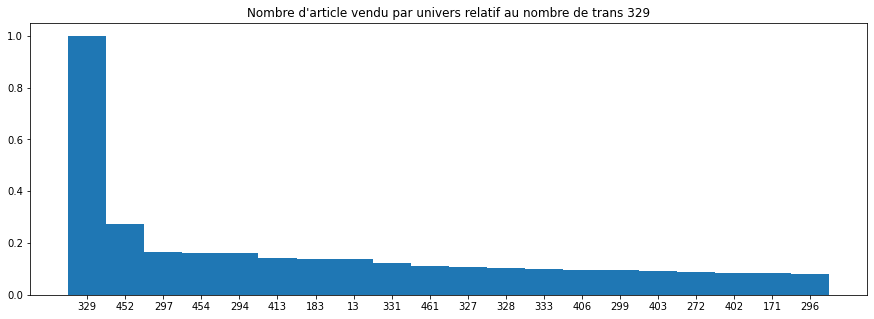

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 1.44)
("Nombre moyen d'univ", 1.08)
('CA univ', 12207.84)
('CA moyen univ', 4.39)
('Nombre moyen article en plus', 9.0)
('CA en plus', 93638.92)
('CA moyen en plus', 33.71)
==============331===================


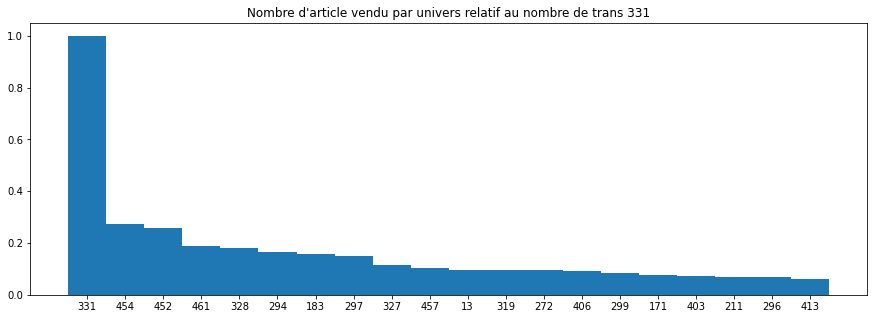

("Proportion d'achat (%)", 0.57)
('Proportion achat seul (%)', 1.11)
("Nombre moyen d'univ", 1.09)
('CA univ', 69698.53)
('CA moyen univ', 3.21)
('Nombre moyen article en plus', 8.54)
('CA en plus', 683013.53)
('CA moyen en plus', 31.45)
==============332===================


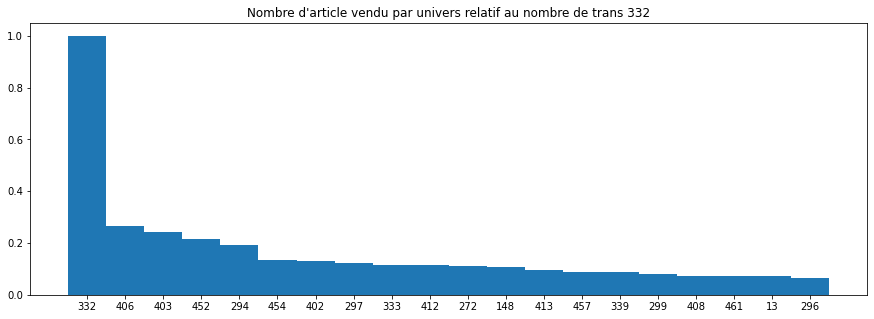

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.63)
("Nombre moyen d'univ", 1.17)
('CA univ', 2147.6)
('CA moyen univ', 8.77)
('Nombre moyen article en plus', 8.67)
('CA en plus', 9344.88)
('CA moyen en plus', 38.14)
==============333===================


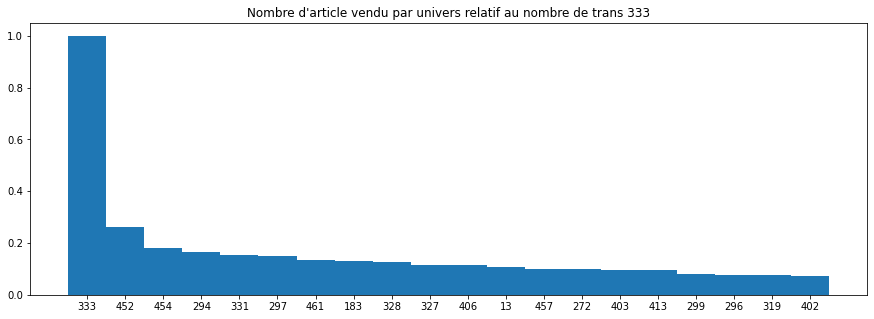

("Proportion d'achat (%)", 0.2)
('Proportion achat seul (%)', 1.06)
("Nombre moyen d'univ", 1.12)
('CA univ', 35191.88)
('CA moyen univ', 4.62)
('Nombre moyen article en plus', 8.59)
('CA en plus', 250234.45)
('CA moyen en plus', 32.88)
==============334===================


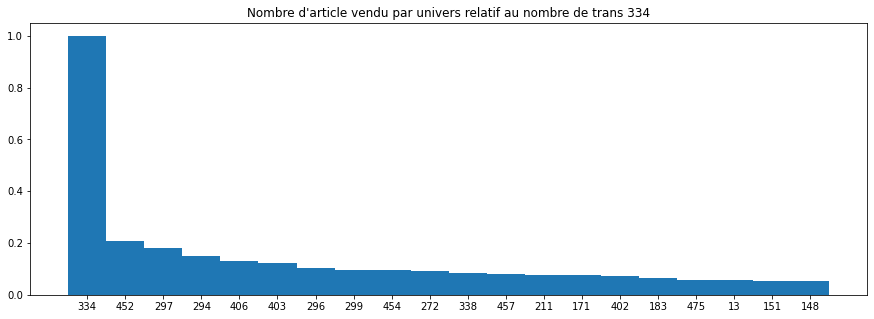

("Proportion d'achat (%)", 0.18)
('Proportion achat seul (%)', 4.07)
("Nombre moyen d'univ", 1.23)
('CA univ', 39248.24)
('CA moyen univ', 5.81)
('Nombre moyen article en plus', 7.21)
('CA en plus', 175991.44)
('CA moyen en plus', 26.05)
==============335===================


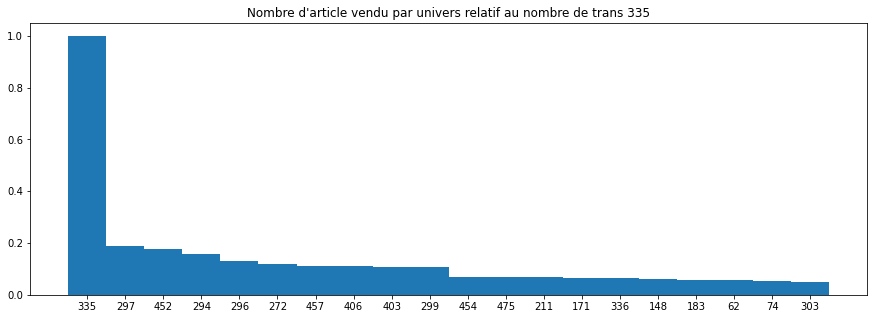

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 4.39)
("Nombre moyen d'univ", 1.15)
('CA univ', 11455.71)
('CA moyen univ', 3.65)
('Nombre moyen article en plus', 6.65)
('CA en plus', 69260.22)
('CA moyen en plus', 22.05)
==============336===================


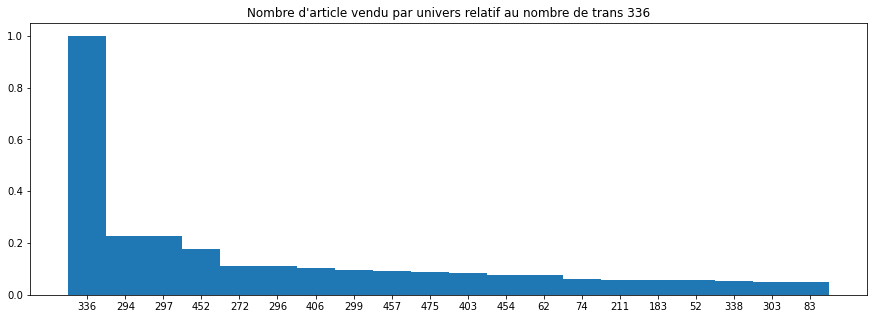

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 4.84)
("Nombre moyen d'univ", 1.14)
('CA univ', 44347.55)
('CA moyen univ', 5.25)
('Nombre moyen article en plus', 6.47)
('CA en plus', 185566.6)
('CA moyen en plus', 21.97)
==============337===================


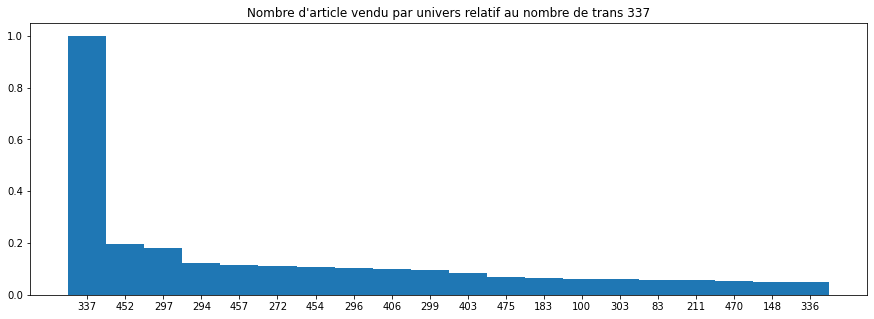

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 5.28)
("Nombre moyen d'univ", 1.31)
('CA univ', 4597.04)
('CA moyen univ', 2.58)
('Nombre moyen article en plus', 6.79)
('CA en plus', 41875.63)
('CA moyen en plus', 23.53)
==============338===================


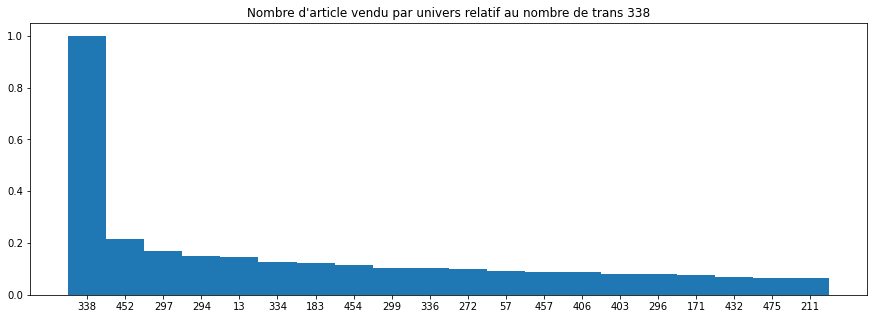

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 2.31)
("Nombre moyen d'univ", 1.27)
('CA univ', 10822.69)
('CA moyen univ', 2.43)
('Nombre moyen article en plus', 8.08)
('CA en plus', 129185.57)
('CA moyen en plus', 28.98)
==============339===================


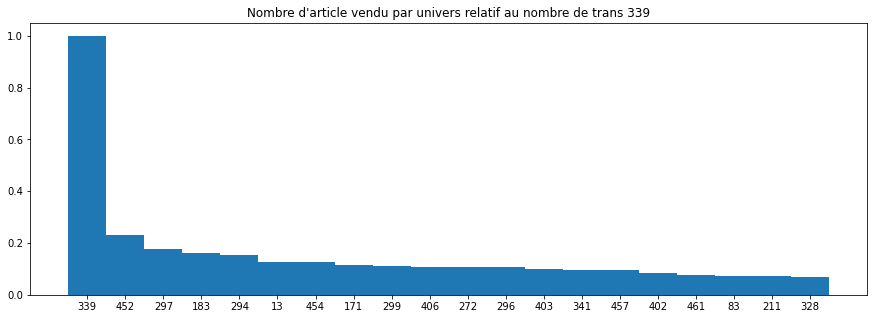

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 2.04)
("Nombre moyen d'univ", 1.2)
('CA univ', 116819.97)
('CA moyen univ', 6.24)
('Nombre moyen article en plus', 8.88)
('CA en plus', 609376.47)
('CA moyen en plus', 32.53)
==============341===================


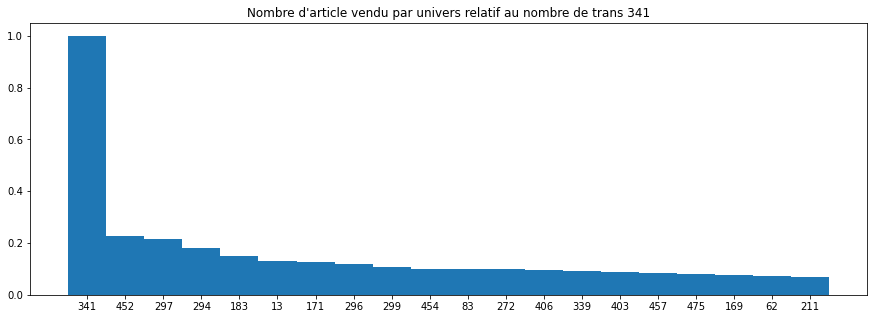

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 2.43)
("Nombre moyen d'univ", 1.23)
('CA univ', 159188.18)
('CA moyen univ', 8.01)
('Nombre moyen article en plus', 8.59)
('CA en plus', 619142.32)
('CA moyen en plus', 31.16)
==============342===================


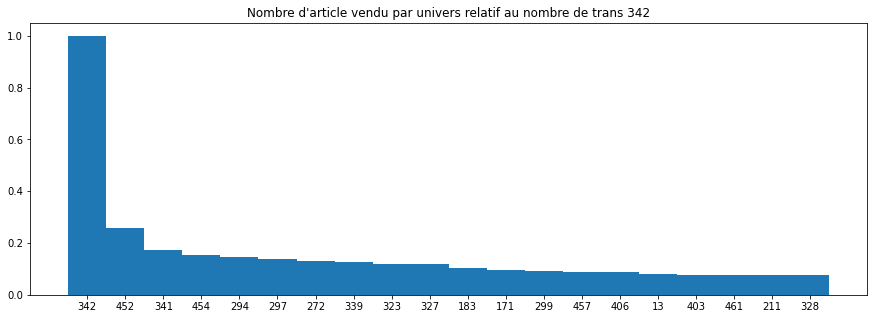

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 4.56)
("Nombre moyen d'univ", 1.32)
('CA univ', 11538.64)
('CA moyen univ', 7.11)
('Nombre moyen article en plus', 9.32)
('CA en plus', 60767.36)
('CA moyen en plus', 37.42)
==============343===================


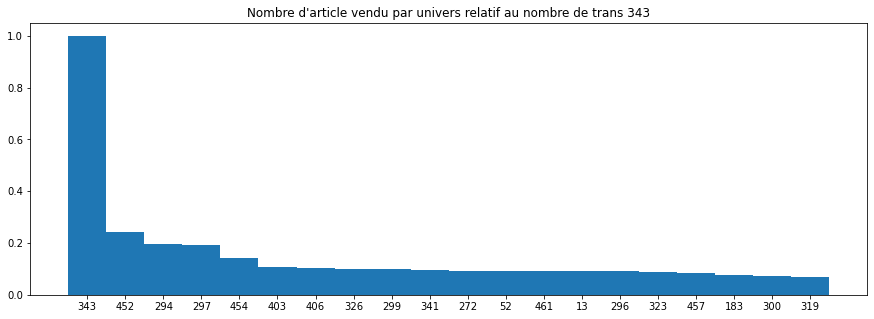

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 2.97)
("Nombre moyen d'univ", 1.15)
('CA univ', 29370.93)
('CA moyen univ', 8.8)
('Nombre moyen article en plus', 8.87)
('CA en plus', 119511.88)
('CA moyen en plus', 35.8)
==============344===================


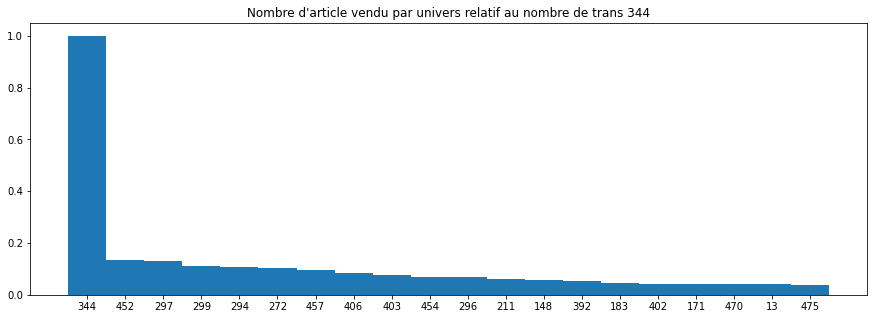

("Proportion d'achat (%)", 0.5)
('Proportion achat seul (%)', 12.15)
("Nombre moyen d'univ", 1.18)
('CA univ', 114255.26)
('CA moyen univ', 5.99)
('Nombre moyen article en plus', 5.32)
('CA en plus', 353988.24)
('CA moyen en plus', 18.56)
==============347===================


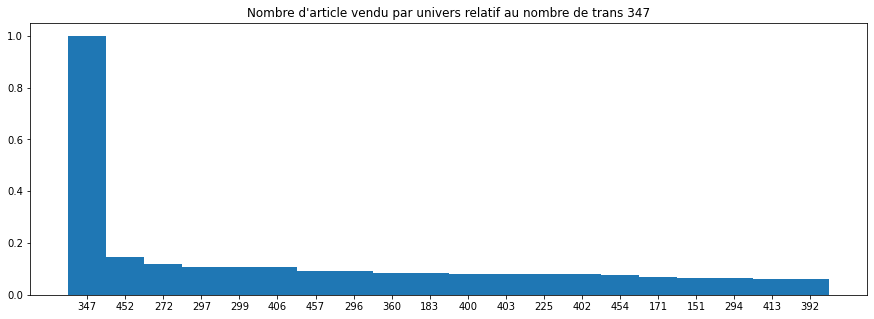

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.51)
("Nombre moyen d'univ", 1.05)
('CA univ', 1254.0)
('CA moyen univ', 3.79)
('Nombre moyen article en plus', 6.04)
('CA en plus', 7119.56)
('CA moyen en plus', 21.51)
==============348===================


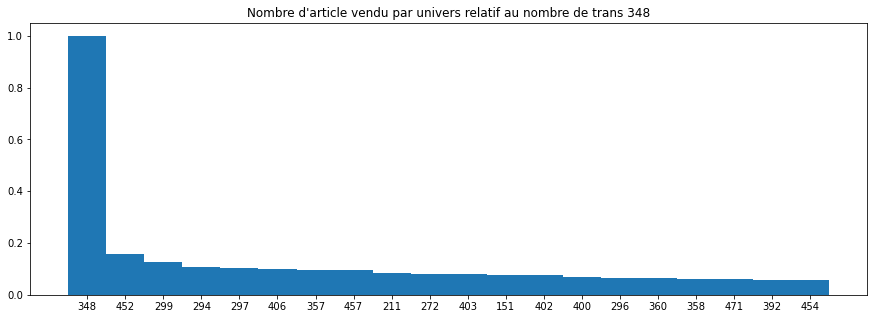

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 5.3)
("Nombre moyen d'univ", 1.09)
('CA univ', 34746.74)
('CA moyen univ', 4.7)
('Nombre moyen article en plus', 5.45)
('CA en plus', 142420.83)
('CA moyen en plus', 19.25)
==============349===================
NOT ENOUGH DATA 
==============350===================


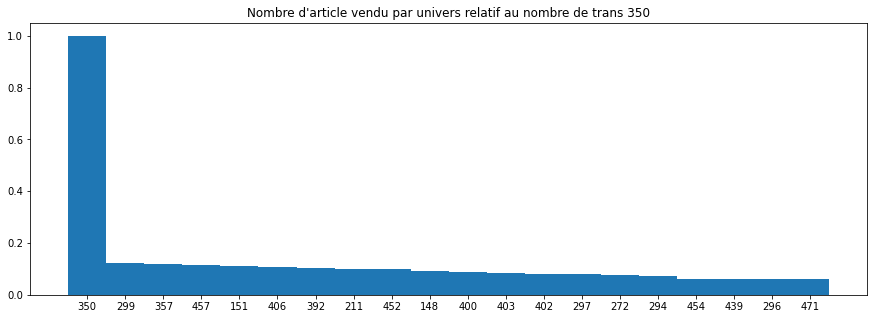

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 6.79)
("Nombre moyen d'univ", 1.05)
('CA univ', 5733.49)
('CA moyen univ', 5.56)
('Nombre moyen article en plus', 5.95)
('CA en plus', 21685.05)
('CA moyen en plus', 21.03)
==============351===================


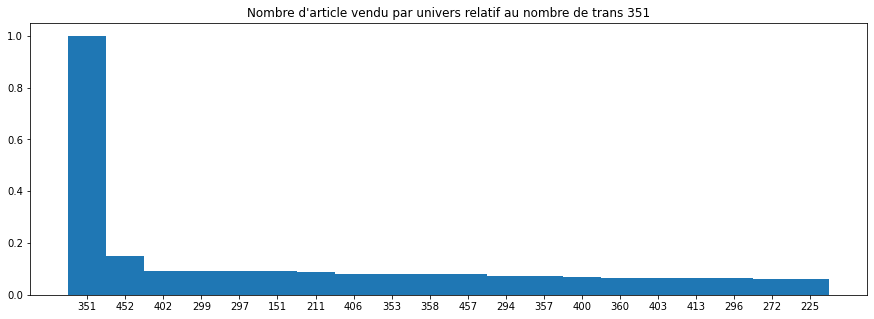

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 6.29)
("Nombre moyen d'univ", 1.07)
('CA univ', 31562.84)
('CA moyen univ', 4.81)
('Nombre moyen article en plus', 5.16)
('CA en plus', 121855.28)
('CA moyen en plus', 18.57)
==============353===================


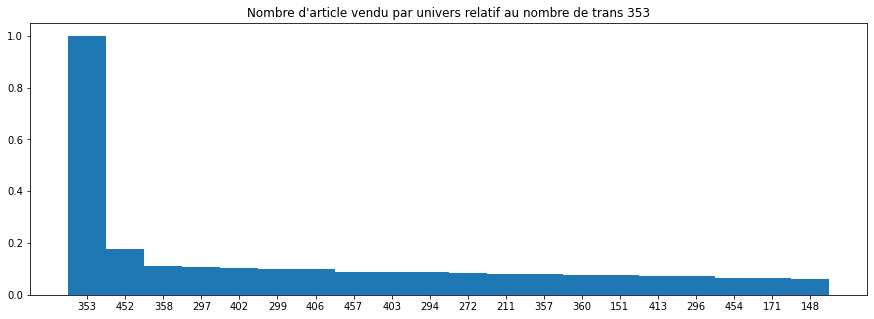

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 3.78)
("Nombre moyen d'univ", 1.1)
('CA univ', 75375.61)
('CA moyen univ', 4.66)
('Nombre moyen article en plus', 5.83)
('CA en plus', 348323.94)
('CA moyen en plus', 21.54)
==============354===================


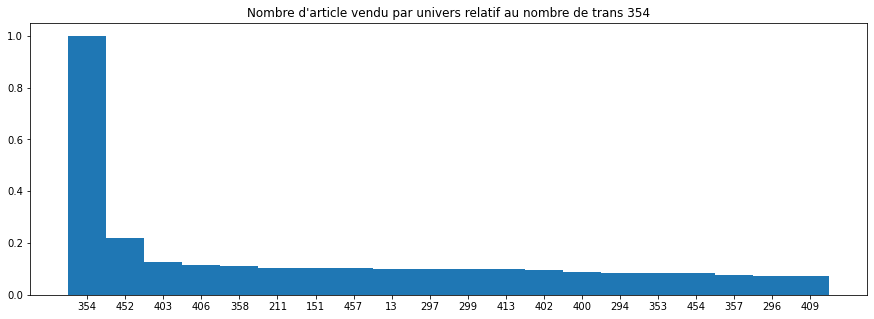

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 4.42)
("Nombre moyen d'univ", 1.07)
('CA univ', 768.9)
('CA moyen univ', 4.25)
('Nombre moyen article en plus', 5.96)
('CA en plus', 3692.62)
('CA moyen en plus', 20.4)
==============355===================


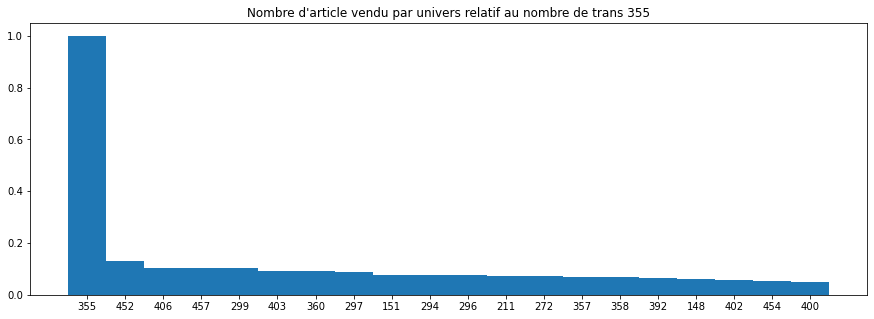

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 9.04)
("Nombre moyen d'univ", 1.05)
('CA univ', 51071.39)
('CA moyen univ', 6.18)
('Nombre moyen article en plus', 4.81)
('CA en plus', 144298.22)
('CA moyen en plus', 17.46)
==============356===================


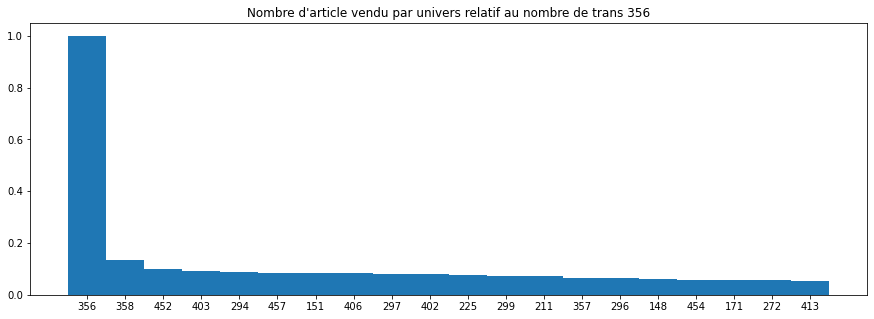

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 8.87)
("Nombre moyen d'univ", 1.04)
('CA univ', 5823.4)
('CA moyen univ', 7.94)
('Nombre moyen article en plus', 4.74)
('CA en plus', 13459.62)
('CA moyen en plus', 18.36)
==============357===================


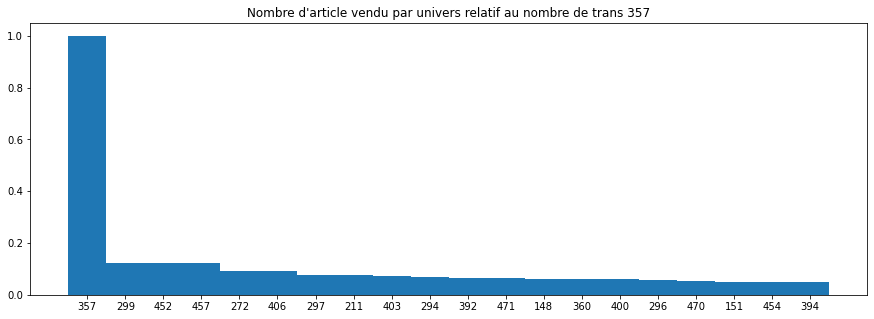

("Proportion d'achat (%)", 2.43)
('Proportion achat seul (%)', 11.42)
("Nombre moyen d'univ", 1.13)
('CA univ', 539673.3)
('CA moyen univ', 5.84)
('Nombre moyen article en plus', 4.16)
('CA en plus', 1300827.69)
('CA moyen en plus', 14.08)
==============358===================


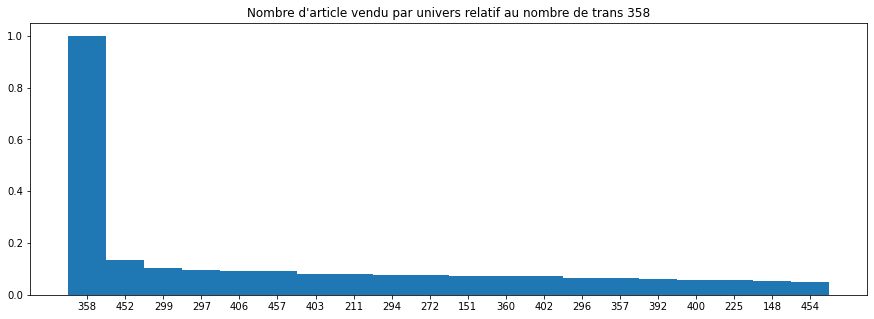

("Proportion d'achat (%)", 1.1)
('Proportion achat seul (%)', 9.34)
("Nombre moyen d'univ", 1.11)
('CA univ', 273783.91)
('CA moyen univ', 6.53)
('Nombre moyen article en plus', 4.74)
('CA en plus', 705805.15)
('CA moyen en plus', 16.84)
==============359===================


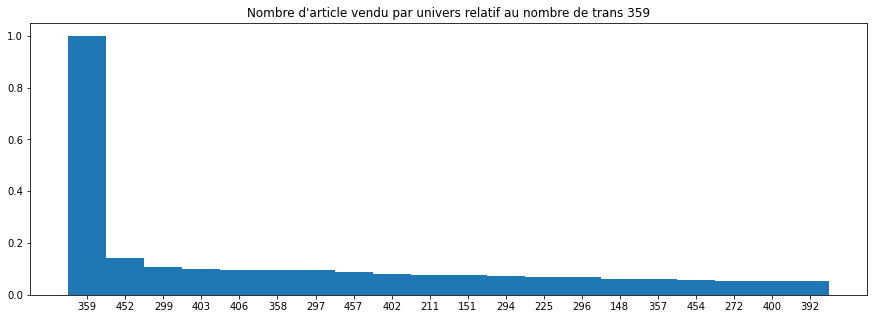

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 6.76)
("Nombre moyen d'univ", 1.04)
('CA univ', 17301.75)
('CA moyen univ', 6.92)
('Nombre moyen article en plus', 4.96)
('CA en plus', 44481.11)
('CA moyen en plus', 17.8)
==============360===================


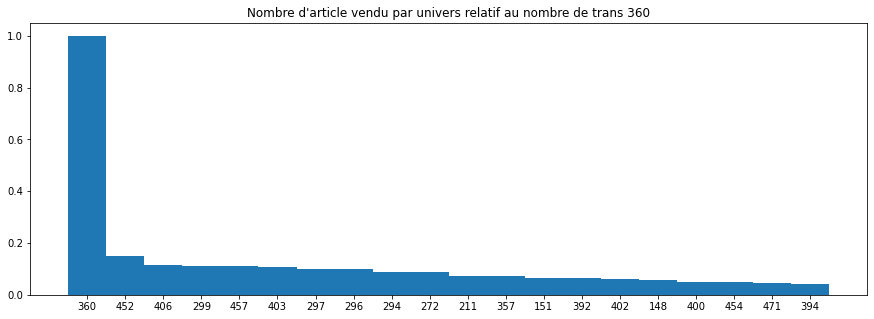

("Proportion d'achat (%)", 2.13)
('Proportion achat seul (%)', 8.64)
("Nombre moyen d'univ", 1.17)
('CA univ', 519375.77)
('CA moyen univ', 6.43)
('Nombre moyen article en plus', 4.75)
('CA en plus', 1339730.8)
('CA moyen en plus', 16.6)
==============361===================


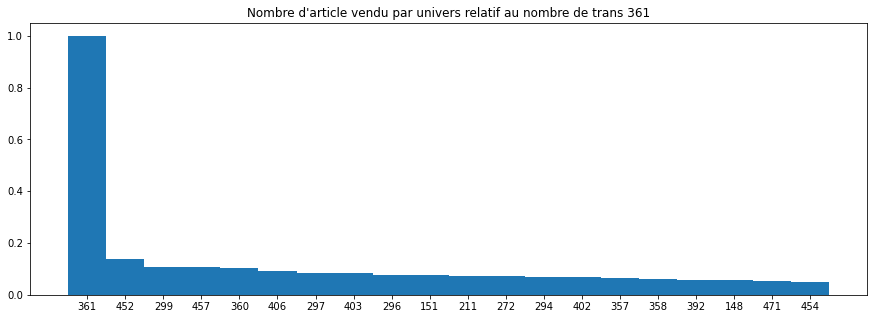

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 10.28)
("Nombre moyen d'univ", 1.1)
('CA univ', 118744.59)
('CA moyen univ', 6.99)
('Nombre moyen article en plus', 4.65)
('CA en plus', 278318.06)
('CA moyen en plus', 16.38)
==============362===================


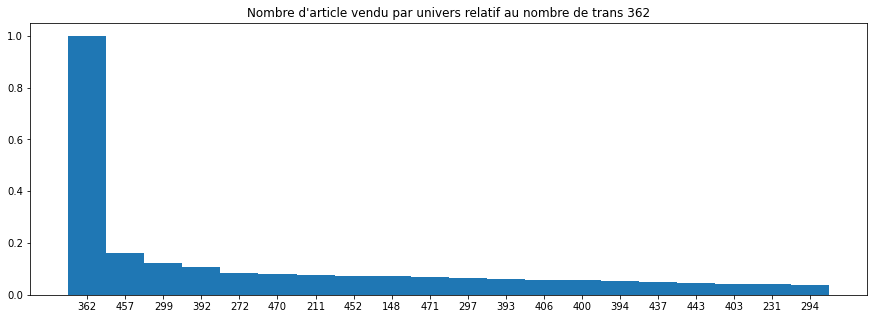

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 12.65)
("Nombre moyen d'univ", 1.19)
('CA univ', 42880.96)
('CA moyen univ', 5.03)
('Nombre moyen article en plus', 3.52)
('CA en plus', 88770.42)
('CA moyen en plus', 10.41)
==============363===================


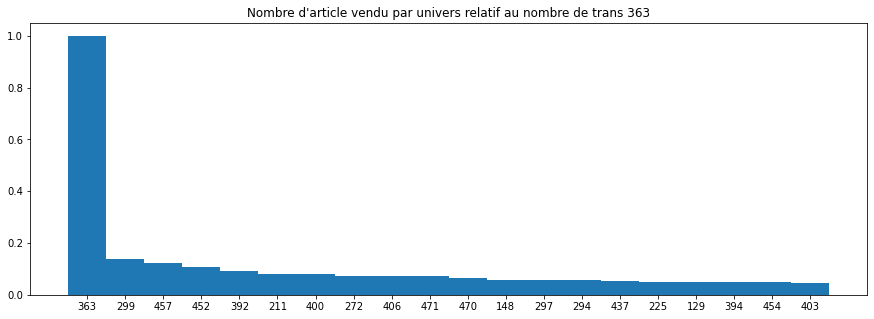

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 11.34)
("Nombre moyen d'univ", 1.1)
('CA univ', 19836.94)
('CA moyen univ', 4.83)
('Nombre moyen article en plus', 3.97)
('CA en plus', 51754.81)
('CA moyen en plus', 12.59)
==============366===================


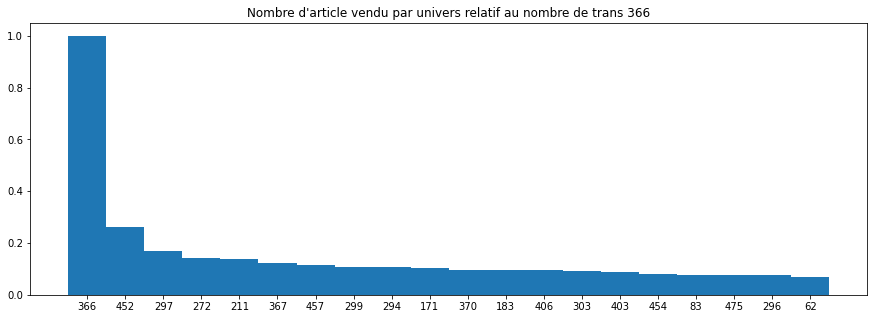

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 7.6)
("Nombre moyen d'univ", 1.07)
('CA univ', 33026.91)
('CA moyen univ', 13.27)
('Nombre moyen article en plus', 8.65)
('CA en plus', 81867.51)
('CA moyen en plus', 32.9)
==============367===================


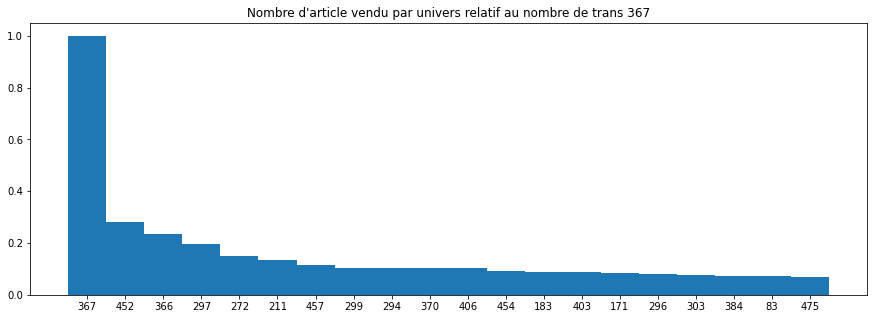

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 7.0)
("Nombre moyen d'univ", 1.04)
('CA univ', 8881.99)
('CA moyen univ', 6.69)
('Nombre moyen article en plus', 8.96)
('CA en plus', 46900.95)
('CA moyen en plus', 35.32)
==============368===================


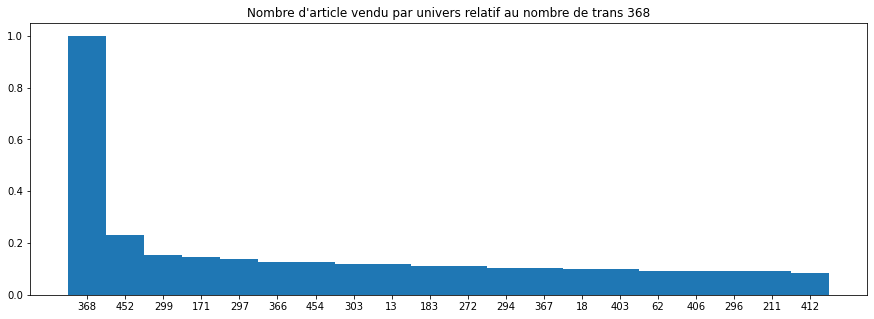

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 4.2)
("Nombre moyen d'univ", 1.01)
('CA univ', 1132.32)
('CA moyen univ', 7.92)
('Nombre moyen article en plus', 10.68)
('CA en plus', 5975.86)
('CA moyen en plus', 41.79)
==============369===================


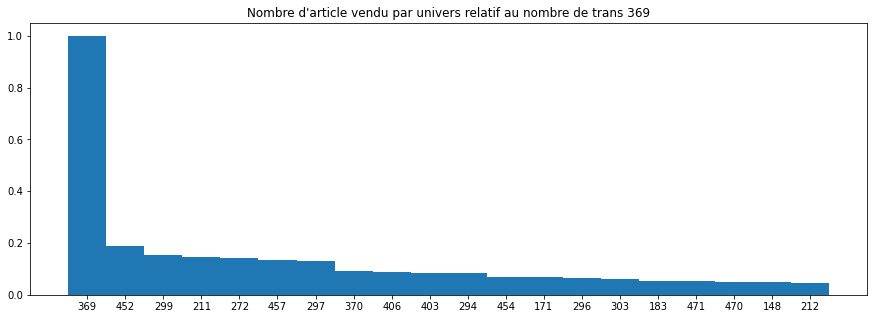

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 8.14)
("Nombre moyen d'univ", 1.23)
('CA univ', 14447.81)
('CA moyen univ', 2.33)
('Nombre moyen article en plus', 6.88)
('CA en plus', 149288.12)
('CA moyen en plus', 24.02)
==============370===================


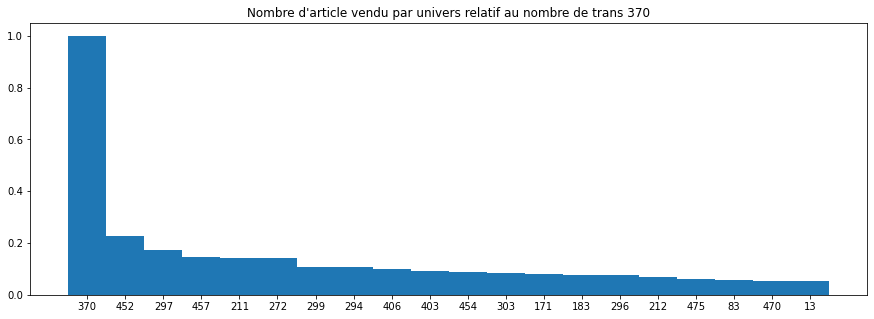

("Proportion d'achat (%)", 0.44)
('Proportion achat seul (%)', 6.74)
("Nombre moyen d'univ", 1.17)
('CA univ', 69181.24)
('CA moyen univ', 4.15)
('Nombre moyen article en plus', 7.68)
('CA en plus', 464760.65)
('CA moyen en plus', 27.85)
==============372===================


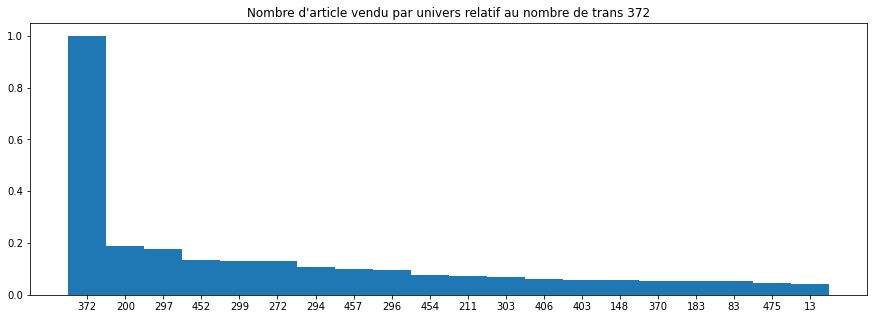

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 9.44)
("Nombre moyen d'univ", 1.1)
('CA univ', 3474.44)
('CA moyen univ', 2.16)
('Nombre moyen article en plus', 6.21)
('CA en plus', 35504.2)
('CA moyen en plus', 22.04)
==============373===================


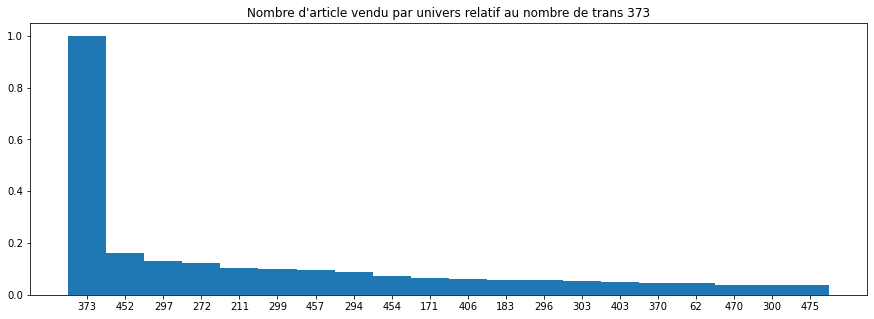

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 16.03)
("Nombre moyen d'univ", 1.08)
('CA univ', 19158.69)
('CA moyen univ', 10.89)
('Nombre moyen article en plus', 5.18)
('CA en plus', 30847.15)
('CA moyen en plus', 17.54)
==============374===================


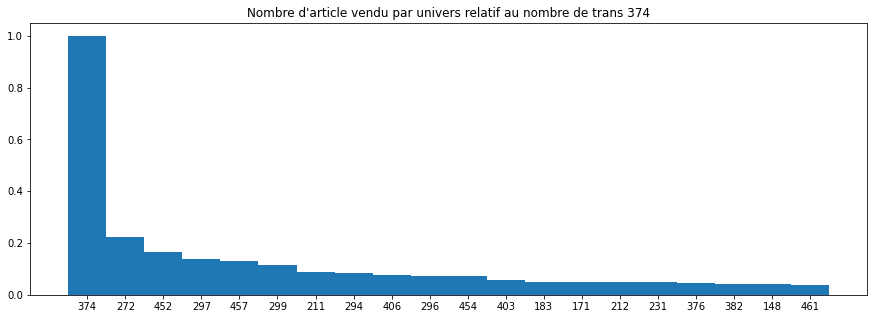

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 11.95)
("Nombre moyen d'univ", 1.03)
('CA univ', 5331.29)
('CA moyen univ', 6.18)
('Nombre moyen article en plus', 5.96)
('CA en plus', 18826.05)
('CA moyen en plus', 21.84)
==============375===================


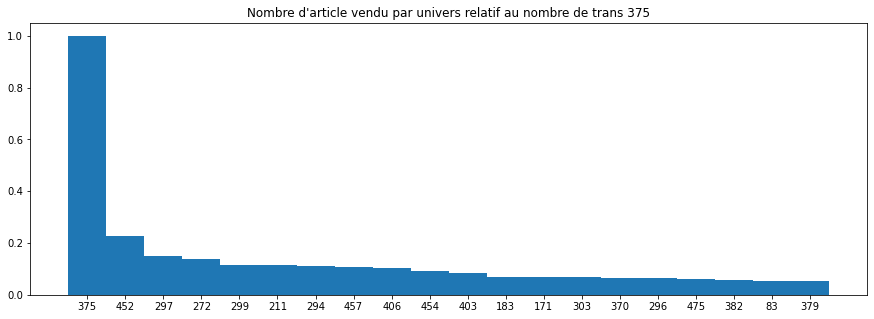

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 7.37)
("Nombre moyen d'univ", 1.17)
('CA univ', 21933.99)
('CA moyen univ', 4.83)
('Nombre moyen article en plus', 7.41)
('CA en plus', 123586.3)
('CA moyen en plus', 27.19)
==============376===================


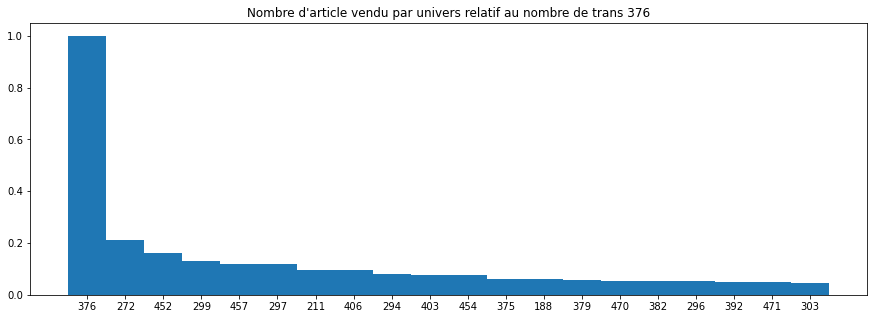

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 7.54)
("Nombre moyen d'univ", 1.06)
('CA univ', 13115.12)
('CA moyen univ', 4.62)
('Nombre moyen article en plus', 6.45)
('CA en plus', 68731.59)
('CA moyen en plus', 24.23)
==============377===================


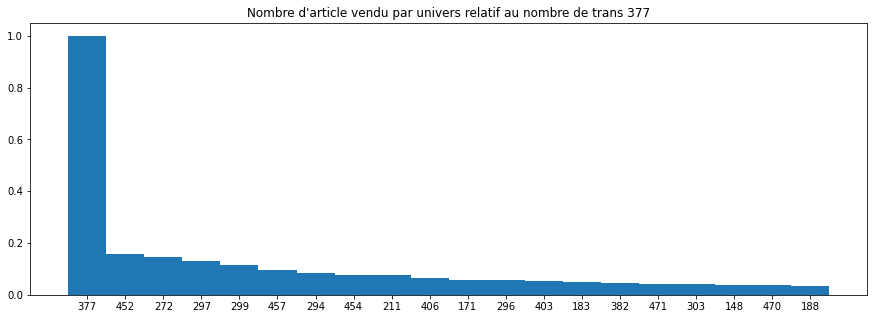

("Proportion d'achat (%)", 0.18)
('Proportion achat seul (%)', 14.1)
("Nombre moyen d'univ", 1.11)
('CA univ', 34128.53)
('CA moyen univ', 4.89)
('Nombre moyen article en plus', 5.34)
('CA en plus', 130089.13)
('CA moyen en plus', 18.62)
==============378===================


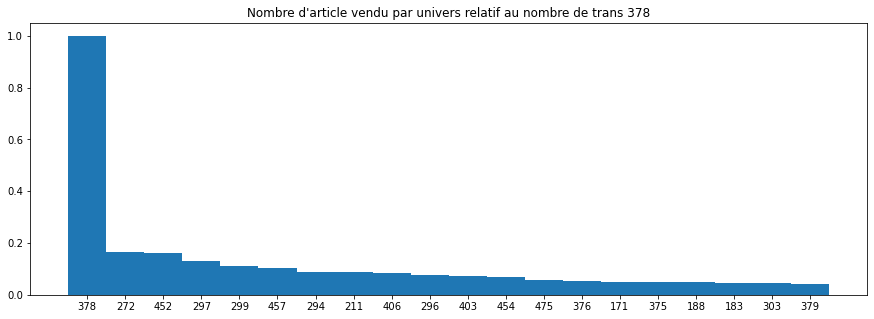

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 12.04)
("Nombre moyen d'univ", 1.08)
('CA univ', 7814.83)
('CA moyen univ', 6.92)
('Nombre moyen article en plus', 5.89)
('CA en plus', 24970.73)
('CA moyen en plus', 22.1)
==============379===================


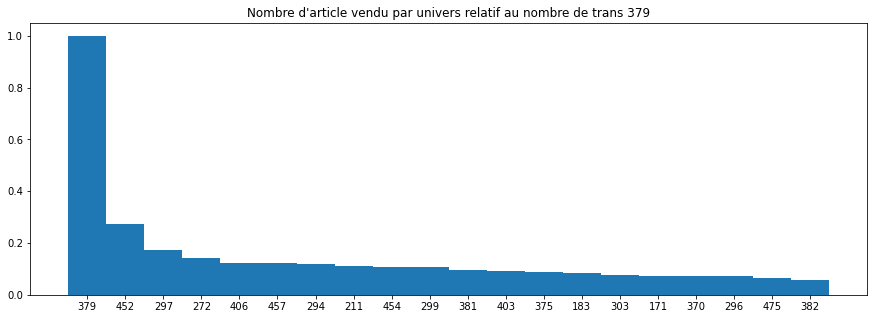

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 4.43)
("Nombre moyen d'univ", 1.09)
('CA univ', 13793.76)
('CA moyen univ', 4.93)
('Nombre moyen article en plus', 8.46)
('CA en plus', 70620.62)
('CA moyen en plus', 25.26)
==============380===================


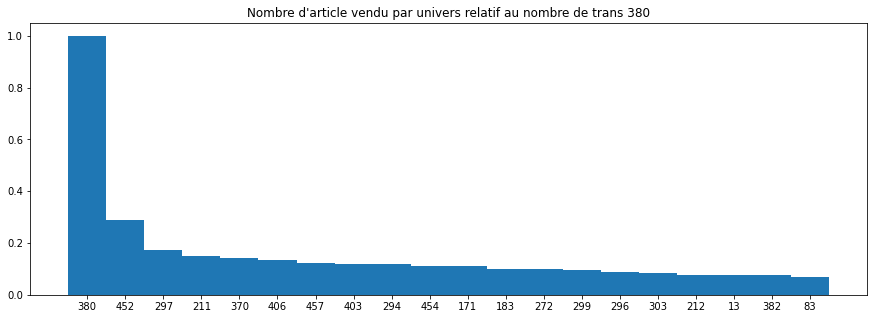

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 2.8)
("Nombre moyen d'univ", 1.12)
('CA univ', 7590.01)
('CA moyen univ', 4.52)
('Nombre moyen article en plus', 9.65)
('CA en plus', 61186.92)
('CA moyen en plus', 36.4)
==============381===================


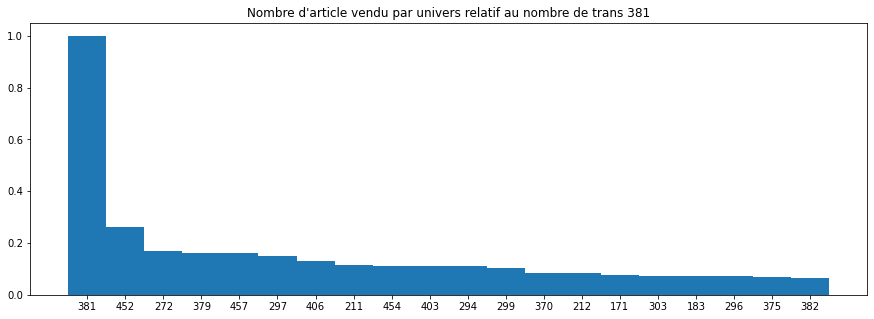

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 4.8)
("Nombre moyen d'univ", 1.13)
('CA univ', 7650.17)
('CA moyen univ', 4.7)
('Nombre moyen article en plus', 8.84)
('CA en plus', 52574.04)
('CA moyen en plus', 32.33)
==============382===================


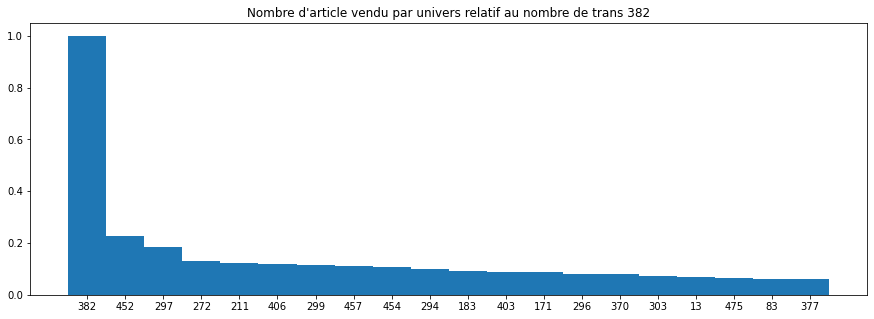

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 4.81)
("Nombre moyen d'univ", 1.1)
('CA univ', 20885.56)
('CA moyen univ', 3.99)
('Nombre moyen article en plus', 8.72)
('CA en plus', 165835.39)
('CA moyen en plus', 31.67)
==============384===================


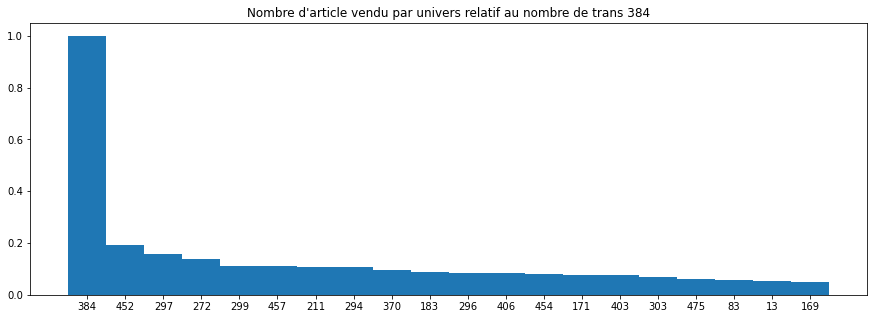

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 9.49)
("Nombre moyen d'univ", 1.21)
('CA univ', 26516.9)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 7.63)
('CA en plus', 163024.29)
('CA moyen en plus', 27.92)
==============386===================


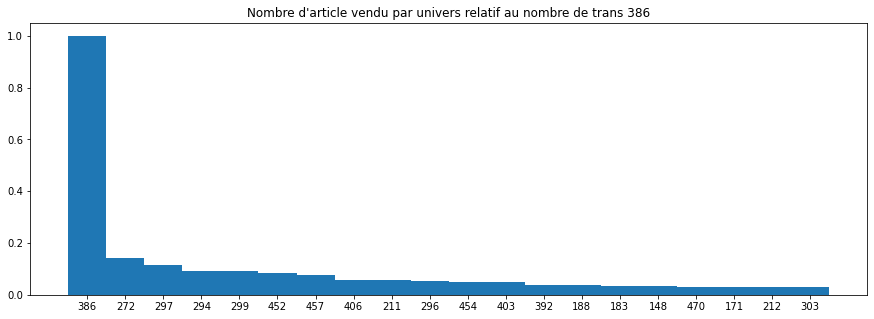

("Proportion d'achat (%)", 0.24)
('Proportion achat seul (%)', 22.88)
("Nombre moyen d'univ", 1.22)
('CA univ', 116852.16)
('CA moyen univ', 12.79)
('Nombre moyen article en plus', 4.01)
('CA en plus', 134156.36)
('CA moyen en plus', 14.69)
==============387===================


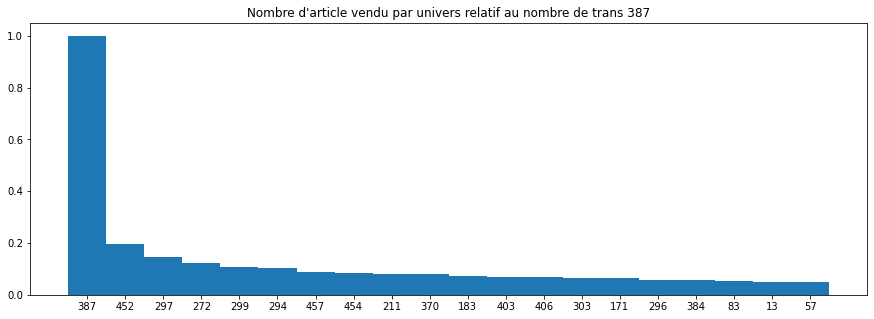

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 10.99)
("Nombre moyen d'univ", 1.06)
('CA univ', 29349.68)
('CA moyen univ', 9.3)
('Nombre moyen article en plus', 7.19)
('CA en plus', 83076.23)
('CA moyen en plus', 26.32)
==============390===================


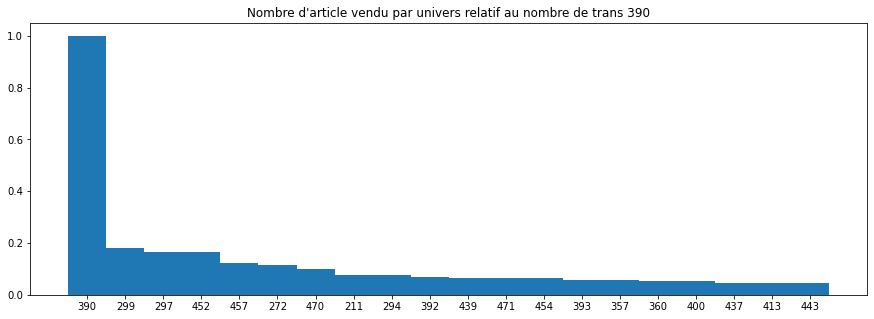

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 4.09)
("Nombre moyen d'univ", 1.12)
('CA univ', 743.76)
('CA moyen univ', 4.35)
('Nombre moyen article en plus', 4.54)
('CA en plus', 2476.73)
('CA moyen en plus', 14.48)
==============391===================


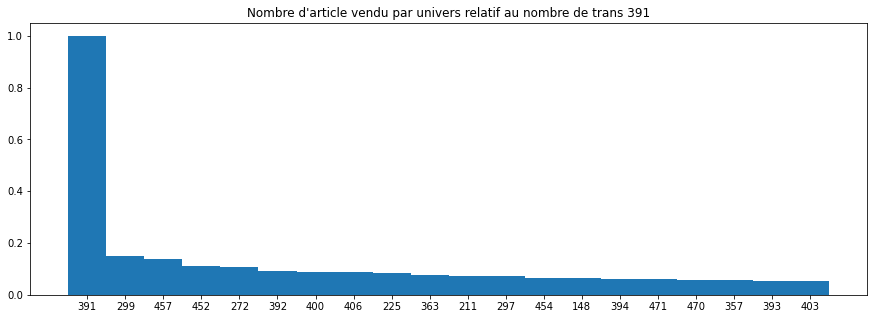

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 8.25)
("Nombre moyen d'univ", 1.08)
('CA univ', 9687.98)
('CA moyen univ', 5.09)
('Nombre moyen article en plus', 4.92)
('CA en plus', 31972.92)
('CA moyen en plus', 16.81)
==============392===================


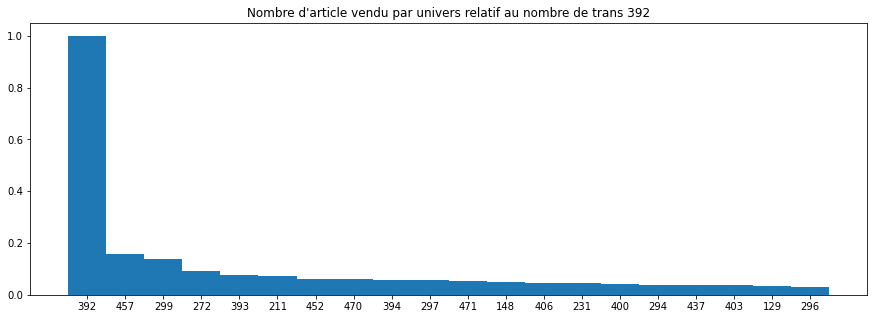

("Proportion d'achat (%)", 6.78)
('Proportion achat seul (%)', 19.2)
("Nombre moyen d'univ", 1.23)
('CA univ', 1026884.97)
('CA moyen univ', 3.99)
('Nombre moyen article en plus', 2.98)
('CA en plus', 2366814.15)
('CA moyen en plus', 9.19)
==============393===================


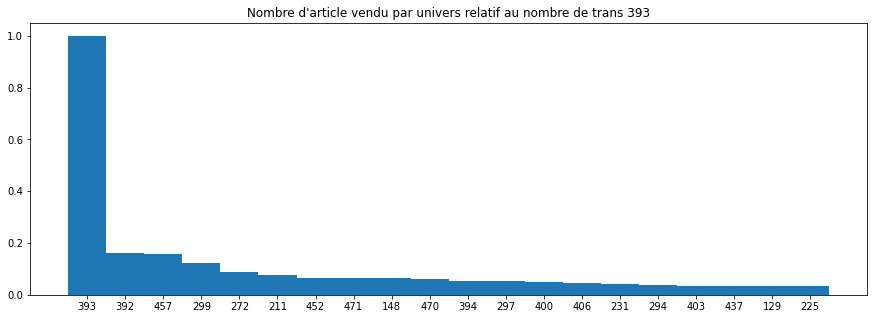

("Proportion d'achat (%)", 3.23)
('Proportion achat seul (%)', 16.39)
("Nombre moyen d'univ", 1.14)
('CA univ', 589220.62)
('CA moyen univ', 4.81)
('Nombre moyen article en plus', 3.14)
('CA en plus', 1146713.52)
('CA moyen en plus', 9.36)
==============394===================


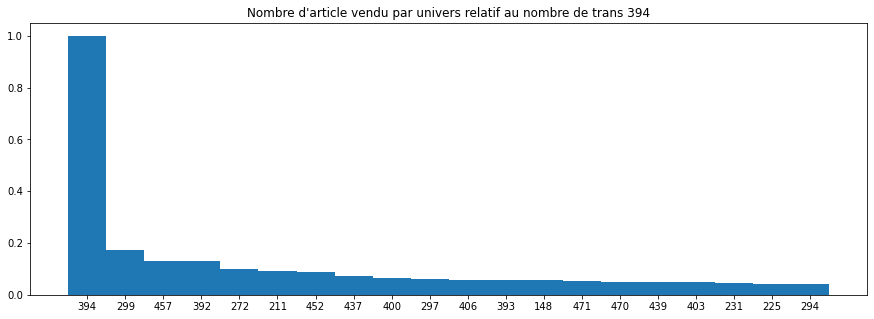

("Proportion d'achat (%)", 3.11)
('Proportion achat seul (%)', 9.93)
("Nombre moyen d'univ", 1.49)
('CA univ', 317286.84)
('CA moyen univ', 2.69)
('Nombre moyen article en plus', 3.67)
('CA en plus', 1345286.3)
('CA moyen en plus', 11.41)
==============395===================


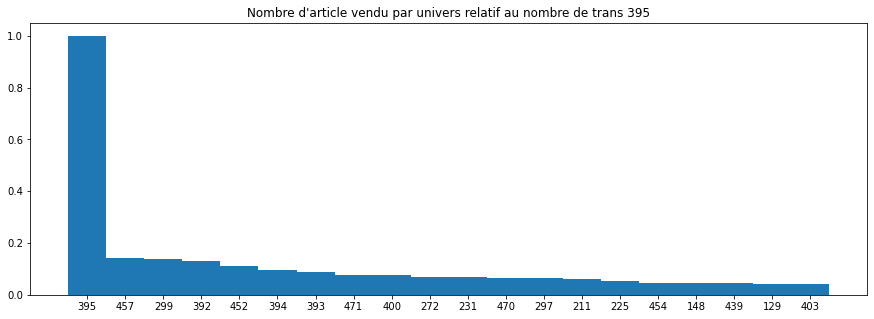

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 12.43)
("Nombre moyen d'univ", 1.08)
('CA univ', 3332.48)
('CA moyen univ', 3.94)
('Nombre moyen article en plus', 3.49)
('CA en plus', 8417.2)
('CA moyen en plus', 9.96)
==============396===================


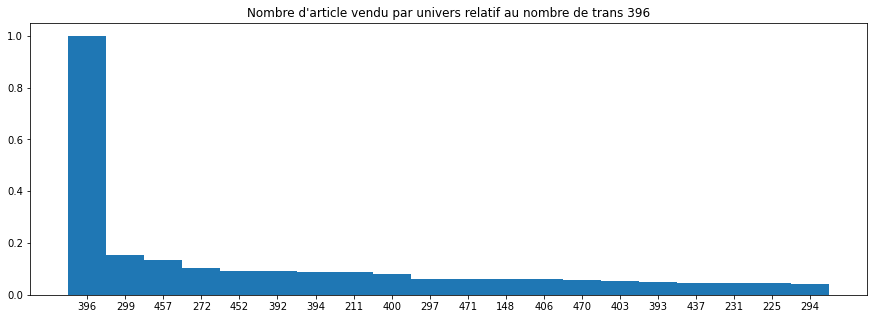

("Proportion d'achat (%)", 1.06)
('Proportion achat seul (%)', 11.13)
("Nombre moyen d'univ", 1.17)
('CA univ', 132878.03)
('CA moyen univ', 3.3)
('Nombre moyen article en plus', 3.74)
('CA en plus', 479465.5)
('CA moyen en plus', 11.9)
==============397===================


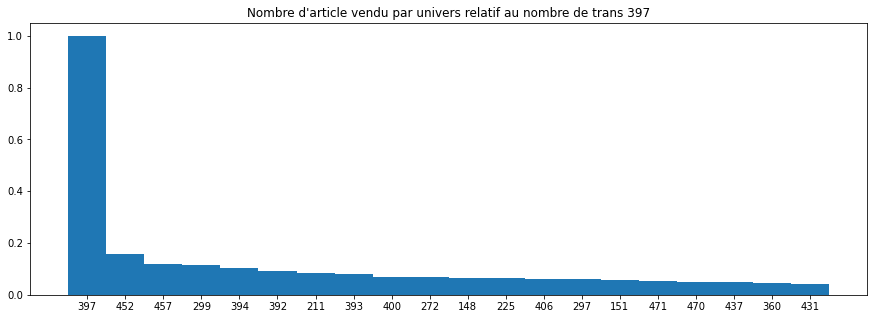

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 9.03)
("Nombre moyen d'univ", 1.19)
('CA univ', 9325.86)
('CA moyen univ', 4.17)
('Nombre moyen article en plus', 3.84)
('CA en plus', 24716.26)
('CA moyen en plus', 11.05)
==============400===================


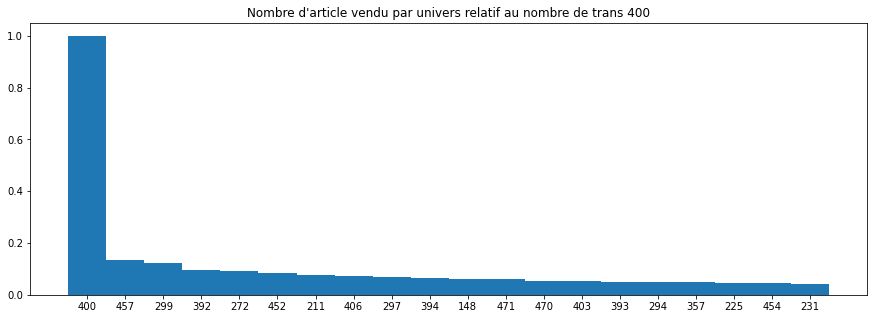

("Proportion d'achat (%)", 3.03)
('Proportion achat seul (%)', 11.99)
("Nombre moyen d'univ", 1.19)
('CA univ', 519978.19)
('CA moyen univ', 4.52)
('Nombre moyen article en plus', 3.68)
('CA en plus', 1388237.65)
('CA moyen en plus', 12.06)
==============402===================


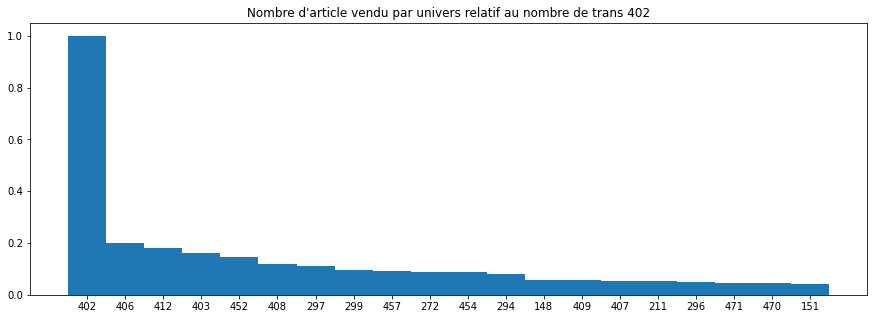

("Proportion d'achat (%)", 3.47)
('Proportion achat seul (%)', 6.85)
("Nombre moyen d'univ", 1.28)
('CA univ', 1049695.51)
('CA moyen univ', 7.96)
('Nombre moyen article en plus', 5.34)
('CA en plus', 2860738.0)
('CA moyen en plus', 21.7)
==============403===================


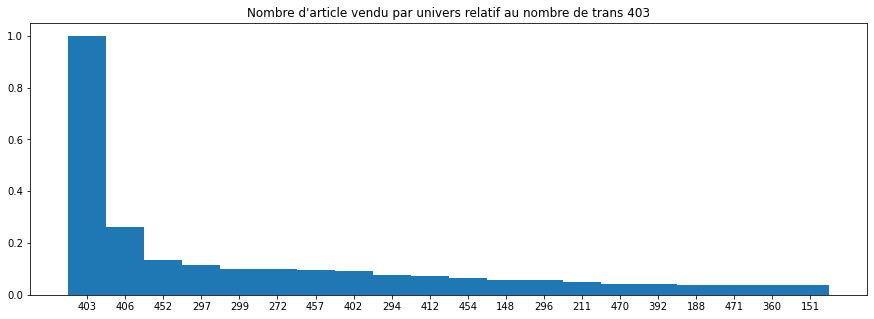

("Proportion d'achat (%)", 6.21)
('Proportion achat seul (%)', 10.57)
("Nombre moyen d'univ", 1.48)
('CA univ', 2420809.68)
('CA moyen univ', 10.27)
('Nombre moyen article en plus', 4.8)
('CA en plus', 4456623.44)
('CA moyen en plus', 18.9)
==============404===================


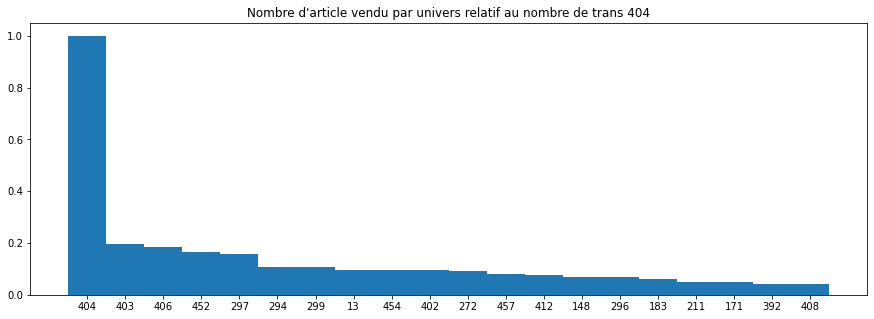

("Proportion d'achat (%)", 0.64)
('Proportion achat seul (%)', 5.12)
("Nombre moyen d'univ", 1.37)
('CA univ', 252693.86)
('CA moyen univ', 10.37)
('Nombre moyen article en plus', 6.4)
('CA en plus', 617986.18)
('CA moyen en plus', 25.36)
==============405===================


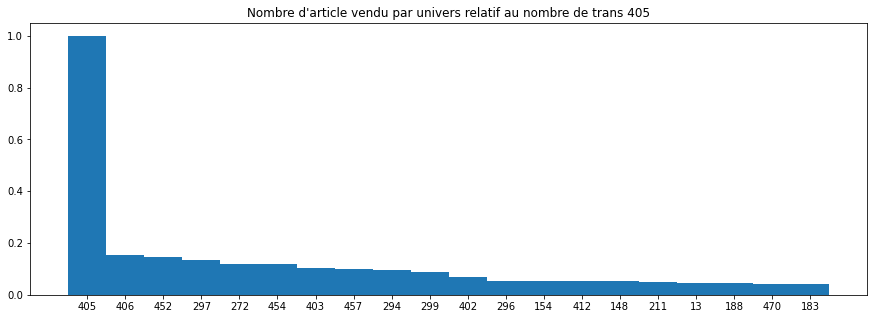

("Proportion d'achat (%)", 0.72)
('Proportion achat seul (%)', 9.5)
("Nombre moyen d'univ", 1.41)
('CA univ', 263707.71)
('CA moyen univ', 9.68)
('Nombre moyen article en plus', 5.33)
('CA en plus', 560670.3)
('CA moyen en plus', 20.58)
==============406===================


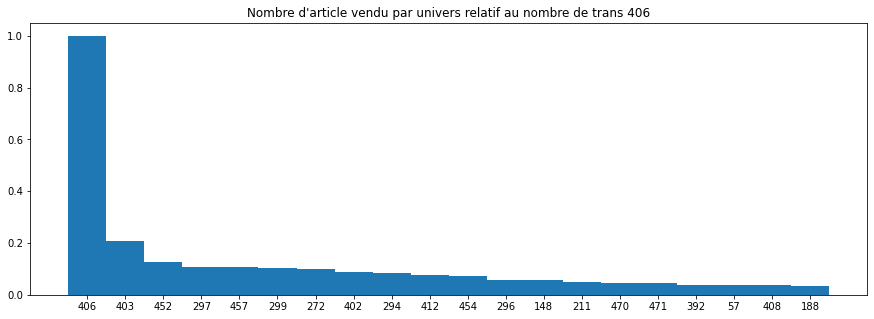

("Proportion d'achat (%)", 7.78)
('Proportion achat seul (%)', 10.77)
("Nombre moyen d'univ", 1.45)
('CA univ', 2778075.59)
('CA moyen univ', 9.41)
('Nombre moyen article en plus', 4.54)
('CA en plus', 5169797.02)
('CA moyen en plus', 17.51)
==============407===================


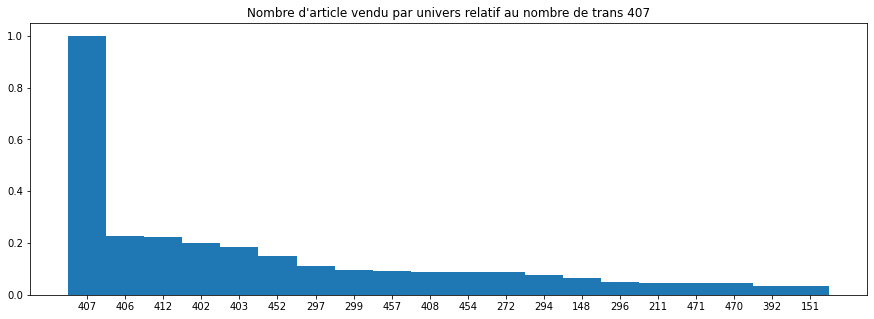

("Proportion d'achat (%)", 0.95)
('Proportion achat seul (%)', 6.73)
("Nombre moyen d'univ", 1.2)
('CA univ', 290057.85)
('CA moyen univ', 8.03)
('Nombre moyen article en plus', 5.5)
('CA en plus', 817928.01)
('CA moyen en plus', 22.63)
==============408===================


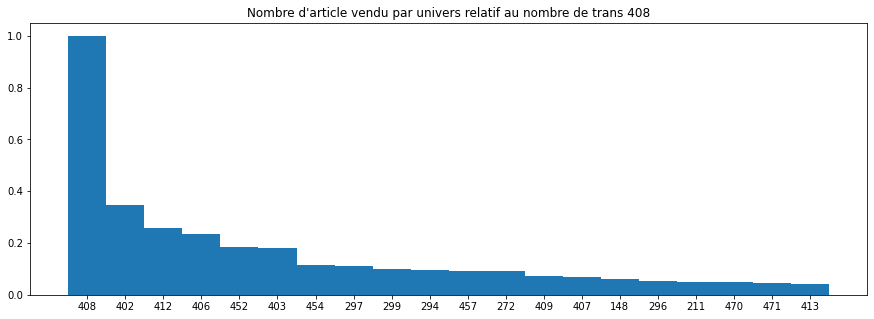

("Proportion d'achat (%)", 1.21)
('Proportion achat seul (%)', 2.05)
("Nombre moyen d'univ", 1.2)
('CA univ', 340749.02)
('CA moyen univ', 7.44)
('Nombre moyen article en plus', 6.42)
('CA en plus', 1271972.64)
('CA moyen en plus', 27.76)
==============409===================


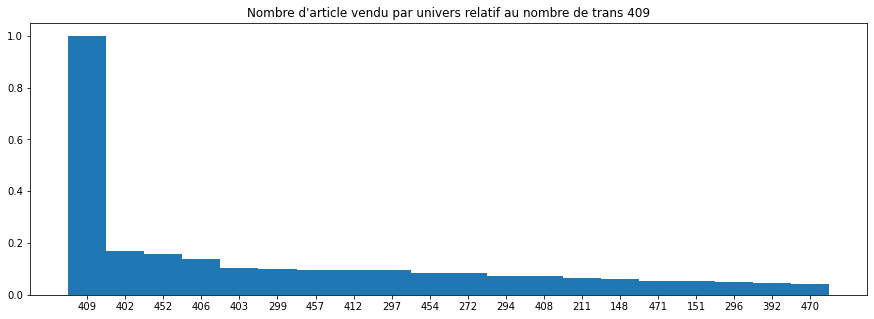

("Proportion d'achat (%)", 1.17)
('Proportion achat seul (%)', 7.92)
("Nombre moyen d'univ", 1.3)
('CA univ', 574688.59)
('CA moyen univ', 12.98)
('Nombre moyen article en plus', 5.22)
('CA en plus', 898804.94)
('CA moyen en plus', 20.31)
==============410===================


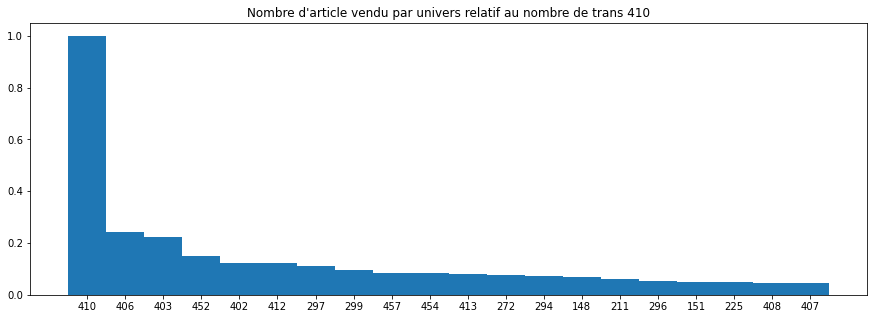

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 6.07)
("Nombre moyen d'univ", 1.11)
('CA univ', 48639.11)
('CA moyen univ', 7.43)
('Nombre moyen article en plus', 5.51)
('CA en plus', 127131.16)
('CA moyen en plus', 19.43)
==============411===================


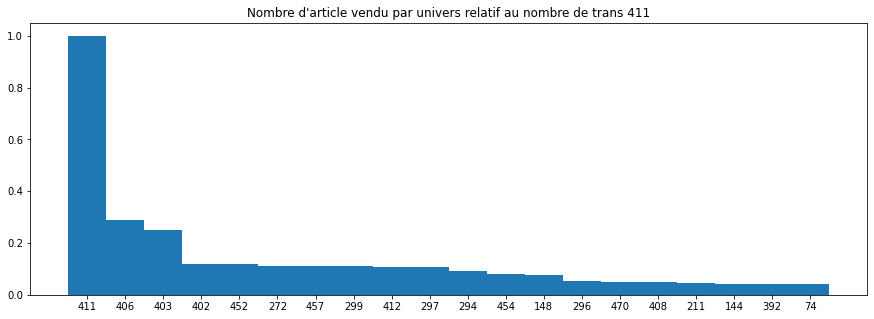

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 6.03)
("Nombre moyen d'univ", 1.18)
('CA univ', 37827.15)
('CA moyen univ', 10.57)
('Nombre moyen article en plus', 5.73)
('CA en plus', 88885.1)
('CA moyen en plus', 24.83)
==============412===================


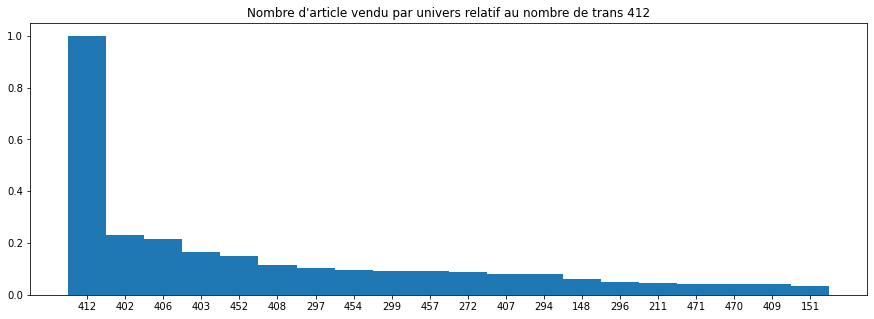

("Proportion d'achat (%)", 2.71)
('Proportion achat seul (%)', 7.04)
("Nombre moyen d'univ", 1.32)
('CA univ', 934291.31)
('CA moyen univ', 9.09)
('Nombre moyen article en plus', 5.27)
('CA en plus', 2403816.78)
('CA moyen en plus', 23.38)
==============413===================


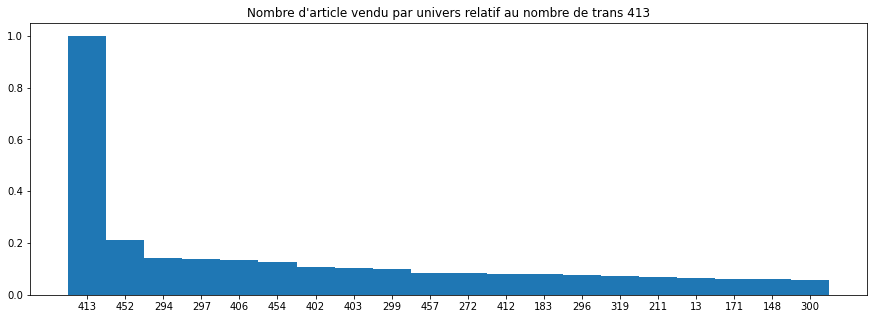

("Proportion d'achat (%)", 1.03)
('Proportion achat seul (%)', 2.73)
("Nombre moyen d'univ", 1.45)
('CA univ', 273839.72)
('CA moyen univ', 7.02)
('Nombre moyen article en plus', 6.77)
('CA en plus', 994770.37)
('CA moyen en plus', 25.49)
==============416===================


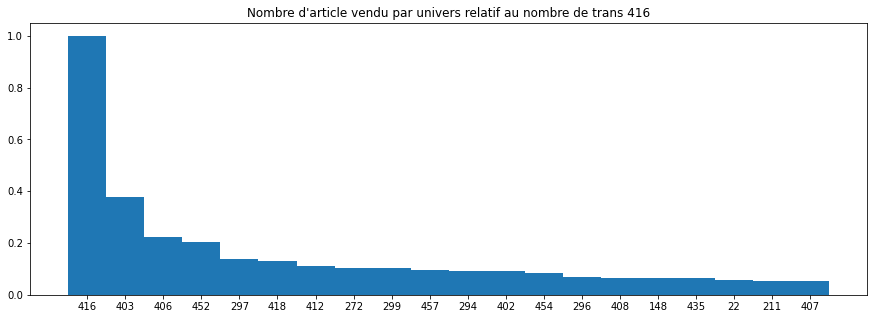

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 2.97)
("Nombre moyen d'univ", 1.18)
('CA univ', 96034.57)
('CA moyen univ', 5.19)
('Nombre moyen article en plus', 6.94)
('CA en plus', 536569.33)
('CA moyen en plus', 29.01)
==============417===================


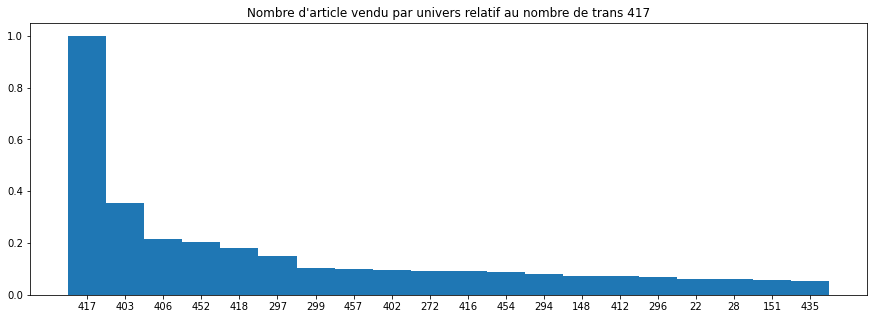

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 3.11)
("Nombre moyen d'univ", 1.14)
('CA univ', 17613.92)
('CA moyen univ', 5.58)
('Nombre moyen article en plus', 6.96)
('CA en plus', 90164.0)
('CA moyen en plus', 28.58)
==============418===================


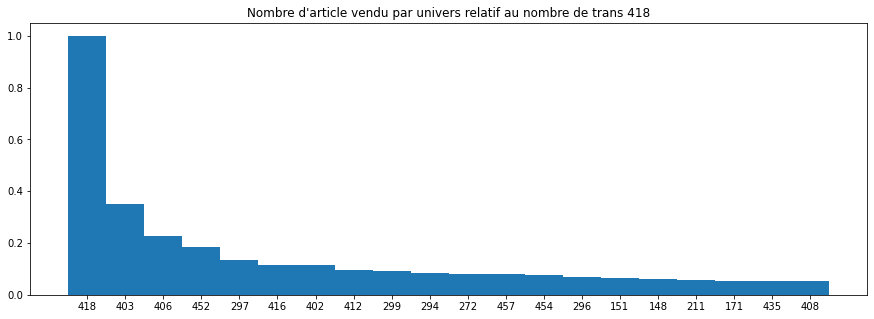

("Proportion d'achat (%)", 0.54)
('Proportion achat seul (%)', 2.77)
("Nombre moyen d'univ", 1.21)
('CA univ', 122968.13)
('CA moyen univ', 5.99)
('Nombre moyen article en plus', 6.65)
('CA en plus', 570137.3)
('CA moyen en plus', 27.79)
==============419===================


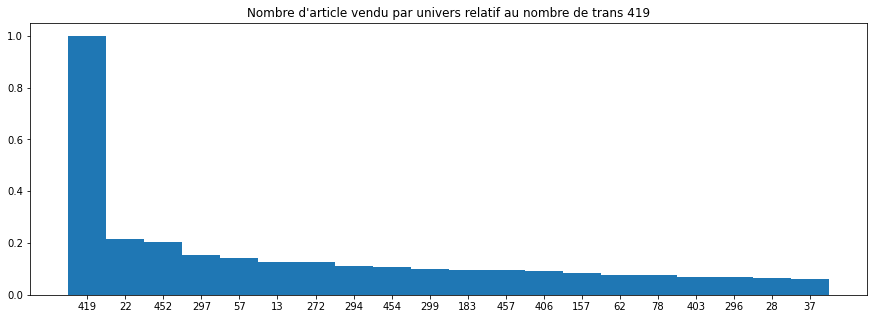

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 4.36)
("Nombre moyen d'univ", 1.3)
('CA univ', 21355.93)
('CA moyen univ', 3.33)
('Nombre moyen article en plus', 7.58)
('CA en plus', 185400.2)
('CA moyen en plus', 28.89)
==============420===================


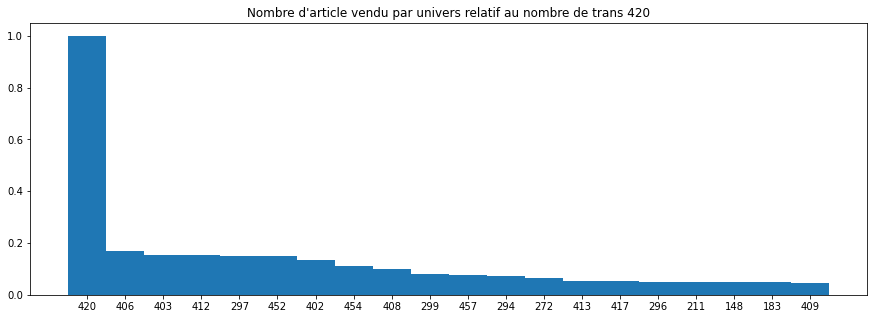

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.96)
("Nombre moyen d'univ", 1.15)
('CA univ', 10584.61)
('CA moyen univ', 11.91)
('Nombre moyen article en plus', 5.91)
('CA en plus', 21243.93)
('CA moyen en plus', 23.9)
==============421===================


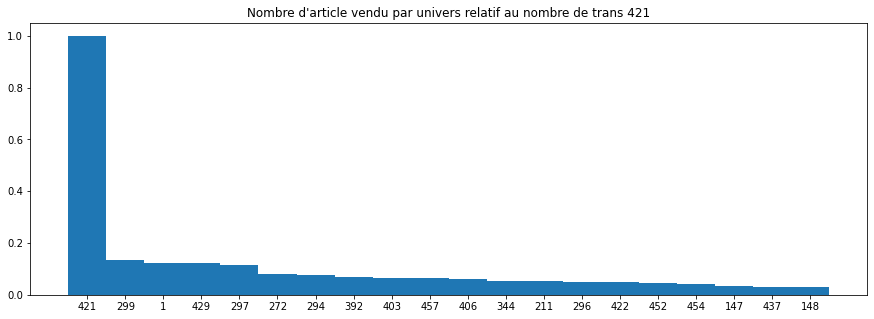

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 18.78)
("Nombre moyen d'univ", 1.91)
('CA univ', 30071.26)
('CA moyen univ', 68.03)
('Nombre moyen article en plus', 10.27)
('CA en plus', 15833.71)
('CA moyen en plus', 35.82)
==============422===================


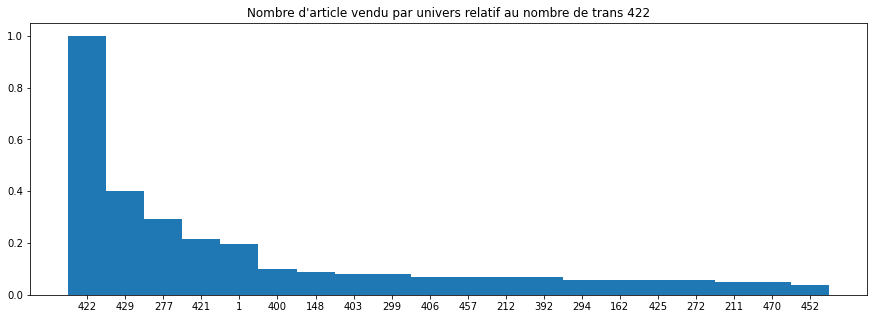

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 1.96)
("Nombre moyen d'univ", 1.25)
('CA univ', 1896.35)
('CA moyen univ', 18.59)
('Nombre moyen article en plus', 5.03)
('CA en plus', 8490.21)
('CA moyen en plus', 83.24)
==============425===================
NOT ENOUGH DATA 
==============429===================


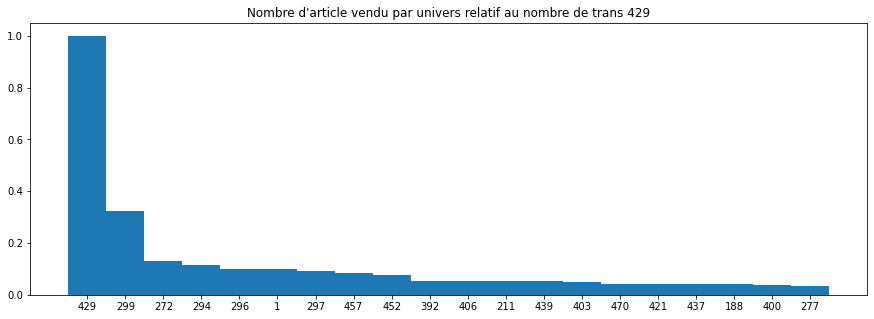

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 10.98)
("Nombre moyen d'univ", 1.99)
('CA univ', 38125.7)
('CA moyen univ', 29.06)
('Nombre moyen article en plus', 4.87)
('CA en plus', 32498.92)
('CA moyen en plus', 24.77)
==============430===================


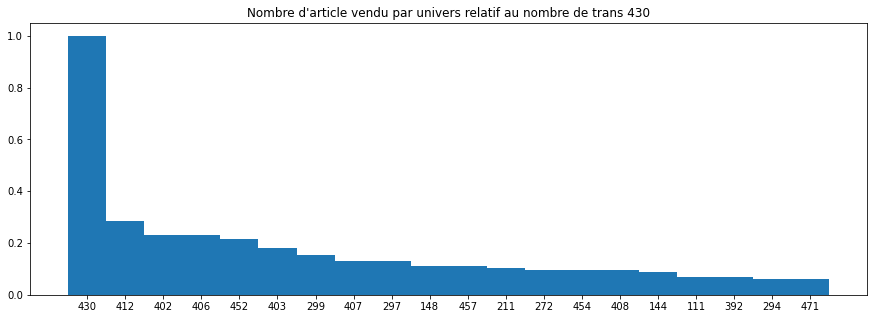

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 1.72)
("Nombre moyen d'univ", 1.09)
('CA univ', 859.65)
('CA moyen univ', 7.41)
('Nombre moyen article en plus', 6.47)
('CA en plus', 3034.25)
('CA moyen en plus', 26.16)
==============431===================


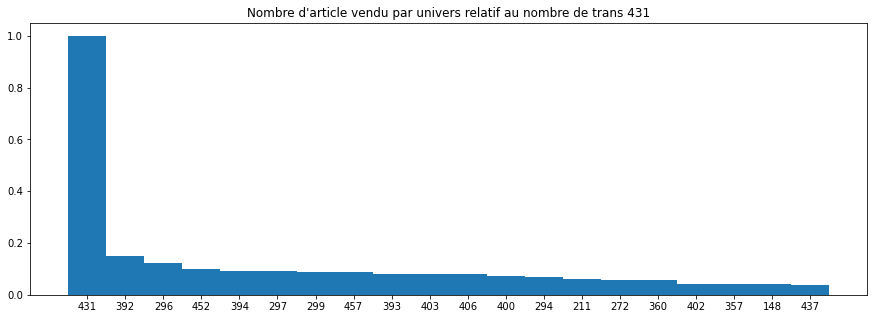

("Proportion d'achat (%)", 0.89)
('Proportion achat seul (%)', 6.64)
("Nombre moyen d'univ", 1.13)
('CA univ', 104244.05)
('CA moyen univ', 3.09)
('Nombre moyen article en plus', 3.74)
('CA en plus', 409137.11)
('CA moyen en plus', 12.11)
==============432===================


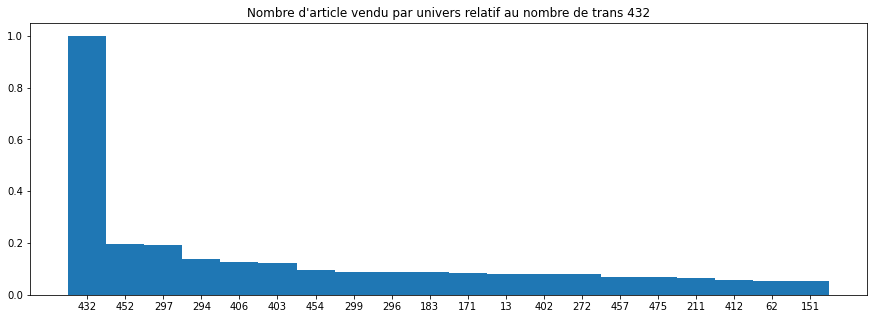

("Proportion d'achat (%)", 0.42)
('Proportion achat seul (%)', 4.85)
("Nombre moyen d'univ", 1.17)
('CA univ', 115149.39)
('CA moyen univ', 7.23)
('Nombre moyen article en plus', 7.03)
('CA en plus', 412323.64)
('CA moyen en plus', 25.88)
==============433===================


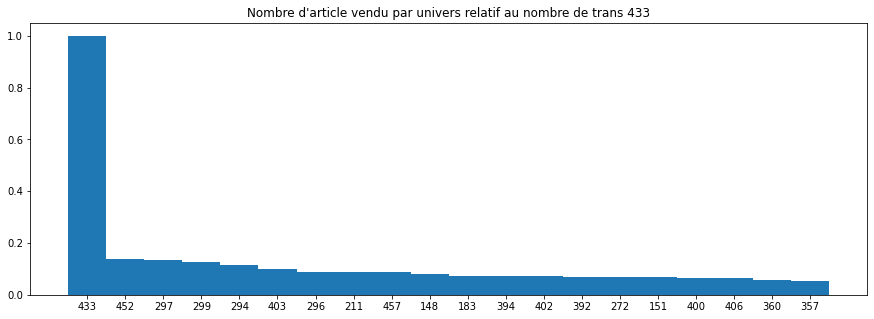

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 4.14)
("Nombre moyen d'univ", 1.27)
('CA univ', 882.9)
('CA moyen univ', 3.04)
('Nombre moyen article en plus', 5.68)
('CA en plus', 5855.28)
('CA moyen en plus', 20.19)
==============434===================


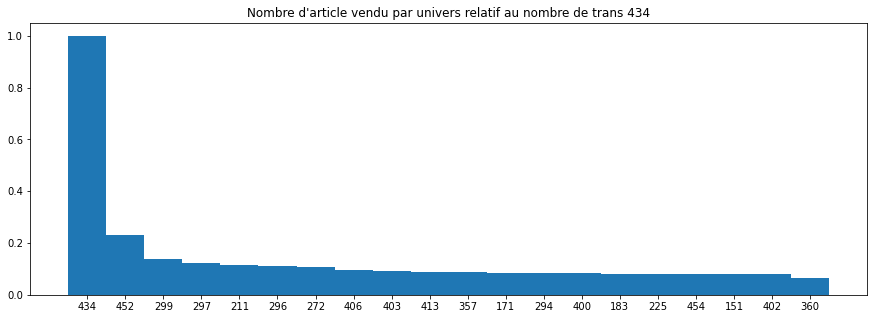

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.55)
("Nombre moyen d'univ", 1.08)
('CA univ', 1659.34)
('CA moyen univ', 3.67)
('Nombre moyen article en plus', 6.65)
('CA en plus', 10163.76)
('CA moyen en plus', 22.49)
==============435===================


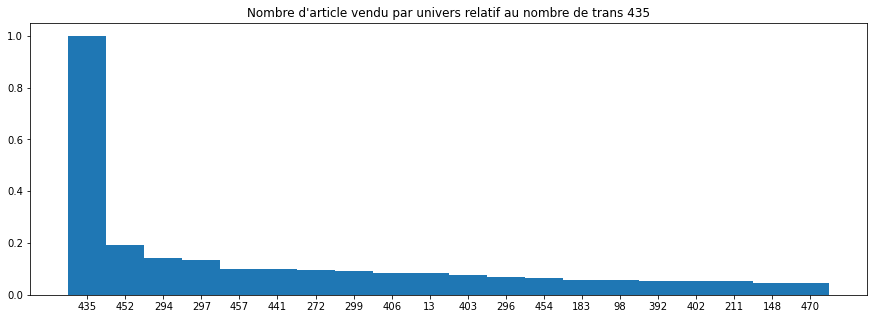

("Proportion d'achat (%)", 1.52)
('Proportion achat seul (%)', 9.36)
("Nombre moyen d'univ", 1.17)
('CA univ', 414492.13)
('CA moyen univ', 7.17)
('Nombre moyen article en plus', 5.15)
('CA en plus', 999844.83)
('CA moyen en plus', 17.3)
==============436===================


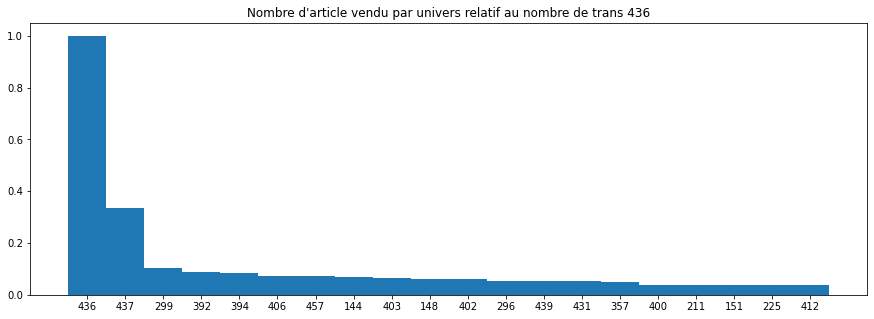

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 11.0)
("Nombre moyen d'univ", 1.18)
('CA univ', 2060.27)
('CA moyen univ', 3.54)
('Nombre moyen article en plus', 3.02)
('CA en plus', 6253.39)
('CA moyen en plus', 10.74)
==============437===================


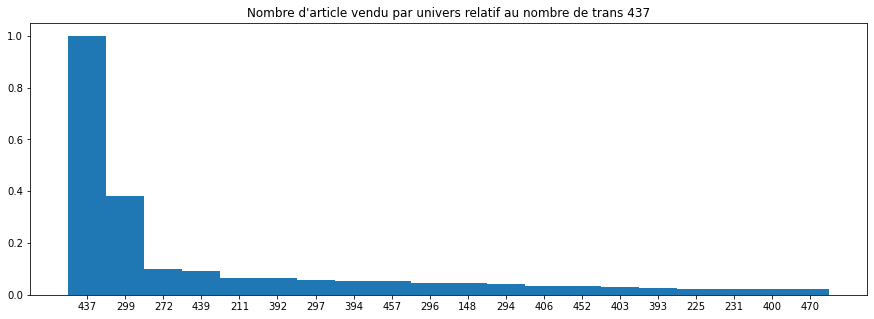

("Proportion d'achat (%)", 4.09)
('Proportion achat seul (%)', 20.75)
("Nombre moyen d'univ", 1.28)
('CA univ', 354598.68)
('CA moyen univ', 2.29)
('Nombre moyen article en plus', 2.91)
('CA en plus', 1249220.69)
('CA moyen en plus', 8.05)
==============438===================


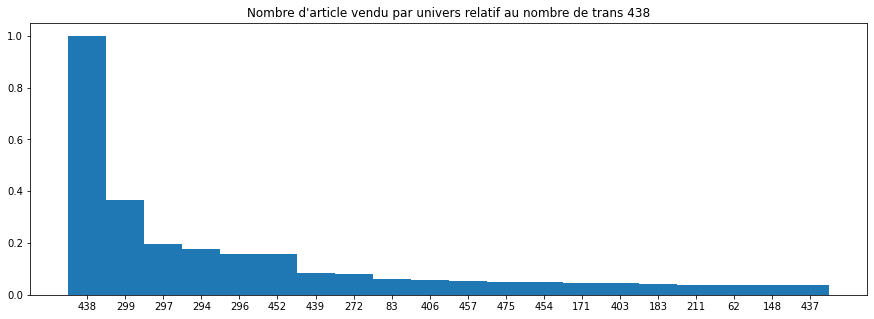

("Proportion d'achat (%)", 0.78)
('Proportion achat seul (%)', 11.07)
("Nombre moyen d'univ", 1.1)
('CA univ', 183018.07)
('CA moyen univ', 6.21)
('Nombre moyen article en plus', 6.24)
('CA en plus', 549814.54)
('CA moyen en plus', 18.66)
==============439===================


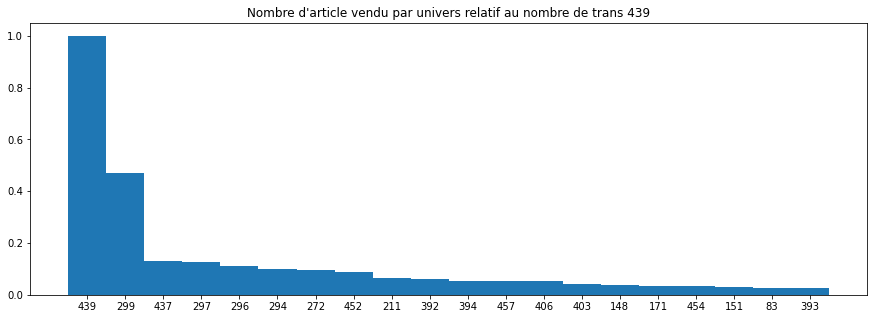

("Proportion d'achat (%)", 2.89)
('Proportion achat seul (%)', 7.14)
("Nombre moyen d'univ", 1.13)
('CA univ', 315045.97)
('CA moyen univ', 2.87)
('Nombre moyen article en plus', 4.64)
('CA en plus', 1381408.46)
('CA moyen en plus', 12.57)
==============440===================


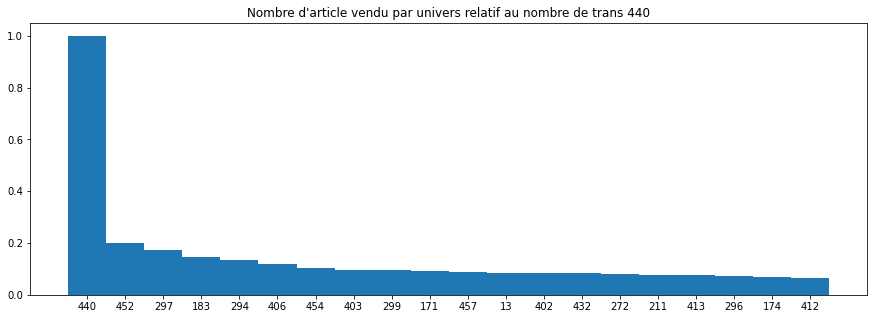

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 3.48)
("Nombre moyen d'univ", 1.12)
('CA univ', 14889.22)
('CA moyen univ', 6.91)
('Nombre moyen article en plus', 7.78)
('CA en plus', 63076.23)
('CA moyen en plus', 29.27)
==============441===================


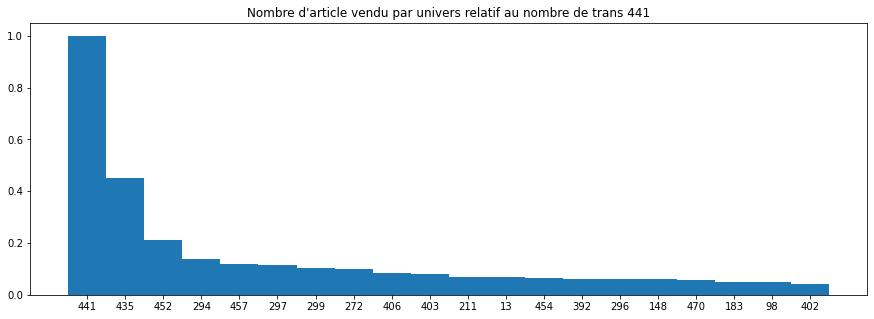

("Proportion d'achat (%)", 0.34)
('Proportion achat seul (%)', 4.6)
("Nombre moyen d'univ", 1.15)
('CA univ', 30018.11)
('CA moyen univ', 2.35)
('Nombre moyen article en plus', 5.57)
('CA en plus', 258856.8)
('CA moyen en plus', 20.26)
==============442===================


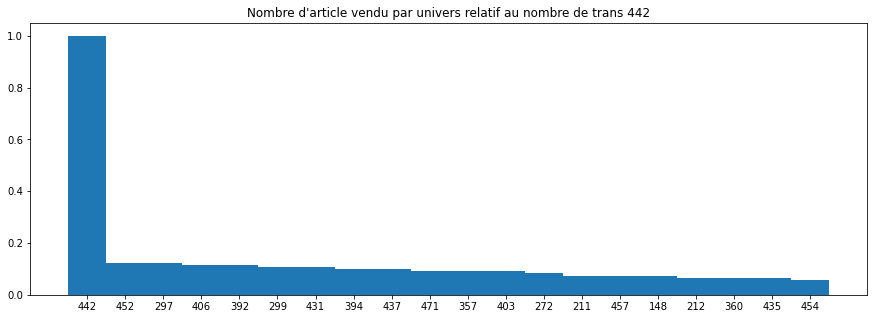

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 5.0)
("Nombre moyen d'univ", 1.17)
('CA univ', 618.85)
('CA moyen univ', 4.42)
('Nombre moyen article en plus', 4.91)
('CA en plus', 2135.82)
('CA moyen en plus', 15.26)
==============443===================


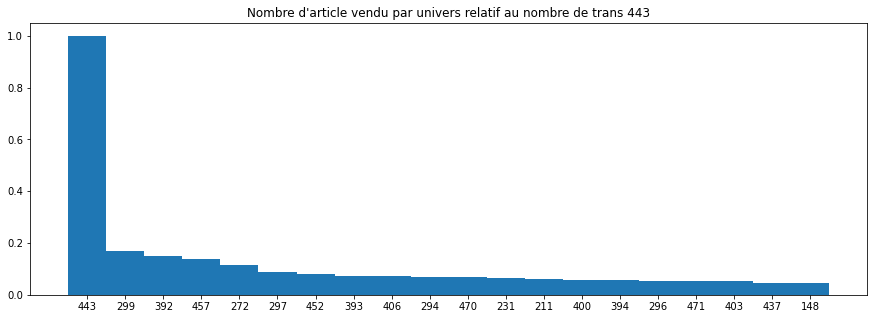

("Proportion d'achat (%)", 1.22)
('Proportion achat seul (%)', 8.45)
("Nombre moyen d'univ", 1.19)
('CA univ', 118355.38)
('CA moyen univ', 2.55)
('Nombre moyen article en plus', 3.82)
('CA en plus', 552265.54)
('CA moyen en plus', 11.89)
==============444===================


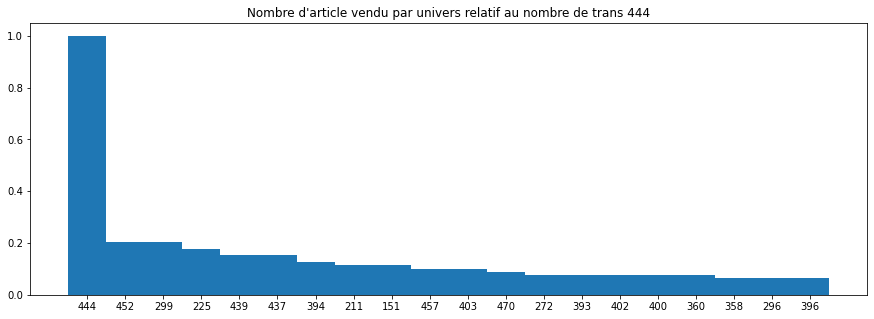

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 5.06)
("Nombre moyen d'univ", 1.27)
('CA univ', 255.72)
('CA moyen univ', 3.24)
('Nombre moyen article en plus', 5.08)
('CA en plus', 1257.2)
('CA moyen en plus', 15.91)
==============445===================


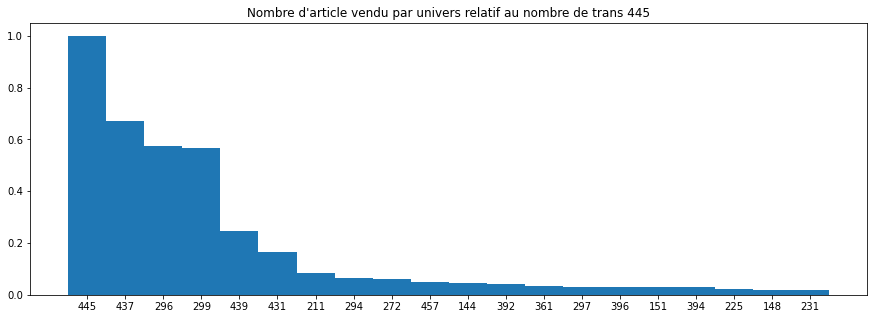

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.51)
("Nombre moyen d'univ", 1.46)
('CA univ', 196.05)
('CA moyen univ', 0.7)
('Nombre moyen article en plus', 4.49)
('CA en plus', 2906.82)
('CA moyen en plus', 10.42)
==============446===================
NOT ENOUGH DATA 
==============447===================


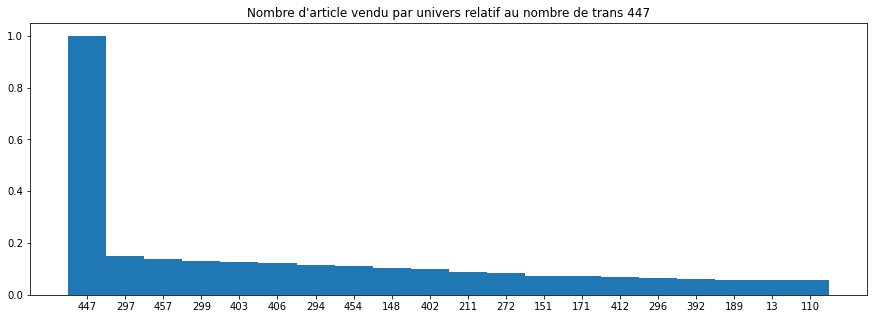

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 3.25)
("Nombre moyen d'univ", 1.21)
('CA univ', 131.75)
('CA moyen univ', 0.29)
('Nombre moyen article en plus', 8.19)
('CA en plus', 14191.1)
('CA moyen en plus', 30.78)
==============448===================


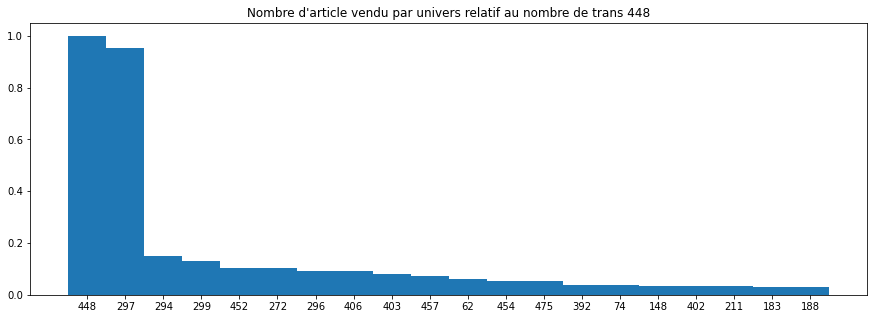

("Proportion d'achat (%)", 0.62)
('Proportion achat seul (%)', 0.06)
("Nombre moyen d'univ", 1.07)
('CA univ', 2462.52)
('CA moyen univ', 0.1)
('Nombre moyen article en plus', 5.33)
('CA en plus', 402792.69)
('CA moyen en plus', 17.0)
==============449===================


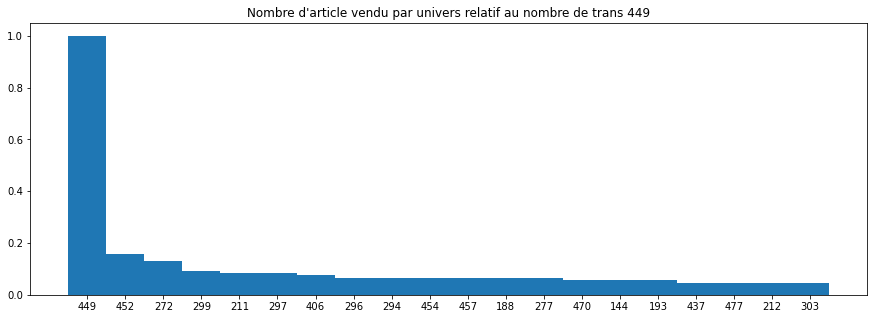

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 16.82)
("Nombre moyen d'univ", 1.71)
('CA univ', 192.46)
('CA moyen univ', 1.8)
('Nombre moyen article en plus', 5.13)
('CA en plus', 2258.9)
('CA moyen en plus', 21.11)
==============450===================
NOT ENOUGH DATA 
==============451===================
NOT ENOUGH DATA 
==============452===================


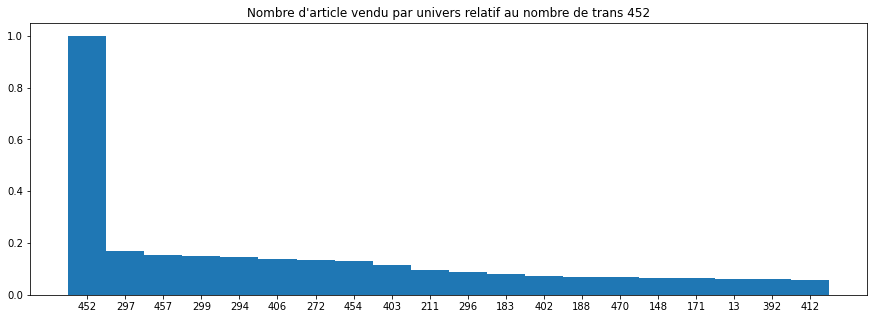

("Proportion d'achat (%)", 7.1)
('Proportion achat seul (%)', 1.81)
("Nombre moyen d'univ", 1.06)
('CA univ', 45483.43)
('CA moyen univ', 0.17)
('Nombre moyen article en plus', 7.9)
('CA en plus', 7954117.76)
('CA moyen en plus', 29.5)
==============453===================


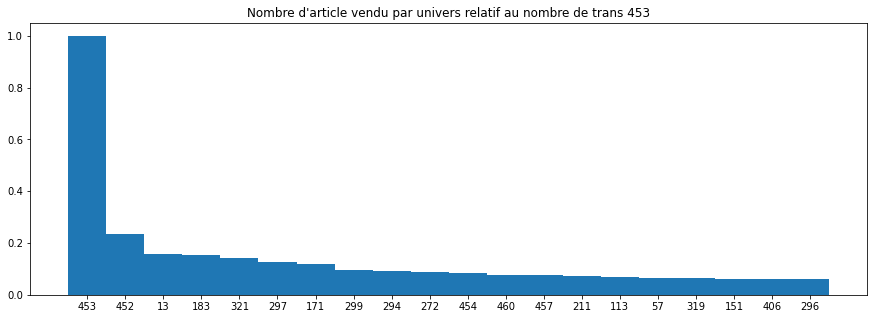

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.44)
("Nombre moyen d'univ", 1.14)
('CA univ', 8425.73)
('CA moyen univ', 4.53)
('Nombre moyen article en plus', 8.24)
('CA en plus', 54337.13)
('CA moyen en plus', 29.21)
==============454===================


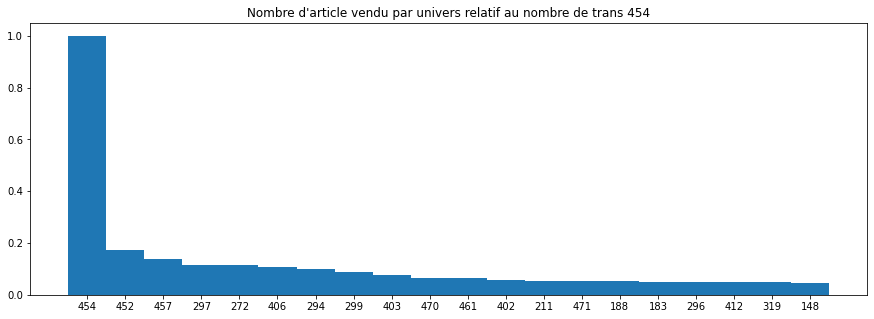

("Proportion d'achat (%)", 5.33)
('Proportion achat seul (%)', 5.32)
("Nombre moyen d'univ", 1.32)
('CA univ', 678349.13)
('CA moyen univ', 3.35)
('Nombre moyen article en plus', 5.65)
('CA en plus', 4424585.12)
('CA moyen en plus', 21.86)
==============455===================


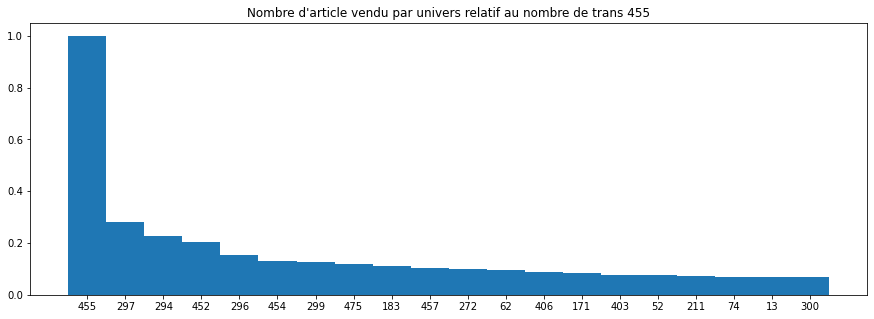

("Proportion d'achat (%)", 0.66)
('Proportion achat seul (%)', 2.03)
("Nombre moyen d'univ", 1.07)
('CA univ', 77688.99)
('CA moyen univ', 3.1)
('Nombre moyen article en plus', 8.02)
('CA en plus', 670042.21)
('CA moyen en plus', 26.73)
==============456===================


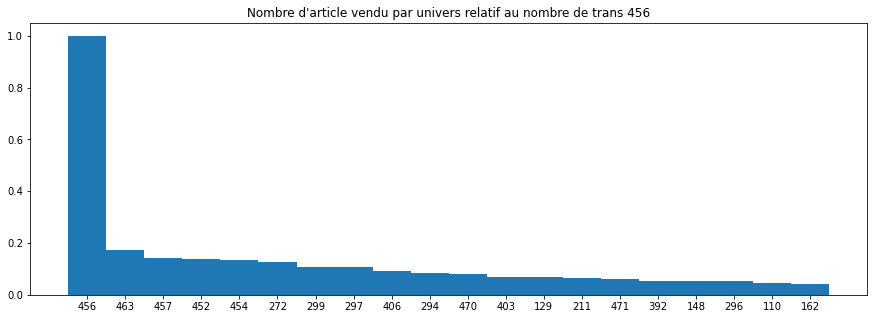

("Proportion d'achat (%)", 0.91)
('Proportion achat seul (%)', 5.54)
("Nombre moyen d'univ", 1.14)
('CA univ', 89250.63)
('CA moyen univ', 2.57)
('Nombre moyen article en plus', 5.52)
('CA en plus', 648937.61)
('CA moyen en plus', 18.71)
==============457===================


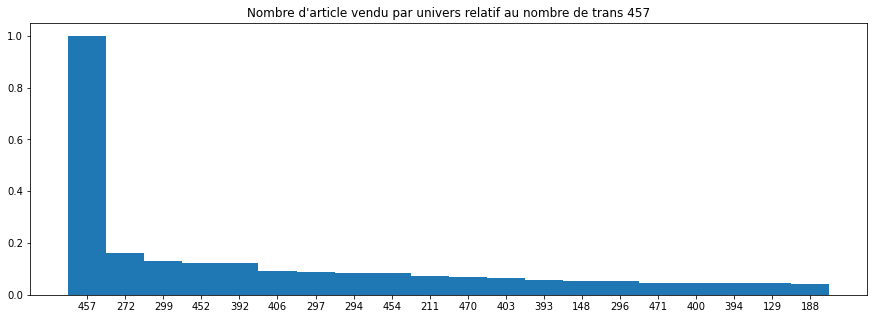

("Proportion d'achat (%)", 8.89)
('Proportion achat seul (%)', 7.21)
("Nombre moyen d'univ", 1.23)
('CA univ', 791489.01)
('CA moyen univ', 2.34)
('Nombre moyen article en plus', 4.39)
('CA en plus', 5202708.14)
('CA moyen en plus', 15.41)
==============458===================


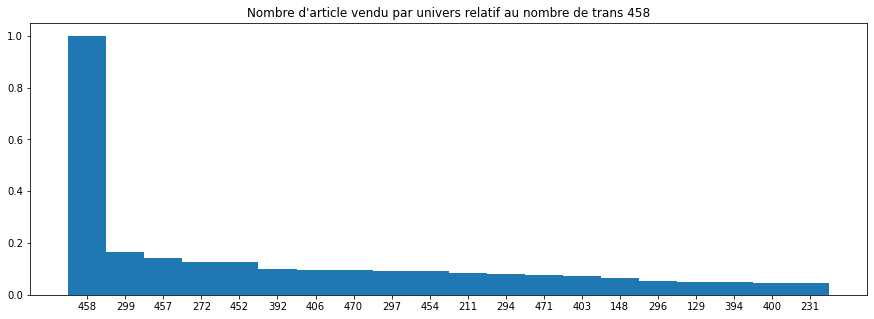

("Proportion d'achat (%)", 1.07)
('Proportion achat seul (%)', 6.03)
("Nombre moyen d'univ", 1.14)
('CA univ', 82958.6)
('CA moyen univ', 2.03)
('Nombre moyen article en plus', 5.08)
('CA en plus', 673270.59)
('CA moyen en plus', 16.5)
==============460===================


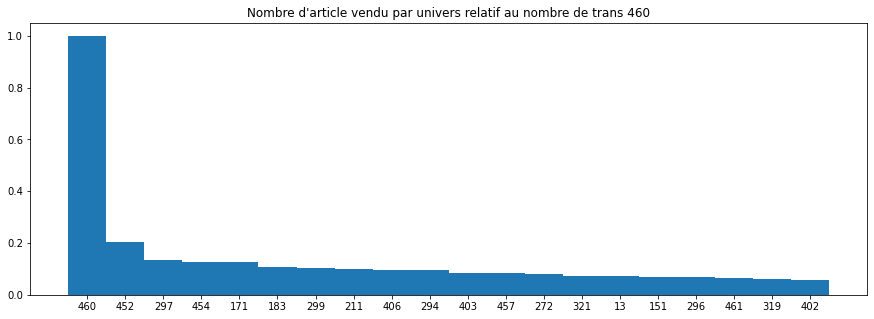

("Proportion d'achat (%)", 0.21)
('Proportion achat seul (%)', 3.05)
("Nombre moyen d'univ", 1.16)
('CA univ', 41708.03)
('CA moyen univ', 5.15)
('Nombre moyen article en plus', 7.74)
('CA en plus', 229037.74)
('CA moyen en plus', 28.26)
==============461===================


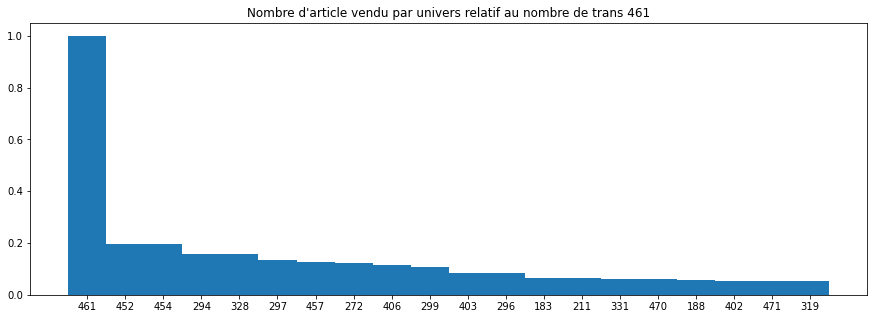

("Proportion d'achat (%)", 1.74)
('Proportion achat seul (%)', 1.9)
("Nombre moyen d'univ", 1.15)
('CA univ', 231084.06)
('CA moyen univ', 3.49)
('Nombre moyen article en plus', 6.89)
('CA en plus', 1641066.26)
('CA moyen en plus', 24.82)
==============462===================


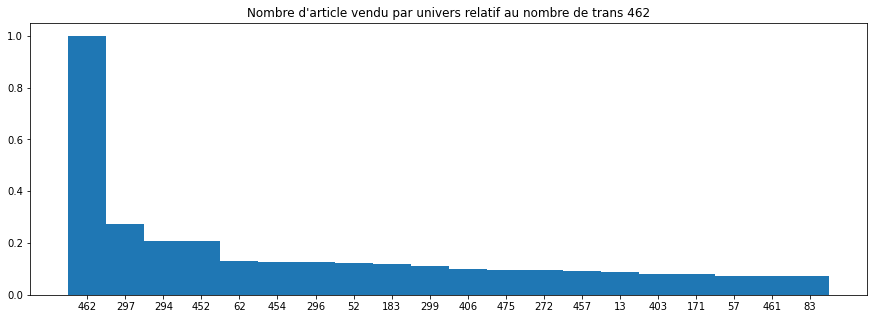

("Proportion d'achat (%)", 0.82)
('Proportion achat seul (%)', 1.85)
("Nombre moyen d'univ", 1.1)
('CA univ', 177373.63)
('CA moyen univ', 5.72)
('Nombre moyen article en plus', 8.35)
('CA en plus', 921106.35)
('CA moyen en plus', 29.72)
==============463===================


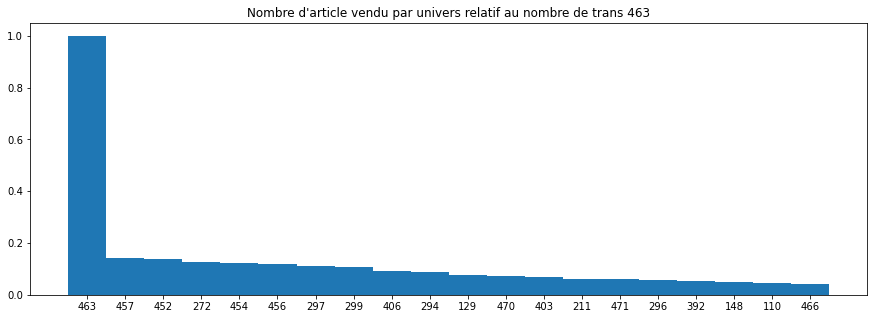

("Proportion d'achat (%)", 1.33)
('Proportion achat seul (%)', 5.37)
("Nombre moyen d'univ", 1.23)
('CA univ', 112577.23)
('CA moyen univ', 2.23)
('Nombre moyen article en plus', 5.33)
('CA en plus', 910963.19)
('CA moyen en plus', 18.01)
==============464===================


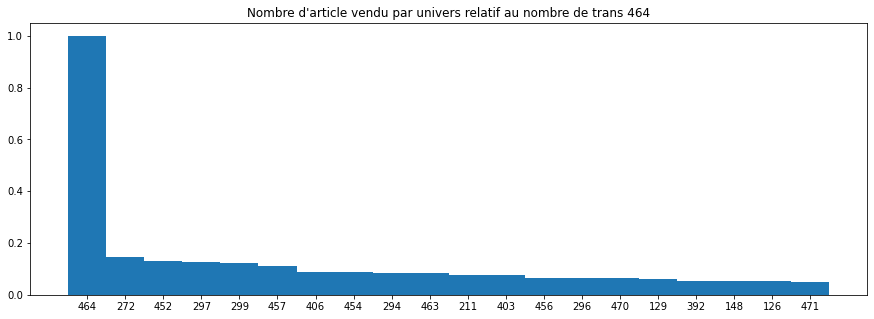

("Proportion d'achat (%)", 0.34)
('Proportion achat seul (%)', 5.62)
("Nombre moyen d'univ", 1.19)
('CA univ', 31523.42)
('CA moyen univ', 2.45)
('Nombre moyen article en plus', 5.86)
('CA en plus', 260888.17)
('CA moyen en plus', 20.31)
==============465===================


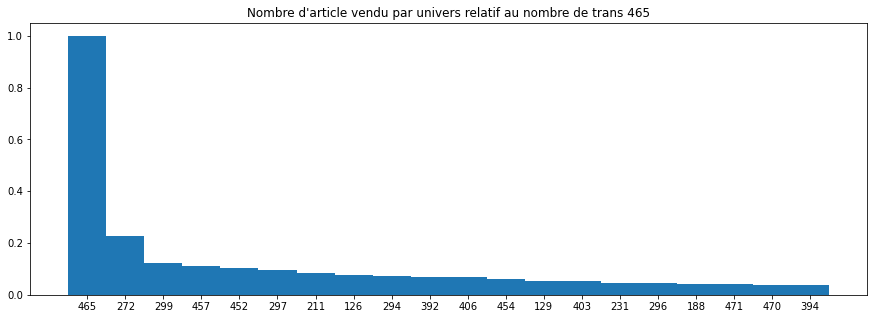

("Proportion d'achat (%)", 0.32)
('Proportion achat seul (%)', 6.64)
("Nombre moyen d'univ", 1.12)
('CA univ', 31584.49)
('CA moyen univ', 2.59)
('Nombre moyen article en plus', 4.59)
('CA en plus', 195169.44)
('CA moyen en plus', 16.03)
==============466===================


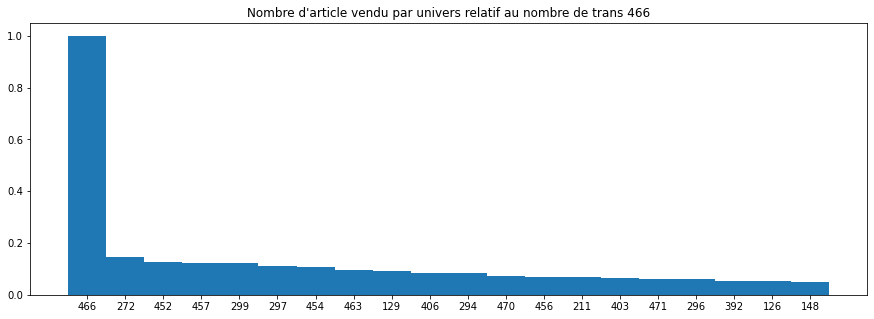

("Proportion d'achat (%)", 0.57)
('Proportion achat seul (%)', 6.39)
("Nombre moyen d'univ", 1.15)
('CA univ', 48828.29)
('CA moyen univ', 2.28)
('Nombre moyen article en plus', 5.31)
('CA en plus', 374891.68)
('CA moyen en plus', 17.47)
==============467===================


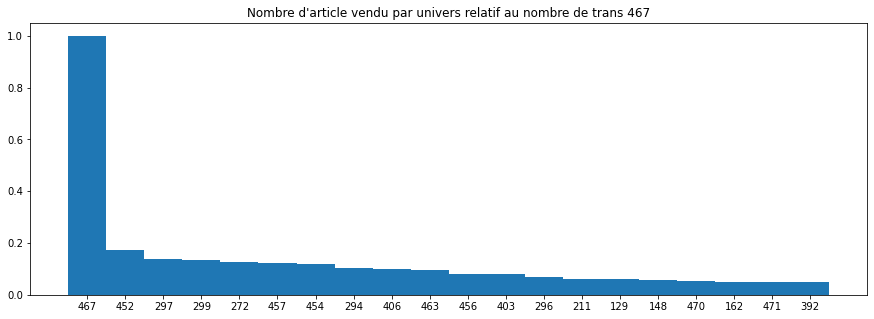

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 5.52)
("Nombre moyen d'univ", 1.25)
('CA univ', 18953.1)
('CA moyen univ', 3.5)
('Nombre moyen article en plus', 6.39)
('CA en plus', 124272.13)
('CA moyen en plus', 22.95)
==============468===================


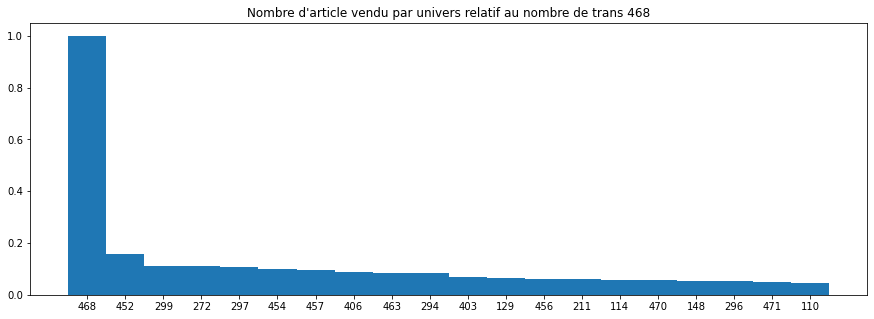

("Proportion d'achat (%)", 0.31)
('Proportion achat seul (%)', 7.93)
("Nombre moyen d'univ", 1.13)
('CA univ', 87965.88)
('CA moyen univ', 7.53)
('Nombre moyen article en plus', 5.87)
('CA en plus', 253162.24)
('CA moyen en plus', 21.67)
==============469===================


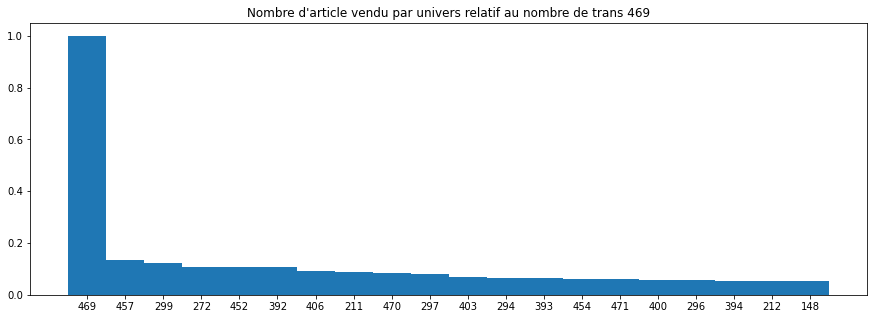

("Proportion d'achat (%)", 0.66)
('Proportion achat seul (%)', 5.54)
("Nombre moyen d'univ", 1.13)
('CA univ', 37259.67)
('CA moyen univ', 1.48)
('Nombre moyen article en plus', 4.79)
('CA en plus', 403903.11)
('CA moyen en plus', 16.06)
==============470===================


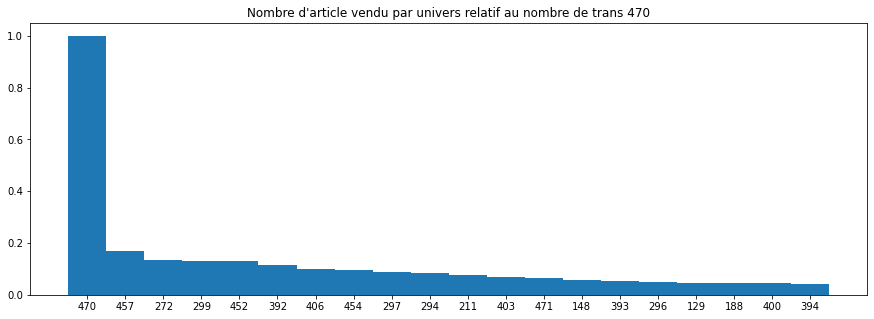

("Proportion d'achat (%)", 3.68)
('Proportion achat seul (%)', 6.06)
("Nombre moyen d'univ", 1.19)
('CA univ', 277839.84)
('CA moyen univ', 1.99)
('Nombre moyen article en plus', 4.81)
('CA en plus', 2239835.98)
('CA moyen en plus', 16.05)
==============471===================


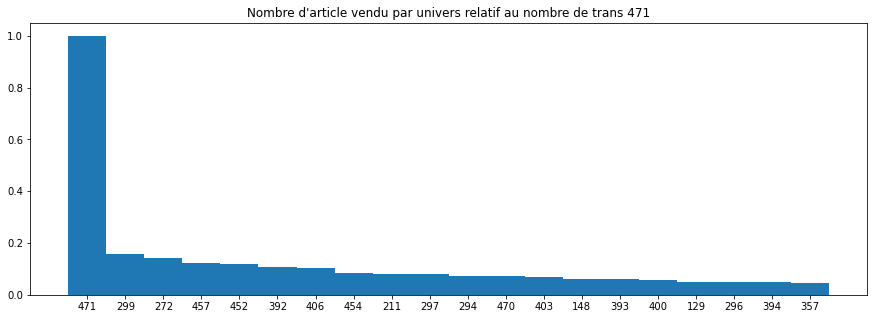

("Proportion d'achat (%)", 3.37)
('Proportion achat seul (%)', 5.72)
("Nombre moyen d'univ", 1.18)
('CA univ', 294008.24)
('CA moyen univ', 2.3)
('Nombre moyen article en plus', 4.7)
('CA en plus', 2027409.9)
('CA moyen en plus', 15.84)
==============472===================


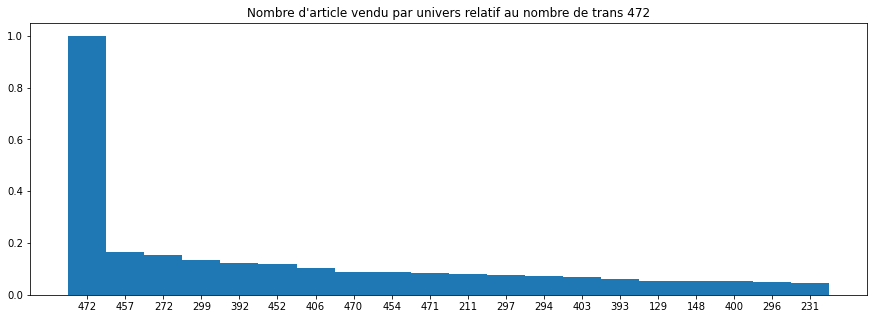

("Proportion d'achat (%)", 1.43)
('Proportion achat seul (%)', 5.41)
("Nombre moyen d'univ", 1.14)
('CA univ', 122824.61)
('CA moyen univ', 2.26)
('Nombre moyen article en plus', 4.61)
('CA en plus', 826935.51)
('CA moyen en plus', 15.22)
==============473===================


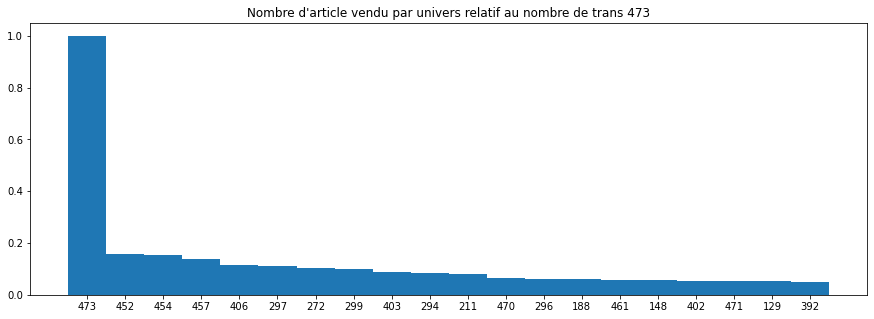

("Proportion d'achat (%)", 1.15)
('Proportion achat seul (%)', 3.81)
("Nombre moyen d'univ", 1.31)
('CA univ', 63133.56)
('CA moyen univ', 1.45)
('Nombre moyen article en plus', 5.74)
('CA en plus', 869829.17)
('CA moyen en plus', 19.94)
==============474===================


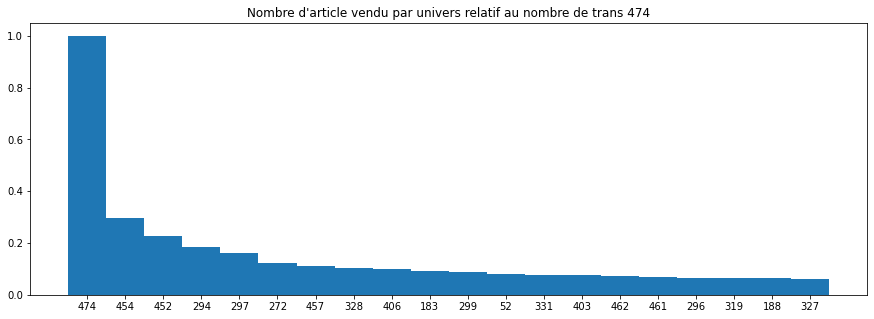

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 1.94)
("Nombre moyen d'univ", 1.07)
('CA univ', 56401.1)
('CA moyen univ', 5.44)
('Nombre moyen article en plus', 7.56)
('CA en plus', 297661.73)
('CA moyen en plus', 28.72)
==============475===================


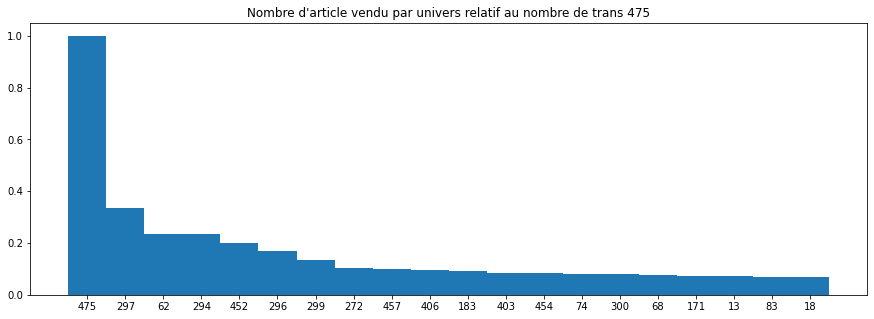

("Proportion d'achat (%)", 1.89)
('Proportion achat seul (%)', 1.42)
("Nombre moyen d'univ", 1.09)
('CA univ', 309302.44)
('CA moyen univ', 4.31)
('Nombre moyen article en plus', 7.9)
('CA en plus', 1890563.4)
('CA moyen en plus', 26.33)
==============476===================


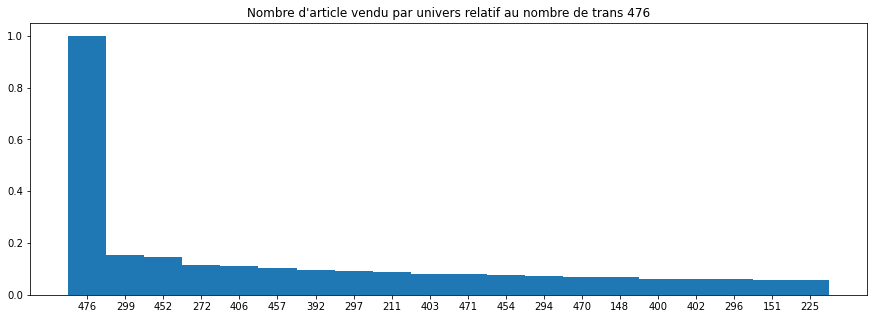

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 4.31)
("Nombre moyen d'univ", 1.23)
('CA univ', 55914.5)
('CA moyen univ', 3.06)
('Nombre moyen article en plus', 5.6)
('CA en plus', 347592.27)
('CA moyen en plus', 19.03)
==============477===================


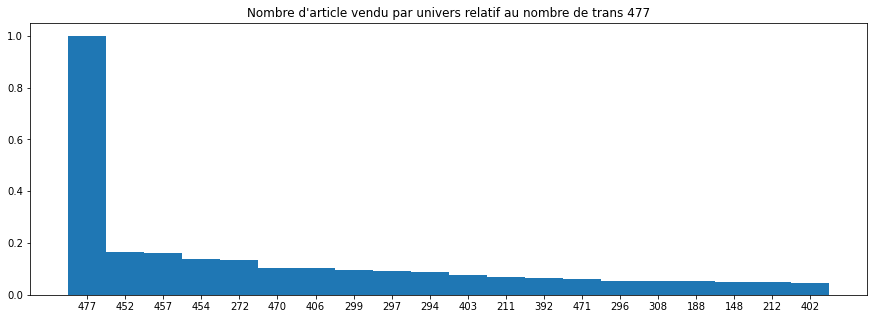

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 5.6)
("Nombre moyen d'univ", 1.25)
('CA univ', 96257.15)
('CA moyen univ', 3.72)
('Nombre moyen article en plus', 5.71)
('CA en plus', 559802.88)
('CA moyen en plus', 21.65)
==============478===================


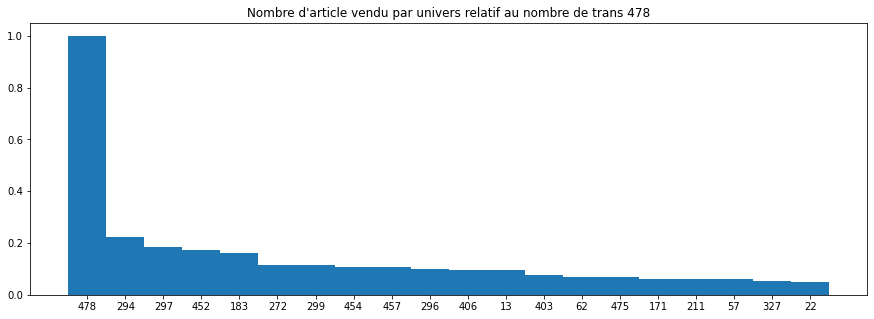

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 3.04)
("Nombre moyen d'univ", 1.22)
('CA univ', 26407.16)
('CA moyen univ', 4.22)
('Nombre moyen article en plus', 7.34)
('CA en plus', 161049.92)
('CA moyen en plus', 25.75)
==============479===================
NOT ENOUGH DATA 
==============490===================
NOT ENOUGH DATA 
Time Taken to load all metrics: ~168secondes


In [39]:
start = time()

dico_metrics = {}

for key in all_univ:
    print("==============" + str(key)+"===================")
    
    trans           = univ_transactions[key]
    CA_without_univ = univ_CA_sans_univ[key]
    CA_univ         = univ_CA[key]
        
    N = len(trans)
    if N <= 50:
        print("NOT ENOUGH DATA ")
        continue
    
    nbr_article_sans_univ = [0 for _ in range(N)]
    nbr_article_univ      = [0 for _ in range(N)]
    for i in range(len(trans)):
        for item in trans[i]:
            if item != key:
                nbr_article_sans_univ[i] += 1
            else:
                nbr_article_univ[i] += 1

#     print("Proportion d'achat de univs " + str(key) + " : ", end = ' ')
#     print(round(N*100/len(transactions),2), '%')
#     print("Nombre moyen d'achat de univs " + str(key) + " : ", end = ' ')
#     print(round(sum(nbr_article_univ)/N, 2))
#     print("Nombre moyen d'achat en plus du univs " + str(key) + " : ", end = ' ')
#     print(round(sum(nbr_article_sans_univ)/N, 2))
#     print("Proportion d'achat de univs " + str(key) + " seul:", end = ' ')
#     print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_univ])*100/N, 2), '%')
    
#     print("CA sans " + str(key) + " : ", end = ' ')
#     print(round(CA_without_univ,2))
#     print("CA moyen sans " + str(key) + " : ", end = ' ')
#     print(round(CA_without_univ/N,2))
#     print("CA de " + str(key) + " : ", end = ' ')
#     print(round(CA_univ,2))
#     print("CA moyen de " + str(key) + " : ", end = ' ')
#     print(round(CA_univ/N,2))
    
    
    
    
    rec_article = {}

    for t in trans:
        for art in set(t):
            if not str(art) in rec_article.keys():
                rec_article[str(art)] = 0
            rec_article[str(art)]+=1

    for k in rec_article.keys():
        rec_article[k]/= N

    fig = plt.figure(figsize=(15, 5))

    rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

    nbr_univ = len(rec_article.keys())

    plt.bar(list(rec_article.keys())[:min(20, nbr_univ)]
                ,list(rec_article.values())[:min(20, nbr_univ)],1)

    plt.title("Nombre d'article vendu par univers relatif au nombre de trans " + str(key))

    # if save_fig:
    #     plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
    plt.show()
    
    
    dico_metrics[key] = {"Proportion d'achat (%)": round(N*100/len(transactions),2),
                         "Proportion achat seul (%)": round(sum([1 if t == 0 else 0 for t in nbr_article_sans_univ])*100/N, 2),
                         "Nombre moyen d'univ":round(sum(nbr_article_univ)/N, 2),
                         "CA univ":round(CA_univ,2),
                         "CA moyen univ":round(CA_univ/N,2),
                         "Nombre moyen article en plus": round(sum(nbr_article_sans_univ)/N, 2),
                         "CA en plus": round(CA_without_univ,2),
                         "CA moyen en plus":round(CA_without_univ/N,2)}
    for item in dico_metrics[key].items():
        print(item)
    
    
print("Time Taken to load all metrics: ~" + str(int(time() - start)) + "secondes") 

In [40]:
dataframe_metrics = pd.DataFrame(index = dico_metrics.keys(),
                                 data = dico_metrics.values())
print(dataframe_metrics)

     Proportion d'achat (%)  Proportion achat seul (%)  Nombre moyen d'univ  \
1                      0.01                       7.56                 1.49   
2                      0.01                       6.73                 1.18   
4                      0.04                       8.10                 1.13   
5                      0.01                      11.85                 1.74   
9                      0.41                       5.34                 1.16   
..                      ...                        ...                  ...   
474                    0.27                       1.94                 1.07   
475                    1.89                       1.42                 1.09   
476                    0.48                       4.31                 1.23   
477                    0.68                       5.60                 1.25   
478                    0.16                       3.04                 1.22   

       CA univ  CA moyen univ  Nombre moyen article

In [44]:
dataframe_metrics=dataframe_metrics.sort_values(by=dataframe_metrics.columns[4], axis = 0, ascending=False)
print(dataframe_metrics.head(10))

     Proportion d'achat (%)  Proportion achat seul (%)  Nombre moyen d'univ  \
421                    0.01                      18.78                 1.91   
315                    0.02                      20.21                 1.15   
1                      0.01                       7.56                 1.49   
313                    0.20                      20.70                 1.16   
314                    0.01                      16.37                 1.14   
265                    0.00                      17.24                 1.29   
429                    0.03                      10.98                 1.99   
308                    0.09                       9.19                 1.06   
164                    0.00                      11.66                 1.38   
309                    0.01                      20.00                 1.09   

       CA univ  CA moyen univ  Nombre moyen article en plus  CA en plus  \
421   30071.26          68.03                         1

## Load DataFrame with only fidelised client from a segment.

In [43]:
start = time()

segment = 1

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE   + '''.KEY], ''' + ('''
['''+ TABLE_ENTETE   +'''.'''+TABLE_MAGASIN+'''.KEY],''')*int(do_shop) + '''
['''     + RECETTE_DETAIL + ''']
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + CONSOMMATEUR    + ''']
ON [''' + CONSOMMATEUR    + '''.Key] = ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY]
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
AND ['''      + CONSOMMATEUR  + '''.KEY] != -1
AND ['''+ CONSOMMATEUR  +'''.Segment_Clientele] = ''' + str(segment) + '''
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY], 
[Recette_detail_ticket.Total_net_ttc_ligne]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_Consommateur]
ON [Consommateur.Key] = [Recette_entete_ticket.Consommateur.KEY]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Article_meti_HIST.Univers.KEY] != 388
AND [Consommateur.KEY] != -1
AND [Consommateur.Segment_Clientele] = 1
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~170secondes
